## Общая информация о соревновании


### Ссылка на соревнование:
https://www.kaggle.com/competitions/anomaly-detection-competition-ml1-ts-spring-2022/overview

#### Наша команда: Na chille, na rasslabone

#### Описание соревнования:
Во множестве прикладных задач возникает необходимость разбить веб-страницы на какие-то определенные группы, где в каждой группе страницы будут очень похожи по смыслу. Например, представим, что Вы владелец сервиса интернет рекламы. Вашим клиентам хочется, чтобы их услуги рекламировались не на каком-то определенном сайте, а на всех сайтах их тематики. То есть Вам нужна какая-то тематическая разметка сайтов в интернете по множеству тематик, и клиент сможет выбрать любую, какая ему больше нравится. Как же такую разметку сделать?

Самый простой способ - разметить людьми множество сайтов в интернете на множество тем, настроить на этой выборке многоклассовый классификатор и сделать предсказанием на всем оставшемся "интернете". Однако, в таком подходе возникает несколько проблем. Во-первых, непонятно откуда брать само множество тем, на которое размечать. Во-вторых, даже если множество тем зафиксировано, не очень понятно, откуда для каждой темы брать примеры, чтобы добавить их в обучающее множество.

В данном задании мы предлагаем Вам попробовать другое решение. Пусть тематику задают сами данные! Разделим наши веб-страницы на множество групп, например, просто по словам в веб-страницах. В такой группе буду как документы об одном и том же, так и "аномалии", которые имеют схожие слова, но не соответствуют документам основной тематики. Например, в такой группе может содержаться подмножество веб-страниц про "ремонт пластиковых окон" и аномалии вроде "пластиковые игрушки", "ремонт квартир" и так далее. Нам останется только выделить подмножество документов одной темы, то есть все документы, которые про "ремонт пластовых окон" и убрать все аномалии. Затем подмножество как-то проименуем, чтобы показать клиенту, но этим Вы уже займетесь, когда будете продавать Вашу систему :)

В задании Вам предлагается работать с 28026 веб-страницами, которые уже скачаны и лежат в архиве content.tar.gz. Эти страницы разбиты по группам, каждая группа около 100 страниц. Каждая группа соответствует какой-то определенной теме, которая Вам неизвестна. Обучающее множество состоит из 129 групп. В обучающих группах ручной разметкой было проставлено, соответствует ли данный документ теме группы (target = 1) или это аномалия (target = 0). Тестовое множество состоит из 180 групп. Вам необходимо проставить для них target. Важно отметить, что обучающие и тестовые группы не пересекаются. Гарантируется, что в каждой группе есть подмножество документов из ее темы.


In [32]:
import requests
import logging
import gzip
import json
import codecs
import re
import regex
import tarfile
import os.path

import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from multiprocessing.dummy import Pool, Queue
from bs4 import BeautifulSoup
from time import sleep
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from bs4.element import Comment
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score

from pymorphy2 import MorphAnalyzer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Обрабатываем html странички

Функции для обработки текста html страничек. 
Вытаскиваем заголовки и текст страниц, убираем все знаки кроме букв. К заголовкам применяем лемматизаци, а к тексту стемминг(применять лемматизацию к тексту было затратно). Для каждой страгички сохраняем обработанный заголовок, 50 самых часто встречаемых слов в тексте стрвницы, количество слов в заголовке и количество значимых слов в тексте.

In [2]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]', 'option']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [3]:
def get_title_and_text(doc_id):
    """
        Get set of words from title
        and most common words from text
    """
    page = open("content/" + str(doc_id) + ".dat", 'r', encoding='utf-8').read()
    soup = BeautifulSoup(page, 'html.parser')
    
    stemmer = SnowballStemmer("russian")
    morph = MorphAnalyzer()
    title = soup.title.text
    
    reg = regex.compile('[^a-zA-Zа-яА-Я ]')
    stop = set(stopwords.words('russian'))
    new_title = ' '.join([morph.normal_forms(w.lower())[0] for w in reg.sub('', title).strip().split() if (not (w.lower() in stop))])

    txt = soup.findAll(text=True)
    visible = filter(tag_visible, txt)
    txt = u" ".join(t.strip() for t in visible)

    txt = reg.sub('', txt)
    words = [stemmer.stem(word) for word in txt.split() if (not (word in stop)) and len(word) > 1]
    cnt = Counter(words)

    return (new_title, ' '.join(dict(cnt.most_common(50)).keys()), len(words))

In [4]:
def process_page(pair_id):
    """
        Get information about pair (doc, group):
        - doc_id - номер документа,
        - title - множество слов из заголовка страницы,
        - text - множество из 50 самых частых слов текста страницы,
        - target.
    """
    new_doc = train_data.loc[pair_id]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    try:
        title, text, size_text = get_title_and_text(doc_id)
    except:
        title, text, size_text = '', '', 0
    if doc_group not in traingroups_data:
        traingroups_data[doc_group] = []
    traingroups_data[doc_group].append((doc_id, title, text, len(title), size_text, target))
    return (doc_id, title, text, len(title), size_text, target)

### Реализация обработки всех страниц из обучающей выборки в несколько потоков

In [185]:
queue_groups = Queue()   # очередь ссылок на группы
train_data = pd.read_csv('train_groups.csv')
traingroups_data = {}
train_data.index = train_data.pair_id

groups_to_process = [29]

# Create queue of groups and n_groups queues of pair_ids in group
queue = {i: Queue() for i in groups_to_process}# gtrain_data.group_id.unique()}
for group in groups_to_process:# train_data.group_id.unique():
    queue_groups.put(group)
    for pair in train_data[train_data.group_id == group].itertuples():
        queue[group].put(pair.pair_id)
#for pair in train_data[train_data.group_id == 1].itertuples():
#    queue.put(pair.pair_id)

#pages_data = {i:[] for i in groups_to_process}# train_data.group_id.unique()

#zipfile = 'content.tar.gz'
#tar = tarfile.open(zipfile, "r:gz") # Считывает архив с данными

def extract_pages(group):
    """
        Extract pages data from .gz archive if not extracted
    """
    for pair in train_data[train_data.group_id == group].itertuples():
        if not os.path.exists("content/" + str(pair.doc_id) + ".dat"):
            tar.extract("content/" + str(pair.doc_id) + ".dat")

def process_page_wrapper(i):
    while not queue_groups.empty():
        group = int(queue_groups.get())
        #extract_pages(group)
        with open('data_2/group_{:03d}.txt'.format(group), mode='wb') as f_json:
            f_json = codecs.getwriter('utf_16')(f_json)
            record = {}
            while not queue[group].empty():
                pair_id = queue[group].get()
                doc_id, title, text, size_title, size_text, target = process_page(pair_id)
                record[pair_id] = {'doc_id': int(doc_id), 'title': title, 'text': text, 'size_title': size_title, 'size_text': size_text,' target': int(target)}
                #print(record[pair_id]) 
                #pages_data[group].append((doc_id, title, text, size_title, target))
            record_str = json.dumps(record, indent=4, ensure_ascii=False)
            print(record_str, file=f_json) 
            with lock:
                pbar.update(1)


with Pool(processes=4) as pool, tqdm(total=queue_groups.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_page_wrapper, range(pool._processes))
    pool.close()
    pool.join()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.08s/it]


### Делаем такую же обработку в несколько потоков для страниц из тестовой выборки

In [5]:
def process_page_test(pair_id):
    """
        Get information about pair (doc, group):
        - doc_id - номер документа,
        - title - множество слов из заголовка страницы,
        - text - множество из 50 самых частых слов текста страницы,
        - target.
    """
    new_doc = test_data.loc[pair_id]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    try:
        title, text, size_text = get_title_and_text(doc_id)
    except:
        title, text, size_text = '', '', 0
    #title = doc_to_title[doc_id]
    if doc_group not in traingroups_data:
        testgroups_data[doc_group] = []
#     traingroups_data[doc_group].append((doc_id, title, text, target))
#     return (doc_id, title, text, target)
    testgroups_data[doc_group].append((doc_id, title, text, len(title), size_text))
    return (doc_id, title, text, len(title), size_text)

In [197]:
queue_groups = Queue()   # очередь ссылок на группы
test_data = pd.read_csv('test_groups.csv')
testgroups_data = {}
test_data.index = test_data.pair_id

groups_to_process = [133, 239, 307]

# Create queue of groups and n_groups queues of pair_ids in group
queue = {i: Queue() for i in groups_to_process}# gtrain_data.group_id.unique()}
for group in groups_to_process:# train_data.group_id.unique():
    queue_groups.put(group)
    for pair in test_data[test_data.group_id == group].itertuples():
        queue[group].put(pair.pair_id)
#for pair in train_data[train_data.group_id == 1].itertuples():
#    queue.put(pair.pair_id)

#pages_data = {i:[] for i in groups_to_process}# train_data.group_id.unique()

#zipfile = 'content.tar.gz'
#tar = tarfile.open(zipfile, "r:gz") # Считывает архив с данными

def extract_pages(group):
    """
        Extract pages data from .gz archive if not extracted
    """
    for pair in test_data[test_data.group_id == group].itertuples():
        if not os.path.exists("content/" + str(pair.doc_id) + ".dat"):
            tar.extract("content/" + str(pair.doc_id) + ".dat")

def process_page_wrapper(i):
    while not queue_groups.empty():
        group = int(queue_groups.get())
        #extract_pages(group)
        with open('data_test/group_{:03d}.txt'.format(group), mode='wb') as f_json:
            f_json = codecs.getwriter('utf_16')(f_json)
            record = {}
            while not queue[group].empty():
                pair_id = queue[group].get()
                doc_id, title, text, size_title, size_text = process_page_test(pair_id)
                record[pair_id] = {'doc_id': int(doc_id), 'title': title, 'text': text, 'size_title': size_title, 'size_text': size_text}
                #print(record[pair_id]) 
                #pages_data[group].append((doc_id, title, text, size_title, target))
            record_str = json.dumps(record, indent=4, ensure_ascii=False)
            print(record_str, file=f_json) 
            with lock:
                pbar.update(1)


with Pool(processes=4) as pool, tqdm(total=queue_groups.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_page_wrapper, range(pool._processes))
    pool.close()
    pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.97s/it]


### Создание фичей

Информация про каждый файл была записана по группам в json файлы(1 файл на 1 группу). Создаем матрицу признаков, для этого применяем векторайзер отдельно к заголовкам, отдельно к популярным словам из текста по группам, считаем косинусово расстояние и берем 25 самый больших расстояний и для заголовков и для текстов, количество слов в заголовке и в тексте оставляем в прежнем формате.

In [128]:
def parser_groups_train(numbers):
    vectorizer_titel = TfidfVectorizer()
    vectorizer_text = TfidfVectorizer()

    X, y = [], []
    for group in numbers:
        with open('data_3/group_{:03d}.txt'.format(group), mode="rb") as json_file:
            json_file = codecs.getreader('utf-16')(json_file)
            #try:
            docs = json.load(json_file)
#             except json.JSONDecodeError:
#                 continue
            docs = [list(f.values()) for f in docs.values()]
            doc_id, title, text, size_title, size_text, target = zip(*docs)

            distances_title = pdist(vectorizer_titel.fit_transform(title).toarray(), 'cosine')
            distances_title[np.where(np.isnan(distances_title))[0]] = 1.

            distances_text = pdist(vectorizer_text.fit_transform(text).toarray(), 'cosine')
            distances_text[np.where(np.isnan(distances_text))[0]] = 1.

            f1 = np.sort(squareform(distances_title))[:, 1:26]
            f2 = np.sort(squareform(distances_text))[:, 1:26]   
            f3 = np.array(size_title)
            f3 = f3[:, np.newaxis]
            f4 = np.array(size_text)
            f4 = f4[:, np.newaxis]

            features = np.concatenate((f1, f2, f3, f4), axis=1)
            X.extend(features)
            y.extend(target)
            
    return np.array(X), np.array(y)

In [129]:
def parser_groups_test(numbers):
    vectorizer_titel = TfidfVectorizer()
    vectorizer_text = TfidfVectorizer()

    X, y = [], []
    for group in numbers:
        with open('data_test/group_{:03d}.txt'.format(group), mode="rb") as json_file:
            json_file = codecs.getreader('utf-16')(json_file)
            docs = json.load(json_file)
            docs = [list(f.values()) for f in docs.values()]
            doc_id, title, text, size_title, size_text = zip(*docs)

            distances_title = pdist(vectorizer_titel.fit_transform(title).toarray(), 'cosine')
            distances_title[np.where(np.isnan(distances_title))[0]] = 1.

            distances_text = pdist(vectorizer_text.fit_transform(text).toarray(), 'cosine')
            distances_text[np.where(np.isnan(distances_text))[0]] = 1.

            f1 = np.sort(squareform(distances_title))[:, 1:26]
            f2 = np.sort(squareform(distances_text))[:, 1:26]   
            f3 = np.array(size_title)
            f3 = f3[:, np.newaxis]
            f4 = np.array(size_text)
            f4 = f4[:, np.newaxis]

            features = np.concatenate((f1, f2, f3, f4), axis=1)
            X.extend(features)
            y.extend(doc_id)
            
    return np.array(X), np.array(y)

Создаем X_train, y_train, X_test

In [130]:
X_train, y_train = parser_groups_train(range(1, 130))
X_test, y_ind = parser_groups_test(range(130,310))

Применяем модель давшую наибольший f1_score (эксперементы с моделями и параметрами ниже)

In [131]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={0:1, 1:2})
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Записываем предсказание

In [133]:
pred = pred.astype('int')
test_data = pd.read_csv('test_groups.csv')
file = open("popt.csv", "w")
file.write("pair_id,target\n")
pair_ids = test_data['pair_id']
for k, pair_id in enumerate(pair_ids):
    file.write(str(pair_id) + "," +str(pred[k]) + str("\n"))
file.close()

Тут мы совмещали несколько предсказаний

In [134]:
file1 = pd.read_csv("popt.csv")
file2 = pd.read_csv("02.csv")
file3 = pd.read_csv("04.csv")

file1.head()
file1['target2'] = file2['target']
file1['target3'] = file3['target']
file1['final'] = np.around((file1['target'] + file2['target'] + file3['target'])/3).astype('int')
file4 = file1[['pair_id','final']]
file4.rename(columns={'final':'target'}, inplace=True)
file4.to_csv("together3.csv", index=False)

Далее идут достаточно сумбурные эксперементы с попытками применить разные модели с разными параметрами, попытки сделать блендинг, как-то понизить расмерность)))

In [178]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [179]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=3000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7227555053642011


In [80]:
def blending(number_A, number_B, X_test):
    A_x, A_y = parser_groups_train(number_A)
    B_x, B_y = parser_groups_train(number_B)
    C = X_test
    models = []
    b_pred = []
    c_pred = []
    for i in range(5):
        clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            subsample=0.6,
                            custom_loss=['F1', 'Precision', 'Recall'])
        clf.fit(A_x, A_y, plot=True)
        models.append(clf)
        b_pred.append(clf.predict(B_x))
        c_pred.append(clf.predict(C))
    clf = SGDClassifier()
    b_pred = np.transpose(np.array(b_pred))
    c_pred = np.transpose(np.array(c_pred))
    clf.fit(b_pred, B_y)
    return  clf.predict(c_pred)                     

In [10]:
from sklearn import svm
from catboost import CatBoostClassifier

In [100]:
def blending_2(number_A, number_B, X_test):
    A_x, A_y = parser_groups_train(number_A)
    B_x, B_y = parser_groups_train(number_B)
    C = X_test
    models = []
    b_pred = []
    c_pred = []
    
    clf_1 = svm.SVC(class_weight={1:2})
    clf_1.fit(A_x, A_y)
    print(f1_score(clf_1.predict(A_x), A_y))
    models.append(clf_1)
    b_pred.append(clf_1.predict(B_x))
    c_pred.append(clf_1.predict(C))
    
#     clf_2 = CatBoostClassifier(loss_function='Logloss',
#                             depth=6,
#                             learning_rate=0.01,
#                             verbose=False, 
#                             iterations=2000, 
#                             leaf_estimation_method = 'Gradient',
#                             subsample=0.6,
#                             custom_loss=['F1', 'Precision', 'Recall'])
#     clf_2.fit(A_x, A_y, plot=True)
#     models.append(clf_2)
#     b_pred.append(clf_2.predict(B_x))
#     c_pred.append(clf_2.predict(C))
    
#     clf_3 = CatBoostClassifier(loss_function='Logloss',
#                             depth=6,
#                             learning_rate=0.01,
#                             verbose=False, 
#                             iterations=2000, 
#                             leaf_estimation_method = 'Gradient',
#                             subsample=0.6,
#                             custom_loss=['F1', 'Precision', 'Recall'])
#     clf_3.fit(A_x, A_y, plot=True)
#     models.append(clf_3)
#     b_pred.append(clf_3.predict(B_x))
#     c_pred.append(clf_3.predict(C)) 
    
#     clf_2 = GradientBoostingClassifier()
#     clf_2.fit(A_x, A_y)
#     models.append(clf_2)
#     b_pred.append(clf_2.predict(B_x))
#     c_pred.append(clf_2.predict(C))
    
    clf_3 = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight={1:2})
    clf_3.fit(A_x, A_y)
    print(f1_score(clf_3.predict(A_x), A_y))
    models.append(clf_3)
    b_pred.append(clf_3.predict(B_x))
    c_pred.append(clf_3.predict(C))
    
    
    clf = SGDClassifier(class_weight={1:2})
    b_pred = np.transpose(np.array(b_pred))
    c_pred = np.transpose(np.array(c_pred))
    clf.fit(b_pred, B_y)
    print(f1_score(clf.predict(b_pred), B_y))
    return  clf.predict(c_pred)

In [98]:
X_test, y_ind = parser_groups_test(range(130,310))
pred = blending_2(range(1, 100), range(100,130), X_test)

0.5845089166888474
0.7087975412985018
0.7456765005086471


In [101]:
X_test, y_test = parser_groups_train(range(100, 130))
pred = blending_2(range(1, 80), range(70,100), X_test)
print(f1_score(y_test, pred))

0.0
0.7309099780434253
0.6413333333333333
0.7471852610030707


In [14]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [23]:
clf = svm.SVC(class_weight={1:2})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.6105100463678517


In [46]:
clf = RandomForestClassifier(criterion='entropy', max_depth=6)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7396483267158253


In [ ]:
X_test, y_ind = parser_groups_test(range(130,310))

In [105]:
clf = RandomForestClassifier(n_estimators=, criterion='entropy', max_depth=6, class_weight={1:2})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(clf.predict(X_train), y_train))
print(f1_score(pred, y_test))

0.7037964925804586
0.7452974072191154


In [13]:
print(f1_score(y_test, pred))

0.7361492046077894


In [81]:
X_test, y_test = parser_groups_train(range(100, 130))
pred = blending(range(1, 70), range(70,100), X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.0


In [122]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

f1 = X_train[:, :25]
f2 = X_train[:, 25:50]
f3 = X_train[:, 50]
f3 = f3[:, np.newaxis]
f4 = X_train[:, 51]
f4 = f4[:, np.newaxis]

f1_test = X_test[:, :25]
f2_test = X_test[:, 25:50]
f3_test = X_test[:, 50]
f3_test = f3_test[:, np.newaxis]
f4_test = X_test[:, 51]
f4_test = f4_test[:, np.newaxis]

In [83]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f1, y_train, plot=True)
pred = clf.predict(f1_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7298245614035088


In [118]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [126]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            auto_class_weights=True)
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/json_helper.h:171: Can't parse parameter "auto_class_weights" with value: true

In [127]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={0:1, 1:2} )
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.770909090909091


In [120]:
clf.feature_importances_

array([ 3.68159245,  4.06617053,  2.50132273,  2.19584047,  2.03655221,
        2.57305031,  2.27360031,  1.29372547,  1.80729104,  1.0534181 ,
        1.05832378,  1.37285402,  1.22808638,  1.31806747,  1.00868763,
        1.14841526,  0.96137077,  0.82706072,  0.9651461 ,  0.98057886,
        0.83295921,  0.95644518,  1.23497481,  1.25269589,  1.91211082,
        3.7288209 ,  3.58641981,  2.52202696,  2.25139676,  1.85238925,
        1.21521895,  1.67365435,  1.84845696,  1.16046424,  1.37909998,
        1.08188744,  1.29205783,  0.77260698,  1.05761168,  0.96455056,
        1.09929273,  1.07677441,  0.87144014,  0.90129806,  0.93983977,
        0.90582779,  0.8337846 ,  1.01950317,  1.2881421 ,  1.77633008,
        6.54561047, 15.81515349])

In [84]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={1:2})
clf.fit(f2, y_train, plot=True)
pred = clf.predict(f2_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.3098842386464827


In [86]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f4, y_train, plot=True)
pred = clf.predict(f4_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.2231543624161074


In [123]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f34 = np.concatenate((f3, f4), axis=1)
f34_test = np.concatenate((f3_test, f4_test), axis=1)
clf.fit(f34, y_train, plot=True)
pred = clf.predict(f34_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.31060606060606055


In [88]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f13 = np.concatenate((f1, f3), axis=1)
f13_test = np.concatenate((f1_test, f3_test), axis=1)
clf.fit(f13, y_train, plot=True)
pred = clf.predict(f13_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7428571428571429


In [89]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f14 = np.concatenate((f1, f4), axis=1)
f14_test = np.concatenate((f1_test, f4_test), axis=1)
clf.fit(f14, y_train, plot=True)
pred = clf.predict(f14_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7309048178613395


In [91]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f24 = np.concatenate((f2, f4), axis=1)
f24_test = np.concatenate((f2_test, f4_test), axis=1)
clf.fit(f24, y_train, plot=True)
pred = clf.predict(f24_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.6391625615763546


In [92]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f124 = np.concatenate((f1, f2, f4), axis=1)
f124_test = np.concatenate((f1_test, f2_test, f4_test), axis=1)
clf.fit(f124, y_train, plot=True)
pred = clf.predict(f124_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7448194197750148


In [93]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7530936947554507


In [158]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #12
X_test, y_test = parser_groups_train_2(range(100, 130))

my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7610099823840282


In [160]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #14
X_test, y_test = parser_groups_train_2(range(100, 130))

my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7627416520210897


In [166]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #14
X_test, y_test = parser_groups_train_2(range(100, 130))

In [172]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=3000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7638483965014577


In [140]:
f5 = X_train[:,54]
f5 = f5[:, np.newaxis]

f5_test = X_test[:,54]
f5_test = f5_test[:, np.newaxis]

my_clf.fit(f5, y_train, plot=True)
pred = my_clf.predict(f5_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.116


In [85]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f3, y_train, plot=True)
pred = clf.predict(f3_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.006493506493506494


In [99]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))
from sklearn.decomposition import PCA
pca = PCA(2)
pca_train = pca.fit_transform(X_train)
pca_test = pca.fit_transform(X_test)

In [100]:
clf = SGDClassifier()
clf.fit(pca_train, y_train)
pred = clf.predict(pca_test)
print(f1_score(pred, y_test))

0.5638906547997458


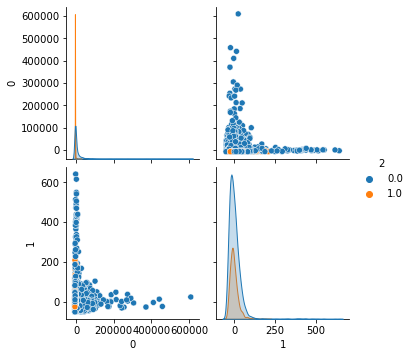

In [120]:
df = pd.DataFrame(np.concatenate((pca_train, (y_train[:, np.newaxis]).astype('int')), axis=1))
sns.pairplot(df, hue=2)

In [122]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(pred, y_test))

0.7246550689862027


In [126]:
acc = []
for i in range(10, 300, 20):
    preds = 0
    my_clf = GradientBoostingClassifier(n_estimators=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 3)
    print(preds / 3)

0.8136903170002573
0.8304634625233644
0.8304623838273261
0.8303488895941507
0.8329560593939286
0.8342020303679133
0.8331820076890994
0.830462075628458
0.835788406991707
0.8293293677384975
0.8314820212575545
0.8304627690759112
0.8295547766856494
0.83567599145457
0.8331828167111283


In [130]:
print(list(range(10, 300, 20)))

[10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290]


In [135]:
acc = []
f1_s = []
loss = ['deviance', 'exponential']
for i in loss:
    preds = 0
    f1 = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f1 += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1_s.append(f1/3)
    print(f1/3)
print(acc)
print(f1)
best_loss = loss[np.argmax(f1)]
print(best_loss)

0.6815924428837453
0.6830748790935645
[0.8306897190174034, 0.8320485678268273]
2.0492246372806933
deviance


In [137]:
preds = 0
f1 = 0
my_clf = GradientBoostingClassifier(n_estimators=170)
for ind_train, ind_test in kfold.split(X_train, y_train):
    X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
    my_clf.fit(X_train_, y_train_)
    pred = my_clf.predict(X_test_)
    preds += accuracy_score(y_pred=pred, y_true=y_test_)
    f1 += f1_score(y_test_, pred)
print(f1/3)
print(preds/3)

0.6774643416887886
0.8291031112444586


In [139]:
acc = []
f1 = []
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
for lr in learning_rate:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=lr)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
print(acc)
print(f1)
best_lr = learning_rate[np.argmax(f1)]
print('Лучший learning_rate =', best_lr)

[0.7233697108162316, 0.7958972258480536, 0.8295565103042825, 0.8319358055659638, 0.8343152934519376, 0.831595592540447, 0.8285365646751858]
[0.0, 0.4534568656008941, 0.6628114612087938, 0.6854917808743365, 0.6870409407846347, 0.68051333429944, 0.6719543235622942]
Лучший learning_rate = 0.1


In [140]:
acc = []
f1 = []
percent = np.arange(0.1, 1.1, 0.1)
for p in percent:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=p)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
    print(f/3)
print(acc)
print(f1)
best_p = percent[np.argmax(f1)]
print('Лучший subsample  =', best_p)

0.67099909069933
0.6757312065299973
0.6735076298085801
0.6814471028932229
0.6801710352574449
0.6865750304173991
0.6844950168455003
0.6859248218385771
0.6806388260996762
0.6862481040718568
[0.8246820370065168, 0.8264946701243497, 0.8274023157908849, 0.8311413844585944, 0.8305755313367748, 0.833975311575572, 0.8329553659464753, 0.8337488624572402, 0.8306884091722141, 0.833749594429552]
[0.67099909069933, 0.6757312065299973, 0.6735076298085801, 0.6814471028932229, 0.6801710352574449, 0.6865750304173991, 0.6844950168455003, 0.6859248218385771, 0.6806388260996762, 0.6862481040718568]
Лучший subsample  = 0.2


In [141]:
best_p = percent[np.argmax(f1)]
print('Лучший subsample  =', best_p)

Лучший subsample  = 0.6


In [142]:
acc = []
f1 = []
depth = np.arange(1, 10)
for d in depth:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=d)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
    print(f/3)
print(acc)
print(f1)
best_d = depth[np.argmax(f1)]
print('Лучший depth =', best_d)

0.6696315864548428
0.6819512373522215
0.682180332006165
0.6856937637694757
0.6824441508151011
0.6794529390746749
0.6770784805014909
0.6846093153684416
0.685099540473359
[0.8245679263756052, 0.8310285836728721, 0.830803521449447, 0.8334088035311576, 0.8320491842245635, 0.8325017357375003, 0.8315957081150226, 0.8349957965526879, 0.8351092137361462]
[0.6696315864548428, 0.6819512373522215, 0.682180332006165, 0.6856937637694757, 0.6824441508151011, 0.6794529390746749, 0.6770784805014909, 0.6846093153684416, 0.685099540473359]
Лучший depth = 4


In [143]:
clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=4)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.838814600650524
0.7397899649941657


In [144]:
clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=4)
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_scaler.fit(X_train), test_scaler.fit(X_test)
X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.8192988796530538
0.6798975672215108


In [25]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [261]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [224]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=9,
                            #learning_rate=0.01,
                            eta=0.1,
                            verbose=False, 
                            iterations=600, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
# train_scaler, test_scaler = StandardScaler(), StandardScaler()
# train_scaler.fit(X_train), test_scaler.fit(X_test)
# X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))
my_clf.fit(X_train, y_train, plot=True)
print(f1_score(my_clf.predict(X_test), y_test))
print(f1_score(my_clf.predict(X_train), y_train))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7414806110458285
1.0


In [269]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
# train_scaler, test_scaler = StandardScaler(), StandardScaler()
# train_scaler.fit(X_train), test_scaler.fit(X_test)
# X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(pred, y_test))
print(f1_score(my_clf.predict(X_train), y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7530936947554507
0.8535419382877011


In [234]:
for i in np.arange(0.01, 0.1, 0.01):
    my_clf = CatBoostClassifier(loss_function='Logloss',
                                depth=9,
                                learning_rate=i,
                                verbose=False, 
                                iterations=1000, 
                                leaf_estimation_method = 'Gradient',
                                random_seed=42,
                                custom_loss=['F1', 'Precision', 'Recall'])
    # train_scaler, test_scaler = StandardScaler(), StandardScaler()
    # train_scaler.fit(X_train), test_scaler.fit(X_test)
    # X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
    my_clf.fit(X_train, y_train, plot=True)
    pred = my_clf.predict(X_test)
    print(f1_score(pred, y_test))
    print(f1_score(my_clf.predict(X_train), y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7489711934156378
0.8829373650107992


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7439670394349618
0.9593908629441624


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.747957992998833
0.9869646182495345


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.743362831858407
0.9965156794425087


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7447058823529411
0.9993868792152054


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.73943661971831
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7412177985948478
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7489711934156378
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7460410557184751
1.0


In [235]:
from catboost import CatBoost

model = CatBoost()

grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
        'depth': [4, 6, 7, 9],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

rid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       search_by_train_test_split=True,  
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5193845	test: 0.5275211	best: 0.5275211 (0)	total: 8.08ms	remaining: 8.08s
1:	learn: 0.5166561	test: 0.5247389	best: 0.5247389 (1)	total: 12.8ms	remaining: 6.36s
2:	learn: 0.5139599	test: 0.5219950	best: 0.5219950 (2)	total: 18ms	remaining: 6s
3:	learn: 0.5112812	test: 0.5192953	best: 0.5192953 (3)	total: 24.2ms	remaining: 6.03s
4:	learn: 0.5086526	test: 0.5166125	best: 0.5166125 (4)	total: 28.1ms	remaining: 5.59s
5:	learn: 0.5061049	test: 0.5139754	best: 0.5139754 (5)	total: 33.2ms	remaining: 5.5s
6:	learn: 0.5036201	test: 0.5114413	best: 0.5114413 (6)	total: 38ms	remaining: 5.39s
7:	learn: 0.5012652	test: 0.5089738	best: 0.5089738 (7)	total: 42.1ms	remaining: 5.23s
8:	learn: 0.4987786	test: 0.5064515	best: 0.5064515 (8)	total: 47ms	remaining: 5.17s
9:	learn: 0.4963508	test: 0.5039731	best: 0.5039731 (9)	total: 52.2ms	remaining: 5.17s
10:	learn: 0.4938761	test: 0.5014697	best: 0.5014697 (10)	total: 57.1ms	remaining: 5.13s
11:	learn: 0.4914784	test: 0.4990102	best: 0.499010

97:	learn: 0.3760891	test: 0.3830001	best: 0.3830001 (97)	total: 561ms	remaining: 5.16s
98:	learn: 0.3754301	test: 0.3823499	best: 0.3823499 (98)	total: 567ms	remaining: 5.16s
99:	learn: 0.3747643	test: 0.3816991	best: 0.3816991 (99)	total: 574ms	remaining: 5.17s
100:	learn: 0.3741242	test: 0.3810595	best: 0.3810595 (100)	total: 581ms	remaining: 5.17s
101:	learn: 0.3735427	test: 0.3804736	best: 0.3804736 (101)	total: 587ms	remaining: 5.17s
102:	learn: 0.3729474	test: 0.3798593	best: 0.3798593 (102)	total: 594ms	remaining: 5.17s
103:	learn: 0.3723351	test: 0.3792711	best: 0.3792711 (103)	total: 599ms	remaining: 5.16s
104:	learn: 0.3717499	test: 0.3786870	best: 0.3786870 (104)	total: 605ms	remaining: 5.15s
105:	learn: 0.3711452	test: 0.3780956	best: 0.3780956 (105)	total: 612ms	remaining: 5.16s
106:	learn: 0.3706136	test: 0.3775866	best: 0.3775866 (106)	total: 619ms	remaining: 5.16s
107:	learn: 0.3700984	test: 0.3770960	best: 0.3770960 (107)	total: 626ms	remaining: 5.17s
108:	learn: 0.36

216:	learn: 0.3415201	test: 0.3501297	best: 0.3501297 (216)	total: 1.28s	remaining: 4.63s
217:	learn: 0.3413948	test: 0.3500348	best: 0.3500348 (217)	total: 1.29s	remaining: 4.62s
218:	learn: 0.3412724	test: 0.3499372	best: 0.3499372 (218)	total: 1.29s	remaining: 4.62s
219:	learn: 0.3411652	test: 0.3498439	best: 0.3498439 (219)	total: 1.3s	remaining: 4.61s
220:	learn: 0.3410808	test: 0.3497755	best: 0.3497755 (220)	total: 1.31s	remaining: 4.61s
221:	learn: 0.3409792	test: 0.3496819	best: 0.3496819 (221)	total: 1.31s	remaining: 4.61s
222:	learn: 0.3408832	test: 0.3495970	best: 0.3495970 (222)	total: 1.32s	remaining: 4.61s
223:	learn: 0.3407918	test: 0.3495151	best: 0.3495151 (223)	total: 1.33s	remaining: 4.6s
224:	learn: 0.3406958	test: 0.3494325	best: 0.3494325 (224)	total: 1.33s	remaining: 4.59s
225:	learn: 0.3406140	test: 0.3493711	best: 0.3493711 (225)	total: 1.34s	remaining: 4.59s
226:	learn: 0.3405256	test: 0.3492945	best: 0.3492945 (226)	total: 1.35s	remaining: 4.59s
227:	learn: 

328:	learn: 0.3346848	test: 0.3448508	best: 0.3448508 (328)	total: 2.01s	remaining: 4.09s
329:	learn: 0.3346549	test: 0.3448350	best: 0.3448350 (329)	total: 2.01s	remaining: 4.09s
330:	learn: 0.3346206	test: 0.3448095	best: 0.3448095 (330)	total: 2.02s	remaining: 4.08s
331:	learn: 0.3345778	test: 0.3447831	best: 0.3447831 (331)	total: 2.02s	remaining: 4.07s
332:	learn: 0.3345356	test: 0.3447670	best: 0.3447670 (332)	total: 2.03s	remaining: 4.07s
333:	learn: 0.3344961	test: 0.3447209	best: 0.3447209 (333)	total: 2.04s	remaining: 4.06s
334:	learn: 0.3344741	test: 0.3447155	best: 0.3447155 (334)	total: 2.04s	remaining: 4.05s
335:	learn: 0.3344277	test: 0.3446809	best: 0.3446809 (335)	total: 2.05s	remaining: 4.05s
336:	learn: 0.3343996	test: 0.3446569	best: 0.3446569 (336)	total: 2.06s	remaining: 4.04s
337:	learn: 0.3343766	test: 0.3446449	best: 0.3446449 (337)	total: 2.06s	remaining: 4.04s
338:	learn: 0.3343381	test: 0.3446138	best: 0.3446138 (338)	total: 2.07s	remaining: 4.03s
339:	learn

445:	learn: 0.3313538	test: 0.3430090	best: 0.3430090 (445)	total: 2.73s	remaining: 3.39s
446:	learn: 0.3313293	test: 0.3429949	best: 0.3429949 (446)	total: 2.74s	remaining: 3.39s
447:	learn: 0.3313031	test: 0.3429799	best: 0.3429799 (447)	total: 2.75s	remaining: 3.38s
448:	learn: 0.3312878	test: 0.3429762	best: 0.3429762 (448)	total: 2.75s	remaining: 3.38s
449:	learn: 0.3312703	test: 0.3429683	best: 0.3429683 (449)	total: 2.76s	remaining: 3.37s
450:	learn: 0.3312413	test: 0.3429670	best: 0.3429670 (450)	total: 2.77s	remaining: 3.37s
451:	learn: 0.3312208	test: 0.3429617	best: 0.3429617 (451)	total: 2.77s	remaining: 3.36s
452:	learn: 0.3312098	test: 0.3429498	best: 0.3429498 (452)	total: 2.78s	remaining: 3.36s
453:	learn: 0.3311800	test: 0.3429508	best: 0.3429498 (452)	total: 2.79s	remaining: 3.35s
454:	learn: 0.3311635	test: 0.3429412	best: 0.3429412 (454)	total: 2.79s	remaining: 3.35s
455:	learn: 0.3311371	test: 0.3429265	best: 0.3429265 (455)	total: 2.8s	remaining: 3.34s
456:	learn:

559:	learn: 0.3290201	test: 0.3419136	best: 0.3419136 (559)	total: 3.45s	remaining: 2.71s
560:	learn: 0.3289911	test: 0.3418998	best: 0.3418998 (560)	total: 3.46s	remaining: 2.71s
561:	learn: 0.3289660	test: 0.3418906	best: 0.3418906 (561)	total: 3.46s	remaining: 2.7s
562:	learn: 0.3289420	test: 0.3418902	best: 0.3418902 (562)	total: 3.47s	remaining: 2.69s
563:	learn: 0.3289242	test: 0.3418848	best: 0.3418848 (563)	total: 3.48s	remaining: 2.69s
564:	learn: 0.3288975	test: 0.3418660	best: 0.3418660 (564)	total: 3.49s	remaining: 2.68s
565:	learn: 0.3288801	test: 0.3418698	best: 0.3418660 (564)	total: 3.49s	remaining: 2.68s
566:	learn: 0.3288500	test: 0.3418488	best: 0.3418488 (566)	total: 3.5s	remaining: 2.67s
567:	learn: 0.3288260	test: 0.3418342	best: 0.3418342 (567)	total: 3.5s	remaining: 2.67s
568:	learn: 0.3288047	test: 0.3418277	best: 0.3418277 (568)	total: 3.51s	remaining: 2.66s
569:	learn: 0.3287916	test: 0.3418238	best: 0.3418238 (569)	total: 3.52s	remaining: 2.65s
570:	learn: 0

677:	learn: 0.3266894	test: 0.3413946	best: 0.3413609 (671)	total: 4.18s	remaining: 1.99s
678:	learn: 0.3266745	test: 0.3413783	best: 0.3413609 (671)	total: 4.19s	remaining: 1.98s
679:	learn: 0.3266535	test: 0.3413831	best: 0.3413609 (671)	total: 4.19s	remaining: 1.97s
680:	learn: 0.3266342	test: 0.3413847	best: 0.3413609 (671)	total: 4.2s	remaining: 1.97s
681:	learn: 0.3266121	test: 0.3413773	best: 0.3413609 (671)	total: 4.21s	remaining: 1.96s
682:	learn: 0.3265985	test: 0.3413766	best: 0.3413609 (671)	total: 4.21s	remaining: 1.96s
683:	learn: 0.3265802	test: 0.3413681	best: 0.3413609 (671)	total: 4.22s	remaining: 1.95s
684:	learn: 0.3265628	test: 0.3413620	best: 0.3413609 (671)	total: 4.22s	remaining: 1.94s
685:	learn: 0.3265300	test: 0.3413517	best: 0.3413517 (685)	total: 4.23s	remaining: 1.94s
686:	learn: 0.3265144	test: 0.3413479	best: 0.3413479 (686)	total: 4.24s	remaining: 1.93s
687:	learn: 0.3265051	test: 0.3413403	best: 0.3413403 (687)	total: 4.24s	remaining: 1.92s
688:	learn:

795:	learn: 0.3245112	test: 0.3407894	best: 0.3407894 (795)	total: 4.91s	remaining: 1.26s
796:	learn: 0.3244931	test: 0.3407854	best: 0.3407854 (796)	total: 4.91s	remaining: 1.25s
797:	learn: 0.3244820	test: 0.3407747	best: 0.3407747 (797)	total: 4.92s	remaining: 1.25s
798:	learn: 0.3244692	test: 0.3407705	best: 0.3407705 (798)	total: 4.93s	remaining: 1.24s
799:	learn: 0.3244510	test: 0.3407716	best: 0.3407705 (798)	total: 4.94s	remaining: 1.23s
800:	learn: 0.3244300	test: 0.3407548	best: 0.3407548 (800)	total: 4.94s	remaining: 1.23s
801:	learn: 0.3244051	test: 0.3407327	best: 0.3407327 (801)	total: 4.95s	remaining: 1.22s
802:	learn: 0.3243876	test: 0.3407235	best: 0.3407235 (802)	total: 4.95s	remaining: 1.22s
803:	learn: 0.3243543	test: 0.3407345	best: 0.3407235 (802)	total: 4.96s	remaining: 1.21s
804:	learn: 0.3243336	test: 0.3407293	best: 0.3407235 (802)	total: 4.96s	remaining: 1.2s
805:	learn: 0.3243112	test: 0.3407453	best: 0.3407235 (802)	total: 4.97s	remaining: 1.2s
806:	learn: 

909:	learn: 0.3224247	test: 0.3403758	best: 0.3403740 (908)	total: 5.63s	remaining: 557ms
910:	learn: 0.3224100	test: 0.3403727	best: 0.3403727 (910)	total: 5.64s	remaining: 551ms
911:	learn: 0.3223943	test: 0.3403706	best: 0.3403706 (911)	total: 5.64s	remaining: 544ms
912:	learn: 0.3223673	test: 0.3403575	best: 0.3403575 (912)	total: 5.65s	remaining: 538ms
913:	learn: 0.3223392	test: 0.3403517	best: 0.3403517 (913)	total: 5.66s	remaining: 532ms
914:	learn: 0.3223203	test: 0.3403439	best: 0.3403439 (914)	total: 5.66s	remaining: 526ms
915:	learn: 0.3223012	test: 0.3403443	best: 0.3403439 (914)	total: 5.67s	remaining: 520ms
916:	learn: 0.3222808	test: 0.3403420	best: 0.3403420 (916)	total: 5.67s	remaining: 514ms
917:	learn: 0.3222604	test: 0.3403494	best: 0.3403420 (916)	total: 5.68s	remaining: 508ms
918:	learn: 0.3222385	test: 0.3403453	best: 0.3403420 (916)	total: 5.69s	remaining: 502ms
919:	learn: 0.3222303	test: 0.3403435	best: 0.3403420 (916)	total: 5.7s	remaining: 495ms
920:	learn:

14:	learn: 0.4536096	test: 0.4605268	best: 0.4605268 (14)	total: 100ms	remaining: 6.58s
15:	learn: 0.4500525	test: 0.4569287	best: 0.4569287 (15)	total: 108ms	remaining: 6.65s
16:	learn: 0.4466492	test: 0.4534321	best: 0.4534321 (16)	total: 117ms	remaining: 6.75s
17:	learn: 0.4431059	test: 0.4499114	best: 0.4499114 (17)	total: 123ms	remaining: 6.7s
18:	learn: 0.4397388	test: 0.4465046	best: 0.4465046 (18)	total: 129ms	remaining: 6.68s
19:	learn: 0.4364195	test: 0.4432011	best: 0.4432011 (19)	total: 136ms	remaining: 6.68s
20:	learn: 0.4332253	test: 0.4399454	best: 0.4399454 (20)	total: 143ms	remaining: 6.68s
21:	learn: 0.4302873	test: 0.4370020	best: 0.4370020 (21)	total: 151ms	remaining: 6.71s
22:	learn: 0.4272939	test: 0.4340118	best: 0.4340118 (22)	total: 157ms	remaining: 6.69s
23:	learn: 0.4244827	test: 0.4312121	best: 0.4312121 (23)	total: 164ms	remaining: 6.68s
24:	learn: 0.4217367	test: 0.4284237	best: 0.4284237 (24)	total: 171ms	remaining: 6.69s
25:	learn: 0.4191631	test: 0.4257

120:	learn: 0.3391933	test: 0.3482325	best: 0.3482325 (120)	total: 828ms	remaining: 6.02s
121:	learn: 0.3390837	test: 0.3481622	best: 0.3481622 (121)	total: 835ms	remaining: 6.01s
122:	learn: 0.3389363	test: 0.3480408	best: 0.3480408 (122)	total: 843ms	remaining: 6.01s
123:	learn: 0.3387765	test: 0.3479073	best: 0.3479073 (123)	total: 849ms	remaining: 6s
124:	learn: 0.3386534	test: 0.3477900	best: 0.3477900 (124)	total: 861ms	remaining: 6.03s
125:	learn: 0.3385304	test: 0.3476646	best: 0.3476646 (125)	total: 892ms	remaining: 6.18s
126:	learn: 0.3383734	test: 0.3475463	best: 0.3475463 (126)	total: 904ms	remaining: 6.22s
127:	learn: 0.3382270	test: 0.3474221	best: 0.3474221 (127)	total: 912ms	remaining: 6.21s
128:	learn: 0.3380941	test: 0.3472940	best: 0.3472940 (128)	total: 924ms	remaining: 6.24s
129:	learn: 0.3379538	test: 0.3471699	best: 0.3471699 (129)	total: 940ms	remaining: 6.29s
130:	learn: 0.3378020	test: 0.3470788	best: 0.3470788 (130)	total: 961ms	remaining: 6.37s
131:	learn: 0

224:	learn: 0.3314632	test: 0.3429401	best: 0.3429401 (224)	total: 1.74s	remaining: 6s
225:	learn: 0.3314088	test: 0.3428961	best: 0.3428961 (225)	total: 1.75s	remaining: 5.99s
226:	learn: 0.3313622	test: 0.3428675	best: 0.3428675 (226)	total: 1.76s	remaining: 5.99s
227:	learn: 0.3313323	test: 0.3428625	best: 0.3428625 (227)	total: 1.76s	remaining: 5.98s
228:	learn: 0.3313146	test: 0.3428689	best: 0.3428625 (227)	total: 1.77s	remaining: 5.97s
229:	learn: 0.3312738	test: 0.3428615	best: 0.3428615 (229)	total: 1.78s	remaining: 5.96s
230:	learn: 0.3312178	test: 0.3428635	best: 0.3428615 (229)	total: 1.78s	remaining: 5.94s
231:	learn: 0.3311725	test: 0.3428210	best: 0.3428210 (231)	total: 1.79s	remaining: 5.94s
232:	learn: 0.3311455	test: 0.3428201	best: 0.3428201 (232)	total: 1.8s	remaining: 5.93s
233:	learn: 0.3311227	test: 0.3428110	best: 0.3428110 (233)	total: 1.81s	remaining: 5.92s
234:	learn: 0.3310495	test: 0.3427863	best: 0.3427863 (234)	total: 1.81s	remaining: 5.91s
235:	learn: 0.

324:	learn: 0.3272997	test: 0.3416508	best: 0.3416508 (324)	total: 2.47s	remaining: 5.12s
325:	learn: 0.3272560	test: 0.3416224	best: 0.3416224 (325)	total: 2.48s	remaining: 5.12s
326:	learn: 0.3272285	test: 0.3416186	best: 0.3416186 (326)	total: 2.48s	remaining: 5.11s
327:	learn: 0.3271703	test: 0.3415808	best: 0.3415808 (327)	total: 2.49s	remaining: 5.1s
328:	learn: 0.3271272	test: 0.3415701	best: 0.3415701 (328)	total: 2.5s	remaining: 5.09s
329:	learn: 0.3270863	test: 0.3415797	best: 0.3415701 (328)	total: 2.5s	remaining: 5.08s
330:	learn: 0.3270369	test: 0.3415998	best: 0.3415701 (328)	total: 2.51s	remaining: 5.07s
331:	learn: 0.3270077	test: 0.3416017	best: 0.3415701 (328)	total: 2.52s	remaining: 5.07s
332:	learn: 0.3269736	test: 0.3416085	best: 0.3415701 (328)	total: 2.53s	remaining: 5.06s
333:	learn: 0.3269474	test: 0.3416096	best: 0.3415701 (328)	total: 2.53s	remaining: 5.05s
334:	learn: 0.3269277	test: 0.3416050	best: 0.3415701 (328)	total: 2.54s	remaining: 5.04s
335:	learn: 0

431:	learn: 0.3232703	test: 0.3408815	best: 0.3408655 (419)	total: 3.21s	remaining: 4.21s
432:	learn: 0.3232494	test: 0.3408783	best: 0.3408655 (419)	total: 3.21s	remaining: 4.21s
433:	learn: 0.3231974	test: 0.3408668	best: 0.3408655 (419)	total: 3.22s	remaining: 4.2s
434:	learn: 0.3231494	test: 0.3408548	best: 0.3408548 (434)	total: 3.23s	remaining: 4.2s
435:	learn: 0.3231176	test: 0.3408223	best: 0.3408223 (435)	total: 3.24s	remaining: 4.19s
436:	learn: 0.3230601	test: 0.3408162	best: 0.3408162 (436)	total: 3.24s	remaining: 4.18s
437:	learn: 0.3230231	test: 0.3408286	best: 0.3408162 (436)	total: 3.25s	remaining: 4.17s
438:	learn: 0.3229737	test: 0.3407900	best: 0.3407900 (438)	total: 3.26s	remaining: 4.17s
439:	learn: 0.3229477	test: 0.3407915	best: 0.3407900 (438)	total: 3.27s	remaining: 4.16s
440:	learn: 0.3229086	test: 0.3407700	best: 0.3407700 (440)	total: 3.27s	remaining: 4.15s
441:	learn: 0.3228571	test: 0.3407505	best: 0.3407505 (441)	total: 3.28s	remaining: 4.14s
442:	learn: 

532:	learn: 0.3192076	test: 0.3403347	best: 0.3403347 (532)	total: 3.93s	remaining: 3.45s
533:	learn: 0.3191535	test: 0.3402874	best: 0.3402874 (533)	total: 3.94s	remaining: 3.44s
534:	learn: 0.3191280	test: 0.3402810	best: 0.3402810 (534)	total: 3.95s	remaining: 3.43s
535:	learn: 0.3190997	test: 0.3403235	best: 0.3402810 (534)	total: 3.96s	remaining: 3.42s
536:	learn: 0.3190706	test: 0.3403313	best: 0.3402810 (534)	total: 3.96s	remaining: 3.42s
537:	learn: 0.3190090	test: 0.3402890	best: 0.3402810 (534)	total: 3.97s	remaining: 3.41s
538:	learn: 0.3189497	test: 0.3402942	best: 0.3402810 (534)	total: 3.98s	remaining: 3.4s
539:	learn: 0.3188877	test: 0.3402490	best: 0.3402490 (539)	total: 3.99s	remaining: 3.4s
540:	learn: 0.3188652	test: 0.3402467	best: 0.3402467 (540)	total: 3.99s	remaining: 3.39s
541:	learn: 0.3188020	test: 0.3403013	best: 0.3402467 (540)	total: 4s	remaining: 3.38s
542:	learn: 0.3187481	test: 0.3403125	best: 0.3402467 (540)	total: 4.01s	remaining: 3.37s
543:	learn: 0.3

634:	learn: 0.3142570	test: 0.3389992	best: 0.3389992 (634)	total: 4.67s	remaining: 2.69s
635:	learn: 0.3141861	test: 0.3389736	best: 0.3389736 (635)	total: 4.68s	remaining: 2.68s
636:	learn: 0.3141464	test: 0.3389801	best: 0.3389736 (635)	total: 4.69s	remaining: 2.67s
637:	learn: 0.3140948	test: 0.3389643	best: 0.3389643 (637)	total: 4.69s	remaining: 2.66s
638:	learn: 0.3140428	test: 0.3389954	best: 0.3389643 (637)	total: 4.7s	remaining: 2.66s
639:	learn: 0.3140152	test: 0.3389882	best: 0.3389643 (637)	total: 4.71s	remaining: 2.65s
640:	learn: 0.3139733	test: 0.3389650	best: 0.3389643 (637)	total: 4.72s	remaining: 2.64s
641:	learn: 0.3139238	test: 0.3389442	best: 0.3389442 (641)	total: 4.73s	remaining: 2.64s
642:	learn: 0.3138805	test: 0.3389032	best: 0.3389032 (642)	total: 4.73s	remaining: 2.63s
643:	learn: 0.3138272	test: 0.3388734	best: 0.3388734 (643)	total: 4.74s	remaining: 2.62s
644:	learn: 0.3137908	test: 0.3388615	best: 0.3388615 (644)	total: 4.75s	remaining: 2.61s
645:	learn:

729:	learn: 0.3102080	test: 0.3385920	best: 0.3385467 (697)	total: 5.42s	remaining: 2s
730:	learn: 0.3101630	test: 0.3385734	best: 0.3385467 (697)	total: 5.42s	remaining: 2s
731:	learn: 0.3101234	test: 0.3385758	best: 0.3385467 (697)	total: 5.43s	remaining: 1.99s
732:	learn: 0.3100817	test: 0.3385482	best: 0.3385467 (697)	total: 5.44s	remaining: 1.98s
733:	learn: 0.3100484	test: 0.3385470	best: 0.3385467 (697)	total: 5.45s	remaining: 1.97s
734:	learn: 0.3099768	test: 0.3385546	best: 0.3385467 (697)	total: 5.46s	remaining: 1.97s
735:	learn: 0.3099410	test: 0.3385477	best: 0.3385467 (697)	total: 5.46s	remaining: 1.96s
736:	learn: 0.3098980	test: 0.3385411	best: 0.3385411 (736)	total: 5.47s	remaining: 1.95s
737:	learn: 0.3098697	test: 0.3385423	best: 0.3385411 (736)	total: 5.48s	remaining: 1.94s
738:	learn: 0.3098449	test: 0.3385402	best: 0.3385402 (738)	total: 5.49s	remaining: 1.94s
739:	learn: 0.3098094	test: 0.3385489	best: 0.3385402 (738)	total: 5.49s	remaining: 1.93s
740:	learn: 0.30

829:	learn: 0.3062813	test: 0.3382929	best: 0.3382753 (825)	total: 6.16s	remaining: 1.26s
830:	learn: 0.3062383	test: 0.3382853	best: 0.3382753 (825)	total: 6.17s	remaining: 1.25s
831:	learn: 0.3061889	test: 0.3382667	best: 0.3382667 (831)	total: 6.17s	remaining: 1.25s
832:	learn: 0.3061453	test: 0.3382723	best: 0.3382667 (831)	total: 6.18s	remaining: 1.24s
833:	learn: 0.3060974	test: 0.3382769	best: 0.3382667 (831)	total: 6.19s	remaining: 1.23s
834:	learn: 0.3060582	test: 0.3382721	best: 0.3382667 (831)	total: 6.2s	remaining: 1.22s
835:	learn: 0.3060242	test: 0.3382710	best: 0.3382667 (831)	total: 6.21s	remaining: 1.22s
836:	learn: 0.3059876	test: 0.3382854	best: 0.3382667 (831)	total: 6.21s	remaining: 1.21s
837:	learn: 0.3059432	test: 0.3382773	best: 0.3382667 (831)	total: 6.22s	remaining: 1.2s
838:	learn: 0.3058946	test: 0.3382554	best: 0.3382554 (838)	total: 6.23s	remaining: 1.2s
839:	learn: 0.3058457	test: 0.3382504	best: 0.3382504 (839)	total: 6.24s	remaining: 1.19s
840:	learn: 0

926:	learn: 0.3024839	test: 0.3381831	best: 0.3381220 (866)	total: 6.88s	remaining: 542ms
927:	learn: 0.3024557	test: 0.3381726	best: 0.3381220 (866)	total: 6.89s	remaining: 535ms
928:	learn: 0.3024254	test: 0.3381766	best: 0.3381220 (866)	total: 6.9s	remaining: 527ms
929:	learn: 0.3023892	test: 0.3381795	best: 0.3381220 (866)	total: 6.9s	remaining: 520ms
930:	learn: 0.3023643	test: 0.3381759	best: 0.3381220 (866)	total: 6.91s	remaining: 512ms
931:	learn: 0.3023456	test: 0.3381619	best: 0.3381220 (866)	total: 6.92s	remaining: 505ms
932:	learn: 0.3023202	test: 0.3381680	best: 0.3381220 (866)	total: 6.93s	remaining: 498ms
933:	learn: 0.3022884	test: 0.3381720	best: 0.3381220 (866)	total: 6.93s	remaining: 490ms
934:	learn: 0.3022227	test: 0.3381711	best: 0.3381220 (866)	total: 6.94s	remaining: 483ms
935:	learn: 0.3022102	test: 0.3381525	best: 0.3381220 (866)	total: 6.95s	remaining: 475ms
936:	learn: 0.3021809	test: 0.3381416	best: 0.3381220 (866)	total: 6.96s	remaining: 468ms
937:	learn: 

23:	learn: 0.3961250	test: 0.4026132	best: 0.4026132 (23)	total: 176ms	remaining: 7.15s
24:	learn: 0.3933775	test: 0.3998766	best: 0.3998766 (24)	total: 183ms	remaining: 7.12s
25:	learn: 0.3908228	test: 0.3972696	best: 0.3972696 (25)	total: 189ms	remaining: 7.08s
26:	learn: 0.3883757	test: 0.3947777	best: 0.3947777 (26)	total: 196ms	remaining: 7.05s
27:	learn: 0.3859641	test: 0.3923741	best: 0.3923741 (27)	total: 203ms	remaining: 7.04s
28:	learn: 0.3837364	test: 0.3901776	best: 0.3901776 (28)	total: 210ms	remaining: 7.03s
29:	learn: 0.3815848	test: 0.3880640	best: 0.3880640 (29)	total: 217ms	remaining: 7.02s
30:	learn: 0.3793796	test: 0.3859259	best: 0.3859259 (30)	total: 226ms	remaining: 7.07s
31:	learn: 0.3773366	test: 0.3839313	best: 0.3839313 (31)	total: 233ms	remaining: 7.05s
32:	learn: 0.3753597	test: 0.3819607	best: 0.3819607 (32)	total: 240ms	remaining: 7.05s
33:	learn: 0.3735099	test: 0.3801733	best: 0.3801733 (33)	total: 248ms	remaining: 7.06s
34:	learn: 0.3717389	test: 0.378

123:	learn: 0.3334482	test: 0.3438146	best: 0.3438137 (122)	total: 938ms	remaining: 6.63s
124:	learn: 0.3333408	test: 0.3437587	best: 0.3437587 (124)	total: 949ms	remaining: 6.64s
125:	learn: 0.3332565	test: 0.3436821	best: 0.3436821 (125)	total: 959ms	remaining: 6.66s
126:	learn: 0.3331793	test: 0.3436331	best: 0.3436331 (126)	total: 968ms	remaining: 6.65s
127:	learn: 0.3330996	test: 0.3435301	best: 0.3435301 (127)	total: 976ms	remaining: 6.65s
128:	learn: 0.3330186	test: 0.3435064	best: 0.3435064 (128)	total: 985ms	remaining: 6.65s
129:	learn: 0.3329217	test: 0.3434491	best: 0.3434491 (129)	total: 993ms	remaining: 6.65s
130:	learn: 0.3328331	test: 0.3433702	best: 0.3433702 (130)	total: 1000ms	remaining: 6.63s
131:	learn: 0.3327961	test: 0.3433339	best: 0.3433339 (131)	total: 1.01s	remaining: 6.63s
132:	learn: 0.3327110	test: 0.3432989	best: 0.3432989 (132)	total: 1.02s	remaining: 6.64s
133:	learn: 0.3326248	test: 0.3432150	best: 0.3432150 (133)	total: 1.03s	remaining: 6.63s
134:	lear

238:	learn: 0.3261941	test: 0.3405972	best: 0.3405972 (238)	total: 1.84s	remaining: 5.87s
239:	learn: 0.3261588	test: 0.3406078	best: 0.3405972 (238)	total: 1.85s	remaining: 5.86s
240:	learn: 0.3261067	test: 0.3405705	best: 0.3405705 (240)	total: 1.86s	remaining: 5.85s
241:	learn: 0.3260804	test: 0.3405498	best: 0.3405498 (241)	total: 1.86s	remaining: 5.84s
242:	learn: 0.3260532	test: 0.3405432	best: 0.3405432 (242)	total: 1.87s	remaining: 5.83s
243:	learn: 0.3260057	test: 0.3405369	best: 0.3405369 (243)	total: 1.88s	remaining: 5.83s
244:	learn: 0.3259651	test: 0.3405345	best: 0.3405345 (244)	total: 1.89s	remaining: 5.82s
245:	learn: 0.3259082	test: 0.3405168	best: 0.3405168 (245)	total: 1.9s	remaining: 5.81s
246:	learn: 0.3258525	test: 0.3404927	best: 0.3404927 (246)	total: 1.9s	remaining: 5.8s
247:	learn: 0.3257914	test: 0.3404934	best: 0.3404927 (246)	total: 1.91s	remaining: 5.79s
248:	learn: 0.3257429	test: 0.3404821	best: 0.3404821 (248)	total: 1.92s	remaining: 5.78s
249:	learn: 0

333:	learn: 0.3208474	test: 0.3398686	best: 0.3398457 (317)	total: 2.6s	remaining: 5.19s
334:	learn: 0.3207982	test: 0.3398795	best: 0.3398457 (317)	total: 2.61s	remaining: 5.18s
335:	learn: 0.3207287	test: 0.3398633	best: 0.3398457 (317)	total: 2.62s	remaining: 5.17s
336:	learn: 0.3206987	test: 0.3398974	best: 0.3398457 (317)	total: 2.63s	remaining: 5.17s
337:	learn: 0.3206668	test: 0.3399367	best: 0.3398457 (317)	total: 2.63s	remaining: 5.16s
338:	learn: 0.3205923	test: 0.3398977	best: 0.3398457 (317)	total: 2.64s	remaining: 5.15s
339:	learn: 0.3205327	test: 0.3398670	best: 0.3398457 (317)	total: 2.65s	remaining: 5.14s
340:	learn: 0.3204184	test: 0.3398270	best: 0.3398270 (340)	total: 2.66s	remaining: 5.14s
341:	learn: 0.3203487	test: 0.3398348	best: 0.3398270 (340)	total: 2.67s	remaining: 5.13s
342:	learn: 0.3202439	test: 0.3398053	best: 0.3398053 (342)	total: 2.67s	remaining: 5.12s
343:	learn: 0.3201858	test: 0.3398182	best: 0.3398053 (342)	total: 2.68s	remaining: 5.11s
344:	learn:

434:	learn: 0.3140321	test: 0.3386691	best: 0.3386624 (426)	total: 3.33s	remaining: 4.33s
435:	learn: 0.3139658	test: 0.3387323	best: 0.3386624 (426)	total: 3.34s	remaining: 4.32s
436:	learn: 0.3139287	test: 0.3387190	best: 0.3386624 (426)	total: 3.35s	remaining: 4.31s
437:	learn: 0.3138183	test: 0.3386785	best: 0.3386624 (426)	total: 3.36s	remaining: 4.31s
438:	learn: 0.3137671	test: 0.3386750	best: 0.3386624 (426)	total: 3.36s	remaining: 4.3s
439:	learn: 0.3137007	test: 0.3386121	best: 0.3386121 (439)	total: 3.37s	remaining: 4.29s
440:	learn: 0.3136177	test: 0.3386073	best: 0.3386073 (440)	total: 3.38s	remaining: 4.28s
441:	learn: 0.3135747	test: 0.3385786	best: 0.3385786 (441)	total: 3.38s	remaining: 4.27s
442:	learn: 0.3134978	test: 0.3385463	best: 0.3385463 (442)	total: 3.39s	remaining: 4.26s
443:	learn: 0.3134373	test: 0.3385411	best: 0.3385411 (443)	total: 3.4s	remaining: 4.26s
444:	learn: 0.3133889	test: 0.3385165	best: 0.3385165 (444)	total: 3.41s	remaining: 4.25s
445:	learn: 

536:	learn: 0.3076214	test: 0.3379702	best: 0.3379656 (535)	total: 4.05s	remaining: 3.5s
537:	learn: 0.3075660	test: 0.3379603	best: 0.3379603 (537)	total: 4.06s	remaining: 3.49s
538:	learn: 0.3075284	test: 0.3379849	best: 0.3379603 (537)	total: 4.07s	remaining: 3.48s
539:	learn: 0.3074695	test: 0.3379856	best: 0.3379603 (537)	total: 4.08s	remaining: 3.48s
540:	learn: 0.3073871	test: 0.3379470	best: 0.3379470 (540)	total: 4.09s	remaining: 3.47s
541:	learn: 0.3072929	test: 0.3379016	best: 0.3379016 (541)	total: 4.1s	remaining: 3.46s
542:	learn: 0.3072210	test: 0.3378401	best: 0.3378401 (542)	total: 4.1s	remaining: 3.45s
543:	learn: 0.3071707	test: 0.3378303	best: 0.3378303 (543)	total: 4.11s	remaining: 3.44s
544:	learn: 0.3071228	test: 0.3378359	best: 0.3378303 (543)	total: 4.12s	remaining: 3.44s
545:	learn: 0.3070591	test: 0.3378405	best: 0.3378303 (543)	total: 4.12s	remaining: 3.43s
546:	learn: 0.3069836	test: 0.3378676	best: 0.3378303 (543)	total: 4.13s	remaining: 3.42s
547:	learn: 0

637:	learn: 0.3017038	test: 0.3376549	best: 0.3376208 (636)	total: 4.8s	remaining: 2.72s
638:	learn: 0.3016331	test: 0.3376981	best: 0.3376208 (636)	total: 4.81s	remaining: 2.72s
639:	learn: 0.3015633	test: 0.3376979	best: 0.3376208 (636)	total: 4.82s	remaining: 2.71s
640:	learn: 0.3015171	test: 0.3376975	best: 0.3376208 (636)	total: 4.82s	remaining: 2.7s
641:	learn: 0.3014638	test: 0.3376962	best: 0.3376208 (636)	total: 4.83s	remaining: 2.69s
642:	learn: 0.3013976	test: 0.3376826	best: 0.3376208 (636)	total: 4.84s	remaining: 2.69s
643:	learn: 0.3013066	test: 0.3376759	best: 0.3376208 (636)	total: 4.85s	remaining: 2.68s
644:	learn: 0.3012260	test: 0.3376272	best: 0.3376208 (636)	total: 4.85s	remaining: 2.67s
645:	learn: 0.3011932	test: 0.3376238	best: 0.3376208 (636)	total: 4.86s	remaining: 2.66s
646:	learn: 0.3011481	test: 0.3376238	best: 0.3376208 (636)	total: 4.87s	remaining: 2.65s
647:	learn: 0.3011034	test: 0.3376017	best: 0.3376017 (647)	total: 4.87s	remaining: 2.65s
648:	learn: 

738:	learn: 0.2962280	test: 0.3373883	best: 0.3373722 (671)	total: 5.55s	remaining: 1.96s
739:	learn: 0.2961671	test: 0.3373504	best: 0.3373504 (739)	total: 5.56s	remaining: 1.95s
740:	learn: 0.2961189	test: 0.3373726	best: 0.3373504 (739)	total: 5.57s	remaining: 1.95s
741:	learn: 0.2960773	test: 0.3373476	best: 0.3373476 (741)	total: 5.58s	remaining: 1.94s
742:	learn: 0.2960432	test: 0.3373409	best: 0.3373409 (742)	total: 5.58s	remaining: 1.93s
743:	learn: 0.2959621	test: 0.3373368	best: 0.3373368 (743)	total: 5.59s	remaining: 1.92s
744:	learn: 0.2959458	test: 0.3373254	best: 0.3373254 (744)	total: 5.6s	remaining: 1.92s
745:	learn: 0.2959175	test: 0.3373234	best: 0.3373234 (745)	total: 5.61s	remaining: 1.91s
746:	learn: 0.2958969	test: 0.3373281	best: 0.3373234 (745)	total: 5.61s	remaining: 1.9s
747:	learn: 0.2958135	test: 0.3372963	best: 0.3372963 (747)	total: 5.62s	remaining: 1.89s
748:	learn: 0.2957685	test: 0.3372860	best: 0.3372860 (748)	total: 5.63s	remaining: 1.89s
749:	learn: 

840:	learn: 0.2912811	test: 0.3365927	best: 0.3365444 (838)	total: 6.28s	remaining: 1.19s
841:	learn: 0.2912077	test: 0.3365901	best: 0.3365444 (838)	total: 6.29s	remaining: 1.18s
842:	learn: 0.2911677	test: 0.3365836	best: 0.3365444 (838)	total: 6.3s	remaining: 1.17s
843:	learn: 0.2910851	test: 0.3365879	best: 0.3365444 (838)	total: 6.31s	remaining: 1.17s
844:	learn: 0.2910624	test: 0.3365961	best: 0.3365444 (838)	total: 6.32s	remaining: 1.16s
845:	learn: 0.2910090	test: 0.3365982	best: 0.3365444 (838)	total: 6.33s	remaining: 1.15s
846:	learn: 0.2909720	test: 0.3366146	best: 0.3365444 (838)	total: 6.34s	remaining: 1.14s
847:	learn: 0.2909315	test: 0.3366104	best: 0.3365444 (838)	total: 6.34s	remaining: 1.14s
848:	learn: 0.2908989	test: 0.3366154	best: 0.3365444 (838)	total: 6.35s	remaining: 1.13s
849:	learn: 0.2908776	test: 0.3366079	best: 0.3365444 (838)	total: 6.36s	remaining: 1.12s
850:	learn: 0.2908244	test: 0.3366045	best: 0.3365444 (838)	total: 6.36s	remaining: 1.11s
851:	learn:

934:	learn: 0.2871313	test: 0.3367597	best: 0.3365359 (855)	total: 7s	remaining: 487ms
935:	learn: 0.2870797	test: 0.3367667	best: 0.3365359 (855)	total: 7.01s	remaining: 479ms
936:	learn: 0.2870519	test: 0.3367613	best: 0.3365359 (855)	total: 7.02s	remaining: 472ms
937:	learn: 0.2870002	test: 0.3368020	best: 0.3365359 (855)	total: 7.03s	remaining: 464ms
938:	learn: 0.2869820	test: 0.3368003	best: 0.3365359 (855)	total: 7.03s	remaining: 457ms
939:	learn: 0.2869414	test: 0.3367708	best: 0.3365359 (855)	total: 7.04s	remaining: 449ms
940:	learn: 0.2868706	test: 0.3368075	best: 0.3365359 (855)	total: 7.05s	remaining: 442ms
941:	learn: 0.2868080	test: 0.3367992	best: 0.3365359 (855)	total: 7.06s	remaining: 435ms
942:	learn: 0.2867545	test: 0.3368051	best: 0.3365359 (855)	total: 7.06s	remaining: 427ms
943:	learn: 0.2867093	test: 0.3368016	best: 0.3365359 (855)	total: 7.07s	remaining: 419ms
944:	learn: 0.2866344	test: 0.3367961	best: 0.3365359 (855)	total: 7.08s	remaining: 412ms
945:	learn: 0

25:	learn: 0.3719053	test: 0.3783329	best: 0.3783329 (25)	total: 223ms	remaining: 8.37s
26:	learn: 0.3698243	test: 0.3762187	best: 0.3762187 (26)	total: 233ms	remaining: 8.39s
27:	learn: 0.3678022	test: 0.3742321	best: 0.3742321 (27)	total: 241ms	remaining: 8.37s
28:	learn: 0.3659303	test: 0.3723914	best: 0.3723914 (28)	total: 250ms	remaining: 8.37s
29:	learn: 0.3641942	test: 0.3707301	best: 0.3707301 (29)	total: 258ms	remaining: 8.34s
30:	learn: 0.3625566	test: 0.3691801	best: 0.3691801 (30)	total: 265ms	remaining: 8.29s
31:	learn: 0.3610723	test: 0.3677674	best: 0.3677674 (31)	total: 273ms	remaining: 8.26s
32:	learn: 0.3595199	test: 0.3662465	best: 0.3662465 (32)	total: 280ms	remaining: 8.2s
33:	learn: 0.3580575	test: 0.3648686	best: 0.3648686 (33)	total: 287ms	remaining: 8.16s
34:	learn: 0.3567255	test: 0.3636209	best: 0.3636209 (34)	total: 295ms	remaining: 8.13s
35:	learn: 0.3555880	test: 0.3624817	best: 0.3624817 (35)	total: 302ms	remaining: 8.09s
36:	learn: 0.3544199	test: 0.3613

122:	learn: 0.3302503	test: 0.3422752	best: 0.3422752 (122)	total: 974ms	remaining: 6.95s
123:	learn: 0.3301890	test: 0.3422774	best: 0.3422752 (122)	total: 982ms	remaining: 6.93s
124:	learn: 0.3300843	test: 0.3422188	best: 0.3422188 (124)	total: 989ms	remaining: 6.92s
125:	learn: 0.3300118	test: 0.3421560	best: 0.3421560 (125)	total: 997ms	remaining: 6.92s
126:	learn: 0.3299787	test: 0.3421463	best: 0.3421463 (126)	total: 1s	remaining: 6.9s
127:	learn: 0.3299086	test: 0.3420461	best: 0.3420461 (127)	total: 1.01s	remaining: 6.89s
128:	learn: 0.3298563	test: 0.3420183	best: 0.3420183 (128)	total: 1.02s	remaining: 6.88s
129:	learn: 0.3297282	test: 0.3419525	best: 0.3419525 (129)	total: 1.03s	remaining: 6.87s
130:	learn: 0.3296037	test: 0.3419053	best: 0.3419053 (130)	total: 1.03s	remaining: 6.86s
131:	learn: 0.3295728	test: 0.3418752	best: 0.3418752 (131)	total: 1.04s	remaining: 6.85s
132:	learn: 0.3294843	test: 0.3418814	best: 0.3418752 (131)	total: 1.05s	remaining: 6.84s
133:	learn: 0.

222:	learn: 0.3225804	test: 0.3402512	best: 0.3402486 (221)	total: 1.7s	remaining: 5.94s
223:	learn: 0.3225258	test: 0.3402860	best: 0.3402486 (221)	total: 1.71s	remaining: 5.93s
224:	learn: 0.3224482	test: 0.3403040	best: 0.3402486 (221)	total: 1.72s	remaining: 5.92s
225:	learn: 0.3223518	test: 0.3403324	best: 0.3402486 (221)	total: 1.73s	remaining: 5.91s
226:	learn: 0.3222616	test: 0.3403157	best: 0.3402486 (221)	total: 1.73s	remaining: 5.9s
227:	learn: 0.3221744	test: 0.3403419	best: 0.3402486 (221)	total: 1.74s	remaining: 5.89s
228:	learn: 0.3220795	test: 0.3402863	best: 0.3402486 (221)	total: 1.75s	remaining: 5.89s
229:	learn: 0.3220196	test: 0.3403246	best: 0.3402486 (221)	total: 1.76s	remaining: 5.88s
230:	learn: 0.3219507	test: 0.3403063	best: 0.3402486 (221)	total: 1.76s	remaining: 5.87s
231:	learn: 0.3218626	test: 0.3402807	best: 0.3402486 (221)	total: 1.77s	remaining: 5.86s
232:	learn: 0.3218089	test: 0.3402683	best: 0.3402486 (221)	total: 1.78s	remaining: 5.85s
233:	learn: 

323:	learn: 0.3135487	test: 0.3384523	best: 0.3384523 (323)	total: 2.43s	remaining: 5.07s
324:	learn: 0.3134062	test: 0.3384939	best: 0.3384523 (323)	total: 2.44s	remaining: 5.06s
325:	learn: 0.3133522	test: 0.3385460	best: 0.3384523 (323)	total: 2.44s	remaining: 5.05s
326:	learn: 0.3132952	test: 0.3385527	best: 0.3384523 (323)	total: 2.45s	remaining: 5.04s
327:	learn: 0.3132267	test: 0.3385769	best: 0.3384523 (323)	total: 2.46s	remaining: 5.03s
328:	learn: 0.3131718	test: 0.3385354	best: 0.3384523 (323)	total: 2.47s	remaining: 5.04s
329:	learn: 0.3131191	test: 0.3385305	best: 0.3384523 (323)	total: 2.48s	remaining: 5.03s
330:	learn: 0.3130524	test: 0.3384957	best: 0.3384523 (323)	total: 2.48s	remaining: 5.02s
331:	learn: 0.3129745	test: 0.3384795	best: 0.3384523 (323)	total: 2.49s	remaining: 5.01s
332:	learn: 0.3128679	test: 0.3384718	best: 0.3384523 (323)	total: 2.5s	remaining: 5.01s
333:	learn: 0.3128109	test: 0.3384475	best: 0.3384475 (333)	total: 2.51s	remaining: 5s
334:	learn: 0.

421:	learn: 0.3055894	test: 0.3382481	best: 0.3382158 (420)	total: 3.17s	remaining: 4.34s
422:	learn: 0.3054921	test: 0.3382350	best: 0.3382158 (420)	total: 3.18s	remaining: 4.34s
423:	learn: 0.3054353	test: 0.3382757	best: 0.3382158 (420)	total: 3.19s	remaining: 4.33s
424:	learn: 0.3053399	test: 0.3383162	best: 0.3382158 (420)	total: 3.2s	remaining: 4.32s
425:	learn: 0.3052977	test: 0.3383259	best: 0.3382158 (420)	total: 3.2s	remaining: 4.32s
426:	learn: 0.3052359	test: 0.3383038	best: 0.3382158 (420)	total: 3.21s	remaining: 4.3s
427:	learn: 0.3051305	test: 0.3382825	best: 0.3382158 (420)	total: 3.22s	remaining: 4.3s
428:	learn: 0.3050539	test: 0.3382153	best: 0.3382153 (428)	total: 3.22s	remaining: 4.29s
429:	learn: 0.3049298	test: 0.3381806	best: 0.3381806 (429)	total: 3.23s	remaining: 4.28s
430:	learn: 0.3048718	test: 0.3381795	best: 0.3381795 (430)	total: 3.24s	remaining: 4.28s
431:	learn: 0.3048295	test: 0.3382089	best: 0.3381795 (430)	total: 3.25s	remaining: 4.27s
432:	learn: 0.

518:	learn: 0.2982014	test: 0.3378879	best: 0.3378879 (518)	total: 3.9s	remaining: 3.61s
519:	learn: 0.2981134	test: 0.3379026	best: 0.3378879 (518)	total: 3.9s	remaining: 3.6s
520:	learn: 0.2980443	test: 0.3379222	best: 0.3378879 (518)	total: 3.91s	remaining: 3.6s
521:	learn: 0.2979501	test: 0.3378717	best: 0.3378717 (521)	total: 3.92s	remaining: 3.59s
522:	learn: 0.2978414	test: 0.3378639	best: 0.3378639 (522)	total: 3.93s	remaining: 3.58s
523:	learn: 0.2978090	test: 0.3378453	best: 0.3378453 (523)	total: 3.93s	remaining: 3.57s
524:	learn: 0.2977421	test: 0.3378891	best: 0.3378453 (523)	total: 3.94s	remaining: 3.57s
525:	learn: 0.2976522	test: 0.3378914	best: 0.3378453 (523)	total: 3.95s	remaining: 3.56s
526:	learn: 0.2975952	test: 0.3379060	best: 0.3378453 (523)	total: 3.96s	remaining: 3.55s
527:	learn: 0.2974824	test: 0.3379538	best: 0.3378453 (523)	total: 3.96s	remaining: 3.54s
528:	learn: 0.2974464	test: 0.3379826	best: 0.3378453 (523)	total: 3.97s	remaining: 3.54s
529:	learn: 0.

617:	learn: 0.2916237	test: 0.3376271	best: 0.3376205 (615)	total: 4.62s	remaining: 2.86s
618:	learn: 0.2915686	test: 0.3376207	best: 0.3376205 (615)	total: 4.63s	remaining: 2.85s
619:	learn: 0.2915152	test: 0.3375993	best: 0.3375993 (619)	total: 4.64s	remaining: 2.84s
620:	learn: 0.2914183	test: 0.3375644	best: 0.3375644 (620)	total: 4.65s	remaining: 2.84s
621:	learn: 0.2913414	test: 0.3375552	best: 0.3375552 (621)	total: 4.66s	remaining: 2.83s
622:	learn: 0.2912886	test: 0.3375472	best: 0.3375472 (622)	total: 4.66s	remaining: 2.82s
623:	learn: 0.2912244	test: 0.3375909	best: 0.3375472 (622)	total: 4.67s	remaining: 2.81s
624:	learn: 0.2911628	test: 0.3376141	best: 0.3375472 (622)	total: 4.68s	remaining: 2.81s
625:	learn: 0.2911325	test: 0.3375883	best: 0.3375472 (622)	total: 4.69s	remaining: 2.8s
626:	learn: 0.2910926	test: 0.3375870	best: 0.3375472 (622)	total: 4.69s	remaining: 2.79s
627:	learn: 0.2910267	test: 0.3375698	best: 0.3375472 (622)	total: 4.7s	remaining: 2.78s
628:	learn: 

714:	learn: 0.2853405	test: 0.3375590	best: 0.3373466 (689)	total: 5.35s	remaining: 2.13s
715:	learn: 0.2852802	test: 0.3375686	best: 0.3373466 (689)	total: 5.36s	remaining: 2.12s
716:	learn: 0.2852312	test: 0.3375926	best: 0.3373466 (689)	total: 5.36s	remaining: 2.12s
717:	learn: 0.2851915	test: 0.3376105	best: 0.3373466 (689)	total: 5.37s	remaining: 2.11s
718:	learn: 0.2850793	test: 0.3376026	best: 0.3373466 (689)	total: 5.38s	remaining: 2.1s
719:	learn: 0.2850071	test: 0.3376259	best: 0.3373466 (689)	total: 5.39s	remaining: 2.09s
720:	learn: 0.2849529	test: 0.3376221	best: 0.3373466 (689)	total: 5.39s	remaining: 2.09s
721:	learn: 0.2848611	test: 0.3376314	best: 0.3373466 (689)	total: 5.4s	remaining: 2.08s
722:	learn: 0.2848021	test: 0.3376685	best: 0.3373466 (689)	total: 5.41s	remaining: 2.07s
723:	learn: 0.2847419	test: 0.3376279	best: 0.3373466 (689)	total: 5.42s	remaining: 2.06s
724:	learn: 0.2846916	test: 0.3376384	best: 0.3373466 (689)	total: 5.42s	remaining: 2.06s
725:	learn: 

813:	learn: 0.2794325	test: 0.3376368	best: 0.3373466 (689)	total: 6.08s	remaining: 1.39s
814:	learn: 0.2794050	test: 0.3376332	best: 0.3373466 (689)	total: 6.09s	remaining: 1.38s
815:	learn: 0.2793692	test: 0.3376299	best: 0.3373466 (689)	total: 6.09s	remaining: 1.37s
816:	learn: 0.2793053	test: 0.3375738	best: 0.3373466 (689)	total: 6.1s	remaining: 1.37s
817:	learn: 0.2792273	test: 0.3375381	best: 0.3373466 (689)	total: 6.11s	remaining: 1.36s
818:	learn: 0.2791680	test: 0.3375399	best: 0.3373466 (689)	total: 6.12s	remaining: 1.35s
819:	learn: 0.2791368	test: 0.3375442	best: 0.3373466 (689)	total: 6.13s	remaining: 1.34s
820:	learn: 0.2790836	test: 0.3375441	best: 0.3373466 (689)	total: 6.13s	remaining: 1.34s
821:	learn: 0.2789883	test: 0.3375327	best: 0.3373466 (689)	total: 6.14s	remaining: 1.33s
822:	learn: 0.2789156	test: 0.3375546	best: 0.3373466 (689)	total: 6.15s	remaining: 1.32s
823:	learn: 0.2788443	test: 0.3375905	best: 0.3373466 (689)	total: 6.16s	remaining: 1.31s
824:	learn:

913:	learn: 0.2737884	test: 0.3378994	best: 0.3373466 (689)	total: 6.8s	remaining: 640ms
914:	learn: 0.2737225	test: 0.3378595	best: 0.3373466 (689)	total: 6.81s	remaining: 633ms
915:	learn: 0.2736259	test: 0.3378712	best: 0.3373466 (689)	total: 6.82s	remaining: 625ms
916:	learn: 0.2735572	test: 0.3379014	best: 0.3373466 (689)	total: 6.83s	remaining: 618ms
917:	learn: 0.2735086	test: 0.3378895	best: 0.3373466 (689)	total: 6.83s	remaining: 610ms
918:	learn: 0.2734483	test: 0.3379131	best: 0.3373466 (689)	total: 6.84s	remaining: 603ms
919:	learn: 0.2733207	test: 0.3379442	best: 0.3373466 (689)	total: 6.85s	remaining: 595ms
920:	learn: 0.2732578	test: 0.3379243	best: 0.3373466 (689)	total: 6.86s	remaining: 588ms
921:	learn: 0.2732162	test: 0.3379330	best: 0.3373466 (689)	total: 6.86s	remaining: 580ms
922:	learn: 0.2731809	test: 0.3379279	best: 0.3373466 (689)	total: 6.87s	remaining: 573ms
923:	learn: 0.2731316	test: 0.3379126	best: 0.3373466 (689)	total: 6.88s	remaining: 566ms
924:	learn:

12:	learn: 0.4024794	test: 0.4089871	best: 0.4089871 (12)	total: 91.6ms	remaining: 6.96s
13:	learn: 0.3975110	test: 0.4039554	best: 0.4039554 (13)	total: 98.5ms	remaining: 6.93s
14:	learn: 0.3929512	test: 0.3992504	best: 0.3992504 (14)	total: 106ms	remaining: 6.94s
15:	learn: 0.3883941	test: 0.3946195	best: 0.3946195 (15)	total: 113ms	remaining: 6.94s
16:	learn: 0.3842496	test: 0.3904598	best: 0.3904598 (16)	total: 120ms	remaining: 6.92s
17:	learn: 0.3804273	test: 0.3867010	best: 0.3867010 (17)	total: 128ms	remaining: 6.97s
18:	learn: 0.3767952	test: 0.3830671	best: 0.3830671 (18)	total: 136ms	remaining: 7.01s
19:	learn: 0.3734144	test: 0.3798012	best: 0.3798012 (19)	total: 144ms	remaining: 7.03s
20:	learn: 0.3704182	test: 0.3769601	best: 0.3769601 (20)	total: 153ms	remaining: 7.14s
21:	learn: 0.3676526	test: 0.3742517	best: 0.3742517 (21)	total: 161ms	remaining: 7.15s
22:	learn: 0.3651683	test: 0.3718294	best: 0.3718294 (22)	total: 168ms	remaining: 7.12s
23:	learn: 0.3629494	test: 0.3

112:	learn: 0.3288461	test: 0.3422549	best: 0.3421845 (111)	total: 834ms	remaining: 6.54s
113:	learn: 0.3287633	test: 0.3421848	best: 0.3421845 (111)	total: 841ms	remaining: 6.54s
114:	learn: 0.3286456	test: 0.3420931	best: 0.3420931 (114)	total: 849ms	remaining: 6.53s
115:	learn: 0.3285662	test: 0.3420225	best: 0.3420225 (115)	total: 855ms	remaining: 6.52s
116:	learn: 0.3285003	test: 0.3419966	best: 0.3419966 (116)	total: 862ms	remaining: 6.51s
117:	learn: 0.3283785	test: 0.3420016	best: 0.3419966 (116)	total: 870ms	remaining: 6.5s
118:	learn: 0.3282991	test: 0.3419812	best: 0.3419812 (118)	total: 876ms	remaining: 6.48s
119:	learn: 0.3281611	test: 0.3418508	best: 0.3418508 (119)	total: 884ms	remaining: 6.48s
120:	learn: 0.3280553	test: 0.3418121	best: 0.3418121 (120)	total: 891ms	remaining: 6.47s
121:	learn: 0.3279557	test: 0.3417587	best: 0.3417587 (121)	total: 899ms	remaining: 6.47s
122:	learn: 0.3278197	test: 0.3416282	best: 0.3416282 (122)	total: 910ms	remaining: 6.49s
123:	learn:

207:	learn: 0.3198919	test: 0.3401282	best: 0.3401265 (200)	total: 1.56s	remaining: 5.95s
208:	learn: 0.3198176	test: 0.3401212	best: 0.3401212 (208)	total: 1.57s	remaining: 5.94s
209:	learn: 0.3197263	test: 0.3400854	best: 0.3400854 (209)	total: 1.58s	remaining: 5.93s
210:	learn: 0.3196136	test: 0.3401422	best: 0.3400854 (209)	total: 1.58s	remaining: 5.92s
211:	learn: 0.3194932	test: 0.3401004	best: 0.3400854 (209)	total: 1.59s	remaining: 5.92s
212:	learn: 0.3194182	test: 0.3400462	best: 0.3400462 (212)	total: 1.6s	remaining: 5.91s
213:	learn: 0.3192783	test: 0.3400351	best: 0.3400351 (213)	total: 1.61s	remaining: 5.91s
214:	learn: 0.3191366	test: 0.3399959	best: 0.3399959 (214)	total: 1.61s	remaining: 5.9s
215:	learn: 0.3190377	test: 0.3400275	best: 0.3399959 (214)	total: 1.62s	remaining: 5.89s
216:	learn: 0.3189362	test: 0.3399785	best: 0.3399785 (216)	total: 1.63s	remaining: 5.88s
217:	learn: 0.3188663	test: 0.3399791	best: 0.3399785 (216)	total: 1.64s	remaining: 5.87s
218:	learn: 

307:	learn: 0.3090531	test: 0.3383456	best: 0.3383307 (306)	total: 2.3s	remaining: 5.16s
308:	learn: 0.3090019	test: 0.3383017	best: 0.3383017 (308)	total: 2.31s	remaining: 5.16s
309:	learn: 0.3089053	test: 0.3382879	best: 0.3382879 (309)	total: 2.31s	remaining: 5.15s
310:	learn: 0.3087782	test: 0.3382859	best: 0.3382859 (310)	total: 2.32s	remaining: 5.14s
311:	learn: 0.3086434	test: 0.3382991	best: 0.3382859 (310)	total: 2.33s	remaining: 5.14s
312:	learn: 0.3085475	test: 0.3382542	best: 0.3382542 (312)	total: 2.34s	remaining: 5.13s
313:	learn: 0.3084586	test: 0.3382566	best: 0.3382542 (312)	total: 2.34s	remaining: 5.12s
314:	learn: 0.3083889	test: 0.3382463	best: 0.3382463 (314)	total: 2.35s	remaining: 5.11s
315:	learn: 0.3082473	test: 0.3381659	best: 0.3381659 (315)	total: 2.36s	remaining: 5.1s
316:	learn: 0.3081341	test: 0.3381695	best: 0.3381659 (315)	total: 2.37s	remaining: 5.09s
317:	learn: 0.3080294	test: 0.3381769	best: 0.3381659 (315)	total: 2.37s	remaining: 5.09s
318:	learn: 

406:	learn: 0.2996551	test: 0.3378319	best: 0.3376944 (391)	total: 3.03s	remaining: 4.41s
407:	learn: 0.2996025	test: 0.3378478	best: 0.3376944 (391)	total: 3.03s	remaining: 4.4s
408:	learn: 0.2995322	test: 0.3378443	best: 0.3376944 (391)	total: 3.04s	remaining: 4.39s
409:	learn: 0.2994687	test: 0.3378777	best: 0.3376944 (391)	total: 3.05s	remaining: 4.39s
410:	learn: 0.2993981	test: 0.3378688	best: 0.3376944 (391)	total: 3.06s	remaining: 4.38s
411:	learn: 0.2992511	test: 0.3378929	best: 0.3376944 (391)	total: 3.06s	remaining: 4.37s
412:	learn: 0.2991530	test: 0.3378762	best: 0.3376944 (391)	total: 3.07s	remaining: 4.37s
413:	learn: 0.2990015	test: 0.3378350	best: 0.3376944 (391)	total: 3.08s	remaining: 4.36s
414:	learn: 0.2989345	test: 0.3378208	best: 0.3376944 (391)	total: 3.09s	remaining: 4.35s
415:	learn: 0.2988434	test: 0.3378153	best: 0.3376944 (391)	total: 3.09s	remaining: 4.34s
416:	learn: 0.2987173	test: 0.3378182	best: 0.3376944 (391)	total: 3.1s	remaining: 4.34s
417:	learn: 

509:	learn: 0.2908222	test: 0.3374880	best: 0.3374880 (509)	total: 3.77s	remaining: 3.62s
510:	learn: 0.2907584	test: 0.3374768	best: 0.3374768 (510)	total: 3.78s	remaining: 3.62s
511:	learn: 0.2906805	test: 0.3374776	best: 0.3374768 (510)	total: 3.78s	remaining: 3.61s
512:	learn: 0.2906118	test: 0.3375452	best: 0.3374768 (510)	total: 3.79s	remaining: 3.6s
513:	learn: 0.2904986	test: 0.3375809	best: 0.3374768 (510)	total: 3.8s	remaining: 3.59s
514:	learn: 0.2904294	test: 0.3375650	best: 0.3374768 (510)	total: 3.81s	remaining: 3.58s
515:	learn: 0.2903124	test: 0.3376273	best: 0.3374768 (510)	total: 3.81s	remaining: 3.58s
516:	learn: 0.2902521	test: 0.3376521	best: 0.3374768 (510)	total: 3.82s	remaining: 3.57s
517:	learn: 0.2902014	test: 0.3376626	best: 0.3374768 (510)	total: 3.83s	remaining: 3.56s
518:	learn: 0.2900703	test: 0.3376350	best: 0.3374768 (510)	total: 3.84s	remaining: 3.56s
519:	learn: 0.2899868	test: 0.3376141	best: 0.3374768 (510)	total: 3.85s	remaining: 3.55s
520:	learn: 

607:	learn: 0.2831360	test: 0.3375535	best: 0.3374302 (603)	total: 4.5s	remaining: 2.9s
608:	learn: 0.2830613	test: 0.3376001	best: 0.3374302 (603)	total: 4.51s	remaining: 2.89s
609:	learn: 0.2830010	test: 0.3376129	best: 0.3374302 (603)	total: 4.52s	remaining: 2.89s
610:	learn: 0.2829055	test: 0.3376446	best: 0.3374302 (603)	total: 4.52s	remaining: 2.88s
611:	learn: 0.2828372	test: 0.3376675	best: 0.3374302 (603)	total: 4.53s	remaining: 2.87s
612:	learn: 0.2827742	test: 0.3376381	best: 0.3374302 (603)	total: 4.54s	remaining: 2.87s
613:	learn: 0.2827323	test: 0.3375893	best: 0.3374302 (603)	total: 4.55s	remaining: 2.86s
614:	learn: 0.2826573	test: 0.3375890	best: 0.3374302 (603)	total: 4.56s	remaining: 2.85s
615:	learn: 0.2825568	test: 0.3376321	best: 0.3374302 (603)	total: 4.57s	remaining: 2.85s
616:	learn: 0.2825018	test: 0.3376464	best: 0.3374302 (603)	total: 4.57s	remaining: 2.84s
617:	learn: 0.2824078	test: 0.3376138	best: 0.3374302 (603)	total: 4.58s	remaining: 2.83s
618:	learn: 

705:	learn: 0.2760555	test: 0.3375061	best: 0.3374152 (700)	total: 5.24s	remaining: 2.18s
706:	learn: 0.2759944	test: 0.3375125	best: 0.3374152 (700)	total: 5.24s	remaining: 2.17s
707:	learn: 0.2759311	test: 0.3374837	best: 0.3374152 (700)	total: 5.25s	remaining: 2.17s
708:	learn: 0.2758426	test: 0.3375028	best: 0.3374152 (700)	total: 5.26s	remaining: 2.16s
709:	learn: 0.2757832	test: 0.3375181	best: 0.3374152 (700)	total: 5.27s	remaining: 2.15s
710:	learn: 0.2756620	test: 0.3375322	best: 0.3374152 (700)	total: 5.28s	remaining: 2.14s
711:	learn: 0.2755766	test: 0.3375258	best: 0.3374152 (700)	total: 5.28s	remaining: 2.14s
712:	learn: 0.2754734	test: 0.3374847	best: 0.3374152 (700)	total: 5.29s	remaining: 2.13s
713:	learn: 0.2753794	test: 0.3375234	best: 0.3374152 (700)	total: 5.3s	remaining: 2.12s
714:	learn: 0.2753062	test: 0.3374857	best: 0.3374152 (700)	total: 5.31s	remaining: 2.12s
715:	learn: 0.2752055	test: 0.3374721	best: 0.3374152 (700)	total: 5.31s	remaining: 2.11s
716:	learn:

798:	learn: 0.2690617	test: 0.3375251	best: 0.3374152 (700)	total: 5.99s	remaining: 1.5s
799:	learn: 0.2689770	test: 0.3375541	best: 0.3374152 (700)	total: 5.99s	remaining: 1.5s
800:	learn: 0.2689176	test: 0.3375154	best: 0.3374152 (700)	total: 6s	remaining: 1.49s
801:	learn: 0.2688100	test: 0.3375458	best: 0.3374152 (700)	total: 6.01s	remaining: 1.48s
802:	learn: 0.2687343	test: 0.3375659	best: 0.3374152 (700)	total: 6.01s	remaining: 1.48s
803:	learn: 0.2686508	test: 0.3376390	best: 0.3374152 (700)	total: 6.03s	remaining: 1.47s
804:	learn: 0.2686038	test: 0.3376515	best: 0.3374152 (700)	total: 6.03s	remaining: 1.46s
805:	learn: 0.2685242	test: 0.3376049	best: 0.3374152 (700)	total: 6.04s	remaining: 1.45s
806:	learn: 0.2684617	test: 0.3376247	best: 0.3374152 (700)	total: 6.05s	remaining: 1.45s
807:	learn: 0.2683652	test: 0.3376257	best: 0.3374152 (700)	total: 6.06s	remaining: 1.44s
808:	learn: 0.2682995	test: 0.3376367	best: 0.3374152 (700)	total: 6.07s	remaining: 1.43s
809:	learn: 0.2

904:	learn: 0.2617815	test: 0.3378465	best: 0.3374152 (700)	total: 6.96s	remaining: 731ms
905:	learn: 0.2617122	test: 0.3378239	best: 0.3374152 (700)	total: 6.97s	remaining: 723ms
906:	learn: 0.2616759	test: 0.3378317	best: 0.3374152 (700)	total: 6.97s	remaining: 715ms
907:	learn: 0.2616274	test: 0.3378032	best: 0.3374152 (700)	total: 6.98s	remaining: 708ms
908:	learn: 0.2615746	test: 0.3378228	best: 0.3374152 (700)	total: 6.99s	remaining: 700ms
909:	learn: 0.2615128	test: 0.3378355	best: 0.3374152 (700)	total: 7s	remaining: 692ms
910:	learn: 0.2614616	test: 0.3378550	best: 0.3374152 (700)	total: 7.01s	remaining: 685ms
911:	learn: 0.2613867	test: 0.3378480	best: 0.3374152 (700)	total: 7.01s	remaining: 677ms
912:	learn: 0.2612968	test: 0.3378034	best: 0.3374152 (700)	total: 7.02s	remaining: 669ms
913:	learn: 0.2612407	test: 0.3378084	best: 0.3374152 (700)	total: 7.03s	remaining: 662ms
914:	learn: 0.2611792	test: 0.3377746	best: 0.3374152 (700)	total: 7.04s	remaining: 654ms
915:	learn: 0

14:	learn: 0.3798639	test: 0.3863772	best: 0.3863772 (14)	total: 125ms	remaining: 8.18s
15:	learn: 0.3756204	test: 0.3820454	best: 0.3820454 (15)	total: 134ms	remaining: 8.27s
16:	learn: 0.3718588	test: 0.3782762	best: 0.3782762 (16)	total: 143ms	remaining: 8.26s
17:	learn: 0.3684664	test: 0.3749600	best: 0.3749600 (17)	total: 151ms	remaining: 8.21s
18:	learn: 0.3655670	test: 0.3721075	best: 0.3721075 (18)	total: 159ms	remaining: 8.21s
19:	learn: 0.3626012	test: 0.3692751	best: 0.3692751 (19)	total: 168ms	remaining: 8.25s
20:	learn: 0.3601183	test: 0.3668752	best: 0.3668752 (20)	total: 177ms	remaining: 8.25s
21:	learn: 0.3578882	test: 0.3648019	best: 0.3648019 (21)	total: 185ms	remaining: 8.21s
22:	learn: 0.3558491	test: 0.3628448	best: 0.3628448 (22)	total: 193ms	remaining: 8.19s
23:	learn: 0.3541229	test: 0.3611727	best: 0.3611727 (23)	total: 201ms	remaining: 8.19s
24:	learn: 0.3525980	test: 0.3597338	best: 0.3597338 (24)	total: 210ms	remaining: 8.2s
25:	learn: 0.3511991	test: 0.3583

125:	learn: 0.3254508	test: 0.3416015	best: 0.3416015 (125)	total: 1.05s	remaining: 7.3s
126:	learn: 0.3253427	test: 0.3416161	best: 0.3416015 (125)	total: 1.06s	remaining: 7.28s
127:	learn: 0.3252242	test: 0.3415682	best: 0.3415682 (127)	total: 1.07s	remaining: 7.28s
128:	learn: 0.3251688	test: 0.3415343	best: 0.3415343 (128)	total: 1.08s	remaining: 7.27s
129:	learn: 0.3250318	test: 0.3415261	best: 0.3415261 (129)	total: 1.08s	remaining: 7.26s
130:	learn: 0.3249125	test: 0.3414835	best: 0.3414835 (130)	total: 1.09s	remaining: 7.25s
131:	learn: 0.3248485	test: 0.3414188	best: 0.3414188 (131)	total: 1.1s	remaining: 7.25s
132:	learn: 0.3247292	test: 0.3414515	best: 0.3414188 (131)	total: 1.11s	remaining: 7.25s
133:	learn: 0.3245865	test: 0.3414672	best: 0.3414188 (131)	total: 1.12s	remaining: 7.23s
134:	learn: 0.3244519	test: 0.3414787	best: 0.3414188 (131)	total: 1.13s	remaining: 7.23s
135:	learn: 0.3243122	test: 0.3414790	best: 0.3414188 (131)	total: 1.14s	remaining: 7.22s
136:	learn: 

236:	learn: 0.3107186	test: 0.3387726	best: 0.3387602 (235)	total: 2.01s	remaining: 6.46s
237:	learn: 0.3105933	test: 0.3387681	best: 0.3387602 (235)	total: 2.01s	remaining: 6.45s
238:	learn: 0.3104334	test: 0.3388112	best: 0.3387602 (235)	total: 2.02s	remaining: 6.45s
239:	learn: 0.3103504	test: 0.3387766	best: 0.3387602 (235)	total: 2.03s	remaining: 6.43s
240:	learn: 0.3101495	test: 0.3387139	best: 0.3387139 (240)	total: 2.04s	remaining: 6.42s
241:	learn: 0.3100402	test: 0.3387860	best: 0.3387139 (240)	total: 2.05s	remaining: 6.41s
242:	learn: 0.3098942	test: 0.3387326	best: 0.3387139 (240)	total: 2.06s	remaining: 6.4s
243:	learn: 0.3097283	test: 0.3386615	best: 0.3386615 (243)	total: 2.06s	remaining: 6.39s
244:	learn: 0.3096319	test: 0.3386910	best: 0.3386615 (243)	total: 2.07s	remaining: 6.38s
245:	learn: 0.3095420	test: 0.3386432	best: 0.3386432 (245)	total: 2.08s	remaining: 6.37s
246:	learn: 0.3094282	test: 0.3386237	best: 0.3386237 (246)	total: 2.09s	remaining: 6.37s
247:	learn:

329:	learn: 0.2997419	test: 0.3382172	best: 0.3380374 (322)	total: 2.77s	remaining: 5.62s
330:	learn: 0.2996295	test: 0.3382334	best: 0.3380374 (322)	total: 2.78s	remaining: 5.61s
331:	learn: 0.2994994	test: 0.3382616	best: 0.3380374 (322)	total: 2.79s	remaining: 5.6s
332:	learn: 0.2994289	test: 0.3383123	best: 0.3380374 (322)	total: 2.79s	remaining: 5.59s
333:	learn: 0.2993478	test: 0.3382818	best: 0.3380374 (322)	total: 2.8s	remaining: 5.59s
334:	learn: 0.2992436	test: 0.3382849	best: 0.3380374 (322)	total: 2.81s	remaining: 5.58s
335:	learn: 0.2991419	test: 0.3382866	best: 0.3380374 (322)	total: 2.82s	remaining: 5.57s
336:	learn: 0.2990394	test: 0.3383277	best: 0.3380374 (322)	total: 2.83s	remaining: 5.56s
337:	learn: 0.2989083	test: 0.3383001	best: 0.3380374 (322)	total: 2.84s	remaining: 5.55s
338:	learn: 0.2988748	test: 0.3382509	best: 0.3380374 (322)	total: 2.85s	remaining: 5.55s
339:	learn: 0.2988463	test: 0.3382381	best: 0.3380374 (322)	total: 2.85s	remaining: 5.54s
340:	learn: 

425:	learn: 0.2896974	test: 0.3384658	best: 0.3380374 (322)	total: 3.52s	remaining: 4.74s
426:	learn: 0.2896432	test: 0.3384546	best: 0.3380374 (322)	total: 3.53s	remaining: 4.73s
427:	learn: 0.2896155	test: 0.3384721	best: 0.3380374 (322)	total: 3.54s	remaining: 4.73s
428:	learn: 0.2895568	test: 0.3385013	best: 0.3380374 (322)	total: 3.55s	remaining: 4.72s
429:	learn: 0.2894924	test: 0.3384863	best: 0.3380374 (322)	total: 3.56s	remaining: 4.71s
430:	learn: 0.2894183	test: 0.3384524	best: 0.3380374 (322)	total: 3.56s	remaining: 4.71s
431:	learn: 0.2892914	test: 0.3384113	best: 0.3380374 (322)	total: 3.58s	remaining: 4.7s
432:	learn: 0.2891435	test: 0.3383367	best: 0.3380374 (322)	total: 3.58s	remaining: 4.69s
433:	learn: 0.2890392	test: 0.3383467	best: 0.3380374 (322)	total: 3.59s	remaining: 4.68s
434:	learn: 0.2890127	test: 0.3383434	best: 0.3380374 (322)	total: 3.6s	remaining: 4.68s
435:	learn: 0.2889001	test: 0.3382886	best: 0.3380374 (322)	total: 3.61s	remaining: 4.67s
436:	learn: 

532:	learn: 0.2795304	test: 0.3378900	best: 0.3376716 (496)	total: 4.45s	remaining: 3.9s
533:	learn: 0.2794151	test: 0.3380121	best: 0.3376716 (496)	total: 4.46s	remaining: 3.89s
534:	learn: 0.2793599	test: 0.3380056	best: 0.3376716 (496)	total: 4.47s	remaining: 3.88s
535:	learn: 0.2792875	test: 0.3380202	best: 0.3376716 (496)	total: 4.48s	remaining: 3.88s
536:	learn: 0.2791933	test: 0.3380899	best: 0.3376716 (496)	total: 4.49s	remaining: 3.87s
537:	learn: 0.2790888	test: 0.3381425	best: 0.3376716 (496)	total: 4.5s	remaining: 3.86s
538:	learn: 0.2790010	test: 0.3381172	best: 0.3376716 (496)	total: 4.51s	remaining: 3.85s
539:	learn: 0.2788839	test: 0.3380724	best: 0.3376716 (496)	total: 4.51s	remaining: 3.85s
540:	learn: 0.2788185	test: 0.3380703	best: 0.3376716 (496)	total: 4.52s	remaining: 3.84s
541:	learn: 0.2786940	test: 0.3380937	best: 0.3376716 (496)	total: 4.53s	remaining: 3.83s
542:	learn: 0.2786314	test: 0.3380717	best: 0.3376716 (496)	total: 4.54s	remaining: 3.82s
543:	learn: 

626:	learn: 0.2717702	test: 0.3388604	best: 0.3376716 (496)	total: 5.21s	remaining: 3.1s
627:	learn: 0.2717013	test: 0.3388576	best: 0.3376716 (496)	total: 5.22s	remaining: 3.09s
628:	learn: 0.2716085	test: 0.3388809	best: 0.3376716 (496)	total: 5.22s	remaining: 3.08s
629:	learn: 0.2714961	test: 0.3388409	best: 0.3376716 (496)	total: 5.23s	remaining: 3.07s
630:	learn: 0.2714358	test: 0.3388558	best: 0.3376716 (496)	total: 5.24s	remaining: 3.06s
631:	learn: 0.2713706	test: 0.3388574	best: 0.3376716 (496)	total: 5.25s	remaining: 3.06s
632:	learn: 0.2712635	test: 0.3388949	best: 0.3376716 (496)	total: 5.25s	remaining: 3.04s
633:	learn: 0.2711893	test: 0.3388996	best: 0.3376716 (496)	total: 5.26s	remaining: 3.04s
634:	learn: 0.2711327	test: 0.3388939	best: 0.3376716 (496)	total: 5.27s	remaining: 3.03s
635:	learn: 0.2709812	test: 0.3389297	best: 0.3376716 (496)	total: 5.28s	remaining: 3.02s
636:	learn: 0.2708804	test: 0.3389728	best: 0.3376716 (496)	total: 5.29s	remaining: 3.01s
637:	learn:

722:	learn: 0.2636232	test: 0.3394555	best: 0.3376716 (496)	total: 5.96s	remaining: 2.28s
723:	learn: 0.2635658	test: 0.3394856	best: 0.3376716 (496)	total: 5.97s	remaining: 2.28s
724:	learn: 0.2634742	test: 0.3395058	best: 0.3376716 (496)	total: 5.98s	remaining: 2.27s
725:	learn: 0.2634030	test: 0.3395048	best: 0.3376716 (496)	total: 5.99s	remaining: 2.26s
726:	learn: 0.2632862	test: 0.3395513	best: 0.3376716 (496)	total: 5.99s	remaining: 2.25s
727:	learn: 0.2632054	test: 0.3395667	best: 0.3376716 (496)	total: 6s	remaining: 2.24s
728:	learn: 0.2631166	test: 0.3395935	best: 0.3376716 (496)	total: 6.01s	remaining: 2.23s
729:	learn: 0.2630214	test: 0.3395610	best: 0.3376716 (496)	total: 6.02s	remaining: 2.23s
730:	learn: 0.2629401	test: 0.3395269	best: 0.3376716 (496)	total: 6.03s	remaining: 2.22s
731:	learn: 0.2628660	test: 0.3395696	best: 0.3376716 (496)	total: 6.03s	remaining: 2.21s
732:	learn: 0.2627527	test: 0.3395610	best: 0.3376716 (496)	total: 6.04s	remaining: 2.2s
733:	learn: 0.

818:	learn: 0.2561201	test: 0.3395147	best: 0.3376716 (496)	total: 6.69s	remaining: 1.48s
819:	learn: 0.2560747	test: 0.3394632	best: 0.3376716 (496)	total: 6.7s	remaining: 1.47s
820:	learn: 0.2560254	test: 0.3394687	best: 0.3376716 (496)	total: 6.71s	remaining: 1.46s
821:	learn: 0.2559340	test: 0.3394841	best: 0.3376716 (496)	total: 6.71s	remaining: 1.45s
822:	learn: 0.2558745	test: 0.3395155	best: 0.3376716 (496)	total: 6.72s	remaining: 1.45s
823:	learn: 0.2557818	test: 0.3394398	best: 0.3376716 (496)	total: 6.73s	remaining: 1.44s
824:	learn: 0.2557551	test: 0.3394533	best: 0.3376716 (496)	total: 6.74s	remaining: 1.43s
825:	learn: 0.2556628	test: 0.3394571	best: 0.3376716 (496)	total: 6.75s	remaining: 1.42s
826:	learn: 0.2556000	test: 0.3394391	best: 0.3376716 (496)	total: 6.76s	remaining: 1.41s
827:	learn: 0.2555001	test: 0.3394499	best: 0.3376716 (496)	total: 6.76s	remaining: 1.41s
828:	learn: 0.2554305	test: 0.3394869	best: 0.3376716 (496)	total: 6.77s	remaining: 1.4s
829:	learn: 

913:	learn: 0.2492888	test: 0.3393661	best: 0.3376716 (496)	total: 7.43s	remaining: 699ms
914:	learn: 0.2491915	test: 0.3393394	best: 0.3376716 (496)	total: 7.44s	remaining: 691ms
915:	learn: 0.2491619	test: 0.3393513	best: 0.3376716 (496)	total: 7.45s	remaining: 683ms
916:	learn: 0.2491265	test: 0.3393548	best: 0.3376716 (496)	total: 7.45s	remaining: 675ms
917:	learn: 0.2490229	test: 0.3394143	best: 0.3376716 (496)	total: 7.46s	remaining: 666ms
918:	learn: 0.2489610	test: 0.3394285	best: 0.3376716 (496)	total: 7.47s	remaining: 658ms
919:	learn: 0.2489123	test: 0.3394409	best: 0.3376716 (496)	total: 7.47s	remaining: 650ms
920:	learn: 0.2488511	test: 0.3394789	best: 0.3376716 (496)	total: 7.48s	remaining: 642ms
921:	learn: 0.2488077	test: 0.3394874	best: 0.3376716 (496)	total: 7.49s	remaining: 634ms
922:	learn: 0.2487245	test: 0.3394862	best: 0.3376716 (496)	total: 7.5s	remaining: 626ms
923:	learn: 0.2486088	test: 0.3395293	best: 0.3376716 (496)	total: 7.51s	remaining: 618ms
924:	learn:

11:	learn: 0.3841224	test: 0.3908524	best: 0.3908524 (11)	total: 86.4ms	remaining: 7.11s
12:	learn: 0.3787356	test: 0.3853881	best: 0.3853881 (12)	total: 95ms	remaining: 7.21s
13:	learn: 0.3740815	test: 0.3808354	best: 0.3808354 (13)	total: 104ms	remaining: 7.3s
14:	learn: 0.3702439	test: 0.3769329	best: 0.3769329 (14)	total: 112ms	remaining: 7.34s
15:	learn: 0.3663879	test: 0.3730003	best: 0.3730003 (15)	total: 120ms	remaining: 7.38s
16:	learn: 0.3630727	test: 0.3697043	best: 0.3697043 (16)	total: 128ms	remaining: 7.38s
17:	learn: 0.3599303	test: 0.3666690	best: 0.3666690 (17)	total: 136ms	remaining: 7.41s
18:	learn: 0.3572313	test: 0.3640172	best: 0.3640172 (18)	total: 143ms	remaining: 7.36s
19:	learn: 0.3547099	test: 0.3616473	best: 0.3616473 (19)	total: 150ms	remaining: 7.36s
20:	learn: 0.3526754	test: 0.3597623	best: 0.3597623 (20)	total: 161ms	remaining: 7.53s
21:	learn: 0.3509504	test: 0.3582153	best: 0.3582153 (21)	total: 169ms	remaining: 7.51s
22:	learn: 0.3493540	test: 0.3567

105:	learn: 0.3257991	test: 0.3410131	best: 0.3409928 (99)	total: 826ms	remaining: 6.96s
106:	learn: 0.3256347	test: 0.3409751	best: 0.3409751 (106)	total: 833ms	remaining: 6.95s
107:	learn: 0.3254478	test: 0.3409409	best: 0.3409409 (107)	total: 840ms	remaining: 6.93s
108:	learn: 0.3252120	test: 0.3408326	best: 0.3408326 (108)	total: 848ms	remaining: 6.93s
109:	learn: 0.3251113	test: 0.3408481	best: 0.3408326 (108)	total: 859ms	remaining: 6.95s
110:	learn: 0.3249897	test: 0.3408324	best: 0.3408324 (110)	total: 866ms	remaining: 6.93s
111:	learn: 0.3248725	test: 0.3409329	best: 0.3408324 (110)	total: 874ms	remaining: 6.93s
112:	learn: 0.3247889	test: 0.3410237	best: 0.3408324 (110)	total: 881ms	remaining: 6.92s
113:	learn: 0.3246789	test: 0.3410168	best: 0.3408324 (110)	total: 888ms	remaining: 6.9s
114:	learn: 0.3245887	test: 0.3409688	best: 0.3408324 (110)	total: 896ms	remaining: 6.89s
115:	learn: 0.3244660	test: 0.3409553	best: 0.3408324 (110)	total: 903ms	remaining: 6.88s
116:	learn: 

202:	learn: 0.3116731	test: 0.3392472	best: 0.3392294 (200)	total: 1.55s	remaining: 6.09s
203:	learn: 0.3115236	test: 0.3392405	best: 0.3392294 (200)	total: 1.56s	remaining: 6.09s
204:	learn: 0.3114272	test: 0.3391997	best: 0.3391997 (204)	total: 1.57s	remaining: 6.08s
205:	learn: 0.3112138	test: 0.3391720	best: 0.3391720 (205)	total: 1.57s	remaining: 6.07s
206:	learn: 0.3110901	test: 0.3391468	best: 0.3391468 (206)	total: 1.58s	remaining: 6.06s
207:	learn: 0.3109842	test: 0.3390942	best: 0.3390942 (207)	total: 1.59s	remaining: 6.05s
208:	learn: 0.3108151	test: 0.3390301	best: 0.3390301 (208)	total: 1.6s	remaining: 6.04s
209:	learn: 0.3105594	test: 0.3390580	best: 0.3390301 (208)	total: 1.6s	remaining: 6.03s
210:	learn: 0.3104140	test: 0.3389129	best: 0.3389129 (210)	total: 1.61s	remaining: 6.02s
211:	learn: 0.3102857	test: 0.3389618	best: 0.3389129 (210)	total: 1.62s	remaining: 6.01s
212:	learn: 0.3100218	test: 0.3389935	best: 0.3389129 (210)	total: 1.63s	remaining: 6.01s
213:	learn: 

301:	learn: 0.2980353	test: 0.3388464	best: 0.3384665 (291)	total: 2.31s	remaining: 5.35s
302:	learn: 0.2978698	test: 0.3389392	best: 0.3384665 (291)	total: 2.32s	remaining: 5.34s
303:	learn: 0.2976679	test: 0.3389629	best: 0.3384665 (291)	total: 2.33s	remaining: 5.34s
304:	learn: 0.2975882	test: 0.3390148	best: 0.3384665 (291)	total: 2.34s	remaining: 5.33s
305:	learn: 0.2974281	test: 0.3389853	best: 0.3384665 (291)	total: 2.35s	remaining: 5.32s
306:	learn: 0.2972821	test: 0.3389223	best: 0.3384665 (291)	total: 2.36s	remaining: 5.32s
307:	learn: 0.2972083	test: 0.3389810	best: 0.3384665 (291)	total: 2.36s	remaining: 5.31s
308:	learn: 0.2970267	test: 0.3390381	best: 0.3384665 (291)	total: 2.37s	remaining: 5.3s
309:	learn: 0.2968293	test: 0.3391271	best: 0.3384665 (291)	total: 2.38s	remaining: 5.3s
310:	learn: 0.2967476	test: 0.3391032	best: 0.3384665 (291)	total: 2.39s	remaining: 5.29s
311:	learn: 0.2966385	test: 0.3391301	best: 0.3384665 (291)	total: 2.39s	remaining: 5.28s
312:	learn: 

396:	learn: 0.2870668	test: 0.3396169	best: 0.3384665 (291)	total: 3.04s	remaining: 4.62s
397:	learn: 0.2870241	test: 0.3396021	best: 0.3384665 (291)	total: 3.05s	remaining: 4.61s
398:	learn: 0.2869207	test: 0.3395977	best: 0.3384665 (291)	total: 3.06s	remaining: 4.6s
399:	learn: 0.2867873	test: 0.3396244	best: 0.3384665 (291)	total: 3.06s	remaining: 4.6s
400:	learn: 0.2866487	test: 0.3396943	best: 0.3384665 (291)	total: 3.07s	remaining: 4.59s
401:	learn: 0.2865874	test: 0.3397340	best: 0.3384665 (291)	total: 3.08s	remaining: 4.58s
402:	learn: 0.2865184	test: 0.3397732	best: 0.3384665 (291)	total: 3.09s	remaining: 4.57s
403:	learn: 0.2864636	test: 0.3397346	best: 0.3384665 (291)	total: 3.1s	remaining: 4.57s
404:	learn: 0.2863857	test: 0.3397443	best: 0.3384665 (291)	total: 3.1s	remaining: 4.56s
405:	learn: 0.2862924	test: 0.3397757	best: 0.3384665 (291)	total: 3.11s	remaining: 4.55s
406:	learn: 0.2862189	test: 0.3398029	best: 0.3384665 (291)	total: 3.12s	remaining: 4.54s
407:	learn: 0.

493:	learn: 0.2768534	test: 0.3398552	best: 0.3384665 (291)	total: 3.78s	remaining: 3.87s
494:	learn: 0.2767887	test: 0.3398869	best: 0.3384665 (291)	total: 3.79s	remaining: 3.87s
495:	learn: 0.2766471	test: 0.3398098	best: 0.3384665 (291)	total: 3.8s	remaining: 3.86s
496:	learn: 0.2765788	test: 0.3398019	best: 0.3384665 (291)	total: 3.81s	remaining: 3.85s
497:	learn: 0.2764504	test: 0.3398276	best: 0.3384665 (291)	total: 3.81s	remaining: 3.85s
498:	learn: 0.2763251	test: 0.3398672	best: 0.3384665 (291)	total: 3.82s	remaining: 3.84s
499:	learn: 0.2762672	test: 0.3398365	best: 0.3384665 (291)	total: 3.83s	remaining: 3.83s
500:	learn: 0.2762122	test: 0.3398429	best: 0.3384665 (291)	total: 3.84s	remaining: 3.82s
501:	learn: 0.2761526	test: 0.3398313	best: 0.3384665 (291)	total: 3.85s	remaining: 3.82s
502:	learn: 0.2760559	test: 0.3398286	best: 0.3384665 (291)	total: 3.85s	remaining: 3.81s
503:	learn: 0.2759377	test: 0.3397931	best: 0.3384665 (291)	total: 3.86s	remaining: 3.8s
504:	learn: 

587:	learn: 0.2674937	test: 0.3400240	best: 0.3384665 (291)	total: 4.5s	remaining: 3.16s
588:	learn: 0.2674157	test: 0.3399688	best: 0.3384665 (291)	total: 4.51s	remaining: 3.15s
589:	learn: 0.2672955	test: 0.3400091	best: 0.3384665 (291)	total: 4.52s	remaining: 3.14s
590:	learn: 0.2671545	test: 0.3400971	best: 0.3384665 (291)	total: 4.53s	remaining: 3.13s
591:	learn: 0.2670232	test: 0.3399794	best: 0.3384665 (291)	total: 4.54s	remaining: 3.13s
592:	learn: 0.2669133	test: 0.3399744	best: 0.3384665 (291)	total: 4.54s	remaining: 3.12s
593:	learn: 0.2668661	test: 0.3399691	best: 0.3384665 (291)	total: 4.55s	remaining: 3.11s
594:	learn: 0.2668087	test: 0.3399838	best: 0.3384665 (291)	total: 4.56s	remaining: 3.1s
595:	learn: 0.2666928	test: 0.3399246	best: 0.3384665 (291)	total: 4.57s	remaining: 3.1s
596:	learn: 0.2665943	test: 0.3399646	best: 0.3384665 (291)	total: 4.57s	remaining: 3.09s
597:	learn: 0.2665287	test: 0.3399442	best: 0.3384665 (291)	total: 4.58s	remaining: 3.08s
598:	learn: 0

685:	learn: 0.2589007	test: 0.3398495	best: 0.3384665 (291)	total: 5.25s	remaining: 2.4s
686:	learn: 0.2588478	test: 0.3398909	best: 0.3384665 (291)	total: 5.26s	remaining: 2.4s
687:	learn: 0.2587595	test: 0.3399187	best: 0.3384665 (291)	total: 5.26s	remaining: 2.39s
688:	learn: 0.2586618	test: 0.3399526	best: 0.3384665 (291)	total: 5.27s	remaining: 2.38s
689:	learn: 0.2585932	test: 0.3398795	best: 0.3384665 (291)	total: 5.28s	remaining: 2.37s
690:	learn: 0.2584573	test: 0.3398637	best: 0.3384665 (291)	total: 5.29s	remaining: 2.37s
691:	learn: 0.2583423	test: 0.3399108	best: 0.3384665 (291)	total: 5.3s	remaining: 2.36s
692:	learn: 0.2583022	test: 0.3399180	best: 0.3384665 (291)	total: 5.3s	remaining: 2.35s
693:	learn: 0.2582270	test: 0.3399337	best: 0.3384665 (291)	total: 5.31s	remaining: 2.34s
694:	learn: 0.2581434	test: 0.3398992	best: 0.3384665 (291)	total: 5.32s	remaining: 2.33s
695:	learn: 0.2580550	test: 0.3398595	best: 0.3384665 (291)	total: 5.33s	remaining: 2.33s
696:	learn: 0.

780:	learn: 0.2507378	test: 0.3400393	best: 0.3384665 (291)	total: 5.98s	remaining: 1.68s
781:	learn: 0.2505629	test: 0.3401519	best: 0.3384665 (291)	total: 5.98s	remaining: 1.67s
782:	learn: 0.2504827	test: 0.3401139	best: 0.3384665 (291)	total: 5.99s	remaining: 1.66s
783:	learn: 0.2503692	test: 0.3401091	best: 0.3384665 (291)	total: 6s	remaining: 1.65s
784:	learn: 0.2502294	test: 0.3400727	best: 0.3384665 (291)	total: 6.01s	remaining: 1.65s
785:	learn: 0.2501472	test: 0.3400747	best: 0.3384665 (291)	total: 6.01s	remaining: 1.64s
786:	learn: 0.2500843	test: 0.3401074	best: 0.3384665 (291)	total: 6.02s	remaining: 1.63s
787:	learn: 0.2500381	test: 0.3401061	best: 0.3384665 (291)	total: 6.03s	remaining: 1.62s
788:	learn: 0.2499530	test: 0.3401081	best: 0.3384665 (291)	total: 6.04s	remaining: 1.62s
789:	learn: 0.2498836	test: 0.3400687	best: 0.3384665 (291)	total: 6.05s	remaining: 1.61s
790:	learn: 0.2498155	test: 0.3400814	best: 0.3384665 (291)	total: 6.06s	remaining: 1.6s
791:	learn: 0.

876:	learn: 0.2430815	test: 0.3403275	best: 0.3384665 (291)	total: 6.72s	remaining: 943ms
877:	learn: 0.2429931	test: 0.3403214	best: 0.3384665 (291)	total: 6.73s	remaining: 935ms
878:	learn: 0.2428890	test: 0.3403584	best: 0.3384665 (291)	total: 6.74s	remaining: 927ms
879:	learn: 0.2427935	test: 0.3403916	best: 0.3384665 (291)	total: 6.74s	remaining: 920ms
880:	learn: 0.2427251	test: 0.3403527	best: 0.3384665 (291)	total: 6.75s	remaining: 912ms
881:	learn: 0.2425927	test: 0.3403756	best: 0.3384665 (291)	total: 6.76s	remaining: 904ms
882:	learn: 0.2424824	test: 0.3403950	best: 0.3384665 (291)	total: 6.77s	remaining: 897ms
883:	learn: 0.2424183	test: 0.3404297	best: 0.3384665 (291)	total: 6.78s	remaining: 889ms
884:	learn: 0.2423538	test: 0.3404093	best: 0.3384665 (291)	total: 6.78s	remaining: 882ms
885:	learn: 0.2423137	test: 0.3403930	best: 0.3384665 (291)	total: 6.79s	remaining: 874ms
886:	learn: 0.2421969	test: 0.3403881	best: 0.3384665 (291)	total: 6.8s	remaining: 866ms
887:	learn:

973:	learn: 0.2355323	test: 0.3404813	best: 0.3384665 (291)	total: 7.45s	remaining: 199ms
974:	learn: 0.2354893	test: 0.3404888	best: 0.3384665 (291)	total: 7.45s	remaining: 191ms
975:	learn: 0.2354440	test: 0.3404907	best: 0.3384665 (291)	total: 7.46s	remaining: 183ms
976:	learn: 0.2353623	test: 0.3405180	best: 0.3384665 (291)	total: 7.47s	remaining: 176ms
977:	learn: 0.2352394	test: 0.3405865	best: 0.3384665 (291)	total: 7.48s	remaining: 168ms
978:	learn: 0.2351871	test: 0.3405760	best: 0.3384665 (291)	total: 7.49s	remaining: 161ms
979:	learn: 0.2351259	test: 0.3406244	best: 0.3384665 (291)	total: 7.5s	remaining: 153ms
980:	learn: 0.2350452	test: 0.3406541	best: 0.3384665 (291)	total: 7.5s	remaining: 145ms
981:	learn: 0.2349908	test: 0.3406547	best: 0.3384665 (291)	total: 7.51s	remaining: 138ms
982:	learn: 0.2349371	test: 0.3406127	best: 0.3384665 (291)	total: 7.52s	remaining: 130ms
983:	learn: 0.2348658	test: 0.3406266	best: 0.3384665 (291)	total: 7.53s	remaining: 122ms
984:	learn: 

84:	learn: 0.3268214	test: 0.3419330	best: 0.3418892 (83)	total: 718ms	remaining: 7.73s
85:	learn: 0.3266853	test: 0.3419160	best: 0.3418892 (83)	total: 729ms	remaining: 7.74s
86:	learn: 0.3265976	test: 0.3418129	best: 0.3418129 (86)	total: 739ms	remaining: 7.75s
87:	learn: 0.3265019	test: 0.3418572	best: 0.3418129 (86)	total: 748ms	remaining: 7.75s
88:	learn: 0.3263124	test: 0.3418662	best: 0.3418129 (86)	total: 757ms	remaining: 7.75s
89:	learn: 0.3261920	test: 0.3418340	best: 0.3418129 (86)	total: 765ms	remaining: 7.73s
90:	learn: 0.3260787	test: 0.3417365	best: 0.3417365 (90)	total: 772ms	remaining: 7.71s
91:	learn: 0.3260048	test: 0.3416743	best: 0.3416743 (91)	total: 782ms	remaining: 7.71s
92:	learn: 0.3257311	test: 0.3415458	best: 0.3415458 (92)	total: 788ms	remaining: 7.69s
93:	learn: 0.3256491	test: 0.3415845	best: 0.3415458 (92)	total: 795ms	remaining: 7.66s
94:	learn: 0.3255488	test: 0.3415593	best: 0.3415458 (92)	total: 802ms	remaining: 7.64s
95:	learn: 0.3254839	test: 0.341

186:	learn: 0.3100116	test: 0.3392095	best: 0.3392044 (177)	total: 1.68s	remaining: 7.32s
187:	learn: 0.3098364	test: 0.3391612	best: 0.3391612 (187)	total: 1.7s	remaining: 7.35s
188:	learn: 0.3096377	test: 0.3392071	best: 0.3391612 (187)	total: 1.71s	remaining: 7.34s
189:	learn: 0.3095266	test: 0.3391896	best: 0.3391612 (187)	total: 1.72s	remaining: 7.34s
190:	learn: 0.3093197	test: 0.3390551	best: 0.3390551 (190)	total: 1.73s	remaining: 7.32s
191:	learn: 0.3091219	test: 0.3389770	best: 0.3389770 (191)	total: 1.74s	remaining: 7.33s
192:	learn: 0.3089880	test: 0.3390200	best: 0.3389770 (191)	total: 1.75s	remaining: 7.32s
193:	learn: 0.3087200	test: 0.3389349	best: 0.3389349 (193)	total: 1.76s	remaining: 7.31s
194:	learn: 0.3085606	test: 0.3390268	best: 0.3389349 (193)	total: 1.77s	remaining: 7.31s
195:	learn: 0.3084006	test: 0.3390536	best: 0.3389349 (193)	total: 1.78s	remaining: 7.29s
196:	learn: 0.3082576	test: 0.3391080	best: 0.3389349 (193)	total: 1.79s	remaining: 7.29s
197:	learn:

296:	learn: 0.2934272	test: 0.3381249	best: 0.3380518 (287)	total: 2.62s	remaining: 6.21s
297:	learn: 0.2932927	test: 0.3381455	best: 0.3380518 (287)	total: 2.63s	remaining: 6.2s
298:	learn: 0.2931713	test: 0.3381213	best: 0.3380518 (287)	total: 2.64s	remaining: 6.2s
299:	learn: 0.2930491	test: 0.3381029	best: 0.3380518 (287)	total: 2.65s	remaining: 6.19s
300:	learn: 0.2929095	test: 0.3381387	best: 0.3380518 (287)	total: 2.66s	remaining: 6.17s
301:	learn: 0.2927379	test: 0.3380870	best: 0.3380518 (287)	total: 2.67s	remaining: 6.17s
302:	learn: 0.2926505	test: 0.3380464	best: 0.3380464 (302)	total: 2.67s	remaining: 6.16s
303:	learn: 0.2925284	test: 0.3381063	best: 0.3380464 (302)	total: 2.68s	remaining: 6.14s
304:	learn: 0.2923924	test: 0.3380817	best: 0.3380464 (302)	total: 2.69s	remaining: 6.13s
305:	learn: 0.2922662	test: 0.3380602	best: 0.3380464 (302)	total: 2.7s	remaining: 6.12s
306:	learn: 0.2921633	test: 0.3381088	best: 0.3380464 (302)	total: 2.71s	remaining: 6.11s
307:	learn: 0

390:	learn: 0.2815086	test: 0.3382934	best: 0.3379207 (316)	total: 3.36s	remaining: 5.24s
391:	learn: 0.2814416	test: 0.3383695	best: 0.3379207 (316)	total: 3.37s	remaining: 5.23s
392:	learn: 0.2813507	test: 0.3384149	best: 0.3379207 (316)	total: 3.38s	remaining: 5.22s
393:	learn: 0.2812887	test: 0.3384553	best: 0.3379207 (316)	total: 3.39s	remaining: 5.21s
394:	learn: 0.2812171	test: 0.3384749	best: 0.3379207 (316)	total: 3.4s	remaining: 5.2s
395:	learn: 0.2811165	test: 0.3384837	best: 0.3379207 (316)	total: 3.41s	remaining: 5.2s
396:	learn: 0.2809784	test: 0.3383962	best: 0.3379207 (316)	total: 3.42s	remaining: 5.19s
397:	learn: 0.2809234	test: 0.3383668	best: 0.3379207 (316)	total: 3.47s	remaining: 5.24s
398:	learn: 0.2808826	test: 0.3383808	best: 0.3379207 (316)	total: 3.48s	remaining: 5.24s
399:	learn: 0.2807678	test: 0.3384258	best: 0.3379207 (316)	total: 3.49s	remaining: 5.23s
400:	learn: 0.2806150	test: 0.3384158	best: 0.3379207 (316)	total: 3.52s	remaining: 5.25s
401:	learn: 0

494:	learn: 0.2696404	test: 0.3387564	best: 0.3379207 (316)	total: 4.29s	remaining: 4.38s
495:	learn: 0.2695383	test: 0.3387414	best: 0.3379207 (316)	total: 4.3s	remaining: 4.37s
496:	learn: 0.2694157	test: 0.3386670	best: 0.3379207 (316)	total: 4.31s	remaining: 4.36s
497:	learn: 0.2692766	test: 0.3386035	best: 0.3379207 (316)	total: 4.32s	remaining: 4.35s
498:	learn: 0.2691241	test: 0.3386451	best: 0.3379207 (316)	total: 4.33s	remaining: 4.34s
499:	learn: 0.2689728	test: 0.3386339	best: 0.3379207 (316)	total: 4.33s	remaining: 4.33s
500:	learn: 0.2688203	test: 0.3386658	best: 0.3379207 (316)	total: 4.34s	remaining: 4.33s
501:	learn: 0.2686989	test: 0.3386430	best: 0.3379207 (316)	total: 4.35s	remaining: 4.32s
502:	learn: 0.2685615	test: 0.3386756	best: 0.3379207 (316)	total: 4.36s	remaining: 4.31s
503:	learn: 0.2684547	test: 0.3387186	best: 0.3379207 (316)	total: 4.37s	remaining: 4.3s
504:	learn: 0.2683414	test: 0.3387385	best: 0.3379207 (316)	total: 4.37s	remaining: 4.29s
505:	learn: 

586:	learn: 0.2599459	test: 0.3388500	best: 0.3379207 (316)	total: 5.04s	remaining: 3.55s
587:	learn: 0.2598644	test: 0.3388409	best: 0.3379207 (316)	total: 5.05s	remaining: 3.54s
588:	learn: 0.2597714	test: 0.3389173	best: 0.3379207 (316)	total: 5.06s	remaining: 3.53s
589:	learn: 0.2596404	test: 0.3388976	best: 0.3379207 (316)	total: 5.07s	remaining: 3.52s
590:	learn: 0.2595542	test: 0.3388756	best: 0.3379207 (316)	total: 5.08s	remaining: 3.51s
591:	learn: 0.2594224	test: 0.3388234	best: 0.3379207 (316)	total: 5.09s	remaining: 3.51s
592:	learn: 0.2593235	test: 0.3388568	best: 0.3379207 (316)	total: 5.1s	remaining: 3.5s
593:	learn: 0.2592475	test: 0.3388952	best: 0.3379207 (316)	total: 5.11s	remaining: 3.49s
594:	learn: 0.2591282	test: 0.3388931	best: 0.3379207 (316)	total: 5.11s	remaining: 3.48s
595:	learn: 0.2589860	test: 0.3389421	best: 0.3379207 (316)	total: 5.12s	remaining: 3.47s
596:	learn: 0.2588844	test: 0.3389929	best: 0.3379207 (316)	total: 5.13s	remaining: 3.46s
597:	learn: 

694:	learn: 0.2495935	test: 0.3390082	best: 0.3379207 (316)	total: 5.96s	remaining: 2.61s
695:	learn: 0.2495127	test: 0.3390527	best: 0.3379207 (316)	total: 5.97s	remaining: 2.6s
696:	learn: 0.2494245	test: 0.3390476	best: 0.3379207 (316)	total: 5.98s	remaining: 2.6s
697:	learn: 0.2492770	test: 0.3390512	best: 0.3379207 (316)	total: 5.99s	remaining: 2.59s
698:	learn: 0.2492386	test: 0.3390331	best: 0.3379207 (316)	total: 5.99s	remaining: 2.58s
699:	learn: 0.2491645	test: 0.3390308	best: 0.3379207 (316)	total: 6s	remaining: 2.57s
700:	learn: 0.2490276	test: 0.3389919	best: 0.3379207 (316)	total: 6.01s	remaining: 2.56s
701:	learn: 0.2489138	test: 0.3389864	best: 0.3379207 (316)	total: 6.02s	remaining: 2.55s
702:	learn: 0.2488776	test: 0.3389721	best: 0.3379207 (316)	total: 6.03s	remaining: 2.55s
703:	learn: 0.2487783	test: 0.3389251	best: 0.3379207 (316)	total: 6.04s	remaining: 2.54s
704:	learn: 0.2486792	test: 0.3388799	best: 0.3379207 (316)	total: 6.05s	remaining: 2.53s
705:	learn: 0.2

794:	learn: 0.2409936	test: 0.3393985	best: 0.3379207 (316)	total: 6.89s	remaining: 1.78s
795:	learn: 0.2408751	test: 0.3394075	best: 0.3379207 (316)	total: 6.9s	remaining: 1.77s
796:	learn: 0.2407393	test: 0.3394190	best: 0.3379207 (316)	total: 6.91s	remaining: 1.76s
797:	learn: 0.2406911	test: 0.3394408	best: 0.3379207 (316)	total: 6.92s	remaining: 1.75s
798:	learn: 0.2405720	test: 0.3394191	best: 0.3379207 (316)	total: 6.93s	remaining: 1.74s
799:	learn: 0.2404958	test: 0.3394607	best: 0.3379207 (316)	total: 6.94s	remaining: 1.73s
800:	learn: 0.2404136	test: 0.3394243	best: 0.3379207 (316)	total: 6.95s	remaining: 1.73s
801:	learn: 0.2403347	test: 0.3393721	best: 0.3379207 (316)	total: 6.95s	remaining: 1.72s
802:	learn: 0.2402556	test: 0.3393129	best: 0.3379207 (316)	total: 6.96s	remaining: 1.71s
803:	learn: 0.2402381	test: 0.3393033	best: 0.3379207 (316)	total: 6.97s	remaining: 1.7s
804:	learn: 0.2401027	test: 0.3392902	best: 0.3379207 (316)	total: 6.97s	remaining: 1.69s
805:	learn: 

889:	learn: 0.2326740	test: 0.3394576	best: 0.3379207 (316)	total: 7.66s	remaining: 946ms
890:	learn: 0.2325783	test: 0.3394538	best: 0.3379207 (316)	total: 7.67s	remaining: 938ms
891:	learn: 0.2325329	test: 0.3394617	best: 0.3379207 (316)	total: 7.67s	remaining: 929ms
892:	learn: 0.2323887	test: 0.3394651	best: 0.3379207 (316)	total: 7.68s	remaining: 921ms
893:	learn: 0.2322877	test: 0.3394603	best: 0.3379207 (316)	total: 7.69s	remaining: 912ms
894:	learn: 0.2322045	test: 0.3393994	best: 0.3379207 (316)	total: 7.7s	remaining: 903ms
895:	learn: 0.2320884	test: 0.3394709	best: 0.3379207 (316)	total: 7.71s	remaining: 895ms
896:	learn: 0.2320389	test: 0.3394409	best: 0.3379207 (316)	total: 7.72s	remaining: 886ms
897:	learn: 0.2319080	test: 0.3393929	best: 0.3379207 (316)	total: 7.73s	remaining: 878ms
898:	learn: 0.2318706	test: 0.3394065	best: 0.3379207 (316)	total: 7.73s	remaining: 869ms
899:	learn: 0.2317727	test: 0.3394477	best: 0.3379207 (316)	total: 7.74s	remaining: 860ms
900:	learn:

998:	learn: 0.2239144	test: 0.3392775	best: 0.3379207 (316)	total: 8.58s	remaining: 8.59ms
999:	learn: 0.2238736	test: 0.3392681	best: 0.3379207 (316)	total: 8.59s	remaining: 0us

bestTest = 0.3379206714
bestIteration = 316

7:	loss: 0.3379207	best: 0.3365359 (2)	total: 1m 2s	remaining: 22m 28s
0:	learn: 0.4978698	test: 0.5057032	best: 0.5057032 (0)	total: 9.38ms	remaining: 9.38s
1:	learn: 0.4765286	test: 0.4840105	best: 0.4840105 (1)	total: 16.2ms	remaining: 8.08s
2:	learn: 0.4578084	test: 0.4650097	best: 0.4650097 (2)	total: 23.4ms	remaining: 7.78s
3:	learn: 0.4411429	test: 0.4484821	best: 0.4484821 (3)	total: 30ms	remaining: 7.46s
4:	learn: 0.4260092	test: 0.4334640	best: 0.4334640 (4)	total: 38.1ms	remaining: 7.58s
5:	learn: 0.4140083	test: 0.4209887	best: 0.4209887 (5)	total: 48.4ms	remaining: 8.02s
6:	learn: 0.4029174	test: 0.4099995	best: 0.4099995 (6)	total: 55.9ms	remaining: 7.92s
7:	learn: 0.3942554	test: 0.4010349	best: 0.4010349 (7)	total: 63.4ms	remaining: 7.86s
8:	learn: 

107:	learn: 0.3215628	test: 0.3408213	best: 0.3406416 (94)	total: 934ms	remaining: 7.71s
108:	learn: 0.3212545	test: 0.3407187	best: 0.3406416 (94)	total: 942ms	remaining: 7.7s
109:	learn: 0.3211662	test: 0.3406954	best: 0.3406416 (94)	total: 951ms	remaining: 7.69s
110:	learn: 0.3209766	test: 0.3407393	best: 0.3406416 (94)	total: 958ms	remaining: 7.67s
111:	learn: 0.3208474	test: 0.3406712	best: 0.3406416 (94)	total: 968ms	remaining: 7.67s
112:	learn: 0.3206327	test: 0.3407148	best: 0.3406416 (94)	total: 976ms	remaining: 7.66s
113:	learn: 0.3204327	test: 0.3408142	best: 0.3406416 (94)	total: 982ms	remaining: 7.63s
114:	learn: 0.3202325	test: 0.3407109	best: 0.3406416 (94)	total: 990ms	remaining: 7.62s
115:	learn: 0.3201242	test: 0.3406614	best: 0.3406416 (94)	total: 997ms	remaining: 7.6s
116:	learn: 0.3200403	test: 0.3407783	best: 0.3406416 (94)	total: 1.01s	remaining: 7.59s
117:	learn: 0.3197779	test: 0.3407315	best: 0.3406416 (94)	total: 1.01s	remaining: 7.58s
118:	learn: 0.3195862	t

218:	learn: 0.3003374	test: 0.3385611	best: 0.3385611 (218)	total: 1.86s	remaining: 6.64s
219:	learn: 0.3001446	test: 0.3384863	best: 0.3384863 (219)	total: 1.87s	remaining: 6.63s
220:	learn: 0.2999371	test: 0.3386065	best: 0.3384863 (219)	total: 1.88s	remaining: 6.63s
221:	learn: 0.2997577	test: 0.3386231	best: 0.3384863 (219)	total: 1.89s	remaining: 6.62s
222:	learn: 0.2996802	test: 0.3385553	best: 0.3384863 (219)	total: 1.9s	remaining: 6.61s
223:	learn: 0.2995635	test: 0.3385984	best: 0.3384863 (219)	total: 1.91s	remaining: 6.6s
224:	learn: 0.2994438	test: 0.3385880	best: 0.3384863 (219)	total: 1.92s	remaining: 6.6s
225:	learn: 0.2992507	test: 0.3386204	best: 0.3384863 (219)	total: 1.92s	remaining: 6.59s
226:	learn: 0.2990706	test: 0.3386272	best: 0.3384863 (219)	total: 1.93s	remaining: 6.58s
227:	learn: 0.2989171	test: 0.3386228	best: 0.3384863 (219)	total: 1.94s	remaining: 6.57s
228:	learn: 0.2986622	test: 0.3385247	best: 0.3384863 (219)	total: 1.95s	remaining: 6.55s
229:	learn: 0

329:	learn: 0.2840014	test: 0.3383940	best: 0.3381685 (313)	total: 2.79s	remaining: 5.66s
330:	learn: 0.2838832	test: 0.3385678	best: 0.3381685 (313)	total: 2.8s	remaining: 5.66s
331:	learn: 0.2837945	test: 0.3386221	best: 0.3381685 (313)	total: 2.81s	remaining: 5.65s
332:	learn: 0.2837044	test: 0.3385904	best: 0.3381685 (313)	total: 2.82s	remaining: 5.64s
333:	learn: 0.2835141	test: 0.3386986	best: 0.3381685 (313)	total: 2.83s	remaining: 5.63s
334:	learn: 0.2833441	test: 0.3387087	best: 0.3381685 (313)	total: 2.83s	remaining: 5.63s
335:	learn: 0.2832957	test: 0.3387354	best: 0.3381685 (313)	total: 2.84s	remaining: 5.62s
336:	learn: 0.2831039	test: 0.3387046	best: 0.3381685 (313)	total: 2.85s	remaining: 5.61s
337:	learn: 0.2829523	test: 0.3388271	best: 0.3381685 (313)	total: 2.86s	remaining: 5.6s
338:	learn: 0.2828189	test: 0.3387443	best: 0.3381685 (313)	total: 2.87s	remaining: 5.59s
339:	learn: 0.2826979	test: 0.3387916	best: 0.3381685 (313)	total: 2.88s	remaining: 5.58s
340:	learn: 

428:	learn: 0.2708832	test: 0.3384893	best: 0.3381685 (313)	total: 3.74s	remaining: 4.98s
429:	learn: 0.2708339	test: 0.3384740	best: 0.3381685 (313)	total: 3.75s	remaining: 4.97s
430:	learn: 0.2706838	test: 0.3384019	best: 0.3381685 (313)	total: 3.75s	remaining: 4.96s
431:	learn: 0.2705377	test: 0.3384387	best: 0.3381685 (313)	total: 3.76s	remaining: 4.95s
432:	learn: 0.2704529	test: 0.3384235	best: 0.3381685 (313)	total: 3.77s	remaining: 4.93s
433:	learn: 0.2703818	test: 0.3384416	best: 0.3381685 (313)	total: 3.78s	remaining: 4.93s
434:	learn: 0.2702516	test: 0.3384275	best: 0.3381685 (313)	total: 3.79s	remaining: 4.92s
435:	learn: 0.2701338	test: 0.3384619	best: 0.3381685 (313)	total: 3.8s	remaining: 4.91s
436:	learn: 0.2700568	test: 0.3384935	best: 0.3381685 (313)	total: 3.8s	remaining: 4.9s
437:	learn: 0.2700051	test: 0.3385098	best: 0.3381685 (313)	total: 3.81s	remaining: 4.89s
438:	learn: 0.2698158	test: 0.3384391	best: 0.3381685 (313)	total: 3.82s	remaining: 4.88s
439:	learn: 0

533:	learn: 0.2582206	test: 0.3379895	best: 0.3377971 (497)	total: 4.71s	remaining: 4.11s
534:	learn: 0.2581028	test: 0.3379843	best: 0.3377971 (497)	total: 4.72s	remaining: 4.1s
535:	learn: 0.2580055	test: 0.3380035	best: 0.3377971 (497)	total: 4.73s	remaining: 4.09s
536:	learn: 0.2579141	test: 0.3379797	best: 0.3377971 (497)	total: 4.74s	remaining: 4.08s
537:	learn: 0.2578615	test: 0.3379720	best: 0.3377971 (497)	total: 4.75s	remaining: 4.08s
538:	learn: 0.2577675	test: 0.3379654	best: 0.3377971 (497)	total: 4.76s	remaining: 4.07s
539:	learn: 0.2576901	test: 0.3380079	best: 0.3377971 (497)	total: 4.77s	remaining: 4.06s
540:	learn: 0.2575790	test: 0.3380001	best: 0.3377971 (497)	total: 4.78s	remaining: 4.05s
541:	learn: 0.2575204	test: 0.3379878	best: 0.3377971 (497)	total: 4.79s	remaining: 4.04s
542:	learn: 0.2574358	test: 0.3379821	best: 0.3377971 (497)	total: 4.8s	remaining: 4.04s
543:	learn: 0.2572863	test: 0.3379742	best: 0.3377971 (497)	total: 4.81s	remaining: 4.03s
544:	learn: 

629:	learn: 0.2481072	test: 0.3389669	best: 0.3377971 (497)	total: 5.71s	remaining: 3.35s
630:	learn: 0.2479791	test: 0.3389438	best: 0.3377971 (497)	total: 5.72s	remaining: 3.34s
631:	learn: 0.2478458	test: 0.3389337	best: 0.3377971 (497)	total: 5.73s	remaining: 3.34s
632:	learn: 0.2477228	test: 0.3389615	best: 0.3377971 (497)	total: 5.74s	remaining: 3.33s
633:	learn: 0.2476302	test: 0.3390071	best: 0.3377971 (497)	total: 5.75s	remaining: 3.32s
634:	learn: 0.2475078	test: 0.3390471	best: 0.3377971 (497)	total: 5.76s	remaining: 3.31s
635:	learn: 0.2473783	test: 0.3390957	best: 0.3377971 (497)	total: 5.77s	remaining: 3.3s
636:	learn: 0.2471992	test: 0.3390760	best: 0.3377971 (497)	total: 5.78s	remaining: 3.29s
637:	learn: 0.2471664	test: 0.3390639	best: 0.3377971 (497)	total: 5.78s	remaining: 3.28s
638:	learn: 0.2470769	test: 0.3390296	best: 0.3377971 (497)	total: 5.79s	remaining: 3.27s
639:	learn: 0.2470259	test: 0.3390245	best: 0.3377971 (497)	total: 5.8s	remaining: 3.26s
640:	learn: 

731:	learn: 0.2380326	test: 0.3390273	best: 0.3377971 (497)	total: 6.69s	remaining: 2.45s
732:	learn: 0.2379027	test: 0.3391114	best: 0.3377971 (497)	total: 6.7s	remaining: 2.44s
733:	learn: 0.2378488	test: 0.3391390	best: 0.3377971 (497)	total: 6.71s	remaining: 2.43s
734:	learn: 0.2377446	test: 0.3392031	best: 0.3377971 (497)	total: 6.72s	remaining: 2.42s
735:	learn: 0.2376782	test: 0.3392005	best: 0.3377971 (497)	total: 6.73s	remaining: 2.41s
736:	learn: 0.2375454	test: 0.3391186	best: 0.3377971 (497)	total: 6.74s	remaining: 2.4s
737:	learn: 0.2374692	test: 0.3391408	best: 0.3377971 (497)	total: 6.75s	remaining: 2.4s
738:	learn: 0.2373488	test: 0.3392899	best: 0.3377971 (497)	total: 6.76s	remaining: 2.39s
739:	learn: 0.2373236	test: 0.3392761	best: 0.3377971 (497)	total: 6.76s	remaining: 2.38s
740:	learn: 0.2372925	test: 0.3392867	best: 0.3377971 (497)	total: 6.78s	remaining: 2.37s
741:	learn: 0.2371583	test: 0.3392024	best: 0.3377971 (497)	total: 6.78s	remaining: 2.36s
742:	learn: 0

832:	learn: 0.2283248	test: 0.3391743	best: 0.3377971 (497)	total: 7.65s	remaining: 1.53s
833:	learn: 0.2282409	test: 0.3391963	best: 0.3377971 (497)	total: 7.66s	remaining: 1.52s
834:	learn: 0.2281544	test: 0.3392129	best: 0.3377971 (497)	total: 7.67s	remaining: 1.51s
835:	learn: 0.2280969	test: 0.3392281	best: 0.3377971 (497)	total: 7.68s	remaining: 1.51s
836:	learn: 0.2279970	test: 0.3392161	best: 0.3377971 (497)	total: 7.69s	remaining: 1.5s
837:	learn: 0.2278762	test: 0.3392350	best: 0.3377971 (497)	total: 7.7s	remaining: 1.49s
838:	learn: 0.2277925	test: 0.3392319	best: 0.3377971 (497)	total: 7.71s	remaining: 1.48s
839:	learn: 0.2277162	test: 0.3392336	best: 0.3377971 (497)	total: 7.71s	remaining: 1.47s
840:	learn: 0.2276416	test: 0.3392483	best: 0.3377971 (497)	total: 7.72s	remaining: 1.46s
841:	learn: 0.2275592	test: 0.3392200	best: 0.3377971 (497)	total: 7.73s	remaining: 1.45s
842:	learn: 0.2274593	test: 0.3392542	best: 0.3377971 (497)	total: 7.74s	remaining: 1.44s
843:	learn: 

933:	learn: 0.2192561	test: 0.3394368	best: 0.3377971 (497)	total: 8.59s	remaining: 607ms
934:	learn: 0.2191522	test: 0.3394581	best: 0.3377971 (497)	total: 8.6s	remaining: 598ms
935:	learn: 0.2190703	test: 0.3395894	best: 0.3377971 (497)	total: 8.6s	remaining: 588ms
936:	learn: 0.2189799	test: 0.3396290	best: 0.3377971 (497)	total: 8.61s	remaining: 579ms
937:	learn: 0.2188630	test: 0.3396251	best: 0.3377971 (497)	total: 8.62s	remaining: 570ms
938:	learn: 0.2187670	test: 0.3396061	best: 0.3377971 (497)	total: 8.63s	remaining: 561ms
939:	learn: 0.2186558	test: 0.3396310	best: 0.3377971 (497)	total: 8.64s	remaining: 552ms
940:	learn: 0.2184873	test: 0.3396413	best: 0.3377971 (497)	total: 8.65s	remaining: 542ms
941:	learn: 0.2183728	test: 0.3396150	best: 0.3377971 (497)	total: 8.66s	remaining: 533ms
942:	learn: 0.2182996	test: 0.3395780	best: 0.3377971 (497)	total: 8.67s	remaining: 524ms
943:	learn: 0.2182270	test: 0.3395894	best: 0.3377971 (497)	total: 8.68s	remaining: 515ms
944:	learn: 

38:	learn: 0.4387856	test: 0.4455630	best: 0.4455630 (38)	total: 367ms	remaining: 9.05s
39:	learn: 0.4371147	test: 0.4439050	best: 0.4439050 (39)	total: 378ms	remaining: 9.06s
40:	learn: 0.4355006	test: 0.4422885	best: 0.4422885 (40)	total: 387ms	remaining: 9.04s
41:	learn: 0.4339188	test: 0.4407182	best: 0.4407182 (41)	total: 395ms	remaining: 9.02s
42:	learn: 0.4324354	test: 0.4392197	best: 0.4392197 (42)	total: 406ms	remaining: 9.03s
43:	learn: 0.4309797	test: 0.4377292	best: 0.4377292 (43)	total: 419ms	remaining: 9.1s
44:	learn: 0.4294573	test: 0.4361909	best: 0.4361909 (44)	total: 429ms	remaining: 9.11s
45:	learn: 0.4279978	test: 0.4347083	best: 0.4347083 (45)	total: 437ms	remaining: 9.07s
46:	learn: 0.4265837	test: 0.4332979	best: 0.4332979 (46)	total: 446ms	remaining: 9.04s
47:	learn: 0.4252288	test: 0.4319071	best: 0.4319071 (47)	total: 454ms	remaining: 9.01s
48:	learn: 0.4238396	test: 0.4305066	best: 0.4305066 (48)	total: 463ms	remaining: 8.99s
49:	learn: 0.4224488	test: 0.4291

149:	learn: 0.3537046	test: 0.3613827	best: 0.3613827 (149)	total: 1.31s	remaining: 7.45s
150:	learn: 0.3534208	test: 0.3611115	best: 0.3611115 (150)	total: 1.32s	remaining: 7.45s
151:	learn: 0.3531562	test: 0.3608573	best: 0.3608573 (151)	total: 1.33s	remaining: 7.44s
152:	learn: 0.3528751	test: 0.3606025	best: 0.3606025 (152)	total: 1.34s	remaining: 7.43s
153:	learn: 0.3525769	test: 0.3603393	best: 0.3603393 (153)	total: 1.35s	remaining: 7.42s
154:	learn: 0.3523111	test: 0.3600842	best: 0.3600842 (154)	total: 1.36s	remaining: 7.42s
155:	learn: 0.3520822	test: 0.3598555	best: 0.3598555 (155)	total: 1.37s	remaining: 7.42s
156:	learn: 0.3518313	test: 0.3596020	best: 0.3596020 (156)	total: 1.38s	remaining: 7.41s
157:	learn: 0.3515732	test: 0.3593518	best: 0.3593518 (157)	total: 1.39s	remaining: 7.4s
158:	learn: 0.3512846	test: 0.3590765	best: 0.3590765 (158)	total: 1.4s	remaining: 7.39s
159:	learn: 0.3510558	test: 0.3588587	best: 0.3588587 (159)	total: 1.41s	remaining: 7.38s
160:	learn: 

248:	learn: 0.3389352	test: 0.3478262	best: 0.3478262 (248)	total: 2.23s	remaining: 6.73s
249:	learn: 0.3388654	test: 0.3477844	best: 0.3477844 (249)	total: 2.24s	remaining: 6.71s
250:	learn: 0.3387975	test: 0.3477261	best: 0.3477261 (250)	total: 2.25s	remaining: 6.7s
251:	learn: 0.3387247	test: 0.3476722	best: 0.3476722 (251)	total: 2.25s	remaining: 6.69s
252:	learn: 0.3386494	test: 0.3476331	best: 0.3476331 (252)	total: 2.26s	remaining: 6.68s
253:	learn: 0.3385707	test: 0.3475712	best: 0.3475712 (253)	total: 2.27s	remaining: 6.67s
254:	learn: 0.3385230	test: 0.3475360	best: 0.3475360 (254)	total: 2.29s	remaining: 6.68s
255:	learn: 0.3384496	test: 0.3474845	best: 0.3474845 (255)	total: 2.3s	remaining: 6.67s
256:	learn: 0.3383663	test: 0.3474135	best: 0.3474135 (256)	total: 2.3s	remaining: 6.66s
257:	learn: 0.3383130	test: 0.3473742	best: 0.3473742 (257)	total: 2.31s	remaining: 6.65s
258:	learn: 0.3382355	test: 0.3473145	best: 0.3473145 (258)	total: 2.32s	remaining: 6.65s
259:	learn: 0

350:	learn: 0.3341964	test: 0.3444135	best: 0.3444135 (350)	total: 3.18s	remaining: 5.87s
351:	learn: 0.3341778	test: 0.3444053	best: 0.3444053 (351)	total: 3.19s	remaining: 5.87s
352:	learn: 0.3341580	test: 0.3443935	best: 0.3443935 (352)	total: 3.19s	remaining: 5.86s
353:	learn: 0.3341160	test: 0.3443663	best: 0.3443663 (353)	total: 3.2s	remaining: 5.85s
354:	learn: 0.3340861	test: 0.3443401	best: 0.3443401 (354)	total: 3.21s	remaining: 5.84s
355:	learn: 0.3340591	test: 0.3443328	best: 0.3443328 (355)	total: 3.23s	remaining: 5.83s
356:	learn: 0.3340321	test: 0.3443146	best: 0.3443146 (356)	total: 3.23s	remaining: 5.82s
357:	learn: 0.3340118	test: 0.3443062	best: 0.3443062 (357)	total: 3.24s	remaining: 5.81s
358:	learn: 0.3339644	test: 0.3442905	best: 0.3442905 (358)	total: 3.25s	remaining: 5.8s
359:	learn: 0.3339248	test: 0.3442538	best: 0.3442538 (359)	total: 3.26s	remaining: 5.8s
360:	learn: 0.3338791	test: 0.3442172	best: 0.3442172 (360)	total: 3.27s	remaining: 5.79s
361:	learn: 0

456:	learn: 0.3314781	test: 0.3430083	best: 0.3430083 (456)	total: 4.11s	remaining: 4.88s
457:	learn: 0.3314560	test: 0.3429922	best: 0.3429922 (457)	total: 4.12s	remaining: 4.87s
458:	learn: 0.3314350	test: 0.3429740	best: 0.3429740 (458)	total: 4.13s	remaining: 4.86s
459:	learn: 0.3314091	test: 0.3429514	best: 0.3429514 (459)	total: 4.13s	remaining: 4.85s
460:	learn: 0.3313958	test: 0.3429375	best: 0.3429375 (460)	total: 4.14s	remaining: 4.84s
461:	learn: 0.3313728	test: 0.3429200	best: 0.3429200 (461)	total: 4.15s	remaining: 4.83s
462:	learn: 0.3313555	test: 0.3429068	best: 0.3429068 (462)	total: 4.16s	remaining: 4.82s
463:	learn: 0.3313209	test: 0.3428920	best: 0.3428920 (463)	total: 4.16s	remaining: 4.81s
464:	learn: 0.3313012	test: 0.3428761	best: 0.3428761 (464)	total: 4.17s	remaining: 4.8s
465:	learn: 0.3312799	test: 0.3428496	best: 0.3428496 (465)	total: 4.18s	remaining: 4.79s
466:	learn: 0.3312538	test: 0.3428381	best: 0.3428381 (466)	total: 4.19s	remaining: 4.78s
467:	learn:

563:	learn: 0.3294418	test: 0.3420707	best: 0.3420707 (563)	total: 5.05s	remaining: 3.91s
564:	learn: 0.3294161	test: 0.3420520	best: 0.3420520 (564)	total: 5.06s	remaining: 3.9s
565:	learn: 0.3293988	test: 0.3420557	best: 0.3420520 (564)	total: 5.07s	remaining: 3.89s
566:	learn: 0.3293806	test: 0.3420442	best: 0.3420442 (566)	total: 5.08s	remaining: 3.88s
567:	learn: 0.3293668	test: 0.3420371	best: 0.3420371 (567)	total: 5.09s	remaining: 3.87s
568:	learn: 0.3293491	test: 0.3420305	best: 0.3420305 (568)	total: 5.1s	remaining: 3.86s
569:	learn: 0.3293368	test: 0.3420267	best: 0.3420267 (569)	total: 5.11s	remaining: 3.85s
570:	learn: 0.3293216	test: 0.3420198	best: 0.3420198 (570)	total: 5.12s	remaining: 3.85s
571:	learn: 0.3292980	test: 0.3420015	best: 0.3420015 (571)	total: 5.13s	remaining: 3.84s
572:	learn: 0.3292728	test: 0.3419854	best: 0.3419854 (572)	total: 5.14s	remaining: 3.83s
573:	learn: 0.3292665	test: 0.3419781	best: 0.3419781 (573)	total: 5.15s	remaining: 3.82s
574:	learn: 

668:	learn: 0.3275789	test: 0.3415457	best: 0.3415457 (668)	total: 5.99s	remaining: 2.96s
669:	learn: 0.3275682	test: 0.3415483	best: 0.3415457 (668)	total: 6s	remaining: 2.95s
670:	learn: 0.3275499	test: 0.3415269	best: 0.3415269 (670)	total: 6.01s	remaining: 2.94s
671:	learn: 0.3275343	test: 0.3415220	best: 0.3415220 (671)	total: 6.01s	remaining: 2.94s
672:	learn: 0.3275121	test: 0.3415137	best: 0.3415137 (672)	total: 6.02s	remaining: 2.93s
673:	learn: 0.3274793	test: 0.3415089	best: 0.3415089 (673)	total: 6.03s	remaining: 2.92s
674:	learn: 0.3274629	test: 0.3415165	best: 0.3415089 (673)	total: 6.04s	remaining: 2.91s
675:	learn: 0.3274492	test: 0.3415346	best: 0.3415089 (673)	total: 6.05s	remaining: 2.9s
676:	learn: 0.3274206	test: 0.3415386	best: 0.3415089 (673)	total: 6.06s	remaining: 2.89s
677:	learn: 0.3274098	test: 0.3415376	best: 0.3415089 (673)	total: 6.07s	remaining: 2.88s
678:	learn: 0.3273951	test: 0.3415216	best: 0.3415089 (673)	total: 6.08s	remaining: 2.87s
679:	learn: 0.

781:	learn: 0.3256539	test: 0.3409745	best: 0.3409745 (781)	total: 6.92s	remaining: 1.93s
782:	learn: 0.3256301	test: 0.3409731	best: 0.3409731 (782)	total: 6.93s	remaining: 1.92s
783:	learn: 0.3256071	test: 0.3409626	best: 0.3409626 (783)	total: 6.93s	remaining: 1.91s
784:	learn: 0.3255810	test: 0.3409415	best: 0.3409415 (784)	total: 6.95s	remaining: 1.9s
785:	learn: 0.3255603	test: 0.3409479	best: 0.3409415 (784)	total: 6.96s	remaining: 1.89s
786:	learn: 0.3255353	test: 0.3409420	best: 0.3409415 (784)	total: 6.96s	remaining: 1.88s
787:	learn: 0.3255231	test: 0.3409408	best: 0.3409408 (787)	total: 6.97s	remaining: 1.87s
788:	learn: 0.3255005	test: 0.3409460	best: 0.3409408 (787)	total: 6.98s	remaining: 1.86s
789:	learn: 0.3254804	test: 0.3409494	best: 0.3409408 (787)	total: 6.99s	remaining: 1.86s
790:	learn: 0.3254681	test: 0.3409573	best: 0.3409408 (787)	total: 6.99s	remaining: 1.85s
791:	learn: 0.3254540	test: 0.3409600	best: 0.3409408 (787)	total: 7s	remaining: 1.84s
792:	learn: 0.

893:	learn: 0.3237162	test: 0.3406012	best: 0.3406012 (893)	total: 7.83s	remaining: 928ms
894:	learn: 0.3236933	test: 0.3405863	best: 0.3405863 (894)	total: 7.83s	remaining: 919ms
895:	learn: 0.3236679	test: 0.3405859	best: 0.3405859 (895)	total: 7.84s	remaining: 910ms
896:	learn: 0.3236573	test: 0.3405868	best: 0.3405859 (895)	total: 7.85s	remaining: 902ms
897:	learn: 0.3236367	test: 0.3405816	best: 0.3405816 (897)	total: 7.86s	remaining: 893ms
898:	learn: 0.3236189	test: 0.3405787	best: 0.3405787 (898)	total: 7.87s	remaining: 884ms
899:	learn: 0.3236135	test: 0.3405797	best: 0.3405787 (898)	total: 7.88s	remaining: 875ms
900:	learn: 0.3235956	test: 0.3405811	best: 0.3405787 (898)	total: 7.88s	remaining: 866ms
901:	learn: 0.3235655	test: 0.3405640	best: 0.3405640 (901)	total: 7.89s	remaining: 858ms
902:	learn: 0.3235498	test: 0.3405747	best: 0.3405640 (901)	total: 7.9s	remaining: 849ms
903:	learn: 0.3235285	test: 0.3405612	best: 0.3405612 (903)	total: 7.91s	remaining: 840ms
904:	learn:

4:	learn: 0.4959062	test: 0.5037354	best: 0.5037354 (4)	total: 42.6ms	remaining: 8.48s
5:	learn: 0.4912009	test: 0.4988640	best: 0.4988640 (5)	total: 50.2ms	remaining: 8.31s
6:	learn: 0.4864089	test: 0.4940853	best: 0.4940853 (6)	total: 58.7ms	remaining: 8.33s
7:	learn: 0.4821903	test: 0.4896652	best: 0.4896652 (7)	total: 67.3ms	remaining: 8.34s
8:	learn: 0.4777801	test: 0.4852050	best: 0.4852050 (8)	total: 74.8ms	remaining: 8.24s
9:	learn: 0.4735463	test: 0.4808885	best: 0.4808885 (9)	total: 81.6ms	remaining: 8.08s
10:	learn: 0.4692825	test: 0.4765911	best: 0.4765911 (10)	total: 89.6ms	remaining: 8.06s
11:	learn: 0.4652072	test: 0.4724129	best: 0.4724129 (11)	total: 97.2ms	remaining: 8.01s
12:	learn: 0.4612062	test: 0.4683561	best: 0.4683561 (12)	total: 106ms	remaining: 8.04s
13:	learn: 0.4574912	test: 0.4645602	best: 0.4645602 (13)	total: 115ms	remaining: 8.08s
14:	learn: 0.4538578	test: 0.4608059	best: 0.4608059 (14)	total: 123ms	remaining: 8.05s
15:	learn: 0.4503045	test: 0.4572131

118:	learn: 0.3398832	test: 0.3489027	best: 0.3489027 (118)	total: 963ms	remaining: 7.13s
119:	learn: 0.3396888	test: 0.3487145	best: 0.3487145 (119)	total: 975ms	remaining: 7.15s
120:	learn: 0.3395605	test: 0.3486271	best: 0.3486271 (120)	total: 985ms	remaining: 7.16s
121:	learn: 0.3394507	test: 0.3485546	best: 0.3485546 (121)	total: 993ms	remaining: 7.14s
122:	learn: 0.3392999	test: 0.3484293	best: 0.3484293 (122)	total: 1s	remaining: 7.14s
123:	learn: 0.3391387	test: 0.3482933	best: 0.3482933 (123)	total: 1.01s	remaining: 7.15s
124:	learn: 0.3390139	test: 0.3481710	best: 0.3481710 (124)	total: 1.02s	remaining: 7.15s
125:	learn: 0.3388921	test: 0.3480464	best: 0.3480464 (125)	total: 1.03s	remaining: 7.14s
126:	learn: 0.3387416	test: 0.3479086	best: 0.3479086 (126)	total: 1.04s	remaining: 7.13s
127:	learn: 0.3385924	test: 0.3477820	best: 0.3477820 (127)	total: 1.05s	remaining: 7.13s
128:	learn: 0.3384586	test: 0.3476537	best: 0.3476537 (128)	total: 1.05s	remaining: 7.12s
129:	learn: 0

230:	learn: 0.3315065	test: 0.3429315	best: 0.3429304 (229)	total: 1.88s	remaining: 6.25s
231:	learn: 0.3314777	test: 0.3429027	best: 0.3429027 (231)	total: 1.89s	remaining: 6.24s
232:	learn: 0.3314415	test: 0.3428778	best: 0.3428778 (232)	total: 1.89s	remaining: 6.23s
233:	learn: 0.3314084	test: 0.3428624	best: 0.3428624 (233)	total: 1.9s	remaining: 6.22s
234:	learn: 0.3313395	test: 0.3428381	best: 0.3428381 (234)	total: 1.91s	remaining: 6.21s
235:	learn: 0.3312890	test: 0.3428250	best: 0.3428250 (235)	total: 1.92s	remaining: 6.2s
236:	learn: 0.3312501	test: 0.3427900	best: 0.3427900 (236)	total: 1.92s	remaining: 6.19s
237:	learn: 0.3312120	test: 0.3427631	best: 0.3427631 (237)	total: 1.93s	remaining: 6.18s
238:	learn: 0.3311764	test: 0.3427307	best: 0.3427307 (238)	total: 1.94s	remaining: 6.17s
239:	learn: 0.3311442	test: 0.3427366	best: 0.3427307 (238)	total: 1.95s	remaining: 6.17s
240:	learn: 0.3310790	test: 0.3427161	best: 0.3427161 (240)	total: 1.95s	remaining: 6.16s
241:	learn: 

325:	learn: 0.3277132	test: 0.3415723	best: 0.3415723 (325)	total: 2.62s	remaining: 5.42s
326:	learn: 0.3276817	test: 0.3415600	best: 0.3415600 (326)	total: 2.63s	remaining: 5.41s
327:	learn: 0.3276341	test: 0.3415297	best: 0.3415297 (327)	total: 2.64s	remaining: 5.4s
328:	learn: 0.3275895	test: 0.3415180	best: 0.3415180 (328)	total: 2.64s	remaining: 5.39s
329:	learn: 0.3275539	test: 0.3414906	best: 0.3414906 (329)	total: 2.65s	remaining: 5.38s
330:	learn: 0.3275041	test: 0.3415106	best: 0.3414906 (329)	total: 2.66s	remaining: 5.38s
331:	learn: 0.3274836	test: 0.3414960	best: 0.3414906 (329)	total: 2.67s	remaining: 5.37s
332:	learn: 0.3274507	test: 0.3415017	best: 0.3414906 (329)	total: 2.67s	remaining: 5.36s
333:	learn: 0.3273819	test: 0.3414885	best: 0.3414885 (333)	total: 2.68s	remaining: 5.35s
334:	learn: 0.3273567	test: 0.3414931	best: 0.3414885 (333)	total: 2.69s	remaining: 5.34s
335:	learn: 0.3272932	test: 0.3414583	best: 0.3414583 (335)	total: 2.7s	remaining: 5.33s
336:	learn: 

418:	learn: 0.3245385	test: 0.3408082	best: 0.3407993 (416)	total: 3.37s	remaining: 4.68s
419:	learn: 0.3245028	test: 0.3407798	best: 0.3407798 (419)	total: 3.38s	remaining: 4.67s
420:	learn: 0.3244392	test: 0.3407749	best: 0.3407749 (420)	total: 3.39s	remaining: 4.66s
421:	learn: 0.3244027	test: 0.3407542	best: 0.3407542 (421)	total: 3.4s	remaining: 4.65s
422:	learn: 0.3243729	test: 0.3407840	best: 0.3407542 (421)	total: 3.4s	remaining: 4.64s
423:	learn: 0.3243347	test: 0.3407973	best: 0.3407542 (421)	total: 3.41s	remaining: 4.63s
424:	learn: 0.3243031	test: 0.3407876	best: 0.3407542 (421)	total: 3.42s	remaining: 4.62s
425:	learn: 0.3242865	test: 0.3407891	best: 0.3407542 (421)	total: 3.42s	remaining: 4.61s
426:	learn: 0.3242637	test: 0.3407738	best: 0.3407542 (421)	total: 3.43s	remaining: 4.61s
427:	learn: 0.3242427	test: 0.3407680	best: 0.3407542 (421)	total: 3.44s	remaining: 4.6s
428:	learn: 0.3242035	test: 0.3407656	best: 0.3407542 (421)	total: 3.45s	remaining: 4.59s
429:	learn: 0

512:	learn: 0.3210763	test: 0.3403262	best: 0.3403262 (512)	total: 4.11s	remaining: 3.9s
513:	learn: 0.3210386	test: 0.3403161	best: 0.3403161 (513)	total: 4.11s	remaining: 3.89s
514:	learn: 0.3209977	test: 0.3402948	best: 0.3402948 (514)	total: 4.12s	remaining: 3.88s
515:	learn: 0.3209556	test: 0.3402701	best: 0.3402701 (515)	total: 4.13s	remaining: 3.87s
516:	learn: 0.3209249	test: 0.3402953	best: 0.3402701 (515)	total: 4.13s	remaining: 3.86s
517:	learn: 0.3208869	test: 0.3402701	best: 0.3402701 (517)	total: 4.14s	remaining: 3.85s
518:	learn: 0.3208608	test: 0.3402865	best: 0.3402701 (517)	total: 4.15s	remaining: 3.84s
519:	learn: 0.3208250	test: 0.3402966	best: 0.3402701 (517)	total: 4.16s	remaining: 3.84s
520:	learn: 0.3207933	test: 0.3403056	best: 0.3402701 (517)	total: 4.16s	remaining: 3.83s
521:	learn: 0.3207636	test: 0.3402965	best: 0.3402701 (517)	total: 4.17s	remaining: 3.82s
522:	learn: 0.3207215	test: 0.3402980	best: 0.3402701 (517)	total: 4.18s	remaining: 3.81s
523:	learn:

608:	learn: 0.3173028	test: 0.3394798	best: 0.3394798 (608)	total: 4.86s	remaining: 3.12s
609:	learn: 0.3172523	test: 0.3394561	best: 0.3394561 (609)	total: 4.87s	remaining: 3.11s
610:	learn: 0.3172132	test: 0.3394349	best: 0.3394349 (610)	total: 4.88s	remaining: 3.1s
611:	learn: 0.3171812	test: 0.3394037	best: 0.3394037 (611)	total: 4.88s	remaining: 3.1s
612:	learn: 0.3171085	test: 0.3394216	best: 0.3394037 (611)	total: 4.89s	remaining: 3.09s
613:	learn: 0.3170511	test: 0.3393859	best: 0.3393859 (613)	total: 4.9s	remaining: 3.08s
614:	learn: 0.3170094	test: 0.3393891	best: 0.3393859 (613)	total: 4.91s	remaining: 3.07s
615:	learn: 0.3169822	test: 0.3393734	best: 0.3393734 (615)	total: 4.92s	remaining: 3.06s
616:	learn: 0.3169434	test: 0.3393717	best: 0.3393717 (616)	total: 4.92s	remaining: 3.06s
617:	learn: 0.3169106	test: 0.3393832	best: 0.3393717 (616)	total: 4.93s	remaining: 3.05s
618:	learn: 0.3168808	test: 0.3393775	best: 0.3393717 (616)	total: 4.94s	remaining: 3.04s
619:	learn: 0

703:	learn: 0.3133504	test: 0.3386260	best: 0.3385909 (699)	total: 5.63s	remaining: 2.37s
704:	learn: 0.3133184	test: 0.3386338	best: 0.3385909 (699)	total: 5.64s	remaining: 2.36s
705:	learn: 0.3132554	test: 0.3385993	best: 0.3385909 (699)	total: 5.65s	remaining: 2.35s
706:	learn: 0.3132179	test: 0.3385855	best: 0.3385855 (706)	total: 5.66s	remaining: 2.34s
707:	learn: 0.3131828	test: 0.3385880	best: 0.3385855 (706)	total: 5.67s	remaining: 2.34s
708:	learn: 0.3131405	test: 0.3385894	best: 0.3385855 (706)	total: 5.68s	remaining: 2.33s
709:	learn: 0.3130685	test: 0.3385964	best: 0.3385855 (706)	total: 5.69s	remaining: 2.32s
710:	learn: 0.3130486	test: 0.3385872	best: 0.3385855 (706)	total: 5.7s	remaining: 2.31s
711:	learn: 0.3130140	test: 0.3385942	best: 0.3385855 (706)	total: 5.71s	remaining: 2.31s
712:	learn: 0.3129724	test: 0.3386008	best: 0.3385855 (706)	total: 5.72s	remaining: 2.3s
713:	learn: 0.3129209	test: 0.3386016	best: 0.3385855 (706)	total: 5.73s	remaining: 2.3s
714:	learn: 0

810:	learn: 0.3092324	test: 0.3382094	best: 0.3381774 (805)	total: 6.58s	remaining: 1.53s
811:	learn: 0.3091962	test: 0.3381836	best: 0.3381774 (805)	total: 6.59s	remaining: 1.53s
812:	learn: 0.3091633	test: 0.3381918	best: 0.3381774 (805)	total: 6.6s	remaining: 1.52s
813:	learn: 0.3091287	test: 0.3381941	best: 0.3381774 (805)	total: 6.61s	remaining: 1.51s
814:	learn: 0.3091081	test: 0.3381934	best: 0.3381774 (805)	total: 6.62s	remaining: 1.5s
815:	learn: 0.3090756	test: 0.3381870	best: 0.3381774 (805)	total: 6.62s	remaining: 1.49s
816:	learn: 0.3090310	test: 0.3381665	best: 0.3381665 (816)	total: 6.63s	remaining: 1.49s
817:	learn: 0.3090140	test: 0.3381647	best: 0.3381647 (817)	total: 6.64s	remaining: 1.48s
818:	learn: 0.3089733	test: 0.3381593	best: 0.3381593 (818)	total: 6.64s	remaining: 1.47s
819:	learn: 0.3089460	test: 0.3381486	best: 0.3381486 (819)	total: 6.65s	remaining: 1.46s
820:	learn: 0.3089185	test: 0.3381640	best: 0.3381486 (819)	total: 6.66s	remaining: 1.45s
821:	learn: 

906:	learn: 0.3057164	test: 0.3381533	best: 0.3380810 (899)	total: 7.31s	remaining: 750ms
907:	learn: 0.3056879	test: 0.3381808	best: 0.3380810 (899)	total: 7.32s	remaining: 742ms
908:	learn: 0.3056550	test: 0.3381839	best: 0.3380810 (899)	total: 7.33s	remaining: 734ms
909:	learn: 0.3056168	test: 0.3381834	best: 0.3380810 (899)	total: 7.34s	remaining: 726ms
910:	learn: 0.3055768	test: 0.3381772	best: 0.3380810 (899)	total: 7.35s	remaining: 718ms
911:	learn: 0.3055456	test: 0.3381727	best: 0.3380810 (899)	total: 7.36s	remaining: 710ms
912:	learn: 0.3054996	test: 0.3381948	best: 0.3380810 (899)	total: 7.36s	remaining: 702ms
913:	learn: 0.3054437	test: 0.3382146	best: 0.3380810 (899)	total: 7.37s	remaining: 694ms
914:	learn: 0.3054151	test: 0.3382202	best: 0.3380810 (899)	total: 7.38s	remaining: 686ms
915:	learn: 0.3053856	test: 0.3382077	best: 0.3380810 (899)	total: 7.39s	remaining: 677ms
916:	learn: 0.3053566	test: 0.3382012	best: 0.3380810 (899)	total: 7.39s	remaining: 669ms
917:	learn


bestTest = 0.3380177616
bestIteration = 972

10:	loss: 0.3380178	best: 0.3365359 (2)	total: 1m 29s	remaining: 22m 53s
0:	learn: 0.5139487	test: 0.5220049	best: 0.5220049 (0)	total: 8.26ms	remaining: 8.25s
1:	learn: 0.5060621	test: 0.5139654	best: 0.5139654 (1)	total: 15.9ms	remaining: 7.92s
2:	learn: 0.4984833	test: 0.5062649	best: 0.5062649 (2)	total: 22.6ms	remaining: 7.51s
3:	learn: 0.4911505	test: 0.4988925	best: 0.4988925 (3)	total: 29.3ms	remaining: 7.3s
4:	learn: 0.4839571	test: 0.4916531	best: 0.4916531 (4)	total: 36.1ms	remaining: 7.19s
5:	learn: 0.4774124	test: 0.4848750	best: 0.4848750 (5)	total: 43.9ms	remaining: 7.27s
6:	learn: 0.4708254	test: 0.4783243	best: 0.4783243 (6)	total: 50.9ms	remaining: 7.22s
7:	learn: 0.4651542	test: 0.4723789	best: 0.4723789 (7)	total: 57.7ms	remaining: 7.15s
8:	learn: 0.4592943	test: 0.4664693	best: 0.4664693 (8)	total: 64.6ms	remaining: 7.12s
9:	learn: 0.4537568	test: 0.4608338	best: 0.4608338 (9)	total: 71.8ms	remaining: 7.11s
10:	learn: 0

93:	learn: 0.3373810	test: 0.3464319	best: 0.3464319 (93)	total: 755ms	remaining: 7.28s
94:	learn: 0.3371976	test: 0.3462721	best: 0.3462721 (94)	total: 763ms	remaining: 7.27s
95:	learn: 0.3370190	test: 0.3461069	best: 0.3461069 (95)	total: 770ms	remaining: 7.25s
96:	learn: 0.3368270	test: 0.3459577	best: 0.3459577 (96)	total: 779ms	remaining: 7.25s
97:	learn: 0.3366495	test: 0.3457879	best: 0.3457879 (97)	total: 786ms	remaining: 7.23s
98:	learn: 0.3364794	test: 0.3456612	best: 0.3456612 (98)	total: 793ms	remaining: 7.21s
99:	learn: 0.3363268	test: 0.3455543	best: 0.3455543 (99)	total: 800ms	remaining: 7.2s
100:	learn: 0.3361907	test: 0.3454600	best: 0.3454600 (100)	total: 808ms	remaining: 7.19s
101:	learn: 0.3360893	test: 0.3454072	best: 0.3454072 (101)	total: 816ms	remaining: 7.18s
102:	learn: 0.3360064	test: 0.3453385	best: 0.3453385 (102)	total: 823ms	remaining: 7.17s
103:	learn: 0.3359349	test: 0.3452809	best: 0.3452809 (103)	total: 831ms	remaining: 7.16s
104:	learn: 0.3357867	tes

188:	learn: 0.3297410	test: 0.3416576	best: 0.3416270 (184)	total: 1.49s	remaining: 6.37s
189:	learn: 0.3296932	test: 0.3416099	best: 0.3416099 (189)	total: 1.49s	remaining: 6.36s
190:	learn: 0.3296135	test: 0.3416091	best: 0.3416091 (190)	total: 1.5s	remaining: 6.35s
191:	learn: 0.3295717	test: 0.3416221	best: 0.3416091 (190)	total: 1.51s	remaining: 6.34s
192:	learn: 0.3295072	test: 0.3416267	best: 0.3416091 (190)	total: 1.51s	remaining: 6.33s
193:	learn: 0.3294218	test: 0.3416085	best: 0.3416085 (193)	total: 1.52s	remaining: 6.32s
194:	learn: 0.3293741	test: 0.3415933	best: 0.3415933 (194)	total: 1.53s	remaining: 6.31s
195:	learn: 0.3293131	test: 0.3415536	best: 0.3415536 (195)	total: 1.53s	remaining: 6.3s
196:	learn: 0.3292791	test: 0.3415305	best: 0.3415305 (196)	total: 1.54s	remaining: 6.29s
197:	learn: 0.3291863	test: 0.3414600	best: 0.3414600 (197)	total: 1.55s	remaining: 6.28s
198:	learn: 0.3291242	test: 0.3414223	best: 0.3414223 (198)	total: 1.56s	remaining: 6.27s
199:	learn: 

283:	learn: 0.3248053	test: 0.3402938	best: 0.3402938 (283)	total: 2.21s	remaining: 5.57s
284:	learn: 0.3247224	test: 0.3402884	best: 0.3402884 (284)	total: 2.22s	remaining: 5.57s
285:	learn: 0.3246822	test: 0.3402271	best: 0.3402271 (285)	total: 2.23s	remaining: 5.56s
286:	learn: 0.3246276	test: 0.3402177	best: 0.3402177 (286)	total: 2.23s	remaining: 5.55s
287:	learn: 0.3246030	test: 0.3401978	best: 0.3401978 (287)	total: 2.24s	remaining: 5.54s
288:	learn: 0.3245757	test: 0.3402332	best: 0.3401978 (287)	total: 2.25s	remaining: 5.53s
289:	learn: 0.3245349	test: 0.3402144	best: 0.3401978 (287)	total: 2.25s	remaining: 5.52s
290:	learn: 0.3244509	test: 0.3401872	best: 0.3401872 (290)	total: 2.26s	remaining: 5.51s
291:	learn: 0.3244007	test: 0.3401788	best: 0.3401788 (291)	total: 2.27s	remaining: 5.51s
292:	learn: 0.3243240	test: 0.3401522	best: 0.3401522 (292)	total: 2.28s	remaining: 5.5s
293:	learn: 0.3242906	test: 0.3401648	best: 0.3401522 (292)	total: 2.29s	remaining: 5.49s
294:	learn:

382:	learn: 0.3192803	test: 0.3395087	best: 0.3394862 (379)	total: 2.95s	remaining: 4.75s
383:	learn: 0.3192210	test: 0.3395032	best: 0.3394862 (379)	total: 2.96s	remaining: 4.75s
384:	learn: 0.3191452	test: 0.3394887	best: 0.3394862 (379)	total: 2.96s	remaining: 4.74s
385:	learn: 0.3190879	test: 0.3394582	best: 0.3394582 (385)	total: 2.97s	remaining: 4.73s
386:	learn: 0.3190271	test: 0.3394462	best: 0.3394462 (386)	total: 2.98s	remaining: 4.72s
387:	learn: 0.3189674	test: 0.3394479	best: 0.3394462 (386)	total: 2.99s	remaining: 4.71s
388:	learn: 0.3189148	test: 0.3394492	best: 0.3394462 (386)	total: 2.99s	remaining: 4.7s
389:	learn: 0.3188584	test: 0.3394432	best: 0.3394432 (389)	total: 3s	remaining: 4.7s
390:	learn: 0.3187779	test: 0.3394125	best: 0.3394125 (390)	total: 3.01s	remaining: 4.69s
391:	learn: 0.3186663	test: 0.3394398	best: 0.3394125 (390)	total: 3.02s	remaining: 4.68s
392:	learn: 0.3186165	test: 0.3394153	best: 0.3394125 (390)	total: 3.03s	remaining: 4.68s
393:	learn: 0.3

475:	learn: 0.3134219	test: 0.3381909	best: 0.3381617 (471)	total: 3.68s	remaining: 4.05s
476:	learn: 0.3133605	test: 0.3381808	best: 0.3381617 (471)	total: 3.68s	remaining: 4.04s
477:	learn: 0.3133323	test: 0.3381815	best: 0.3381617 (471)	total: 3.69s	remaining: 4.03s
478:	learn: 0.3132577	test: 0.3382088	best: 0.3381617 (471)	total: 3.7s	remaining: 4.02s
479:	learn: 0.3131910	test: 0.3382047	best: 0.3381617 (471)	total: 3.7s	remaining: 4.01s
480:	learn: 0.3131373	test: 0.3381927	best: 0.3381617 (471)	total: 3.71s	remaining: 4s
481:	learn: 0.3131054	test: 0.3381839	best: 0.3381617 (471)	total: 3.72s	remaining: 4s
482:	learn: 0.3130544	test: 0.3381732	best: 0.3381617 (471)	total: 3.73s	remaining: 3.99s
483:	learn: 0.3130014	test: 0.3381871	best: 0.3381617 (471)	total: 3.74s	remaining: 3.98s
484:	learn: 0.3129402	test: 0.3382094	best: 0.3381617 (471)	total: 3.75s	remaining: 3.98s
485:	learn: 0.3129007	test: 0.3381898	best: 0.3381617 (471)	total: 3.75s	remaining: 3.97s
486:	learn: 0.3128

572:	learn: 0.3081165	test: 0.3379685	best: 0.3379440 (546)	total: 4.41s	remaining: 3.29s
573:	learn: 0.3080871	test: 0.3379658	best: 0.3379440 (546)	total: 4.42s	remaining: 3.28s
574:	learn: 0.3080315	test: 0.3379163	best: 0.3379163 (574)	total: 4.42s	remaining: 3.27s
575:	learn: 0.3079678	test: 0.3379409	best: 0.3379163 (574)	total: 4.43s	remaining: 3.26s
576:	learn: 0.3078829	test: 0.3379716	best: 0.3379163 (574)	total: 4.44s	remaining: 3.25s
577:	learn: 0.3078105	test: 0.3379800	best: 0.3379163 (574)	total: 4.45s	remaining: 3.25s
578:	learn: 0.3077549	test: 0.3379808	best: 0.3379163 (574)	total: 4.45s	remaining: 3.24s
579:	learn: 0.3076868	test: 0.3379751	best: 0.3379163 (574)	total: 4.46s	remaining: 3.23s
580:	learn: 0.3076308	test: 0.3379725	best: 0.3379163 (574)	total: 4.47s	remaining: 3.22s
581:	learn: 0.3075802	test: 0.3379715	best: 0.3379163 (574)	total: 4.48s	remaining: 3.21s
582:	learn: 0.3074933	test: 0.3379871	best: 0.3379163 (574)	total: 4.49s	remaining: 3.21s
583:	learn

668:	learn: 0.3027744	test: 0.3377759	best: 0.3376769 (659)	total: 5.13s	remaining: 2.54s
669:	learn: 0.3027078	test: 0.3377442	best: 0.3376769 (659)	total: 5.14s	remaining: 2.53s
670:	learn: 0.3026828	test: 0.3377203	best: 0.3376769 (659)	total: 5.15s	remaining: 2.52s
671:	learn: 0.3026374	test: 0.3377192	best: 0.3376769 (659)	total: 5.16s	remaining: 2.52s
672:	learn: 0.3026118	test: 0.3377138	best: 0.3376769 (659)	total: 5.16s	remaining: 2.51s
673:	learn: 0.3025606	test: 0.3377053	best: 0.3376769 (659)	total: 5.17s	remaining: 2.5s
674:	learn: 0.3025347	test: 0.3377037	best: 0.3376769 (659)	total: 5.18s	remaining: 2.49s
675:	learn: 0.3025083	test: 0.3377196	best: 0.3376769 (659)	total: 5.19s	remaining: 2.48s
676:	learn: 0.3024658	test: 0.3377248	best: 0.3376769 (659)	total: 5.19s	remaining: 2.48s
677:	learn: 0.3024173	test: 0.3377220	best: 0.3376769 (659)	total: 5.2s	remaining: 2.47s
678:	learn: 0.3023929	test: 0.3377107	best: 0.3376769 (659)	total: 5.21s	remaining: 2.46s
679:	learn: 

765:	learn: 0.2981640	test: 0.3376490	best: 0.3375972 (755)	total: 5.87s	remaining: 1.79s
766:	learn: 0.2981032	test: 0.3376882	best: 0.3375972 (755)	total: 5.88s	remaining: 1.79s
767:	learn: 0.2980545	test: 0.3376882	best: 0.3375972 (755)	total: 5.89s	remaining: 1.78s
768:	learn: 0.2980075	test: 0.3376821	best: 0.3375972 (755)	total: 5.9s	remaining: 1.77s
769:	learn: 0.2979745	test: 0.3376676	best: 0.3375972 (755)	total: 5.91s	remaining: 1.76s
770:	learn: 0.2979309	test: 0.3376705	best: 0.3375972 (755)	total: 5.91s	remaining: 1.76s
771:	learn: 0.2978838	test: 0.3376661	best: 0.3375972 (755)	total: 5.92s	remaining: 1.75s
772:	learn: 0.2978390	test: 0.3376590	best: 0.3375972 (755)	total: 5.93s	remaining: 1.74s
773:	learn: 0.2977958	test: 0.3376628	best: 0.3375972 (755)	total: 5.94s	remaining: 1.73s
774:	learn: 0.2977558	test: 0.3376471	best: 0.3375972 (755)	total: 5.95s	remaining: 1.73s
775:	learn: 0.2977107	test: 0.3376526	best: 0.3375972 (755)	total: 5.96s	remaining: 1.72s
776:	learn:

863:	learn: 0.2936526	test: 0.3374851	best: 0.3373479 (830)	total: 6.61s	remaining: 1.04s
864:	learn: 0.2936104	test: 0.3375037	best: 0.3373479 (830)	total: 6.62s	remaining: 1.03s
865:	learn: 0.2935749	test: 0.3374878	best: 0.3373479 (830)	total: 6.63s	remaining: 1.02s
866:	learn: 0.2935460	test: 0.3374738	best: 0.3373479 (830)	total: 6.64s	remaining: 1.02s
867:	learn: 0.2935160	test: 0.3374906	best: 0.3373479 (830)	total: 6.64s	remaining: 1.01s
868:	learn: 0.2934301	test: 0.3374965	best: 0.3373479 (830)	total: 6.65s	remaining: 1s
869:	learn: 0.2933947	test: 0.3375126	best: 0.3373479 (830)	total: 6.66s	remaining: 995ms
870:	learn: 0.2933532	test: 0.3375175	best: 0.3373479 (830)	total: 6.67s	remaining: 988ms
871:	learn: 0.2933069	test: 0.3375126	best: 0.3373479 (830)	total: 6.68s	remaining: 980ms
872:	learn: 0.2932797	test: 0.3375144	best: 0.3373479 (830)	total: 6.69s	remaining: 973ms
873:	learn: 0.2932435	test: 0.3375256	best: 0.3373479 (830)	total: 6.69s	remaining: 965ms
874:	learn: 0

980:	learn: 0.2887922	test: 0.3371418	best: 0.3370700 (970)	total: 7.54s	remaining: 146ms
981:	learn: 0.2887621	test: 0.3371391	best: 0.3370700 (970)	total: 7.55s	remaining: 138ms
982:	learn: 0.2887268	test: 0.3371128	best: 0.3370700 (970)	total: 7.56s	remaining: 131ms
983:	learn: 0.2886879	test: 0.3371396	best: 0.3370700 (970)	total: 7.57s	remaining: 123ms
984:	learn: 0.2886060	test: 0.3371132	best: 0.3370700 (970)	total: 7.57s	remaining: 115ms
985:	learn: 0.2885504	test: 0.3371231	best: 0.3370700 (970)	total: 7.58s	remaining: 108ms
986:	learn: 0.2884921	test: 0.3371466	best: 0.3370700 (970)	total: 7.59s	remaining: 99.9ms
987:	learn: 0.2884677	test: 0.3371532	best: 0.3370700 (970)	total: 7.59s	remaining: 92.2ms
988:	learn: 0.2884251	test: 0.3371574	best: 0.3370700 (970)	total: 7.6s	remaining: 84.6ms
989:	learn: 0.2884019	test: 0.3371871	best: 0.3370700 (970)	total: 7.61s	remaining: 76.9ms
990:	learn: 0.2883679	test: 0.3371940	best: 0.3370700 (970)	total: 7.62s	remaining: 69.2ms
991:	l

92:	learn: 0.3335728	test: 0.3437986	best: 0.3437986 (92)	total: 766ms	remaining: 7.47s
93:	learn: 0.3334963	test: 0.3437609	best: 0.3437609 (93)	total: 773ms	remaining: 7.45s
94:	learn: 0.3334027	test: 0.3437151	best: 0.3437151 (94)	total: 782ms	remaining: 7.45s
95:	learn: 0.3332792	test: 0.3436300	best: 0.3436300 (95)	total: 790ms	remaining: 7.44s
96:	learn: 0.3331938	test: 0.3435676	best: 0.3435676 (96)	total: 797ms	remaining: 7.42s
97:	learn: 0.3330620	test: 0.3434584	best: 0.3434584 (97)	total: 804ms	remaining: 7.4s
98:	learn: 0.3329601	test: 0.3434090	best: 0.3434090 (98)	total: 811ms	remaining: 7.38s
99:	learn: 0.3328213	test: 0.3433328	best: 0.3433328 (99)	total: 818ms	remaining: 7.37s
100:	learn: 0.3327072	test: 0.3432598	best: 0.3432598 (100)	total: 826ms	remaining: 7.35s
101:	learn: 0.3325584	test: 0.3431576	best: 0.3431576 (101)	total: 835ms	remaining: 7.35s
102:	learn: 0.3325015	test: 0.3431175	best: 0.3431175 (102)	total: 843ms	remaining: 7.34s
103:	learn: 0.3324432	test:

184:	learn: 0.3264757	test: 0.3405280	best: 0.3405280 (184)	total: 1.53s	remaining: 6.74s
185:	learn: 0.3263984	test: 0.3404849	best: 0.3404849 (185)	total: 1.54s	remaining: 6.72s
186:	learn: 0.3263751	test: 0.3404892	best: 0.3404849 (185)	total: 1.54s	remaining: 6.71s
187:	learn: 0.3262899	test: 0.3405247	best: 0.3404849 (185)	total: 1.55s	remaining: 6.7s
188:	learn: 0.3262519	test: 0.3405036	best: 0.3404849 (185)	total: 1.56s	remaining: 6.69s
189:	learn: 0.3261933	test: 0.3404486	best: 0.3404486 (189)	total: 1.56s	remaining: 6.67s
190:	learn: 0.3261001	test: 0.3404068	best: 0.3404068 (190)	total: 1.57s	remaining: 6.66s
191:	learn: 0.3260507	test: 0.3403881	best: 0.3403881 (191)	total: 1.58s	remaining: 6.65s
192:	learn: 0.3259571	test: 0.3403524	best: 0.3403524 (192)	total: 1.59s	remaining: 6.64s
193:	learn: 0.3258810	test: 0.3403699	best: 0.3403524 (192)	total: 1.59s	remaining: 6.63s
194:	learn: 0.3257445	test: 0.3403613	best: 0.3403524 (192)	total: 1.6s	remaining: 6.61s
195:	learn: 

277:	learn: 0.3196553	test: 0.3390662	best: 0.3390662 (277)	total: 2.25s	remaining: 5.85s
278:	learn: 0.3195362	test: 0.3390598	best: 0.3390598 (278)	total: 2.26s	remaining: 5.84s
279:	learn: 0.3194504	test: 0.3390312	best: 0.3390312 (279)	total: 2.27s	remaining: 5.83s
280:	learn: 0.3193404	test: 0.3390198	best: 0.3390198 (280)	total: 2.27s	remaining: 5.82s
281:	learn: 0.3192774	test: 0.3389822	best: 0.3389822 (281)	total: 2.28s	remaining: 5.81s
282:	learn: 0.3192201	test: 0.3390510	best: 0.3389822 (281)	total: 2.29s	remaining: 5.8s
283:	learn: 0.3191346	test: 0.3390450	best: 0.3389822 (281)	total: 2.29s	remaining: 5.79s
284:	learn: 0.3190108	test: 0.3389823	best: 0.3389822 (281)	total: 2.3s	remaining: 5.78s
285:	learn: 0.3188856	test: 0.3389588	best: 0.3389588 (285)	total: 2.31s	remaining: 5.77s
286:	learn: 0.3187942	test: 0.3389724	best: 0.3389588 (285)	total: 2.32s	remaining: 5.76s
287:	learn: 0.3187451	test: 0.3389521	best: 0.3389521 (287)	total: 2.32s	remaining: 5.75s
288:	learn: 

388:	learn: 0.3104405	test: 0.3378659	best: 0.3378427 (379)	total: 3.18s	remaining: 5s
389:	learn: 0.3103902	test: 0.3378512	best: 0.3378427 (379)	total: 3.19s	remaining: 4.99s
390:	learn: 0.3103319	test: 0.3378536	best: 0.3378427 (379)	total: 3.2s	remaining: 4.98s
391:	learn: 0.3102753	test: 0.3378617	best: 0.3378427 (379)	total: 3.21s	remaining: 4.97s
392:	learn: 0.3102122	test: 0.3378820	best: 0.3378427 (379)	total: 3.21s	remaining: 4.96s
393:	learn: 0.3101234	test: 0.3378760	best: 0.3378427 (379)	total: 3.22s	remaining: 4.96s
394:	learn: 0.3100085	test: 0.3378597	best: 0.3378427 (379)	total: 3.23s	remaining: 4.95s
395:	learn: 0.3099181	test: 0.3378520	best: 0.3378427 (379)	total: 3.24s	remaining: 4.94s
396:	learn: 0.3098870	test: 0.3378206	best: 0.3378206 (396)	total: 3.25s	remaining: 4.93s
397:	learn: 0.3098299	test: 0.3378148	best: 0.3378148 (397)	total: 3.26s	remaining: 4.93s
398:	learn: 0.3097684	test: 0.3378400	best: 0.3378148 (397)	total: 3.26s	remaining: 4.92s
399:	learn: 0.

480:	learn: 0.3040276	test: 0.3375392	best: 0.3374682 (463)	total: 3.94s	remaining: 4.25s
481:	learn: 0.3039604	test: 0.3375452	best: 0.3374682 (463)	total: 3.94s	remaining: 4.24s
482:	learn: 0.3038998	test: 0.3375423	best: 0.3374682 (463)	total: 3.95s	remaining: 4.23s
483:	learn: 0.3038320	test: 0.3375290	best: 0.3374682 (463)	total: 3.96s	remaining: 4.22s
484:	learn: 0.3037576	test: 0.3375330	best: 0.3374682 (463)	total: 3.97s	remaining: 4.21s
485:	learn: 0.3037066	test: 0.3375737	best: 0.3374682 (463)	total: 3.98s	remaining: 4.21s
486:	learn: 0.3036490	test: 0.3375807	best: 0.3374682 (463)	total: 3.98s	remaining: 4.2s
487:	learn: 0.3035712	test: 0.3375610	best: 0.3374682 (463)	total: 3.99s	remaining: 4.19s
488:	learn: 0.3035399	test: 0.3375605	best: 0.3374682 (463)	total: 4s	remaining: 4.18s
489:	learn: 0.3034715	test: 0.3375663	best: 0.3374682 (463)	total: 4.01s	remaining: 4.17s
490:	learn: 0.3034001	test: 0.3375577	best: 0.3374682 (463)	total: 4.01s	remaining: 4.16s
491:	learn: 0.

573:	learn: 0.2982576	test: 0.3371145	best: 0.3371024 (565)	total: 4.68s	remaining: 3.48s
574:	learn: 0.2982157	test: 0.3371264	best: 0.3371024 (565)	total: 4.69s	remaining: 3.47s
575:	learn: 0.2981917	test: 0.3371295	best: 0.3371024 (565)	total: 4.7s	remaining: 3.46s
576:	learn: 0.2981583	test: 0.3371278	best: 0.3371024 (565)	total: 4.71s	remaining: 3.45s
577:	learn: 0.2980894	test: 0.3370926	best: 0.3370926 (577)	total: 4.71s	remaining: 3.44s
578:	learn: 0.2980268	test: 0.3370771	best: 0.3370771 (578)	total: 4.72s	remaining: 3.43s
579:	learn: 0.2979804	test: 0.3370859	best: 0.3370771 (578)	total: 4.73s	remaining: 3.42s
580:	learn: 0.2979299	test: 0.3370855	best: 0.3370771 (578)	total: 4.74s	remaining: 3.42s
581:	learn: 0.2978802	test: 0.3370579	best: 0.3370579 (581)	total: 4.75s	remaining: 3.41s
582:	learn: 0.2978147	test: 0.3370567	best: 0.3370567 (582)	total: 4.76s	remaining: 3.4s
583:	learn: 0.2977035	test: 0.3370488	best: 0.3370488 (583)	total: 4.76s	remaining: 3.39s
584:	learn: 

685:	learn: 0.2915595	test: 0.3366315	best: 0.3366114 (662)	total: 5.61s	remaining: 2.57s
686:	learn: 0.2914740	test: 0.3366470	best: 0.3366114 (662)	total: 5.62s	remaining: 2.56s
687:	learn: 0.2914444	test: 0.3366466	best: 0.3366114 (662)	total: 5.63s	remaining: 2.55s
688:	learn: 0.2913935	test: 0.3366379	best: 0.3366114 (662)	total: 5.63s	remaining: 2.54s
689:	learn: 0.2913308	test: 0.3366267	best: 0.3366114 (662)	total: 5.64s	remaining: 2.53s
690:	learn: 0.2913098	test: 0.3366012	best: 0.3366012 (690)	total: 5.65s	remaining: 2.53s
691:	learn: 0.2912598	test: 0.3365942	best: 0.3365942 (691)	total: 5.66s	remaining: 2.52s
692:	learn: 0.2911907	test: 0.3366322	best: 0.3365942 (691)	total: 5.67s	remaining: 2.51s
693:	learn: 0.2911491	test: 0.3366807	best: 0.3365942 (691)	total: 5.67s	remaining: 2.5s
694:	learn: 0.2910914	test: 0.3366689	best: 0.3365942 (691)	total: 5.68s	remaining: 2.49s
695:	learn: 0.2910600	test: 0.3366761	best: 0.3365942 (691)	total: 5.69s	remaining: 2.49s
696:	learn:

779:	learn: 0.2863093	test: 0.3369478	best: 0.3365942 (691)	total: 6.35s	remaining: 1.79s
780:	learn: 0.2862377	test: 0.3369783	best: 0.3365942 (691)	total: 6.36s	remaining: 1.78s
781:	learn: 0.2861880	test: 0.3369825	best: 0.3365942 (691)	total: 6.36s	remaining: 1.77s
782:	learn: 0.2860985	test: 0.3370004	best: 0.3365942 (691)	total: 6.37s	remaining: 1.76s
783:	learn: 0.2860113	test: 0.3369986	best: 0.3365942 (691)	total: 6.38s	remaining: 1.76s
784:	learn: 0.2859765	test: 0.3370036	best: 0.3365942 (691)	total: 6.39s	remaining: 1.75s
785:	learn: 0.2859045	test: 0.3370276	best: 0.3365942 (691)	total: 6.39s	remaining: 1.74s
786:	learn: 0.2858662	test: 0.3370590	best: 0.3365942 (691)	total: 6.4s	remaining: 1.73s
787:	learn: 0.2858410	test: 0.3370630	best: 0.3365942 (691)	total: 6.41s	remaining: 1.72s
788:	learn: 0.2857974	test: 0.3370575	best: 0.3365942 (691)	total: 6.42s	remaining: 1.72s
789:	learn: 0.2857002	test: 0.3370425	best: 0.3365942 (691)	total: 6.43s	remaining: 1.71s
790:	learn:

892:	learn: 0.2800188	test: 0.3370010	best: 0.3365942 (691)	total: 7.28s	remaining: 873ms
893:	learn: 0.2799563	test: 0.3370079	best: 0.3365942 (691)	total: 7.29s	remaining: 865ms
894:	learn: 0.2799350	test: 0.3370164	best: 0.3365942 (691)	total: 7.3s	remaining: 857ms
895:	learn: 0.2798859	test: 0.3370186	best: 0.3365942 (691)	total: 7.31s	remaining: 849ms
896:	learn: 0.2798176	test: 0.3370451	best: 0.3365942 (691)	total: 7.32s	remaining: 841ms
897:	learn: 0.2797763	test: 0.3370544	best: 0.3365942 (691)	total: 7.33s	remaining: 833ms
898:	learn: 0.2797317	test: 0.3370801	best: 0.3365942 (691)	total: 7.34s	remaining: 824ms
899:	learn: 0.2796906	test: 0.3370958	best: 0.3365942 (691)	total: 7.34s	remaining: 816ms
900:	learn: 0.2796261	test: 0.3371138	best: 0.3365942 (691)	total: 7.35s	remaining: 808ms
901:	learn: 0.2796038	test: 0.3370941	best: 0.3365942 (691)	total: 7.36s	remaining: 800ms
902:	learn: 0.2795603	test: 0.3370813	best: 0.3365942 (691)	total: 7.37s	remaining: 792ms
903:	learn:

984:	learn: 0.2757693	test: 0.3372781	best: 0.3365942 (691)	total: 8.03s	remaining: 122ms
985:	learn: 0.2757186	test: 0.3372791	best: 0.3365942 (691)	total: 8.04s	remaining: 114ms
986:	learn: 0.2756643	test: 0.3372555	best: 0.3365942 (691)	total: 8.05s	remaining: 106ms
987:	learn: 0.2756163	test: 0.3372364	best: 0.3365942 (691)	total: 8.06s	remaining: 97.9ms
988:	learn: 0.2755633	test: 0.3372798	best: 0.3365942 (691)	total: 8.07s	remaining: 89.7ms
989:	learn: 0.2754955	test: 0.3372934	best: 0.3365942 (691)	total: 8.07s	remaining: 81.6ms
990:	learn: 0.2754551	test: 0.3373067	best: 0.3365942 (691)	total: 8.08s	remaining: 73.4ms
991:	learn: 0.2753863	test: 0.3373493	best: 0.3365942 (691)	total: 8.09s	remaining: 65.2ms
992:	learn: 0.2753383	test: 0.3373557	best: 0.3365942 (691)	total: 8.1s	remaining: 57.1ms
993:	learn: 0.2752946	test: 0.3373531	best: 0.3365942 (691)	total: 8.11s	remaining: 48.9ms
994:	learn: 0.2752204	test: 0.3373785	best: 0.3365942 (691)	total: 8.12s	remaining: 40.8ms
995

99:	learn: 0.3308596	test: 0.3421491	best: 0.3421491 (99)	total: 783ms	remaining: 7.05s
100:	learn: 0.3307752	test: 0.3422187	best: 0.3421491 (99)	total: 791ms	remaining: 7.04s
101:	learn: 0.3306337	test: 0.3422639	best: 0.3421491 (99)	total: 797ms	remaining: 7.02s
102:	learn: 0.3305586	test: 0.3422566	best: 0.3421491 (99)	total: 805ms	remaining: 7.01s
103:	learn: 0.3304916	test: 0.3421760	best: 0.3421491 (99)	total: 814ms	remaining: 7.01s
104:	learn: 0.3304199	test: 0.3421668	best: 0.3421491 (99)	total: 821ms	remaining: 7s
105:	learn: 0.3303571	test: 0.3421836	best: 0.3421491 (99)	total: 829ms	remaining: 6.99s
106:	learn: 0.3303007	test: 0.3421333	best: 0.3421333 (106)	total: 837ms	remaining: 6.98s
107:	learn: 0.3301450	test: 0.3420799	best: 0.3420799 (107)	total: 844ms	remaining: 6.97s
108:	learn: 0.3300236	test: 0.3420000	best: 0.3420000 (108)	total: 852ms	remaining: 6.96s
109:	learn: 0.3299643	test: 0.3419896	best: 0.3419896 (109)	total: 860ms	remaining: 6.95s
110:	learn: 0.3298859

193:	learn: 0.3225359	test: 0.3398114	best: 0.3398114 (193)	total: 1.53s	remaining: 6.36s
194:	learn: 0.3224022	test: 0.3397539	best: 0.3397539 (194)	total: 1.54s	remaining: 6.35s
195:	learn: 0.3223572	test: 0.3397452	best: 0.3397452 (195)	total: 1.54s	remaining: 6.34s
196:	learn: 0.3222837	test: 0.3398036	best: 0.3397452 (195)	total: 1.55s	remaining: 6.33s
197:	learn: 0.3222077	test: 0.3397877	best: 0.3397452 (195)	total: 1.56s	remaining: 6.32s
198:	learn: 0.3221382	test: 0.3397930	best: 0.3397452 (195)	total: 1.57s	remaining: 6.32s
199:	learn: 0.3219825	test: 0.3397593	best: 0.3397452 (195)	total: 1.58s	remaining: 6.31s
200:	learn: 0.3218902	test: 0.3397486	best: 0.3397452 (195)	total: 1.58s	remaining: 6.3s
201:	learn: 0.3218118	test: 0.3397286	best: 0.3397286 (201)	total: 1.59s	remaining: 6.3s
202:	learn: 0.3217158	test: 0.3396794	best: 0.3396794 (202)	total: 1.6s	remaining: 6.29s
203:	learn: 0.3216250	test: 0.3396861	best: 0.3396794 (202)	total: 1.61s	remaining: 6.28s
204:	learn: 0

289:	learn: 0.3127318	test: 0.3375898	best: 0.3375898 (289)	total: 2.27s	remaining: 5.57s
290:	learn: 0.3126197	test: 0.3375789	best: 0.3375789 (290)	total: 2.28s	remaining: 5.56s
291:	learn: 0.3125276	test: 0.3375547	best: 0.3375547 (291)	total: 2.29s	remaining: 5.55s
292:	learn: 0.3124538	test: 0.3375252	best: 0.3375252 (292)	total: 2.3s	remaining: 5.54s
293:	learn: 0.3123500	test: 0.3375103	best: 0.3375103 (293)	total: 2.31s	remaining: 5.54s
294:	learn: 0.3122918	test: 0.3374972	best: 0.3374972 (294)	total: 2.31s	remaining: 5.53s
295:	learn: 0.3121945	test: 0.3375129	best: 0.3374972 (294)	total: 2.32s	remaining: 5.52s
296:	learn: 0.3120376	test: 0.3375323	best: 0.3374972 (294)	total: 2.33s	remaining: 5.51s
297:	learn: 0.3119831	test: 0.3375682	best: 0.3374972 (294)	total: 2.34s	remaining: 5.5s
298:	learn: 0.3118664	test: 0.3375269	best: 0.3374972 (294)	total: 2.34s	remaining: 5.49s
299:	learn: 0.3117543	test: 0.3375190	best: 0.3374972 (294)	total: 2.35s	remaining: 5.48s
300:	learn: 

381:	learn: 0.3040864	test: 0.3373464	best: 0.3371092 (337)	total: 3.02s	remaining: 4.88s
382:	learn: 0.3040259	test: 0.3373311	best: 0.3371092 (337)	total: 3.02s	remaining: 4.87s
383:	learn: 0.3039519	test: 0.3373632	best: 0.3371092 (337)	total: 3.03s	remaining: 4.87s
384:	learn: 0.3038982	test: 0.3373362	best: 0.3371092 (337)	total: 3.04s	remaining: 4.86s
385:	learn: 0.3037770	test: 0.3372679	best: 0.3371092 (337)	total: 3.05s	remaining: 4.85s
386:	learn: 0.3037022	test: 0.3372139	best: 0.3371092 (337)	total: 3.06s	remaining: 4.84s
387:	learn: 0.3035955	test: 0.3371815	best: 0.3371092 (337)	total: 3.06s	remaining: 4.83s
388:	learn: 0.3035318	test: 0.3371780	best: 0.3371092 (337)	total: 3.07s	remaining: 4.83s
389:	learn: 0.3034338	test: 0.3372114	best: 0.3371092 (337)	total: 3.08s	remaining: 4.82s
390:	learn: 0.3033300	test: 0.3371601	best: 0.3371092 (337)	total: 3.09s	remaining: 4.81s
391:	learn: 0.3032716	test: 0.3371935	best: 0.3371092 (337)	total: 3.1s	remaining: 4.8s
392:	learn: 

494:	learn: 0.2951889	test: 0.3372050	best: 0.3371092 (337)	total: 3.92s	remaining: 4s
495:	learn: 0.2950960	test: 0.3372192	best: 0.3371092 (337)	total: 3.93s	remaining: 4s
496:	learn: 0.2949995	test: 0.3372423	best: 0.3371092 (337)	total: 3.94s	remaining: 3.99s
497:	learn: 0.2949393	test: 0.3372563	best: 0.3371092 (337)	total: 3.95s	remaining: 3.98s
498:	learn: 0.2948987	test: 0.3371855	best: 0.3371092 (337)	total: 3.96s	remaining: 3.97s
499:	learn: 0.2948594	test: 0.3371911	best: 0.3371092 (337)	total: 3.96s	remaining: 3.96s
500:	learn: 0.2947399	test: 0.3371434	best: 0.3371092 (337)	total: 3.97s	remaining: 3.96s
501:	learn: 0.2946767	test: 0.3371418	best: 0.3371092 (337)	total: 3.98s	remaining: 3.95s
502:	learn: 0.2945614	test: 0.3371626	best: 0.3371092 (337)	total: 3.99s	remaining: 3.94s
503:	learn: 0.2944834	test: 0.3371491	best: 0.3371092 (337)	total: 4s	remaining: 3.93s
504:	learn: 0.2943782	test: 0.3371487	best: 0.3371092 (337)	total: 4s	remaining: 3.92s
505:	learn: 0.2943145	

589:	learn: 0.2881173	test: 0.3370685	best: 0.3369458 (546)	total: 4.69s	remaining: 3.26s
590:	learn: 0.2880590	test: 0.3370606	best: 0.3369458 (546)	total: 4.7s	remaining: 3.25s
591:	learn: 0.2879681	test: 0.3370827	best: 0.3369458 (546)	total: 4.7s	remaining: 3.24s
592:	learn: 0.2879395	test: 0.3370799	best: 0.3369458 (546)	total: 4.71s	remaining: 3.23s
593:	learn: 0.2878813	test: 0.3370606	best: 0.3369458 (546)	total: 4.72s	remaining: 3.23s
594:	learn: 0.2878403	test: 0.3370670	best: 0.3369458 (546)	total: 4.73s	remaining: 3.22s
595:	learn: 0.2877999	test: 0.3370557	best: 0.3369458 (546)	total: 4.73s	remaining: 3.21s
596:	learn: 0.2876255	test: 0.3370894	best: 0.3369458 (546)	total: 4.74s	remaining: 3.2s
597:	learn: 0.2875344	test: 0.3370619	best: 0.3369458 (546)	total: 4.75s	remaining: 3.19s
598:	learn: 0.2874789	test: 0.3370553	best: 0.3369458 (546)	total: 4.76s	remaining: 3.19s
599:	learn: 0.2874086	test: 0.3371140	best: 0.3369458 (546)	total: 4.76s	remaining: 3.18s
600:	learn: 0

691:	learn: 0.2811709	test: 0.3372868	best: 0.3368702 (654)	total: 5.63s	remaining: 2.51s
692:	learn: 0.2810601	test: 0.3373024	best: 0.3368702 (654)	total: 5.64s	remaining: 2.5s
693:	learn: 0.2810099	test: 0.3372888	best: 0.3368702 (654)	total: 5.65s	remaining: 2.49s
694:	learn: 0.2809225	test: 0.3372472	best: 0.3368702 (654)	total: 5.66s	remaining: 2.48s
695:	learn: 0.2808535	test: 0.3372180	best: 0.3368702 (654)	total: 5.67s	remaining: 2.47s
696:	learn: 0.2807640	test: 0.3371771	best: 0.3368702 (654)	total: 5.68s	remaining: 2.47s
697:	learn: 0.2807174	test: 0.3371641	best: 0.3368702 (654)	total: 5.68s	remaining: 2.46s
698:	learn: 0.2806629	test: 0.3371842	best: 0.3368702 (654)	total: 5.69s	remaining: 2.45s
699:	learn: 0.2806041	test: 0.3371306	best: 0.3368702 (654)	total: 5.7s	remaining: 2.44s
700:	learn: 0.2805027	test: 0.3371026	best: 0.3368702 (654)	total: 5.71s	remaining: 2.44s
701:	learn: 0.2804155	test: 0.3371379	best: 0.3368702 (654)	total: 5.72s	remaining: 2.43s
702:	learn: 

793:	learn: 0.2749736	test: 0.3373525	best: 0.3368702 (654)	total: 6.61s	remaining: 1.71s
794:	learn: 0.2748808	test: 0.3373448	best: 0.3368702 (654)	total: 6.62s	remaining: 1.71s
795:	learn: 0.2748413	test: 0.3373231	best: 0.3368702 (654)	total: 6.63s	remaining: 1.7s
796:	learn: 0.2747069	test: 0.3373625	best: 0.3368702 (654)	total: 6.64s	remaining: 1.69s
797:	learn: 0.2746293	test: 0.3373577	best: 0.3368702 (654)	total: 6.64s	remaining: 1.68s
798:	learn: 0.2745917	test: 0.3373553	best: 0.3368702 (654)	total: 6.65s	remaining: 1.67s
799:	learn: 0.2745312	test: 0.3373872	best: 0.3368702 (654)	total: 6.66s	remaining: 1.67s
800:	learn: 0.2744707	test: 0.3373974	best: 0.3368702 (654)	total: 6.67s	remaining: 1.66s
801:	learn: 0.2743686	test: 0.3373965	best: 0.3368702 (654)	total: 6.68s	remaining: 1.65s
802:	learn: 0.2742839	test: 0.3373086	best: 0.3368702 (654)	total: 6.69s	remaining: 1.64s
803:	learn: 0.2742559	test: 0.3373149	best: 0.3368702 (654)	total: 6.7s	remaining: 1.63s
804:	learn: 

890:	learn: 0.2689118	test: 0.3372987	best: 0.3368702 (654)	total: 7.53s	remaining: 921ms
891:	learn: 0.2688567	test: 0.3373302	best: 0.3368702 (654)	total: 7.54s	remaining: 913ms
892:	learn: 0.2688207	test: 0.3373330	best: 0.3368702 (654)	total: 7.55s	remaining: 905ms
893:	learn: 0.2687779	test: 0.3372971	best: 0.3368702 (654)	total: 7.57s	remaining: 897ms
894:	learn: 0.2687135	test: 0.3373132	best: 0.3368702 (654)	total: 7.58s	remaining: 889ms
895:	learn: 0.2686179	test: 0.3373217	best: 0.3368702 (654)	total: 7.59s	remaining: 881ms
896:	learn: 0.2685687	test: 0.3373245	best: 0.3368702 (654)	total: 7.59s	remaining: 872ms
897:	learn: 0.2684718	test: 0.3373052	best: 0.3368702 (654)	total: 7.6s	remaining: 864ms
898:	learn: 0.2683664	test: 0.3373377	best: 0.3368702 (654)	total: 7.61s	remaining: 855ms
899:	learn: 0.2683004	test: 0.3373634	best: 0.3368702 (654)	total: 7.62s	remaining: 847ms
900:	learn: 0.2682902	test: 0.3373622	best: 0.3368702 (654)	total: 7.63s	remaining: 839ms
901:	learn:

999:	learn: 0.2624032	test: 0.3374717	best: 0.3368702 (654)	total: 8.64s	remaining: 0us

bestTest = 0.3368701821
bestIteration = 654

13:	loss: 0.3368702	best: 0.3365359 (2)	total: 1m 54s	remaining: 22m 39s
0:	learn: 0.5058837	test: 0.5138251	best: 0.5138251 (0)	total: 15.5ms	remaining: 15.5s
1:	learn: 0.4909094	test: 0.4985781	best: 0.4985781 (1)	total: 27.6ms	remaining: 13.8s
2:	learn: 0.4770979	test: 0.4845292	best: 0.4845292 (2)	total: 35.4ms	remaining: 11.8s
3:	learn: 0.4642921	test: 0.4717736	best: 0.4717736 (3)	total: 46ms	remaining: 11.4s
4:	learn: 0.4521346	test: 0.4596442	best: 0.4596442 (4)	total: 55.7ms	remaining: 11.1s
5:	learn: 0.4418204	test: 0.4489422	best: 0.4489422 (5)	total: 71.8ms	remaining: 11.9s
6:	learn: 0.4318068	test: 0.4390784	best: 0.4390784 (6)	total: 82.4ms	remaining: 11.7s
7:	learn: 0.4237953	test: 0.4306665	best: 0.4306665 (7)	total: 92.1ms	remaining: 11.4s
8:	learn: 0.4158737	test: 0.4226925	best: 0.4226925 (8)	total: 101ms	remaining: 11.1s
9:	learn: 0.4

97:	learn: 0.3292728	test: 0.3423325	best: 0.3423325 (97)	total: 924ms	remaining: 8.5s
98:	learn: 0.3291636	test: 0.3422604	best: 0.3422604 (98)	total: 933ms	remaining: 8.49s
99:	learn: 0.3290428	test: 0.3421933	best: 0.3421933 (99)	total: 942ms	remaining: 8.48s
100:	learn: 0.3289614	test: 0.3422700	best: 0.3421933 (99)	total: 951ms	remaining: 8.46s
101:	learn: 0.3288062	test: 0.3423272	best: 0.3421933 (99)	total: 959ms	remaining: 8.44s
102:	learn: 0.3287245	test: 0.3423224	best: 0.3421933 (99)	total: 967ms	remaining: 8.42s
103:	learn: 0.3286665	test: 0.3423369	best: 0.3421933 (99)	total: 974ms	remaining: 8.39s
104:	learn: 0.3285712	test: 0.3423111	best: 0.3421933 (99)	total: 982ms	remaining: 8.37s
105:	learn: 0.3285143	test: 0.3423161	best: 0.3421933 (99)	total: 989ms	remaining: 8.35s
106:	learn: 0.3283602	test: 0.3422783	best: 0.3421933 (99)	total: 997ms	remaining: 8.32s
107:	learn: 0.3281974	test: 0.3422349	best: 0.3421933 (99)	total: 1s	remaining: 8.29s
108:	learn: 0.3280639	test: 

190:	learn: 0.3192644	test: 0.3401225	best: 0.3400925 (186)	total: 1.66s	remaining: 7.03s
191:	learn: 0.3192100	test: 0.3401147	best: 0.3400925 (186)	total: 1.67s	remaining: 7.02s
192:	learn: 0.3190951	test: 0.3401291	best: 0.3400925 (186)	total: 1.68s	remaining: 7.01s
193:	learn: 0.3189509	test: 0.3401602	best: 0.3400925 (186)	total: 1.69s	remaining: 7.01s
194:	learn: 0.3187195	test: 0.3401312	best: 0.3400925 (186)	total: 1.7s	remaining: 7s
195:	learn: 0.3185335	test: 0.3400289	best: 0.3400289 (195)	total: 1.71s	remaining: 7s
196:	learn: 0.3184386	test: 0.3399992	best: 0.3399992 (196)	total: 1.72s	remaining: 6.99s
197:	learn: 0.3183259	test: 0.3399943	best: 0.3399943 (197)	total: 1.72s	remaining: 6.98s
198:	learn: 0.3182432	test: 0.3399674	best: 0.3399674 (198)	total: 1.73s	remaining: 6.97s
199:	learn: 0.3181744	test: 0.3399756	best: 0.3399674 (198)	total: 1.74s	remaining: 6.96s
200:	learn: 0.3180308	test: 0.3398931	best: 0.3398931 (200)	total: 1.76s	remaining: 6.98s
201:	learn: 0.317

298:	learn: 0.3064564	test: 0.3384358	best: 0.3383959 (292)	total: 2.6s	remaining: 6.09s
299:	learn: 0.3063440	test: 0.3383911	best: 0.3383911 (299)	total: 2.61s	remaining: 6.08s
300:	learn: 0.3061757	test: 0.3384548	best: 0.3383911 (299)	total: 2.62s	remaining: 6.08s
301:	learn: 0.3060428	test: 0.3385036	best: 0.3383911 (299)	total: 2.62s	remaining: 6.07s
302:	learn: 0.3058422	test: 0.3385266	best: 0.3383911 (299)	total: 2.64s	remaining: 6.06s
303:	learn: 0.3056492	test: 0.3384725	best: 0.3383911 (299)	total: 2.65s	remaining: 6.06s
304:	learn: 0.3055161	test: 0.3383488	best: 0.3383488 (304)	total: 2.65s	remaining: 6.05s
305:	learn: 0.3054356	test: 0.3383147	best: 0.3383147 (305)	total: 2.66s	remaining: 6.04s
306:	learn: 0.3053645	test: 0.3382979	best: 0.3382979 (306)	total: 2.67s	remaining: 6.03s
307:	learn: 0.3052524	test: 0.3382747	best: 0.3382747 (307)	total: 2.68s	remaining: 6.02s
308:	learn: 0.3051778	test: 0.3382428	best: 0.3382428 (308)	total: 2.69s	remaining: 6.01s
309:	learn:

406:	learn: 0.2953549	test: 0.3376616	best: 0.3374048 (382)	total: 3.52s	remaining: 5.14s
407:	learn: 0.2952468	test: 0.3376933	best: 0.3374048 (382)	total: 3.53s	remaining: 5.13s
408:	learn: 0.2951472	test: 0.3376722	best: 0.3374048 (382)	total: 3.54s	remaining: 5.12s
409:	learn: 0.2950450	test: 0.3376474	best: 0.3374048 (382)	total: 3.55s	remaining: 5.11s
410:	learn: 0.2949662	test: 0.3376627	best: 0.3374048 (382)	total: 3.56s	remaining: 5.1s
411:	learn: 0.2948729	test: 0.3376693	best: 0.3374048 (382)	total: 3.56s	remaining: 5.09s
412:	learn: 0.2947997	test: 0.3376921	best: 0.3374048 (382)	total: 3.57s	remaining: 5.08s
413:	learn: 0.2947274	test: 0.3376519	best: 0.3374048 (382)	total: 3.58s	remaining: 5.07s
414:	learn: 0.2945628	test: 0.3376933	best: 0.3374048 (382)	total: 3.59s	remaining: 5.06s
415:	learn: 0.2944942	test: 0.3376455	best: 0.3374048 (382)	total: 3.6s	remaining: 5.05s
416:	learn: 0.2943850	test: 0.3376558	best: 0.3374048 (382)	total: 3.6s	remaining: 5.04s
417:	learn: 0

501:	learn: 0.2875554	test: 0.3377502	best: 0.3374048 (382)	total: 4.27s	remaining: 4.24s
502:	learn: 0.2875011	test: 0.3377663	best: 0.3374048 (382)	total: 4.28s	remaining: 4.23s
503:	learn: 0.2873605	test: 0.3377641	best: 0.3374048 (382)	total: 4.29s	remaining: 4.22s
504:	learn: 0.2872438	test: 0.3378169	best: 0.3374048 (382)	total: 4.29s	remaining: 4.21s
505:	learn: 0.2871649	test: 0.3377764	best: 0.3374048 (382)	total: 4.3s	remaining: 4.2s
506:	learn: 0.2871387	test: 0.3377816	best: 0.3374048 (382)	total: 4.31s	remaining: 4.19s
507:	learn: 0.2871163	test: 0.3377999	best: 0.3374048 (382)	total: 4.32s	remaining: 4.18s
508:	learn: 0.2870747	test: 0.3378063	best: 0.3374048 (382)	total: 4.32s	remaining: 4.17s
509:	learn: 0.2870273	test: 0.3378287	best: 0.3374048 (382)	total: 4.33s	remaining: 4.16s
510:	learn: 0.2869206	test: 0.3377819	best: 0.3374048 (382)	total: 4.34s	remaining: 4.15s
511:	learn: 0.2868656	test: 0.3377660	best: 0.3374048 (382)	total: 4.35s	remaining: 4.14s
512:	learn: 

593:	learn: 0.2797627	test: 0.3374459	best: 0.3373702 (586)	total: 5.03s	remaining: 3.44s
594:	learn: 0.2797310	test: 0.3374453	best: 0.3373702 (586)	total: 5.04s	remaining: 3.43s
595:	learn: 0.2796770	test: 0.3374516	best: 0.3373702 (586)	total: 5.04s	remaining: 3.42s
596:	learn: 0.2795683	test: 0.3373899	best: 0.3373702 (586)	total: 5.06s	remaining: 3.41s
597:	learn: 0.2794985	test: 0.3373986	best: 0.3373702 (586)	total: 5.06s	remaining: 3.4s
598:	learn: 0.2794475	test: 0.3374161	best: 0.3373702 (586)	total: 5.07s	remaining: 3.4s
599:	learn: 0.2794060	test: 0.3374168	best: 0.3373702 (586)	total: 5.08s	remaining: 3.39s
600:	learn: 0.2793323	test: 0.3374398	best: 0.3373702 (586)	total: 5.09s	remaining: 3.38s
601:	learn: 0.2792424	test: 0.3374669	best: 0.3373702 (586)	total: 5.1s	remaining: 3.37s
602:	learn: 0.2791224	test: 0.3375354	best: 0.3373702 (586)	total: 5.11s	remaining: 3.36s
603:	learn: 0.2790971	test: 0.3375428	best: 0.3373702 (586)	total: 5.11s	remaining: 3.35s
604:	learn: 0

687:	learn: 0.2727170	test: 0.3377359	best: 0.3373702 (586)	total: 5.79s	remaining: 2.62s
688:	learn: 0.2726633	test: 0.3377952	best: 0.3373702 (586)	total: 5.8s	remaining: 2.62s
689:	learn: 0.2726188	test: 0.3378147	best: 0.3373702 (586)	total: 5.8s	remaining: 2.61s
690:	learn: 0.2725332	test: 0.3377421	best: 0.3373702 (586)	total: 5.81s	remaining: 2.6s
691:	learn: 0.2724871	test: 0.3377353	best: 0.3373702 (586)	total: 5.82s	remaining: 2.59s
692:	learn: 0.2723933	test: 0.3377953	best: 0.3373702 (586)	total: 5.83s	remaining: 2.58s
693:	learn: 0.2723647	test: 0.3377913	best: 0.3373702 (586)	total: 5.83s	remaining: 2.57s
694:	learn: 0.2722344	test: 0.3378179	best: 0.3373702 (586)	total: 5.84s	remaining: 2.56s
695:	learn: 0.2721278	test: 0.3378832	best: 0.3373702 (586)	total: 5.85s	remaining: 2.55s
696:	learn: 0.2720521	test: 0.3378725	best: 0.3373702 (586)	total: 5.86s	remaining: 2.55s
697:	learn: 0.2719945	test: 0.3378609	best: 0.3373702 (586)	total: 5.86s	remaining: 2.54s
698:	learn: 0

799:	learn: 0.2649749	test: 0.3378806	best: 0.3373702 (586)	total: 6.71s	remaining: 1.68s
800:	learn: 0.2648785	test: 0.3378583	best: 0.3373702 (586)	total: 6.72s	remaining: 1.67s
801:	learn: 0.2648364	test: 0.3378809	best: 0.3373702 (586)	total: 6.73s	remaining: 1.66s
802:	learn: 0.2647788	test: 0.3378890	best: 0.3373702 (586)	total: 6.74s	remaining: 1.65s
803:	learn: 0.2647405	test: 0.3378653	best: 0.3373702 (586)	total: 6.75s	remaining: 1.64s
804:	learn: 0.2646591	test: 0.3378791	best: 0.3373702 (586)	total: 6.75s	remaining: 1.64s
805:	learn: 0.2646084	test: 0.3379197	best: 0.3373702 (586)	total: 6.76s	remaining: 1.63s
806:	learn: 0.2645531	test: 0.3379120	best: 0.3373702 (586)	total: 6.77s	remaining: 1.62s
807:	learn: 0.2645245	test: 0.3379154	best: 0.3373702 (586)	total: 6.78s	remaining: 1.61s
808:	learn: 0.2644583	test: 0.3379060	best: 0.3373702 (586)	total: 6.79s	remaining: 1.6s
809:	learn: 0.2643414	test: 0.3379287	best: 0.3373702 (586)	total: 6.8s	remaining: 1.59s
810:	learn: 

892:	learn: 0.2584275	test: 0.3378035	best: 0.3373702 (586)	total: 7.45s	remaining: 893ms
893:	learn: 0.2583262	test: 0.3378231	best: 0.3373702 (586)	total: 7.46s	remaining: 885ms
894:	learn: 0.2582442	test: 0.3378209	best: 0.3373702 (586)	total: 7.47s	remaining: 876ms
895:	learn: 0.2581834	test: 0.3378243	best: 0.3373702 (586)	total: 7.47s	remaining: 868ms
896:	learn: 0.2581307	test: 0.3378356	best: 0.3373702 (586)	total: 7.48s	remaining: 859ms
897:	learn: 0.2580762	test: 0.3378388	best: 0.3373702 (586)	total: 7.49s	remaining: 851ms
898:	learn: 0.2580352	test: 0.3378605	best: 0.3373702 (586)	total: 7.5s	remaining: 842ms
899:	learn: 0.2579635	test: 0.3378809	best: 0.3373702 (586)	total: 7.51s	remaining: 834ms
900:	learn: 0.2579141	test: 0.3378511	best: 0.3373702 (586)	total: 7.51s	remaining: 826ms
901:	learn: 0.2578303	test: 0.3378372	best: 0.3373702 (586)	total: 7.52s	remaining: 817ms
902:	learn: 0.2577957	test: 0.3378245	best: 0.3373702 (586)	total: 7.53s	remaining: 809ms
903:	learn:

997:	learn: 0.2514616	test: 0.3382624	best: 0.3373702 (586)	total: 8.42s	remaining: 16.9ms
998:	learn: 0.2514019	test: 0.3382354	best: 0.3373702 (586)	total: 8.44s	remaining: 8.44ms
999:	learn: 0.2513297	test: 0.3382410	best: 0.3373702 (586)	total: 8.45s	remaining: 0us

bestTest = 0.3373702413
bestIteration = 586

14:	loss: 0.3373702	best: 0.3365359 (2)	total: 2m 3s	remaining: 22m 36s
0:	learn: 0.5032233	test: 0.5111282	best: 0.5111282 (0)	total: 9.57ms	remaining: 9.56s
1:	learn: 0.4860632	test: 0.4936627	best: 0.4936627 (1)	total: 20.3ms	remaining: 10.1s
2:	learn: 0.4704857	test: 0.4778277	best: 0.4778277 (2)	total: 29.3ms	remaining: 9.73s
3:	learn: 0.4562389	test: 0.4636576	best: 0.4636576 (3)	total: 37.8ms	remaining: 9.42s
4:	learn: 0.4429130	test: 0.4503889	best: 0.4503889 (4)	total: 48ms	remaining: 9.55s
5:	learn: 0.4318456	test: 0.4388982	best: 0.4388982 (5)	total: 58.4ms	remaining: 9.67s
6:	learn: 0.4213293	test: 0.4284174	best: 0.4284174 (6)	total: 67.5ms	remaining: 9.57s
7:	le

100:	learn: 0.3270990	test: 0.3415173	best: 0.3413753 (99)	total: 911ms	remaining: 8.11s
101:	learn: 0.3270237	test: 0.3414765	best: 0.3413753 (99)	total: 919ms	remaining: 8.09s
102:	learn: 0.3269394	test: 0.3414710	best: 0.3413753 (99)	total: 928ms	remaining: 8.08s
103:	learn: 0.3268573	test: 0.3415029	best: 0.3413753 (99)	total: 936ms	remaining: 8.06s
104:	learn: 0.3267895	test: 0.3414573	best: 0.3413753 (99)	total: 943ms	remaining: 8.03s
105:	learn: 0.3265784	test: 0.3413223	best: 0.3413223 (105)	total: 950ms	remaining: 8.01s
106:	learn: 0.3264265	test: 0.3412892	best: 0.3412892 (106)	total: 958ms	remaining: 7.99s
107:	learn: 0.3263893	test: 0.3412843	best: 0.3412843 (107)	total: 965ms	remaining: 7.97s
108:	learn: 0.3262503	test: 0.3411986	best: 0.3411986 (108)	total: 973ms	remaining: 7.96s
109:	learn: 0.3261183	test: 0.3412896	best: 0.3411986 (108)	total: 982ms	remaining: 7.95s
110:	learn: 0.3260021	test: 0.3412828	best: 0.3411986 (108)	total: 992ms	remaining: 7.94s
111:	learn: 0.3

210:	learn: 0.3125582	test: 0.3389986	best: 0.3388039 (207)	total: 1.84s	remaining: 6.88s
211:	learn: 0.3124592	test: 0.3390246	best: 0.3388039 (207)	total: 1.85s	remaining: 6.87s
212:	learn: 0.3122259	test: 0.3389158	best: 0.3388039 (207)	total: 1.86s	remaining: 6.86s
213:	learn: 0.3119809	test: 0.3389469	best: 0.3388039 (207)	total: 1.87s	remaining: 6.85s
214:	learn: 0.3119033	test: 0.3389722	best: 0.3388039 (207)	total: 1.87s	remaining: 6.84s
215:	learn: 0.3117635	test: 0.3389676	best: 0.3388039 (207)	total: 1.88s	remaining: 6.83s
216:	learn: 0.3115966	test: 0.3388467	best: 0.3388039 (207)	total: 1.9s	remaining: 6.84s
217:	learn: 0.3114861	test: 0.3388415	best: 0.3388039 (207)	total: 1.9s	remaining: 6.83s
218:	learn: 0.3113679	test: 0.3388689	best: 0.3388039 (207)	total: 1.91s	remaining: 6.82s
219:	learn: 0.3112394	test: 0.3388098	best: 0.3388039 (207)	total: 1.92s	remaining: 6.81s
220:	learn: 0.3110947	test: 0.3388359	best: 0.3388039 (207)	total: 1.93s	remaining: 6.82s
221:	learn: 

319:	learn: 0.2984420	test: 0.3385150	best: 0.3383005 (294)	total: 2.79s	remaining: 5.94s
320:	learn: 0.2983042	test: 0.3385612	best: 0.3383005 (294)	total: 2.81s	remaining: 5.94s
321:	learn: 0.2982206	test: 0.3385728	best: 0.3383005 (294)	total: 2.82s	remaining: 5.93s
322:	learn: 0.2981799	test: 0.3385638	best: 0.3383005 (294)	total: 2.83s	remaining: 5.92s
323:	learn: 0.2980121	test: 0.3385756	best: 0.3383005 (294)	total: 2.83s	remaining: 5.91s
324:	learn: 0.2978348	test: 0.3385063	best: 0.3383005 (294)	total: 2.85s	remaining: 5.91s
325:	learn: 0.2977633	test: 0.3385040	best: 0.3383005 (294)	total: 2.85s	remaining: 5.9s
326:	learn: 0.2976991	test: 0.3384782	best: 0.3383005 (294)	total: 2.86s	remaining: 5.89s
327:	learn: 0.2976457	test: 0.3384642	best: 0.3383005 (294)	total: 2.88s	remaining: 5.89s
328:	learn: 0.2975959	test: 0.3383963	best: 0.3383005 (294)	total: 2.9s	remaining: 5.91s
329:	learn: 0.2975161	test: 0.3383560	best: 0.3383005 (294)	total: 2.9s	remaining: 5.9s
330:	learn: 0.

414:	learn: 0.2883781	test: 0.3385322	best: 0.3382023 (337)	total: 3.74s	remaining: 5.28s
415:	learn: 0.2882613	test: 0.3384788	best: 0.3382023 (337)	total: 3.75s	remaining: 5.27s
416:	learn: 0.2881894	test: 0.3384765	best: 0.3382023 (337)	total: 3.76s	remaining: 5.26s
417:	learn: 0.2880825	test: 0.3385014	best: 0.3382023 (337)	total: 3.77s	remaining: 5.25s
418:	learn: 0.2879750	test: 0.3385067	best: 0.3382023 (337)	total: 3.78s	remaining: 5.24s
419:	learn: 0.2879244	test: 0.3385357	best: 0.3382023 (337)	total: 3.79s	remaining: 5.23s
420:	learn: 0.2879040	test: 0.3385080	best: 0.3382023 (337)	total: 3.8s	remaining: 5.22s
421:	learn: 0.2878185	test: 0.3385275	best: 0.3382023 (337)	total: 3.81s	remaining: 5.21s
422:	learn: 0.2877260	test: 0.3385970	best: 0.3382023 (337)	total: 3.82s	remaining: 5.21s
423:	learn: 0.2876000	test: 0.3386260	best: 0.3382023 (337)	total: 3.83s	remaining: 5.2s
424:	learn: 0.2875218	test: 0.3386303	best: 0.3382023 (337)	total: 3.84s	remaining: 5.19s
425:	learn: 

506:	learn: 0.2799393	test: 0.3384435	best: 0.3381811 (479)	total: 4.69s	remaining: 4.56s
507:	learn: 0.2798160	test: 0.3383990	best: 0.3381811 (479)	total: 4.7s	remaining: 4.55s
508:	learn: 0.2797603	test: 0.3384005	best: 0.3381811 (479)	total: 4.7s	remaining: 4.54s
509:	learn: 0.2796095	test: 0.3384008	best: 0.3381811 (479)	total: 4.71s	remaining: 4.53s
510:	learn: 0.2795531	test: 0.3383857	best: 0.3381811 (479)	total: 4.72s	remaining: 4.52s
511:	learn: 0.2794488	test: 0.3383645	best: 0.3381811 (479)	total: 4.73s	remaining: 4.51s
512:	learn: 0.2793409	test: 0.3384317	best: 0.3381811 (479)	total: 4.74s	remaining: 4.5s
513:	learn: 0.2792655	test: 0.3384447	best: 0.3381811 (479)	total: 4.75s	remaining: 4.49s
514:	learn: 0.2792213	test: 0.3384537	best: 0.3381811 (479)	total: 4.77s	remaining: 4.49s
515:	learn: 0.2791341	test: 0.3384917	best: 0.3381811 (479)	total: 4.78s	remaining: 4.48s
516:	learn: 0.2790018	test: 0.3385166	best: 0.3381811 (479)	total: 4.79s	remaining: 4.47s
517:	learn: 0

617:	learn: 0.2700693	test: 0.3384984	best: 0.3381811 (479)	total: 5.81s	remaining: 3.59s
618:	learn: 0.2700010	test: 0.3385161	best: 0.3381811 (479)	total: 5.82s	remaining: 3.58s
619:	learn: 0.2699373	test: 0.3385090	best: 0.3381811 (479)	total: 5.83s	remaining: 3.57s
620:	learn: 0.2698379	test: 0.3385522	best: 0.3381811 (479)	total: 5.83s	remaining: 3.56s
621:	learn: 0.2697779	test: 0.3385841	best: 0.3381811 (479)	total: 5.84s	remaining: 3.55s
622:	learn: 0.2697488	test: 0.3385486	best: 0.3381811 (479)	total: 5.85s	remaining: 3.54s
623:	learn: 0.2696904	test: 0.3385657	best: 0.3381811 (479)	total: 5.86s	remaining: 3.53s
624:	learn: 0.2695905	test: 0.3385170	best: 0.3381811 (479)	total: 5.87s	remaining: 3.52s
625:	learn: 0.2695529	test: 0.3384983	best: 0.3381811 (479)	total: 5.88s	remaining: 3.51s
626:	learn: 0.2695156	test: 0.3384647	best: 0.3381811 (479)	total: 5.89s	remaining: 3.5s
627:	learn: 0.2694470	test: 0.3384156	best: 0.3381811 (479)	total: 5.89s	remaining: 3.49s
628:	learn:

726:	learn: 0.2610121	test: 0.3380538	best: 0.3380538 (726)	total: 6.74s	remaining: 2.53s
727:	learn: 0.2609620	test: 0.3380078	best: 0.3380078 (727)	total: 6.75s	remaining: 2.52s
728:	learn: 0.2608653	test: 0.3379849	best: 0.3379849 (728)	total: 6.75s	remaining: 2.51s
729:	learn: 0.2608265	test: 0.3379642	best: 0.3379642 (729)	total: 6.76s	remaining: 2.5s
730:	learn: 0.2607594	test: 0.3379756	best: 0.3379642 (729)	total: 6.77s	remaining: 2.49s
731:	learn: 0.2606735	test: 0.3380127	best: 0.3379642 (729)	total: 6.78s	remaining: 2.48s
732:	learn: 0.2605961	test: 0.3380250	best: 0.3379642 (729)	total: 6.79s	remaining: 2.47s
733:	learn: 0.2605019	test: 0.3380420	best: 0.3379642 (729)	total: 6.8s	remaining: 2.46s
734:	learn: 0.2603979	test: 0.3380960	best: 0.3379642 (729)	total: 6.8s	remaining: 2.45s
735:	learn: 0.2603004	test: 0.3381867	best: 0.3379642 (729)	total: 6.81s	remaining: 2.44s
736:	learn: 0.2602161	test: 0.3381558	best: 0.3379642 (729)	total: 6.82s	remaining: 2.43s
737:	learn: 0

837:	learn: 0.2525421	test: 0.3389084	best: 0.3379642 (729)	total: 7.68s	remaining: 1.48s
838:	learn: 0.2524991	test: 0.3389025	best: 0.3379642 (729)	total: 7.68s	remaining: 1.47s
839:	learn: 0.2523636	test: 0.3389326	best: 0.3379642 (729)	total: 7.7s	remaining: 1.47s
840:	learn: 0.2522787	test: 0.3389368	best: 0.3379642 (729)	total: 7.7s	remaining: 1.46s
841:	learn: 0.2522413	test: 0.3389983	best: 0.3379642 (729)	total: 7.71s	remaining: 1.45s
842:	learn: 0.2521493	test: 0.3390274	best: 0.3379642 (729)	total: 7.72s	remaining: 1.44s
843:	learn: 0.2520889	test: 0.3389668	best: 0.3379642 (729)	total: 7.73s	remaining: 1.43s
844:	learn: 0.2519854	test: 0.3390164	best: 0.3379642 (729)	total: 7.73s	remaining: 1.42s
845:	learn: 0.2519034	test: 0.3390545	best: 0.3379642 (729)	total: 7.75s	remaining: 1.41s
846:	learn: 0.2518532	test: 0.3390285	best: 0.3379642 (729)	total: 7.75s	remaining: 1.4s
847:	learn: 0.2517949	test: 0.3389941	best: 0.3379642 (729)	total: 7.76s	remaining: 1.39s
848:	learn: 0

952:	learn: 0.2448302	test: 0.3389654	best: 0.3379642 (729)	total: 8.61s	remaining: 425ms
953:	learn: 0.2447341	test: 0.3390421	best: 0.3379642 (729)	total: 8.62s	remaining: 416ms
954:	learn: 0.2446732	test: 0.3390473	best: 0.3379642 (729)	total: 8.63s	remaining: 407ms
955:	learn: 0.2445963	test: 0.3390582	best: 0.3379642 (729)	total: 8.64s	remaining: 398ms
956:	learn: 0.2445076	test: 0.3390525	best: 0.3379642 (729)	total: 8.65s	remaining: 389ms
957:	learn: 0.2444846	test: 0.3390455	best: 0.3379642 (729)	total: 8.66s	remaining: 380ms
958:	learn: 0.2443853	test: 0.3390396	best: 0.3379642 (729)	total: 8.66s	remaining: 370ms
959:	learn: 0.2443413	test: 0.3390275	best: 0.3379642 (729)	total: 8.67s	remaining: 361ms
960:	learn: 0.2442386	test: 0.3390893	best: 0.3379642 (729)	total: 8.68s	remaining: 352ms
961:	learn: 0.2441955	test: 0.3391036	best: 0.3379642 (729)	total: 8.69s	remaining: 343ms
962:	learn: 0.2441589	test: 0.3391043	best: 0.3379642 (729)	total: 8.7s	remaining: 334ms
963:	learn:

43:	learn: 0.3341977	test: 0.3449214	best: 0.3449214 (43)	total: 362ms	remaining: 7.86s
44:	learn: 0.3339651	test: 0.3447975	best: 0.3447975 (44)	total: 375ms	remaining: 7.96s
45:	learn: 0.3336608	test: 0.3444925	best: 0.3444925 (45)	total: 383ms	remaining: 7.93s
46:	learn: 0.3334656	test: 0.3443682	best: 0.3443682 (46)	total: 393ms	remaining: 7.96s
47:	learn: 0.3331954	test: 0.3441264	best: 0.3441264 (47)	total: 403ms	remaining: 8s
48:	learn: 0.3329970	test: 0.3439827	best: 0.3439827 (48)	total: 415ms	remaining: 8.06s
49:	learn: 0.3325826	test: 0.3439080	best: 0.3439080 (49)	total: 427ms	remaining: 8.11s
50:	learn: 0.3323581	test: 0.3437922	best: 0.3437922 (50)	total: 435ms	remaining: 8.09s
51:	learn: 0.3321360	test: 0.3437386	best: 0.3437386 (51)	total: 443ms	remaining: 8.08s
52:	learn: 0.3319543	test: 0.3437620	best: 0.3437386 (51)	total: 451ms	remaining: 8.05s
53:	learn: 0.3318132	test: 0.3436859	best: 0.3436859 (53)	total: 459ms	remaining: 8.04s
54:	learn: 0.3316429	test: 0.343613

153:	learn: 0.3171655	test: 0.3399529	best: 0.3399529 (153)	total: 1.28s	remaining: 7.03s
154:	learn: 0.3169631	test: 0.3399487	best: 0.3399487 (154)	total: 1.29s	remaining: 7.02s
155:	learn: 0.3168981	test: 0.3399212	best: 0.3399212 (155)	total: 1.29s	remaining: 7.01s
156:	learn: 0.3166781	test: 0.3397870	best: 0.3397870 (156)	total: 1.3s	remaining: 7s
157:	learn: 0.3163943	test: 0.3396489	best: 0.3396489 (157)	total: 1.31s	remaining: 6.99s
158:	learn: 0.3162384	test: 0.3396700	best: 0.3396489 (157)	total: 1.32s	remaining: 6.97s
159:	learn: 0.3161480	test: 0.3396546	best: 0.3396489 (157)	total: 1.32s	remaining: 6.96s
160:	learn: 0.3160081	test: 0.3396560	best: 0.3396489 (157)	total: 1.33s	remaining: 6.94s
161:	learn: 0.3157779	test: 0.3395670	best: 0.3395670 (161)	total: 1.34s	remaining: 6.94s
162:	learn: 0.3156616	test: 0.3395780	best: 0.3395670 (161)	total: 1.35s	remaining: 6.93s
163:	learn: 0.3155722	test: 0.3395783	best: 0.3395670 (161)	total: 1.36s	remaining: 6.92s
164:	learn: 0.

260:	learn: 0.3016702	test: 0.3390654	best: 0.3389132 (246)	total: 2.19s	remaining: 6.2s
261:	learn: 0.3014091	test: 0.3390964	best: 0.3389132 (246)	total: 2.2s	remaining: 6.19s
262:	learn: 0.3012972	test: 0.3390457	best: 0.3389132 (246)	total: 2.21s	remaining: 6.18s
263:	learn: 0.3010837	test: 0.3390284	best: 0.3389132 (246)	total: 2.22s	remaining: 6.18s
264:	learn: 0.3010160	test: 0.3390403	best: 0.3389132 (246)	total: 2.23s	remaining: 6.17s
265:	learn: 0.3008578	test: 0.3390087	best: 0.3389132 (246)	total: 2.23s	remaining: 6.16s
266:	learn: 0.3008073	test: 0.3389649	best: 0.3389132 (246)	total: 2.24s	remaining: 6.15s
267:	learn: 0.3006858	test: 0.3389504	best: 0.3389132 (246)	total: 2.25s	remaining: 6.14s
268:	learn: 0.3006075	test: 0.3389048	best: 0.3389048 (268)	total: 2.26s	remaining: 6.13s
269:	learn: 0.3004907	test: 0.3389210	best: 0.3389048 (268)	total: 2.27s	remaining: 6.12s
270:	learn: 0.3004060	test: 0.3389183	best: 0.3389048 (268)	total: 2.27s	remaining: 6.12s
271:	learn: 

371:	learn: 0.2881477	test: 0.3386883	best: 0.3384116 (341)	total: 3.12s	remaining: 5.26s
372:	learn: 0.2880513	test: 0.3387095	best: 0.3384116 (341)	total: 3.13s	remaining: 5.25s
373:	learn: 0.2879725	test: 0.3387222	best: 0.3384116 (341)	total: 3.13s	remaining: 5.25s
374:	learn: 0.2879124	test: 0.3387025	best: 0.3384116 (341)	total: 3.14s	remaining: 5.24s
375:	learn: 0.2878489	test: 0.3387255	best: 0.3384116 (341)	total: 3.15s	remaining: 5.23s
376:	learn: 0.2876374	test: 0.3387405	best: 0.3384116 (341)	total: 3.16s	remaining: 5.22s
377:	learn: 0.2875897	test: 0.3387461	best: 0.3384116 (341)	total: 3.17s	remaining: 5.21s
378:	learn: 0.2874213	test: 0.3386765	best: 0.3384116 (341)	total: 3.17s	remaining: 5.2s
379:	learn: 0.2873615	test: 0.3386679	best: 0.3384116 (341)	total: 3.18s	remaining: 5.19s
380:	learn: 0.2872464	test: 0.3386550	best: 0.3384116 (341)	total: 3.19s	remaining: 5.18s
381:	learn: 0.2871648	test: 0.3386893	best: 0.3384116 (341)	total: 3.2s	remaining: 5.17s
382:	learn: 

464:	learn: 0.2782066	test: 0.3390906	best: 0.3384116 (341)	total: 3.85s	remaining: 4.42s
465:	learn: 0.2780493	test: 0.3391725	best: 0.3384116 (341)	total: 3.85s	remaining: 4.42s
466:	learn: 0.2778334	test: 0.3391263	best: 0.3384116 (341)	total: 3.86s	remaining: 4.41s
467:	learn: 0.2777528	test: 0.3390940	best: 0.3384116 (341)	total: 3.87s	remaining: 4.4s
468:	learn: 0.2776867	test: 0.3391169	best: 0.3384116 (341)	total: 3.88s	remaining: 4.39s
469:	learn: 0.2776221	test: 0.3391035	best: 0.3384116 (341)	total: 3.89s	remaining: 4.38s
470:	learn: 0.2775637	test: 0.3390625	best: 0.3384116 (341)	total: 3.9s	remaining: 4.38s
471:	learn: 0.2774588	test: 0.3390579	best: 0.3384116 (341)	total: 3.9s	remaining: 4.37s
472:	learn: 0.2774271	test: 0.3390742	best: 0.3384116 (341)	total: 3.91s	remaining: 4.36s
473:	learn: 0.2773802	test: 0.3390669	best: 0.3384116 (341)	total: 3.92s	remaining: 4.35s
474:	learn: 0.2773346	test: 0.3390536	best: 0.3384116 (341)	total: 3.93s	remaining: 4.34s
475:	learn: 0

556:	learn: 0.2689615	test: 0.3391170	best: 0.3384116 (341)	total: 4.58s	remaining: 3.64s
557:	learn: 0.2688151	test: 0.3391607	best: 0.3384116 (341)	total: 4.58s	remaining: 3.63s
558:	learn: 0.2686814	test: 0.3391270	best: 0.3384116 (341)	total: 4.59s	remaining: 3.62s
559:	learn: 0.2685810	test: 0.3391625	best: 0.3384116 (341)	total: 4.6s	remaining: 3.62s
560:	learn: 0.2684601	test: 0.3390894	best: 0.3384116 (341)	total: 4.61s	remaining: 3.61s
561:	learn: 0.2683376	test: 0.3390966	best: 0.3384116 (341)	total: 4.62s	remaining: 3.6s
562:	learn: 0.2682512	test: 0.3390895	best: 0.3384116 (341)	total: 4.62s	remaining: 3.59s
563:	learn: 0.2682332	test: 0.3390854	best: 0.3384116 (341)	total: 4.63s	remaining: 3.58s
564:	learn: 0.2681653	test: 0.3390921	best: 0.3384116 (341)	total: 4.64s	remaining: 3.58s
565:	learn: 0.2680325	test: 0.3390218	best: 0.3384116 (341)	total: 4.65s	remaining: 3.57s
566:	learn: 0.2678830	test: 0.3389815	best: 0.3384116 (341)	total: 4.66s	remaining: 3.56s
567:	learn: 

666:	learn: 0.2593673	test: 0.3393017	best: 0.3384116 (341)	total: 5.5s	remaining: 2.75s
667:	learn: 0.2593058	test: 0.3393209	best: 0.3384116 (341)	total: 5.51s	remaining: 2.74s
668:	learn: 0.2591759	test: 0.3392977	best: 0.3384116 (341)	total: 5.51s	remaining: 2.73s
669:	learn: 0.2590558	test: 0.3393003	best: 0.3384116 (341)	total: 5.52s	remaining: 2.72s
670:	learn: 0.2589165	test: 0.3393116	best: 0.3384116 (341)	total: 5.53s	remaining: 2.71s
671:	learn: 0.2588655	test: 0.3393063	best: 0.3384116 (341)	total: 5.54s	remaining: 2.7s
672:	learn: 0.2587600	test: 0.3393096	best: 0.3384116 (341)	total: 5.55s	remaining: 2.69s
673:	learn: 0.2586596	test: 0.3393362	best: 0.3384116 (341)	total: 5.55s	remaining: 2.69s
674:	learn: 0.2585890	test: 0.3393749	best: 0.3384116 (341)	total: 5.56s	remaining: 2.68s
675:	learn: 0.2584953	test: 0.3394749	best: 0.3384116 (341)	total: 5.57s	remaining: 2.67s
676:	learn: 0.2584392	test: 0.3394264	best: 0.3384116 (341)	total: 5.58s	remaining: 2.66s
677:	learn: 

775:	learn: 0.2500215	test: 0.3398147	best: 0.3384116 (341)	total: 6.49s	remaining: 1.87s
776:	learn: 0.2500008	test: 0.3398167	best: 0.3384116 (341)	total: 6.5s	remaining: 1.86s
777:	learn: 0.2498624	test: 0.3397652	best: 0.3384116 (341)	total: 6.51s	remaining: 1.86s
778:	learn: 0.2497414	test: 0.3398161	best: 0.3384116 (341)	total: 6.52s	remaining: 1.85s
779:	learn: 0.2497234	test: 0.3398448	best: 0.3384116 (341)	total: 6.53s	remaining: 1.84s
780:	learn: 0.2496727	test: 0.3398355	best: 0.3384116 (341)	total: 6.54s	remaining: 1.83s
781:	learn: 0.2496295	test: 0.3398424	best: 0.3384116 (341)	total: 6.55s	remaining: 1.82s
782:	learn: 0.2495546	test: 0.3398498	best: 0.3384116 (341)	total: 6.56s	remaining: 1.82s
783:	learn: 0.2494562	test: 0.3398131	best: 0.3384116 (341)	total: 6.57s	remaining: 1.81s
784:	learn: 0.2493528	test: 0.3397596	best: 0.3384116 (341)	total: 6.58s	remaining: 1.8s
785:	learn: 0.2492531	test: 0.3397679	best: 0.3384116 (341)	total: 6.58s	remaining: 1.79s
786:	learn: 

884:	learn: 0.2412674	test: 0.3394937	best: 0.3384116 (341)	total: 7.41s	remaining: 963ms
885:	learn: 0.2412345	test: 0.3395218	best: 0.3384116 (341)	total: 7.42s	remaining: 955ms
886:	learn: 0.2411304	test: 0.3394718	best: 0.3384116 (341)	total: 7.43s	remaining: 947ms
887:	learn: 0.2410771	test: 0.3394677	best: 0.3384116 (341)	total: 7.44s	remaining: 938ms
888:	learn: 0.2409569	test: 0.3394602	best: 0.3384116 (341)	total: 7.45s	remaining: 930ms
889:	learn: 0.2409127	test: 0.3394188	best: 0.3384116 (341)	total: 7.46s	remaining: 922ms
890:	learn: 0.2408270	test: 0.3394228	best: 0.3384116 (341)	total: 7.47s	remaining: 914ms
891:	learn: 0.2407404	test: 0.3394625	best: 0.3384116 (341)	total: 7.47s	remaining: 905ms
892:	learn: 0.2406758	test: 0.3395243	best: 0.3384116 (341)	total: 7.48s	remaining: 897ms
893:	learn: 0.2406029	test: 0.3395446	best: 0.3384116 (341)	total: 7.49s	remaining: 889ms
894:	learn: 0.2404974	test: 0.3395982	best: 0.3384116 (341)	total: 7.5s	remaining: 880ms
895:	learn:

995:	learn: 0.2333454	test: 0.3394725	best: 0.3384116 (341)	total: 8.34s	remaining: 33.5ms
996:	learn: 0.2332588	test: 0.3395167	best: 0.3384116 (341)	total: 8.35s	remaining: 25.1ms
997:	learn: 0.2331802	test: 0.3395460	best: 0.3384116 (341)	total: 8.36s	remaining: 16.7ms
998:	learn: 0.2330569	test: 0.3396223	best: 0.3384116 (341)	total: 8.37s	remaining: 8.37ms
999:	learn: 0.2329653	test: 0.3396289	best: 0.3384116 (341)	total: 8.37s	remaining: 0us

bestTest = 0.3384115942
bestIteration = 341

16:	loss: 0.3384116	best: 0.3365359 (2)	total: 2m 21s	remaining: 22m 34s
0:	learn: 0.4979461	test: 0.5057804	best: 0.5057804 (0)	total: 11ms	remaining: 11s
1:	learn: 0.4766777	test: 0.4841521	best: 0.4841521 (1)	total: 19ms	remaining: 9.47s
2:	learn: 0.4579967	test: 0.4651885	best: 0.4651885 (2)	total: 27.5ms	remaining: 9.14s
3:	learn: 0.4413848	test: 0.4487195	best: 0.4487195 (3)	total: 38ms	remaining: 9.45s
4:	learn: 0.4263185	test: 0.4337825	best: 0.4337825 (4)	total: 45.9ms	remaining: 9.13s
5:

93:	learn: 0.3241566	test: 0.3417228	best: 0.3417228 (93)	total: 913ms	remaining: 8.8s
94:	learn: 0.3240173	test: 0.3417054	best: 0.3417054 (94)	total: 921ms	remaining: 8.77s
95:	learn: 0.3239412	test: 0.3418160	best: 0.3417054 (94)	total: 928ms	remaining: 8.74s
96:	learn: 0.3238682	test: 0.3417811	best: 0.3417054 (94)	total: 936ms	remaining: 8.71s
97:	learn: 0.3237571	test: 0.3418549	best: 0.3417054 (94)	total: 944ms	remaining: 8.69s
98:	learn: 0.3236644	test: 0.3419016	best: 0.3417054 (94)	total: 952ms	remaining: 8.66s
99:	learn: 0.3234901	test: 0.3418188	best: 0.3417054 (94)	total: 960ms	remaining: 8.64s
100:	learn: 0.3233629	test: 0.3419049	best: 0.3417054 (94)	total: 968ms	remaining: 8.62s
101:	learn: 0.3232456	test: 0.3418886	best: 0.3417054 (94)	total: 975ms	remaining: 8.59s
102:	learn: 0.3231228	test: 0.3418558	best: 0.3417054 (94)	total: 985ms	remaining: 8.57s
103:	learn: 0.3230480	test: 0.3419160	best: 0.3417054 (94)	total: 992ms	remaining: 8.54s
104:	learn: 0.3228419	test: 0

201:	learn: 0.3054640	test: 0.3390730	best: 0.3390482 (197)	total: 1.84s	remaining: 7.25s
202:	learn: 0.3053366	test: 0.3390765	best: 0.3390482 (197)	total: 1.84s	remaining: 7.25s
203:	learn: 0.3051616	test: 0.3389857	best: 0.3389857 (203)	total: 1.85s	remaining: 7.23s
204:	learn: 0.3050185	test: 0.3389348	best: 0.3389348 (204)	total: 1.86s	remaining: 7.22s
205:	learn: 0.3048221	test: 0.3389497	best: 0.3389348 (204)	total: 1.87s	remaining: 7.21s
206:	learn: 0.3047491	test: 0.3389475	best: 0.3389348 (204)	total: 1.88s	remaining: 7.19s
207:	learn: 0.3046183	test: 0.3389946	best: 0.3389348 (204)	total: 1.89s	remaining: 7.18s
208:	learn: 0.3044507	test: 0.3389555	best: 0.3389348 (204)	total: 1.89s	remaining: 7.17s
209:	learn: 0.3042080	test: 0.3390630	best: 0.3389348 (204)	total: 1.9s	remaining: 7.16s
210:	learn: 0.3040204	test: 0.3390875	best: 0.3389348 (204)	total: 1.91s	remaining: 7.14s
211:	learn: 0.3038789	test: 0.3390403	best: 0.3389348 (204)	total: 1.92s	remaining: 7.13s
212:	learn:

306:	learn: 0.2902526	test: 0.3381110	best: 0.3381110 (306)	total: 2.77s	remaining: 6.24s
307:	learn: 0.2900215	test: 0.3381238	best: 0.3381110 (306)	total: 2.77s	remaining: 6.23s
308:	learn: 0.2899326	test: 0.3381004	best: 0.3381004 (308)	total: 2.78s	remaining: 6.22s
309:	learn: 0.2898411	test: 0.3381024	best: 0.3381004 (308)	total: 2.79s	remaining: 6.22s
310:	learn: 0.2897090	test: 0.3380798	best: 0.3380798 (310)	total: 2.8s	remaining: 6.21s
311:	learn: 0.2896239	test: 0.3381025	best: 0.3380798 (310)	total: 2.81s	remaining: 6.19s
312:	learn: 0.2895488	test: 0.3380939	best: 0.3380798 (310)	total: 2.81s	remaining: 6.18s
313:	learn: 0.2894641	test: 0.3381498	best: 0.3380798 (310)	total: 2.82s	remaining: 6.17s
314:	learn: 0.2893043	test: 0.3381168	best: 0.3380798 (310)	total: 2.83s	remaining: 6.16s
315:	learn: 0.2891632	test: 0.3380962	best: 0.3380798 (310)	total: 2.84s	remaining: 6.15s
316:	learn: 0.2890516	test: 0.3381302	best: 0.3380798 (310)	total: 2.85s	remaining: 6.14s
317:	learn:

414:	learn: 0.2771828	test: 0.3381543	best: 0.3376383 (359)	total: 3.68s	remaining: 5.18s
415:	learn: 0.2771371	test: 0.3381244	best: 0.3376383 (359)	total: 3.69s	remaining: 5.17s
416:	learn: 0.2770469	test: 0.3381272	best: 0.3376383 (359)	total: 3.69s	remaining: 5.17s
417:	learn: 0.2769246	test: 0.3380718	best: 0.3376383 (359)	total: 3.7s	remaining: 5.16s
418:	learn: 0.2767625	test: 0.3381158	best: 0.3376383 (359)	total: 3.71s	remaining: 5.15s
419:	learn: 0.2765829	test: 0.3381386	best: 0.3376383 (359)	total: 3.72s	remaining: 5.14s
420:	learn: 0.2764886	test: 0.3381391	best: 0.3376383 (359)	total: 3.73s	remaining: 5.13s
421:	learn: 0.2764610	test: 0.3381371	best: 0.3376383 (359)	total: 3.73s	remaining: 5.12s
422:	learn: 0.2763556	test: 0.3381568	best: 0.3376383 (359)	total: 3.74s	remaining: 5.11s
423:	learn: 0.2763179	test: 0.3381487	best: 0.3376383 (359)	total: 3.75s	remaining: 5.1s
424:	learn: 0.2761378	test: 0.3381557	best: 0.3376383 (359)	total: 3.76s	remaining: 5.09s
425:	learn: 

523:	learn: 0.2649376	test: 0.3381339	best: 0.3376383 (359)	total: 4.6s	remaining: 4.17s
524:	learn: 0.2648567	test: 0.3381391	best: 0.3376383 (359)	total: 4.61s	remaining: 4.17s
525:	learn: 0.2647071	test: 0.3380997	best: 0.3376383 (359)	total: 4.62s	remaining: 4.16s
526:	learn: 0.2645838	test: 0.3381554	best: 0.3376383 (359)	total: 4.63s	remaining: 4.15s
527:	learn: 0.2644660	test: 0.3381498	best: 0.3376383 (359)	total: 4.63s	remaining: 4.14s
528:	learn: 0.2643821	test: 0.3381141	best: 0.3376383 (359)	total: 4.64s	remaining: 4.13s
529:	learn: 0.2642486	test: 0.3381280	best: 0.3376383 (359)	total: 4.65s	remaining: 4.12s
530:	learn: 0.2641657	test: 0.3381181	best: 0.3376383 (359)	total: 4.66s	remaining: 4.11s
531:	learn: 0.2640484	test: 0.3381155	best: 0.3376383 (359)	total: 4.66s	remaining: 4.1s
532:	learn: 0.2639501	test: 0.3381103	best: 0.3376383 (359)	total: 4.67s	remaining: 4.09s
533:	learn: 0.2638174	test: 0.3381441	best: 0.3376383 (359)	total: 4.68s	remaining: 4.08s
534:	learn: 

615:	learn: 0.2555791	test: 0.3386059	best: 0.3376383 (359)	total: 5.34s	remaining: 3.33s
616:	learn: 0.2554699	test: 0.3386410	best: 0.3376383 (359)	total: 5.35s	remaining: 3.32s
617:	learn: 0.2553514	test: 0.3386789	best: 0.3376383 (359)	total: 5.36s	remaining: 3.31s
618:	learn: 0.2553076	test: 0.3386460	best: 0.3376383 (359)	total: 5.37s	remaining: 3.3s
619:	learn: 0.2552528	test: 0.3386521	best: 0.3376383 (359)	total: 5.38s	remaining: 3.29s
620:	learn: 0.2552232	test: 0.3386523	best: 0.3376383 (359)	total: 5.38s	remaining: 3.29s
621:	learn: 0.2551453	test: 0.3386260	best: 0.3376383 (359)	total: 5.39s	remaining: 3.28s
622:	learn: 0.2551092	test: 0.3386112	best: 0.3376383 (359)	total: 5.4s	remaining: 3.27s
623:	learn: 0.2550194	test: 0.3386367	best: 0.3376383 (359)	total: 5.41s	remaining: 3.26s
624:	learn: 0.2549481	test: 0.3386984	best: 0.3376383 (359)	total: 5.42s	remaining: 3.25s
625:	learn: 0.2548685	test: 0.3386766	best: 0.3376383 (359)	total: 5.42s	remaining: 3.24s
626:	learn: 

708:	learn: 0.2473127	test: 0.3386589	best: 0.3376383 (359)	total: 6.08s	remaining: 2.5s
709:	learn: 0.2472053	test: 0.3387041	best: 0.3376383 (359)	total: 6.09s	remaining: 2.49s
710:	learn: 0.2470724	test: 0.3387458	best: 0.3376383 (359)	total: 6.11s	remaining: 2.48s
711:	learn: 0.2470159	test: 0.3387389	best: 0.3376383 (359)	total: 6.12s	remaining: 2.47s
712:	learn: 0.2469314	test: 0.3387686	best: 0.3376383 (359)	total: 6.13s	remaining: 2.47s
713:	learn: 0.2468619	test: 0.3387660	best: 0.3376383 (359)	total: 6.14s	remaining: 2.46s
714:	learn: 0.2466992	test: 0.3387123	best: 0.3376383 (359)	total: 6.14s	remaining: 2.45s
715:	learn: 0.2466198	test: 0.3387205	best: 0.3376383 (359)	total: 6.15s	remaining: 2.44s
716:	learn: 0.2464961	test: 0.3387627	best: 0.3376383 (359)	total: 6.16s	remaining: 2.43s
717:	learn: 0.2464153	test: 0.3387849	best: 0.3376383 (359)	total: 6.17s	remaining: 2.42s
718:	learn: 0.2462964	test: 0.3388454	best: 0.3376383 (359)	total: 6.18s	remaining: 2.41s
719:	learn:

821:	learn: 0.2374287	test: 0.3387696	best: 0.3376383 (359)	total: 7.01s	remaining: 1.52s
822:	learn: 0.2373637	test: 0.3387652	best: 0.3376383 (359)	total: 7.01s	remaining: 1.51s
823:	learn: 0.2372971	test: 0.3387650	best: 0.3376383 (359)	total: 7.02s	remaining: 1.5s
824:	learn: 0.2371889	test: 0.3387845	best: 0.3376383 (359)	total: 7.03s	remaining: 1.49s
825:	learn: 0.2371483	test: 0.3388076	best: 0.3376383 (359)	total: 7.04s	remaining: 1.48s
826:	learn: 0.2370244	test: 0.3388113	best: 0.3376383 (359)	total: 7.04s	remaining: 1.47s
827:	learn: 0.2369861	test: 0.3388250	best: 0.3376383 (359)	total: 7.05s	remaining: 1.46s
828:	learn: 0.2369053	test: 0.3388143	best: 0.3376383 (359)	total: 7.06s	remaining: 1.46s
829:	learn: 0.2368374	test: 0.3387886	best: 0.3376383 (359)	total: 7.07s	remaining: 1.45s
830:	learn: 0.2367877	test: 0.3387794	best: 0.3376383 (359)	total: 7.08s	remaining: 1.44s
831:	learn: 0.2367212	test: 0.3387570	best: 0.3376383 (359)	total: 7.08s	remaining: 1.43s
832:	learn:

915:	learn: 0.2297025	test: 0.3392607	best: 0.3376383 (359)	total: 7.77s	remaining: 713ms
916:	learn: 0.2296391	test: 0.3392919	best: 0.3376383 (359)	total: 7.78s	remaining: 705ms
917:	learn: 0.2295155	test: 0.3391946	best: 0.3376383 (359)	total: 7.79s	remaining: 696ms
918:	learn: 0.2294467	test: 0.3391983	best: 0.3376383 (359)	total: 7.8s	remaining: 688ms
919:	learn: 0.2293905	test: 0.3391976	best: 0.3376383 (359)	total: 7.81s	remaining: 679ms
920:	learn: 0.2293519	test: 0.3391741	best: 0.3376383 (359)	total: 7.82s	remaining: 671ms
921:	learn: 0.2292281	test: 0.3392012	best: 0.3376383 (359)	total: 7.83s	remaining: 662ms
922:	learn: 0.2291973	test: 0.3391535	best: 0.3376383 (359)	total: 7.84s	remaining: 654ms
923:	learn: 0.2291586	test: 0.3391667	best: 0.3376383 (359)	total: 7.85s	remaining: 646ms
924:	learn: 0.2290443	test: 0.3391601	best: 0.3376383 (359)	total: 7.86s	remaining: 637ms
925:	learn: 0.2289635	test: 0.3391698	best: 0.3376383 (359)	total: 7.87s	remaining: 629ms
926:	learn:

12:	learn: 0.4893368	test: 0.4968450	best: 0.4968450 (12)	total: 114ms	remaining: 8.63s
13:	learn: 0.4870844	test: 0.4945369	best: 0.4945369 (13)	total: 124ms	remaining: 8.75s
14:	learn: 0.4848504	test: 0.4922301	best: 0.4922301 (14)	total: 133ms	remaining: 8.7s
15:	learn: 0.4826524	test: 0.4899972	best: 0.4899972 (15)	total: 141ms	remaining: 8.66s
16:	learn: 0.4804979	test: 0.4877704	best: 0.4877704 (16)	total: 150ms	remaining: 8.68s
17:	learn: 0.4783124	test: 0.4855797	best: 0.4855797 (17)	total: 161ms	remaining: 8.77s
18:	learn: 0.4761314	test: 0.4833701	best: 0.4833701 (18)	total: 169ms	remaining: 8.73s
19:	learn: 0.4739744	test: 0.4812146	best: 0.4812146 (19)	total: 177ms	remaining: 8.66s
20:	learn: 0.4718382	test: 0.4790418	best: 0.4790418 (20)	total: 184ms	remaining: 8.58s
21:	learn: 0.4697303	test: 0.4769236	best: 0.4769236 (21)	total: 192ms	remaining: 8.55s
22:	learn: 0.4676685	test: 0.4748438	best: 0.4748438 (22)	total: 200ms	remaining: 8.48s
23:	learn: 0.4656763	test: 0.4728

116:	learn: 0.3663131	test: 0.3734072	best: 0.3734072 (116)	total: 1.07s	remaining: 8.07s
117:	learn: 0.3658750	test: 0.3729804	best: 0.3729804 (117)	total: 1.08s	remaining: 8.05s
118:	learn: 0.3653814	test: 0.3725308	best: 0.3725308 (118)	total: 1.08s	remaining: 8.03s
119:	learn: 0.3648906	test: 0.3720879	best: 0.3720879 (119)	total: 1.09s	remaining: 8.02s
120:	learn: 0.3644714	test: 0.3716768	best: 0.3716768 (120)	total: 1.1s	remaining: 8s
121:	learn: 0.3640070	test: 0.3712441	best: 0.3712441 (121)	total: 1.11s	remaining: 8s
122:	learn: 0.3635580	test: 0.3708142	best: 0.3708142 (122)	total: 1.12s	remaining: 7.98s
123:	learn: 0.3631536	test: 0.3704423	best: 0.3704423 (123)	total: 1.13s	remaining: 7.97s
124:	learn: 0.3627352	test: 0.3700115	best: 0.3700115 (124)	total: 1.14s	remaining: 7.95s
125:	learn: 0.3623222	test: 0.3696145	best: 0.3696145 (125)	total: 1.15s	remaining: 7.94s
126:	learn: 0.3619113	test: 0.3692141	best: 0.3692141 (126)	total: 1.15s	remaining: 7.92s
127:	learn: 0.361

227:	learn: 0.3408914	test: 0.3495771	best: 0.3495771 (227)	total: 2.01s	remaining: 6.82s
228:	learn: 0.3407755	test: 0.3494587	best: 0.3494587 (228)	total: 2.02s	remaining: 6.81s
229:	learn: 0.3406769	test: 0.3493633	best: 0.3493633 (229)	total: 2.03s	remaining: 6.81s
230:	learn: 0.3405909	test: 0.3492972	best: 0.3492972 (230)	total: 2.04s	remaining: 6.8s
231:	learn: 0.3404875	test: 0.3492040	best: 0.3492040 (231)	total: 2.05s	remaining: 6.79s
232:	learn: 0.3403940	test: 0.3491300	best: 0.3491300 (232)	total: 2.06s	remaining: 6.78s
233:	learn: 0.3402960	test: 0.3490608	best: 0.3490608 (233)	total: 2.07s	remaining: 6.77s
234:	learn: 0.3402272	test: 0.3490004	best: 0.3490004 (234)	total: 2.08s	remaining: 6.76s
235:	learn: 0.3401379	test: 0.3489211	best: 0.3489211 (235)	total: 2.09s	remaining: 6.75s
236:	learn: 0.3400605	test: 0.3488596	best: 0.3488596 (236)	total: 2.09s	remaining: 6.74s
237:	learn: 0.3399763	test: 0.3487801	best: 0.3487801 (237)	total: 2.1s	remaining: 6.73s
238:	learn: 

336:	learn: 0.3349334	test: 0.3449568	best: 0.3449568 (336)	total: 2.94s	remaining: 5.78s
337:	learn: 0.3349167	test: 0.3449451	best: 0.3449451 (337)	total: 2.95s	remaining: 5.77s
338:	learn: 0.3348792	test: 0.3449167	best: 0.3449167 (338)	total: 2.95s	remaining: 5.76s
339:	learn: 0.3348464	test: 0.3448931	best: 0.3448931 (339)	total: 2.96s	remaining: 5.75s
340:	learn: 0.3347873	test: 0.3448468	best: 0.3448468 (340)	total: 2.97s	remaining: 5.74s
341:	learn: 0.3347645	test: 0.3448247	best: 0.3448247 (341)	total: 2.98s	remaining: 5.73s
342:	learn: 0.3347343	test: 0.3448053	best: 0.3448053 (342)	total: 2.99s	remaining: 5.72s
343:	learn: 0.3346953	test: 0.3447845	best: 0.3447845 (343)	total: 3s	remaining: 5.71s
344:	learn: 0.3346592	test: 0.3447458	best: 0.3447458 (344)	total: 3s	remaining: 5.7s
345:	learn: 0.3346126	test: 0.3447270	best: 0.3447270 (345)	total: 3.01s	remaining: 5.69s
346:	learn: 0.3345688	test: 0.3446872	best: 0.3446872 (346)	total: 3.02s	remaining: 5.69s
347:	learn: 0.334

428:	learn: 0.3324319	test: 0.3434536	best: 0.3434536 (428)	total: 3.66s	remaining: 4.87s
429:	learn: 0.3324083	test: 0.3434369	best: 0.3434369 (429)	total: 3.67s	remaining: 4.87s
430:	learn: 0.3323666	test: 0.3434119	best: 0.3434119 (430)	total: 3.68s	remaining: 4.86s
431:	learn: 0.3323421	test: 0.3433955	best: 0.3433955 (431)	total: 3.69s	remaining: 4.85s
432:	learn: 0.3323192	test: 0.3433807	best: 0.3433807 (432)	total: 3.69s	remaining: 4.84s
433:	learn: 0.3322716	test: 0.3433529	best: 0.3433529 (433)	total: 3.7s	remaining: 4.83s
434:	learn: 0.3322543	test: 0.3433479	best: 0.3433479 (434)	total: 3.71s	remaining: 4.82s
435:	learn: 0.3322350	test: 0.3433371	best: 0.3433371 (435)	total: 3.72s	remaining: 4.81s
436:	learn: 0.3322178	test: 0.3433330	best: 0.3433330 (436)	total: 3.73s	remaining: 4.8s
437:	learn: 0.3321990	test: 0.3433310	best: 0.3433310 (437)	total: 3.74s	remaining: 4.79s
438:	learn: 0.3321711	test: 0.3433229	best: 0.3433229 (438)	total: 3.74s	remaining: 4.78s
439:	learn: 

523:	learn: 0.3304364	test: 0.3425353	best: 0.3425320 (522)	total: 4.41s	remaining: 4s
524:	learn: 0.3304285	test: 0.3425265	best: 0.3425265 (524)	total: 4.42s	remaining: 4s
525:	learn: 0.3304099	test: 0.3425299	best: 0.3425265 (524)	total: 4.42s	remaining: 3.99s
526:	learn: 0.3303953	test: 0.3425227	best: 0.3425227 (526)	total: 4.43s	remaining: 3.98s
527:	learn: 0.3303723	test: 0.3425040	best: 0.3425040 (527)	total: 4.44s	remaining: 3.97s
528:	learn: 0.3303594	test: 0.3424993	best: 0.3424993 (528)	total: 4.45s	remaining: 3.96s
529:	learn: 0.3303288	test: 0.3424956	best: 0.3424956 (529)	total: 4.46s	remaining: 3.95s
530:	learn: 0.3303129	test: 0.3424791	best: 0.3424791 (530)	total: 4.47s	remaining: 3.94s
531:	learn: 0.3303013	test: 0.3424766	best: 0.3424766 (531)	total: 4.47s	remaining: 3.94s
532:	learn: 0.3302856	test: 0.3424657	best: 0.3424657 (532)	total: 4.48s	remaining: 3.93s
533:	learn: 0.3302620	test: 0.3424717	best: 0.3424657 (532)	total: 4.49s	remaining: 3.92s
534:	learn: 0.33

616:	learn: 0.3288533	test: 0.3419995	best: 0.3419952 (613)	total: 5.14s	remaining: 3.19s
617:	learn: 0.3288409	test: 0.3420035	best: 0.3419952 (613)	total: 5.15s	remaining: 3.18s
618:	learn: 0.3288275	test: 0.3420173	best: 0.3419952 (613)	total: 5.16s	remaining: 3.18s
619:	learn: 0.3288109	test: 0.3420097	best: 0.3419952 (613)	total: 5.17s	remaining: 3.17s
620:	learn: 0.3287961	test: 0.3420034	best: 0.3419952 (613)	total: 5.18s	remaining: 3.16s
621:	learn: 0.3287744	test: 0.3419988	best: 0.3419952 (613)	total: 5.18s	remaining: 3.15s
622:	learn: 0.3287549	test: 0.3419881	best: 0.3419881 (622)	total: 5.19s	remaining: 3.14s
623:	learn: 0.3287352	test: 0.3419803	best: 0.3419803 (623)	total: 5.2s	remaining: 3.13s
624:	learn: 0.3287182	test: 0.3419826	best: 0.3419803 (623)	total: 5.21s	remaining: 3.13s
625:	learn: 0.3286910	test: 0.3419727	best: 0.3419727 (625)	total: 5.22s	remaining: 3.12s
626:	learn: 0.3286810	test: 0.3419620	best: 0.3419620 (626)	total: 5.23s	remaining: 3.11s
627:	learn:

728:	learn: 0.3269766	test: 0.3414692	best: 0.3414681 (723)	total: 6.06s	remaining: 2.25s
729:	learn: 0.3269460	test: 0.3414518	best: 0.3414518 (729)	total: 6.07s	remaining: 2.25s
730:	learn: 0.3269340	test: 0.3414543	best: 0.3414518 (729)	total: 6.08s	remaining: 2.24s
731:	learn: 0.3269176	test: 0.3414447	best: 0.3414447 (731)	total: 6.09s	remaining: 2.23s
732:	learn: 0.3268992	test: 0.3414382	best: 0.3414382 (732)	total: 6.1s	remaining: 2.22s
733:	learn: 0.3268876	test: 0.3414355	best: 0.3414355 (733)	total: 6.11s	remaining: 2.21s
734:	learn: 0.3268722	test: 0.3414316	best: 0.3414316 (734)	total: 6.12s	remaining: 2.2s
735:	learn: 0.3268565	test: 0.3414316	best: 0.3414316 (735)	total: 6.12s	remaining: 2.2s
736:	learn: 0.3268376	test: 0.3414127	best: 0.3414127 (736)	total: 6.13s	remaining: 2.19s
737:	learn: 0.3268151	test: 0.3414005	best: 0.3414005 (737)	total: 6.14s	remaining: 2.18s
738:	learn: 0.3267947	test: 0.3413914	best: 0.3413914 (738)	total: 6.15s	remaining: 2.17s
739:	learn: 0

838:	learn: 0.3251915	test: 0.3409070	best: 0.3409070 (838)	total: 7.02s	remaining: 1.35s
839:	learn: 0.3251756	test: 0.3408981	best: 0.3408981 (839)	total: 7.03s	remaining: 1.34s
840:	learn: 0.3251641	test: 0.3408997	best: 0.3408981 (839)	total: 7.04s	remaining: 1.33s
841:	learn: 0.3251542	test: 0.3408956	best: 0.3408956 (841)	total: 7.05s	remaining: 1.32s
842:	learn: 0.3251422	test: 0.3408927	best: 0.3408927 (842)	total: 7.06s	remaining: 1.31s
843:	learn: 0.3251292	test: 0.3408990	best: 0.3408927 (842)	total: 7.07s	remaining: 1.31s
844:	learn: 0.3251213	test: 0.3408994	best: 0.3408927 (842)	total: 7.08s	remaining: 1.3s
845:	learn: 0.3250984	test: 0.3408867	best: 0.3408867 (845)	total: 7.08s	remaining: 1.29s
846:	learn: 0.3250737	test: 0.3408746	best: 0.3408746 (846)	total: 7.09s	remaining: 1.28s
847:	learn: 0.3250404	test: 0.3408772	best: 0.3408746 (846)	total: 7.11s	remaining: 1.27s
848:	learn: 0.3250309	test: 0.3408808	best: 0.3408746 (846)	total: 7.11s	remaining: 1.26s
849:	learn:

940:	learn: 0.3235017	test: 0.3405824	best: 0.3405824 (940)	total: 7.98s	remaining: 500ms
941:	learn: 0.3234904	test: 0.3405887	best: 0.3405824 (940)	total: 7.99s	remaining: 492ms
942:	learn: 0.3234695	test: 0.3405800	best: 0.3405800 (942)	total: 8s	remaining: 484ms
943:	learn: 0.3234529	test: 0.3405862	best: 0.3405800 (942)	total: 8.01s	remaining: 475ms
944:	learn: 0.3234376	test: 0.3405892	best: 0.3405800 (942)	total: 8.02s	remaining: 467ms
945:	learn: 0.3234155	test: 0.3405766	best: 0.3405766 (945)	total: 8.03s	remaining: 458ms
946:	learn: 0.3233929	test: 0.3405793	best: 0.3405766 (945)	total: 8.04s	remaining: 450ms
947:	learn: 0.3233787	test: 0.3405876	best: 0.3405766 (945)	total: 8.05s	remaining: 441ms
948:	learn: 0.3233578	test: 0.3405873	best: 0.3405766 (945)	total: 8.05s	remaining: 433ms
949:	learn: 0.3233492	test: 0.3405899	best: 0.3405766 (945)	total: 8.06s	remaining: 425ms
950:	learn: 0.3233220	test: 0.3405874	best: 0.3405766 (945)	total: 8.08s	remaining: 416ms
951:	learn: 0

46:	learn: 0.3792098	test: 0.3861486	best: 0.3861486 (46)	total: 389ms	remaining: 7.89s
47:	learn: 0.3779042	test: 0.3848473	best: 0.3848473 (47)	total: 397ms	remaining: 7.88s
48:	learn: 0.3766756	test: 0.3836438	best: 0.3836438 (48)	total: 407ms	remaining: 7.9s
49:	learn: 0.3753617	test: 0.3823318	best: 0.3823318 (49)	total: 418ms	remaining: 7.95s
50:	learn: 0.3741018	test: 0.3811198	best: 0.3811198 (50)	total: 428ms	remaining: 7.96s
51:	learn: 0.3729074	test: 0.3799862	best: 0.3799862 (51)	total: 435ms	remaining: 7.93s
52:	learn: 0.3718329	test: 0.3789305	best: 0.3789305 (52)	total: 444ms	remaining: 7.93s
53:	learn: 0.3706613	test: 0.3777942	best: 0.3777942 (53)	total: 452ms	remaining: 7.92s
54:	learn: 0.3696327	test: 0.3767758	best: 0.3767758 (54)	total: 462ms	remaining: 7.93s
55:	learn: 0.3686746	test: 0.3758601	best: 0.3758601 (55)	total: 471ms	remaining: 7.94s
56:	learn: 0.3676407	test: 0.3748673	best: 0.3748673 (56)	total: 482ms	remaining: 7.98s
57:	learn: 0.3667624	test: 0.3740

158:	learn: 0.3356206	test: 0.3453700	best: 0.3453700 (158)	total: 1.33s	remaining: 7.06s
159:	learn: 0.3355627	test: 0.3453582	best: 0.3453582 (159)	total: 1.34s	remaining: 7.05s
160:	learn: 0.3354698	test: 0.3452789	best: 0.3452789 (160)	total: 1.35s	remaining: 7.05s
161:	learn: 0.3353699	test: 0.3451764	best: 0.3451764 (161)	total: 1.36s	remaining: 7.04s
162:	learn: 0.3352933	test: 0.3451268	best: 0.3451268 (162)	total: 1.37s	remaining: 7.03s
163:	learn: 0.3352334	test: 0.3450802	best: 0.3450802 (163)	total: 1.38s	remaining: 7.01s
164:	learn: 0.3351897	test: 0.3450514	best: 0.3450514 (164)	total: 1.39s	remaining: 7.03s
165:	learn: 0.3351341	test: 0.3450168	best: 0.3450168 (165)	total: 1.4s	remaining: 7.03s
166:	learn: 0.3350305	test: 0.3449320	best: 0.3449320 (166)	total: 1.41s	remaining: 7.05s
167:	learn: 0.3349779	test: 0.3448946	best: 0.3448946 (167)	total: 1.42s	remaining: 7.05s
168:	learn: 0.3348930	test: 0.3448282	best: 0.3448282 (168)	total: 1.43s	remaining: 7.05s
169:	learn:

264:	learn: 0.3303661	test: 0.3426118	best: 0.3426118 (264)	total: 2.27s	remaining: 6.31s
265:	learn: 0.3303166	test: 0.3425758	best: 0.3425758 (265)	total: 2.28s	remaining: 6.3s
266:	learn: 0.3302897	test: 0.3425848	best: 0.3425758 (265)	total: 2.29s	remaining: 6.29s
267:	learn: 0.3302439	test: 0.3425690	best: 0.3425690 (267)	total: 2.3s	remaining: 6.28s
268:	learn: 0.3301975	test: 0.3425477	best: 0.3425477 (268)	total: 2.31s	remaining: 6.28s
269:	learn: 0.3301636	test: 0.3425197	best: 0.3425197 (269)	total: 2.32s	remaining: 6.27s
270:	learn: 0.3301137	test: 0.3425019	best: 0.3425019 (270)	total: 2.33s	remaining: 6.25s
271:	learn: 0.3300890	test: 0.3424814	best: 0.3424814 (271)	total: 2.33s	remaining: 6.25s
272:	learn: 0.3300517	test: 0.3424560	best: 0.3424560 (272)	total: 2.34s	remaining: 6.24s
273:	learn: 0.3300206	test: 0.3424387	best: 0.3424387 (273)	total: 2.35s	remaining: 6.23s
274:	learn: 0.3299996	test: 0.3424289	best: 0.3424289 (274)	total: 2.36s	remaining: 6.21s
275:	learn: 

374:	learn: 0.3264734	test: 0.3414718	best: 0.3414718 (374)	total: 3.2s	remaining: 5.34s
375:	learn: 0.3264604	test: 0.3414696	best: 0.3414696 (375)	total: 3.21s	remaining: 5.33s
376:	learn: 0.3264283	test: 0.3414556	best: 0.3414556 (376)	total: 3.22s	remaining: 5.32s
377:	learn: 0.3264203	test: 0.3414504	best: 0.3414504 (377)	total: 3.23s	remaining: 5.31s
378:	learn: 0.3264009	test: 0.3414662	best: 0.3414504 (377)	total: 3.24s	remaining: 5.3s
379:	learn: 0.3263887	test: 0.3414595	best: 0.3414504 (377)	total: 3.24s	remaining: 5.29s
380:	learn: 0.3263489	test: 0.3414660	best: 0.3414504 (377)	total: 3.25s	remaining: 5.28s
381:	learn: 0.3263243	test: 0.3414481	best: 0.3414481 (381)	total: 3.26s	remaining: 5.28s
382:	learn: 0.3262981	test: 0.3414549	best: 0.3414481 (381)	total: 3.27s	remaining: 5.27s
383:	learn: 0.3262733	test: 0.3414620	best: 0.3414481 (381)	total: 3.28s	remaining: 5.26s
384:	learn: 0.3262399	test: 0.3414376	best: 0.3414376 (384)	total: 3.29s	remaining: 5.25s
385:	learn: 

480:	learn: 0.3231470	test: 0.3408633	best: 0.3408424 (479)	total: 4.14s	remaining: 4.47s
481:	learn: 0.3231205	test: 0.3408505	best: 0.3408424 (479)	total: 4.15s	remaining: 4.46s
482:	learn: 0.3231011	test: 0.3408293	best: 0.3408293 (482)	total: 4.16s	remaining: 4.45s
483:	learn: 0.3230653	test: 0.3408155	best: 0.3408155 (483)	total: 4.16s	remaining: 4.44s
484:	learn: 0.3230380	test: 0.3408164	best: 0.3408155 (483)	total: 4.17s	remaining: 4.43s
485:	learn: 0.3230007	test: 0.3408030	best: 0.3408030 (485)	total: 4.18s	remaining: 4.42s
486:	learn: 0.3229472	test: 0.3408247	best: 0.3408030 (485)	total: 4.19s	remaining: 4.41s
487:	learn: 0.3229093	test: 0.3408391	best: 0.3408030 (485)	total: 4.2s	remaining: 4.41s
488:	learn: 0.3228474	test: 0.3408401	best: 0.3408030 (485)	total: 4.21s	remaining: 4.4s
489:	learn: 0.3228201	test: 0.3408240	best: 0.3408030 (485)	total: 4.21s	remaining: 4.39s
490:	learn: 0.3227955	test: 0.3408256	best: 0.3408030 (485)	total: 4.22s	remaining: 4.38s
491:	learn: 

588:	learn: 0.3194894	test: 0.3402480	best: 0.3402480 (588)	total: 5.09s	remaining: 3.55s
589:	learn: 0.3194334	test: 0.3402467	best: 0.3402467 (589)	total: 5.1s	remaining: 3.54s
590:	learn: 0.3193721	test: 0.3402055	best: 0.3402055 (590)	total: 5.11s	remaining: 3.53s
591:	learn: 0.3193198	test: 0.3401823	best: 0.3401823 (591)	total: 5.11s	remaining: 3.52s
592:	learn: 0.3192666	test: 0.3401796	best: 0.3401796 (592)	total: 5.12s	remaining: 3.52s
593:	learn: 0.3192401	test: 0.3401640	best: 0.3401640 (593)	total: 5.13s	remaining: 3.51s
594:	learn: 0.3192055	test: 0.3401467	best: 0.3401467 (594)	total: 5.14s	remaining: 3.5s
595:	learn: 0.3191812	test: 0.3401579	best: 0.3401467 (594)	total: 5.15s	remaining: 3.49s
596:	learn: 0.3191469	test: 0.3401550	best: 0.3401467 (594)	total: 5.16s	remaining: 3.48s
597:	learn: 0.3191021	test: 0.3401315	best: 0.3401315 (597)	total: 5.17s	remaining: 3.48s
598:	learn: 0.3190418	test: 0.3400926	best: 0.3400926 (598)	total: 5.18s	remaining: 3.47s
599:	learn: 

693:	learn: 0.3152904	test: 0.3391413	best: 0.3391165 (687)	total: 6.03s	remaining: 2.66s
694:	learn: 0.3152622	test: 0.3391439	best: 0.3391165 (687)	total: 6.03s	remaining: 2.65s
695:	learn: 0.3152405	test: 0.3391324	best: 0.3391165 (687)	total: 6.04s	remaining: 2.64s
696:	learn: 0.3152142	test: 0.3391246	best: 0.3391165 (687)	total: 6.05s	remaining: 2.63s
697:	learn: 0.3151826	test: 0.3391196	best: 0.3391165 (687)	total: 6.06s	remaining: 2.62s
698:	learn: 0.3151413	test: 0.3391139	best: 0.3391139 (698)	total: 6.06s	remaining: 2.61s
699:	learn: 0.3151017	test: 0.3391096	best: 0.3391096 (699)	total: 6.07s	remaining: 2.6s
700:	learn: 0.3150673	test: 0.3391176	best: 0.3391096 (699)	total: 6.08s	remaining: 2.59s
701:	learn: 0.3150348	test: 0.3391149	best: 0.3391096 (699)	total: 6.09s	remaining: 2.58s
702:	learn: 0.3150108	test: 0.3391258	best: 0.3391096 (699)	total: 6.1s	remaining: 2.58s
703:	learn: 0.3149703	test: 0.3391228	best: 0.3391096 (699)	total: 6.1s	remaining: 2.57s
704:	learn: 0

796:	learn: 0.3117332	test: 0.3386240	best: 0.3386207 (784)	total: 6.99s	remaining: 1.78s
797:	learn: 0.3116851	test: 0.3386216	best: 0.3386207 (784)	total: 7s	remaining: 1.77s
798:	learn: 0.3116543	test: 0.3386303	best: 0.3386207 (784)	total: 7.01s	remaining: 1.76s
799:	learn: 0.3116192	test: 0.3386252	best: 0.3386207 (784)	total: 7.02s	remaining: 1.75s
800:	learn: 0.3115821	test: 0.3386231	best: 0.3386207 (784)	total: 7.02s	remaining: 1.75s
801:	learn: 0.3115500	test: 0.3386327	best: 0.3386207 (784)	total: 7.04s	remaining: 1.74s
802:	learn: 0.3115222	test: 0.3386367	best: 0.3386207 (784)	total: 7.04s	remaining: 1.73s
803:	learn: 0.3114988	test: 0.3386325	best: 0.3386207 (784)	total: 7.05s	remaining: 1.72s
804:	learn: 0.3114572	test: 0.3386311	best: 0.3386207 (784)	total: 7.06s	remaining: 1.71s
805:	learn: 0.3114247	test: 0.3386114	best: 0.3386114 (805)	total: 7.07s	remaining: 1.7s
806:	learn: 0.3113897	test: 0.3386179	best: 0.3386114 (805)	total: 7.08s	remaining: 1.69s
807:	learn: 0.

900:	learn: 0.3083343	test: 0.3383607	best: 0.3383457 (857)	total: 7.92s	remaining: 871ms
901:	learn: 0.3082912	test: 0.3383849	best: 0.3383457 (857)	total: 7.93s	remaining: 862ms
902:	learn: 0.3082731	test: 0.3383825	best: 0.3383457 (857)	total: 7.94s	remaining: 853ms
903:	learn: 0.3082286	test: 0.3383838	best: 0.3383457 (857)	total: 7.95s	remaining: 845ms
904:	learn: 0.3082029	test: 0.3383719	best: 0.3383457 (857)	total: 7.96s	remaining: 836ms
905:	learn: 0.3081877	test: 0.3383723	best: 0.3383457 (857)	total: 7.97s	remaining: 827ms
906:	learn: 0.3081399	test: 0.3383774	best: 0.3383457 (857)	total: 7.97s	remaining: 818ms
907:	learn: 0.3081007	test: 0.3383764	best: 0.3383457 (857)	total: 7.98s	remaining: 809ms
908:	learn: 0.3080749	test: 0.3383650	best: 0.3383457 (857)	total: 7.99s	remaining: 800ms
909:	learn: 0.3080356	test: 0.3383806	best: 0.3383457 (857)	total: 8s	remaining: 791ms
910:	learn: 0.3079982	test: 0.3383904	best: 0.3383457 (857)	total: 8.01s	remaining: 783ms
911:	learn: 0

6:	learn: 0.4710003	test: 0.4785129	best: 0.4785129 (6)	total: 65.2ms	remaining: 9.25s
7:	learn: 0.4653501	test: 0.4725933	best: 0.4725933 (7)	total: 73.8ms	remaining: 9.16s
8:	learn: 0.4595025	test: 0.4666990	best: 0.4666990 (8)	total: 82.9ms	remaining: 9.13s
9:	learn: 0.4539848	test: 0.4610806	best: 0.4610806 (9)	total: 91.1ms	remaining: 9.02s
10:	learn: 0.4484906	test: 0.4555661	best: 0.4555661 (10)	total: 99ms	remaining: 8.9s
11:	learn: 0.4433619	test: 0.4502438	best: 0.4502438 (11)	total: 107ms	remaining: 8.78s
12:	learn: 0.4383695	test: 0.4451884	best: 0.4451884 (12)	total: 117ms	remaining: 8.88s
13:	learn: 0.4338301	test: 0.4405674	best: 0.4405674 (13)	total: 125ms	remaining: 8.83s
14:	learn: 0.4294623	test: 0.4360557	best: 0.4360557 (14)	total: 135ms	remaining: 8.87s
15:	learn: 0.4250672	test: 0.4315858	best: 0.4315858 (15)	total: 145ms	remaining: 8.95s
16:	learn: 0.4208794	test: 0.4273527	best: 0.4273527 (16)	total: 156ms	remaining: 9.04s
17:	learn: 0.4168080	test: 0.4233507	b

111:	learn: 0.3351433	test: 0.3447487	best: 0.3447487 (111)	total: 1s	remaining: 7.95s
112:	learn: 0.3350597	test: 0.3446876	best: 0.3446876 (112)	total: 1.01s	remaining: 7.96s
113:	learn: 0.3349882	test: 0.3446205	best: 0.3446205 (113)	total: 1.02s	remaining: 7.95s
114:	learn: 0.3349310	test: 0.3445938	best: 0.3445938 (114)	total: 1.03s	remaining: 7.94s
115:	learn: 0.3348244	test: 0.3444862	best: 0.3444862 (115)	total: 1.04s	remaining: 7.92s
116:	learn: 0.3347034	test: 0.3444189	best: 0.3444189 (116)	total: 1.05s	remaining: 7.9s
117:	learn: 0.3346129	test: 0.3443482	best: 0.3443482 (117)	total: 1.05s	remaining: 7.88s
118:	learn: 0.3345532	test: 0.3443201	best: 0.3443201 (118)	total: 1.06s	remaining: 7.86s
119:	learn: 0.3344276	test: 0.3442093	best: 0.3442093 (119)	total: 1.07s	remaining: 7.84s
120:	learn: 0.3343706	test: 0.3442100	best: 0.3442093 (119)	total: 1.08s	remaining: 7.83s
121:	learn: 0.3343072	test: 0.3442040	best: 0.3442040 (121)	total: 1.08s	remaining: 7.8s
122:	learn: 0.3

219:	learn: 0.3283718	test: 0.3410466	best: 0.3410466 (219)	total: 1.91s	remaining: 6.79s
220:	learn: 0.3282870	test: 0.3410325	best: 0.3410325 (220)	total: 1.92s	remaining: 6.77s
221:	learn: 0.3282393	test: 0.3409997	best: 0.3409997 (221)	total: 1.93s	remaining: 6.76s
222:	learn: 0.3282181	test: 0.3410006	best: 0.3409997 (221)	total: 1.94s	remaining: 6.75s
223:	learn: 0.3281787	test: 0.3409948	best: 0.3409948 (223)	total: 1.94s	remaining: 6.73s
224:	learn: 0.3281415	test: 0.3409810	best: 0.3409810 (224)	total: 1.95s	remaining: 6.73s
225:	learn: 0.3280966	test: 0.3409277	best: 0.3409277 (225)	total: 1.96s	remaining: 6.71s
226:	learn: 0.3280557	test: 0.3409097	best: 0.3409097 (226)	total: 1.97s	remaining: 6.7s
227:	learn: 0.3279980	test: 0.3409104	best: 0.3409097 (226)	total: 1.98s	remaining: 6.69s
228:	learn: 0.3279670	test: 0.3408972	best: 0.3408972 (228)	total: 1.98s	remaining: 6.68s
229:	learn: 0.3279337	test: 0.3408810	best: 0.3408810 (229)	total: 1.99s	remaining: 6.67s
230:	learn:

312:	learn: 0.3240842	test: 0.3400968	best: 0.3400968 (312)	total: 2.64s	remaining: 5.8s
313:	learn: 0.3240034	test: 0.3400589	best: 0.3400589 (313)	total: 2.65s	remaining: 5.79s
314:	learn: 0.3239632	test: 0.3400118	best: 0.3400118 (314)	total: 2.66s	remaining: 5.79s
315:	learn: 0.3238940	test: 0.3399759	best: 0.3399759 (315)	total: 2.67s	remaining: 5.78s
316:	learn: 0.3238595	test: 0.3399763	best: 0.3399759 (315)	total: 2.68s	remaining: 5.77s
317:	learn: 0.3237716	test: 0.3399556	best: 0.3399556 (317)	total: 2.69s	remaining: 5.76s
318:	learn: 0.3237458	test: 0.3399830	best: 0.3399556 (317)	total: 2.69s	remaining: 5.75s
319:	learn: 0.3237275	test: 0.3399766	best: 0.3399556 (317)	total: 2.7s	remaining: 5.74s
320:	learn: 0.3236853	test: 0.3399666	best: 0.3399556 (317)	total: 2.71s	remaining: 5.73s
321:	learn: 0.3236228	test: 0.3399682	best: 0.3399556 (317)	total: 2.72s	remaining: 5.72s
322:	learn: 0.3235856	test: 0.3399694	best: 0.3399556 (317)	total: 2.73s	remaining: 5.71s
323:	learn: 

419:	learn: 0.3181711	test: 0.3387937	best: 0.3387937 (419)	total: 3.57s	remaining: 4.93s
420:	learn: 0.3180879	test: 0.3387323	best: 0.3387323 (420)	total: 3.58s	remaining: 4.92s
421:	learn: 0.3179872	test: 0.3386932	best: 0.3386932 (421)	total: 3.59s	remaining: 4.92s
422:	learn: 0.3179124	test: 0.3386579	best: 0.3386579 (422)	total: 3.6s	remaining: 4.91s
423:	learn: 0.3178418	test: 0.3386697	best: 0.3386579 (422)	total: 3.61s	remaining: 4.9s
424:	learn: 0.3178183	test: 0.3386655	best: 0.3386579 (422)	total: 3.62s	remaining: 4.89s
425:	learn: 0.3177632	test: 0.3387045	best: 0.3386579 (422)	total: 3.63s	remaining: 4.88s
426:	learn: 0.3176933	test: 0.3386897	best: 0.3386579 (422)	total: 3.63s	remaining: 4.88s
427:	learn: 0.3176426	test: 0.3386931	best: 0.3386579 (422)	total: 3.64s	remaining: 4.87s
428:	learn: 0.3175901	test: 0.3387329	best: 0.3386579 (422)	total: 3.65s	remaining: 4.86s
429:	learn: 0.3174886	test: 0.3387675	best: 0.3386579 (422)	total: 3.66s	remaining: 4.85s
430:	learn: 

511:	learn: 0.3131117	test: 0.3379222	best: 0.3379222 (511)	total: 4.33s	remaining: 4.12s
512:	learn: 0.3130633	test: 0.3379033	best: 0.3379033 (512)	total: 4.33s	remaining: 4.11s
513:	learn: 0.3130114	test: 0.3378822	best: 0.3378822 (513)	total: 4.34s	remaining: 4.11s
514:	learn: 0.3129550	test: 0.3378640	best: 0.3378640 (514)	total: 4.35s	remaining: 4.1s
515:	learn: 0.3129163	test: 0.3378684	best: 0.3378640 (514)	total: 4.36s	remaining: 4.09s
516:	learn: 0.3128679	test: 0.3378583	best: 0.3378583 (516)	total: 4.37s	remaining: 4.08s
517:	learn: 0.3128412	test: 0.3378548	best: 0.3378548 (517)	total: 4.38s	remaining: 4.07s
518:	learn: 0.3127740	test: 0.3378969	best: 0.3378548 (517)	total: 4.38s	remaining: 4.06s
519:	learn: 0.3127418	test: 0.3378832	best: 0.3378548 (517)	total: 4.39s	remaining: 4.05s
520:	learn: 0.3127084	test: 0.3378769	best: 0.3378548 (517)	total: 4.4s	remaining: 4.05s
521:	learn: 0.3126593	test: 0.3378480	best: 0.3378480 (521)	total: 4.41s	remaining: 4.04s
522:	learn: 

603:	learn: 0.3084068	test: 0.3377081	best: 0.3376730 (598)	total: 5.08s	remaining: 3.33s
604:	learn: 0.3083562	test: 0.3377258	best: 0.3376730 (598)	total: 5.09s	remaining: 3.32s
605:	learn: 0.3083246	test: 0.3377202	best: 0.3376730 (598)	total: 5.1s	remaining: 3.31s
606:	learn: 0.3083096	test: 0.3377229	best: 0.3376730 (598)	total: 5.11s	remaining: 3.31s
607:	learn: 0.3082748	test: 0.3377282	best: 0.3376730 (598)	total: 5.11s	remaining: 3.3s
608:	learn: 0.3082139	test: 0.3376992	best: 0.3376730 (598)	total: 5.12s	remaining: 3.29s
609:	learn: 0.3081264	test: 0.3376445	best: 0.3376445 (609)	total: 5.13s	remaining: 3.28s
610:	learn: 0.3081112	test: 0.3376520	best: 0.3376445 (609)	total: 5.14s	remaining: 3.27s
611:	learn: 0.3080731	test: 0.3376363	best: 0.3376363 (611)	total: 5.15s	remaining: 3.26s
612:	learn: 0.3080244	test: 0.3376289	best: 0.3376289 (612)	total: 5.16s	remaining: 3.26s
613:	learn: 0.3079912	test: 0.3376347	best: 0.3376289 (612)	total: 5.17s	remaining: 3.25s
614:	learn: 

709:	learn: 0.3031462	test: 0.3374845	best: 0.3374611 (672)	total: 6.01s	remaining: 2.45s
710:	learn: 0.3031081	test: 0.3374796	best: 0.3374611 (672)	total: 6.02s	remaining: 2.44s
711:	learn: 0.3030595	test: 0.3374881	best: 0.3374611 (672)	total: 6.03s	remaining: 2.44s
712:	learn: 0.3030300	test: 0.3374909	best: 0.3374611 (672)	total: 6.03s	remaining: 2.43s
713:	learn: 0.3030053	test: 0.3375014	best: 0.3374611 (672)	total: 6.04s	remaining: 2.42s
714:	learn: 0.3029634	test: 0.3374788	best: 0.3374611 (672)	total: 6.05s	remaining: 2.41s
715:	learn: 0.3028710	test: 0.3374509	best: 0.3374509 (715)	total: 6.06s	remaining: 2.4s
716:	learn: 0.3028220	test: 0.3374457	best: 0.3374457 (716)	total: 6.07s	remaining: 2.4s
717:	learn: 0.3027702	test: 0.3374490	best: 0.3374457 (716)	total: 6.08s	remaining: 2.39s
718:	learn: 0.3027176	test: 0.3374414	best: 0.3374414 (718)	total: 6.08s	remaining: 2.38s
719:	learn: 0.3026662	test: 0.3374489	best: 0.3374414 (718)	total: 6.09s	remaining: 2.37s
720:	learn: 

820:	learn: 0.2980578	test: 0.3372499	best: 0.3372300 (808)	total: 6.95s	remaining: 1.52s
821:	learn: 0.2980381	test: 0.3372388	best: 0.3372300 (808)	total: 6.96s	remaining: 1.51s
822:	learn: 0.2979772	test: 0.3372742	best: 0.3372300 (808)	total: 6.97s	remaining: 1.5s
823:	learn: 0.2979070	test: 0.3372782	best: 0.3372300 (808)	total: 6.98s	remaining: 1.49s
824:	learn: 0.2978856	test: 0.3372771	best: 0.3372300 (808)	total: 6.99s	remaining: 1.48s
825:	learn: 0.2978576	test: 0.3372899	best: 0.3372300 (808)	total: 6.99s	remaining: 1.47s
826:	learn: 0.2978286	test: 0.3372832	best: 0.3372300 (808)	total: 7s	remaining: 1.46s
827:	learn: 0.2977962	test: 0.3372786	best: 0.3372300 (808)	total: 7.01s	remaining: 1.46s
828:	learn: 0.2977693	test: 0.3372731	best: 0.3372300 (808)	total: 7.02s	remaining: 1.45s
829:	learn: 0.2977073	test: 0.3372907	best: 0.3372300 (808)	total: 7.03s	remaining: 1.44s
830:	learn: 0.2976494	test: 0.3373263	best: 0.3372300 (808)	total: 7.04s	remaining: 1.43s
831:	learn: 0.

924:	learn: 0.2938410	test: 0.3370941	best: 0.3370078 (907)	total: 7.88s	remaining: 639ms
925:	learn: 0.2937739	test: 0.3370691	best: 0.3370078 (907)	total: 7.88s	remaining: 630ms
926:	learn: 0.2937062	test: 0.3370878	best: 0.3370078 (907)	total: 7.9s	remaining: 622ms
927:	learn: 0.2936772	test: 0.3370905	best: 0.3370078 (907)	total: 7.9s	remaining: 613ms
928:	learn: 0.2936259	test: 0.3371133	best: 0.3370078 (907)	total: 7.91s	remaining: 605ms
929:	learn: 0.2935902	test: 0.3371089	best: 0.3370078 (907)	total: 7.92s	remaining: 596ms
930:	learn: 0.2935520	test: 0.3371121	best: 0.3370078 (907)	total: 7.93s	remaining: 588ms
931:	learn: 0.2935176	test: 0.3370954	best: 0.3370078 (907)	total: 7.94s	remaining: 579ms
932:	learn: 0.2934821	test: 0.3371018	best: 0.3370078 (907)	total: 7.95s	remaining: 571ms
933:	learn: 0.2934479	test: 0.3371148	best: 0.3370078 (907)	total: 7.96s	remaining: 562ms
934:	learn: 0.2934203	test: 0.3371184	best: 0.3370078 (907)	total: 7.97s	remaining: 554ms
935:	learn: 

22:	learn: 0.3798632	test: 0.3862560	best: 0.3862560 (22)	total: 224ms	remaining: 9.51s
23:	learn: 0.3771869	test: 0.3836844	best: 0.3836844 (23)	total: 234ms	remaining: 9.53s
24:	learn: 0.3747387	test: 0.3812708	best: 0.3812708 (24)	total: 248ms	remaining: 9.68s
25:	learn: 0.3725176	test: 0.3790033	best: 0.3790033 (25)	total: 257ms	remaining: 9.64s
26:	learn: 0.3704203	test: 0.3768695	best: 0.3768695 (26)	total: 266ms	remaining: 9.6s
27:	learn: 0.3683853	test: 0.3748649	best: 0.3748649 (27)	total: 274ms	remaining: 9.51s
28:	learn: 0.3665234	test: 0.3730136	best: 0.3730136 (28)	total: 285ms	remaining: 9.54s
29:	learn: 0.3647814	test: 0.3713455	best: 0.3713455 (29)	total: 294ms	remaining: 9.49s
30:	learn: 0.3629173	test: 0.3695671	best: 0.3695671 (30)	total: 301ms	remaining: 9.41s
31:	learn: 0.3614184	test: 0.3681361	best: 0.3681361 (31)	total: 309ms	remaining: 9.36s
32:	learn: 0.3598586	test: 0.3666052	best: 0.3666052 (32)	total: 320ms	remaining: 9.38s
33:	learn: 0.3584048	test: 0.3652

121:	learn: 0.3311785	test: 0.3424534	best: 0.3424534 (121)	total: 1.19s	remaining: 8.58s
122:	learn: 0.3311036	test: 0.3424343	best: 0.3424343 (122)	total: 1.2s	remaining: 8.56s
123:	learn: 0.3309939	test: 0.3423943	best: 0.3423943 (123)	total: 1.21s	remaining: 8.53s
124:	learn: 0.3309208	test: 0.3423534	best: 0.3423534 (124)	total: 1.22s	remaining: 8.52s
125:	learn: 0.3308484	test: 0.3422904	best: 0.3422904 (125)	total: 1.22s	remaining: 8.49s
126:	learn: 0.3307822	test: 0.3422501	best: 0.3422501 (126)	total: 1.23s	remaining: 8.47s
127:	learn: 0.3307147	test: 0.3421560	best: 0.3421560 (127)	total: 1.24s	remaining: 8.45s
128:	learn: 0.3306649	test: 0.3421334	best: 0.3421334 (128)	total: 1.25s	remaining: 8.43s
129:	learn: 0.3305531	test: 0.3420759	best: 0.3420759 (129)	total: 1.26s	remaining: 8.42s
130:	learn: 0.3304450	test: 0.3420298	best: 0.3420298 (130)	total: 1.26s	remaining: 8.39s
131:	learn: 0.3304161	test: 0.3420036	best: 0.3420036 (131)	total: 1.27s	remaining: 8.38s
132:	learn:

226:	learn: 0.3239064	test: 0.3400161	best: 0.3399897 (222)	total: 2.1s	remaining: 7.15s
227:	learn: 0.3238471	test: 0.3399958	best: 0.3399897 (222)	total: 2.11s	remaining: 7.14s
228:	learn: 0.3237565	test: 0.3399418	best: 0.3399418 (228)	total: 2.12s	remaining: 7.12s
229:	learn: 0.3236658	test: 0.3399530	best: 0.3399418 (228)	total: 2.12s	remaining: 7.11s
230:	learn: 0.3236059	test: 0.3399380	best: 0.3399380 (230)	total: 2.13s	remaining: 7.1s
231:	learn: 0.3235370	test: 0.3399269	best: 0.3399269 (231)	total: 2.14s	remaining: 7.09s
232:	learn: 0.3234800	test: 0.3399073	best: 0.3399073 (232)	total: 2.15s	remaining: 7.08s
233:	learn: 0.3234090	test: 0.3398739	best: 0.3398739 (233)	total: 2.16s	remaining: 7.07s
234:	learn: 0.3233335	test: 0.3398657	best: 0.3398657 (234)	total: 2.17s	remaining: 7.06s
235:	learn: 0.3232591	test: 0.3398300	best: 0.3398300 (235)	total: 2.17s	remaining: 7.04s
236:	learn: 0.3232210	test: 0.3398202	best: 0.3398202 (236)	total: 2.18s	remaining: 7.03s
237:	learn: 

319:	learn: 0.3169362	test: 0.3384103	best: 0.3384103 (319)	total: 2.86s	remaining: 6.08s
320:	learn: 0.3168648	test: 0.3384094	best: 0.3384094 (320)	total: 2.87s	remaining: 6.07s
321:	learn: 0.3168016	test: 0.3384034	best: 0.3384034 (321)	total: 2.88s	remaining: 6.06s
322:	learn: 0.3167304	test: 0.3384179	best: 0.3384034 (321)	total: 2.89s	remaining: 6.05s
323:	learn: 0.3166728	test: 0.3383969	best: 0.3383969 (323)	total: 2.89s	remaining: 6.04s
324:	learn: 0.3166273	test: 0.3383845	best: 0.3383845 (324)	total: 2.9s	remaining: 6.03s
325:	learn: 0.3165219	test: 0.3383167	best: 0.3383167 (325)	total: 2.91s	remaining: 6.02s
326:	learn: 0.3164320	test: 0.3383469	best: 0.3383167 (325)	total: 2.92s	remaining: 6.01s
327:	learn: 0.3163859	test: 0.3383242	best: 0.3383167 (325)	total: 2.93s	remaining: 6s
328:	learn: 0.3162883	test: 0.3382878	best: 0.3382878 (328)	total: 2.93s	remaining: 5.98s
329:	learn: 0.3162364	test: 0.3382634	best: 0.3382634 (329)	total: 2.94s	remaining: 5.97s
330:	learn: 0.

429:	learn: 0.3093342	test: 0.3374451	best: 0.3374168 (428)	total: 3.77s	remaining: 5s
430:	learn: 0.3092530	test: 0.3374627	best: 0.3374168 (428)	total: 3.78s	remaining: 4.99s
431:	learn: 0.3091763	test: 0.3374579	best: 0.3374168 (428)	total: 3.79s	remaining: 4.98s
432:	learn: 0.3090979	test: 0.3374599	best: 0.3374168 (428)	total: 3.8s	remaining: 4.97s
433:	learn: 0.3090541	test: 0.3374536	best: 0.3374168 (428)	total: 3.81s	remaining: 4.97s
434:	learn: 0.3089793	test: 0.3374227	best: 0.3374168 (428)	total: 3.82s	remaining: 4.96s
435:	learn: 0.3088906	test: 0.3373648	best: 0.3373648 (435)	total: 3.83s	remaining: 4.95s
436:	learn: 0.3087870	test: 0.3373435	best: 0.3373435 (436)	total: 3.83s	remaining: 4.94s
437:	learn: 0.3087645	test: 0.3373520	best: 0.3373435 (436)	total: 3.84s	remaining: 4.93s
438:	learn: 0.3086919	test: 0.3373528	best: 0.3373435 (436)	total: 3.85s	remaining: 4.92s
439:	learn: 0.3086234	test: 0.3373290	best: 0.3373290 (439)	total: 3.86s	remaining: 4.92s
440:	learn: 0.

537:	learn: 0.3021188	test: 0.3370971	best: 0.3370145 (523)	total: 4.71s	remaining: 4.05s
538:	learn: 0.3020888	test: 0.3370844	best: 0.3370145 (523)	total: 4.72s	remaining: 4.04s
539:	learn: 0.3020296	test: 0.3371193	best: 0.3370145 (523)	total: 4.73s	remaining: 4.03s
540:	learn: 0.3019547	test: 0.3371010	best: 0.3370145 (523)	total: 4.74s	remaining: 4.02s
541:	learn: 0.3019205	test: 0.3370809	best: 0.3370145 (523)	total: 4.74s	remaining: 4.01s
542:	learn: 0.3018435	test: 0.3370437	best: 0.3370145 (523)	total: 4.75s	remaining: 4s
543:	learn: 0.3017721	test: 0.3370816	best: 0.3370145 (523)	total: 4.76s	remaining: 3.99s
544:	learn: 0.3017346	test: 0.3370769	best: 0.3370145 (523)	total: 4.77s	remaining: 3.98s
545:	learn: 0.3017030	test: 0.3370699	best: 0.3370145 (523)	total: 4.78s	remaining: 3.97s
546:	learn: 0.3016258	test: 0.3370610	best: 0.3370145 (523)	total: 4.78s	remaining: 3.96s
547:	learn: 0.3015428	test: 0.3371132	best: 0.3370145 (523)	total: 4.79s	remaining: 3.95s
548:	learn: 0

629:	learn: 0.2967677	test: 0.3370091	best: 0.3370065 (627)	total: 5.47s	remaining: 3.21s
630:	learn: 0.2967078	test: 0.3369985	best: 0.3369985 (630)	total: 5.48s	remaining: 3.2s
631:	learn: 0.2966352	test: 0.3369901	best: 0.3369901 (631)	total: 5.49s	remaining: 3.19s
632:	learn: 0.2965640	test: 0.3369837	best: 0.3369837 (632)	total: 5.5s	remaining: 3.19s
633:	learn: 0.2965070	test: 0.3369772	best: 0.3369772 (633)	total: 5.5s	remaining: 3.18s
634:	learn: 0.2964511	test: 0.3369583	best: 0.3369583 (634)	total: 5.51s	remaining: 3.17s
635:	learn: 0.2964183	test: 0.3369495	best: 0.3369495 (635)	total: 5.52s	remaining: 3.16s
636:	learn: 0.2963276	test: 0.3369748	best: 0.3369495 (635)	total: 5.53s	remaining: 3.15s
637:	learn: 0.2962620	test: 0.3369394	best: 0.3369394 (637)	total: 5.54s	remaining: 3.14s
638:	learn: 0.2961983	test: 0.3369250	best: 0.3369250 (638)	total: 5.54s	remaining: 3.13s
639:	learn: 0.2961598	test: 0.3369106	best: 0.3369106 (639)	total: 5.55s	remaining: 3.12s
640:	learn: 0

723:	learn: 0.2917821	test: 0.3368347	best: 0.3368347 (723)	total: 6.23s	remaining: 2.38s
724:	learn: 0.2916985	test: 0.3368311	best: 0.3368311 (724)	total: 6.24s	remaining: 2.37s
725:	learn: 0.2916452	test: 0.3368095	best: 0.3368095 (725)	total: 6.25s	remaining: 2.36s
726:	learn: 0.2916161	test: 0.3368151	best: 0.3368095 (725)	total: 6.26s	remaining: 2.35s
727:	learn: 0.2915730	test: 0.3368095	best: 0.3368095 (727)	total: 6.26s	remaining: 2.34s
728:	learn: 0.2915094	test: 0.3367815	best: 0.3367815 (728)	total: 6.27s	remaining: 2.33s
729:	learn: 0.2914497	test: 0.3367718	best: 0.3367718 (729)	total: 6.28s	remaining: 2.32s
730:	learn: 0.2914099	test: 0.3367522	best: 0.3367522 (730)	total: 6.29s	remaining: 2.31s
731:	learn: 0.2913982	test: 0.3367579	best: 0.3367522 (730)	total: 6.3s	remaining: 2.31s
732:	learn: 0.2913632	test: 0.3367527	best: 0.3367522 (730)	total: 6.3s	remaining: 2.3s
733:	learn: 0.2913136	test: 0.3367583	best: 0.3367522 (730)	total: 6.31s	remaining: 2.29s
734:	learn: 0

815:	learn: 0.2870834	test: 0.3368578	best: 0.3367522 (730)	total: 6.98s	remaining: 1.57s
816:	learn: 0.2870144	test: 0.3368240	best: 0.3367522 (730)	total: 6.99s	remaining: 1.57s
817:	learn: 0.2869891	test: 0.3368210	best: 0.3367522 (730)	total: 7s	remaining: 1.56s
818:	learn: 0.2869392	test: 0.3368326	best: 0.3367522 (730)	total: 7.01s	remaining: 1.55s
819:	learn: 0.2868433	test: 0.3368295	best: 0.3367522 (730)	total: 7.02s	remaining: 1.54s
820:	learn: 0.2868039	test: 0.3368456	best: 0.3367522 (730)	total: 7.03s	remaining: 1.53s
821:	learn: 0.2867131	test: 0.3368612	best: 0.3367522 (730)	total: 7.04s	remaining: 1.52s
822:	learn: 0.2866438	test: 0.3368404	best: 0.3367522 (730)	total: 7.05s	remaining: 1.51s
823:	learn: 0.2865776	test: 0.3368921	best: 0.3367522 (730)	total: 7.05s	remaining: 1.51s
824:	learn: 0.2865023	test: 0.3369007	best: 0.3367522 (730)	total: 7.06s	remaining: 1.5s
825:	learn: 0.2864720	test: 0.3368841	best: 0.3367522 (730)	total: 7.07s	remaining: 1.49s
826:	learn: 0.

911:	learn: 0.2822385	test: 0.3369925	best: 0.3367222 (841)	total: 7.75s	remaining: 748ms
912:	learn: 0.2822151	test: 0.3370145	best: 0.3367222 (841)	total: 7.75s	remaining: 739ms
913:	learn: 0.2821863	test: 0.3369881	best: 0.3367222 (841)	total: 7.76s	remaining: 731ms
914:	learn: 0.2821301	test: 0.3370082	best: 0.3367222 (841)	total: 7.77s	remaining: 722ms
915:	learn: 0.2821043	test: 0.3370238	best: 0.3367222 (841)	total: 7.78s	remaining: 713ms
916:	learn: 0.2820567	test: 0.3369827	best: 0.3367222 (841)	total: 7.79s	remaining: 705ms
917:	learn: 0.2820086	test: 0.3369788	best: 0.3367222 (841)	total: 7.79s	remaining: 696ms
918:	learn: 0.2819447	test: 0.3369970	best: 0.3367222 (841)	total: 7.8s	remaining: 688ms
919:	learn: 0.2818873	test: 0.3370172	best: 0.3367222 (841)	total: 7.81s	remaining: 679ms
920:	learn: 0.2818199	test: 0.3369847	best: 0.3367222 (841)	total: 7.82s	remaining: 670ms
921:	learn: 0.2817421	test: 0.3370011	best: 0.3367222 (841)	total: 7.82s	remaining: 662ms
922:	learn:

4:	learn: 0.4622518	test: 0.4698189	best: 0.4698189 (4)	total: 39.8ms	remaining: 7.92s
5:	learn: 0.4529726	test: 0.4602022	best: 0.4602022 (5)	total: 47.9ms	remaining: 7.93s
6:	learn: 0.4438338	test: 0.4511726	best: 0.4511726 (6)	total: 55.9ms	remaining: 7.93s
7:	learn: 0.4363365	test: 0.4433122	best: 0.4433122 (7)	total: 65.3ms	remaining: 8.1s
8:	learn: 0.4287720	test: 0.4356810	best: 0.4356810 (8)	total: 77.3ms	remaining: 8.51s
9:	learn: 0.4218295	test: 0.4286074	best: 0.4286074 (9)	total: 84.6ms	remaining: 8.37s
10:	learn: 0.4150298	test: 0.4218375	best: 0.4218375 (10)	total: 92.2ms	remaining: 8.29s
11:	learn: 0.4089743	test: 0.4155535	best: 0.4155535 (11)	total: 99.1ms	remaining: 8.16s
12:	learn: 0.4032721	test: 0.4097824	best: 0.4097824 (12)	total: 106ms	remaining: 8.07s
13:	learn: 0.3982886	test: 0.4047272	best: 0.4047272 (13)	total: 115ms	remaining: 8.07s
14:	learn: 0.3937273	test: 0.4000188	best: 0.4000188 (14)	total: 123ms	remaining: 8.07s
15:	learn: 0.3891697	test: 0.3953904	

115:	learn: 0.3298176	test: 0.3420331	best: 0.3420331 (115)	total: 958ms	remaining: 7.3s
116:	learn: 0.3297321	test: 0.3420358	best: 0.3420331 (115)	total: 965ms	remaining: 7.28s
117:	learn: 0.3296401	test: 0.3420441	best: 0.3420331 (115)	total: 973ms	remaining: 7.27s
118:	learn: 0.3295760	test: 0.3420266	best: 0.3420266 (118)	total: 982ms	remaining: 7.27s
119:	learn: 0.3294773	test: 0.3419381	best: 0.3419381 (119)	total: 989ms	remaining: 7.25s
120:	learn: 0.3293693	test: 0.3418968	best: 0.3418968 (120)	total: 997ms	remaining: 7.24s
121:	learn: 0.3292988	test: 0.3418882	best: 0.3418882 (121)	total: 1s	remaining: 7.23s
122:	learn: 0.3292049	test: 0.3418533	best: 0.3418533 (122)	total: 1.01s	remaining: 7.21s
123:	learn: 0.3291083	test: 0.3418269	best: 0.3418269 (123)	total: 1.03s	remaining: 7.25s
124:	learn: 0.3290113	test: 0.3417629	best: 0.3417629 (124)	total: 1.04s	remaining: 7.27s
125:	learn: 0.3289653	test: 0.3418006	best: 0.3417629 (124)	total: 1.04s	remaining: 7.25s
126:	learn: 0.

228:	learn: 0.3203573	test: 0.3392933	best: 0.3392933 (228)	total: 1.89s	remaining: 6.37s
229:	learn: 0.3202644	test: 0.3392267	best: 0.3392267 (229)	total: 1.9s	remaining: 6.36s
230:	learn: 0.3201896	test: 0.3392015	best: 0.3392015 (230)	total: 1.91s	remaining: 6.35s
231:	learn: 0.3201045	test: 0.3391422	best: 0.3391422 (231)	total: 1.92s	remaining: 6.34s
232:	learn: 0.3200109	test: 0.3391455	best: 0.3391422 (231)	total: 1.92s	remaining: 6.33s
233:	learn: 0.3198671	test: 0.3391377	best: 0.3391377 (233)	total: 1.93s	remaining: 6.32s
234:	learn: 0.3197725	test: 0.3390787	best: 0.3390787 (234)	total: 1.94s	remaining: 6.32s
235:	learn: 0.3197101	test: 0.3390415	best: 0.3390415 (235)	total: 1.95s	remaining: 6.3s
236:	learn: 0.3196363	test: 0.3390843	best: 0.3390415 (235)	total: 1.95s	remaining: 6.29s
237:	learn: 0.3195718	test: 0.3390455	best: 0.3390415 (235)	total: 1.96s	remaining: 6.28s
238:	learn: 0.3195157	test: 0.3390681	best: 0.3390415 (235)	total: 1.97s	remaining: 6.28s
239:	learn: 

324:	learn: 0.3115914	test: 0.3374178	best: 0.3373672 (318)	total: 2.63s	remaining: 5.47s
325:	learn: 0.3115398	test: 0.3374634	best: 0.3373672 (318)	total: 2.64s	remaining: 5.46s
326:	learn: 0.3114289	test: 0.3374854	best: 0.3373672 (318)	total: 2.65s	remaining: 5.45s
327:	learn: 0.3113137	test: 0.3374931	best: 0.3373672 (318)	total: 2.66s	remaining: 5.45s
328:	learn: 0.3112416	test: 0.3375008	best: 0.3373672 (318)	total: 2.66s	remaining: 5.43s
329:	learn: 0.3111665	test: 0.3374726	best: 0.3373672 (318)	total: 2.67s	remaining: 5.43s
330:	learn: 0.3111290	test: 0.3374929	best: 0.3373672 (318)	total: 2.68s	remaining: 5.42s
331:	learn: 0.3110624	test: 0.3375020	best: 0.3373672 (318)	total: 2.69s	remaining: 5.41s
332:	learn: 0.3109745	test: 0.3375056	best: 0.3373672 (318)	total: 2.7s	remaining: 5.4s
333:	learn: 0.3108616	test: 0.3375096	best: 0.3373672 (318)	total: 2.7s	remaining: 5.39s
334:	learn: 0.3107713	test: 0.3374510	best: 0.3373672 (318)	total: 2.71s	remaining: 5.38s
335:	learn: 0

420:	learn: 0.3039235	test: 0.3368561	best: 0.3368561 (420)	total: 3.39s	remaining: 4.66s
421:	learn: 0.3038852	test: 0.3368240	best: 0.3368240 (421)	total: 3.4s	remaining: 4.66s
422:	learn: 0.3037913	test: 0.3367888	best: 0.3367888 (422)	total: 3.41s	remaining: 4.65s
423:	learn: 0.3037680	test: 0.3367814	best: 0.3367814 (423)	total: 3.42s	remaining: 4.64s
424:	learn: 0.3036223	test: 0.3367950	best: 0.3367814 (423)	total: 3.42s	remaining: 4.63s
425:	learn: 0.3035751	test: 0.3367798	best: 0.3367798 (425)	total: 3.43s	remaining: 4.63s
426:	learn: 0.3035124	test: 0.3367883	best: 0.3367798 (425)	total: 3.44s	remaining: 4.62s
427:	learn: 0.3033928	test: 0.3368214	best: 0.3367798 (425)	total: 3.45s	remaining: 4.61s
428:	learn: 0.3032476	test: 0.3368461	best: 0.3367798 (425)	total: 3.46s	remaining: 4.6s
429:	learn: 0.3031470	test: 0.3368763	best: 0.3367798 (425)	total: 3.46s	remaining: 4.59s
430:	learn: 0.3031206	test: 0.3368761	best: 0.3367798 (425)	total: 3.47s	remaining: 4.58s
431:	learn: 

512:	learn: 0.2970564	test: 0.3366101	best: 0.3364678 (498)	total: 4.12s	remaining: 3.91s
513:	learn: 0.2969783	test: 0.3365920	best: 0.3364678 (498)	total: 4.13s	remaining: 3.9s
514:	learn: 0.2968980	test: 0.3366015	best: 0.3364678 (498)	total: 4.14s	remaining: 3.9s
515:	learn: 0.2968203	test: 0.3365937	best: 0.3364678 (498)	total: 4.15s	remaining: 3.89s
516:	learn: 0.2967755	test: 0.3365850	best: 0.3364678 (498)	total: 4.16s	remaining: 3.88s
517:	learn: 0.2967539	test: 0.3366034	best: 0.3364678 (498)	total: 4.16s	remaining: 3.87s
518:	learn: 0.2966876	test: 0.3366124	best: 0.3364678 (498)	total: 4.17s	remaining: 3.87s
519:	learn: 0.2966103	test: 0.3366094	best: 0.3364678 (498)	total: 4.18s	remaining: 3.86s
520:	learn: 0.2965542	test: 0.3366392	best: 0.3364678 (498)	total: 4.19s	remaining: 3.85s
521:	learn: 0.2965164	test: 0.3366480	best: 0.3364678 (498)	total: 4.19s	remaining: 3.84s
522:	learn: 0.2964327	test: 0.3366795	best: 0.3364678 (498)	total: 4.2s	remaining: 3.83s
523:	learn: 0

624:	learn: 0.2896453	test: 0.3370413	best: 0.3364678 (498)	total: 5.04s	remaining: 3.02s
625:	learn: 0.2896035	test: 0.3370260	best: 0.3364678 (498)	total: 5.05s	remaining: 3.02s
626:	learn: 0.2895730	test: 0.3370358	best: 0.3364678 (498)	total: 5.06s	remaining: 3.01s
627:	learn: 0.2895003	test: 0.3370359	best: 0.3364678 (498)	total: 5.07s	remaining: 3s
628:	learn: 0.2894189	test: 0.3370200	best: 0.3364678 (498)	total: 5.08s	remaining: 2.99s
629:	learn: 0.2893959	test: 0.3370215	best: 0.3364678 (498)	total: 5.08s	remaining: 2.98s
630:	learn: 0.2893114	test: 0.3369961	best: 0.3364678 (498)	total: 5.09s	remaining: 2.98s
631:	learn: 0.2892409	test: 0.3369953	best: 0.3364678 (498)	total: 5.1s	remaining: 2.97s
632:	learn: 0.2891969	test: 0.3369807	best: 0.3364678 (498)	total: 5.11s	remaining: 2.96s
633:	learn: 0.2891489	test: 0.3370018	best: 0.3364678 (498)	total: 5.12s	remaining: 2.95s
634:	learn: 0.2890295	test: 0.3370276	best: 0.3364678 (498)	total: 5.13s	remaining: 2.95s
635:	learn: 0.

736:	learn: 0.2824354	test: 0.3371122	best: 0.3364678 (498)	total: 5.97s	remaining: 2.13s
737:	learn: 0.2823693	test: 0.3371613	best: 0.3364678 (498)	total: 5.98s	remaining: 2.12s
738:	learn: 0.2823034	test: 0.3371590	best: 0.3364678 (498)	total: 5.99s	remaining: 2.11s
739:	learn: 0.2822439	test: 0.3371417	best: 0.3364678 (498)	total: 6s	remaining: 2.11s
740:	learn: 0.2821736	test: 0.3371675	best: 0.3364678 (498)	total: 6s	remaining: 2.1s
741:	learn: 0.2821549	test: 0.3371527	best: 0.3364678 (498)	total: 6.01s	remaining: 2.09s
742:	learn: 0.2820965	test: 0.3371151	best: 0.3364678 (498)	total: 6.02s	remaining: 2.08s
743:	learn: 0.2820433	test: 0.3371273	best: 0.3364678 (498)	total: 6.03s	remaining: 2.07s
744:	learn: 0.2819690	test: 0.3371344	best: 0.3364678 (498)	total: 6.04s	remaining: 2.06s
745:	learn: 0.2819200	test: 0.3371225	best: 0.3364678 (498)	total: 6.04s	remaining: 2.06s
746:	learn: 0.2818791	test: 0.3371435	best: 0.3364678 (498)	total: 6.05s	remaining: 2.05s
747:	learn: 0.281

829:	learn: 0.2774066	test: 0.3373003	best: 0.3364678 (498)	total: 6.71s	remaining: 1.37s
830:	learn: 0.2773733	test: 0.3373046	best: 0.3364678 (498)	total: 6.72s	remaining: 1.37s
831:	learn: 0.2773291	test: 0.3372999	best: 0.3364678 (498)	total: 6.73s	remaining: 1.36s
832:	learn: 0.2773086	test: 0.3372866	best: 0.3364678 (498)	total: 6.73s	remaining: 1.35s
833:	learn: 0.2772883	test: 0.3372686	best: 0.3364678 (498)	total: 6.74s	remaining: 1.34s
834:	learn: 0.2771842	test: 0.3372814	best: 0.3364678 (498)	total: 6.75s	remaining: 1.33s
835:	learn: 0.2771100	test: 0.3372992	best: 0.3364678 (498)	total: 6.76s	remaining: 1.33s
836:	learn: 0.2770402	test: 0.3373167	best: 0.3364678 (498)	total: 6.77s	remaining: 1.32s
837:	learn: 0.2769709	test: 0.3373366	best: 0.3364678 (498)	total: 6.78s	remaining: 1.31s
838:	learn: 0.2768985	test: 0.3373133	best: 0.3364678 (498)	total: 6.78s	remaining: 1.3s
839:	learn: 0.2768701	test: 0.3373309	best: 0.3364678 (498)	total: 6.79s	remaining: 1.29s
840:	learn:

941:	learn: 0.2711301	test: 0.3376405	best: 0.3364678 (498)	total: 7.62s	remaining: 469ms
942:	learn: 0.2711009	test: 0.3376227	best: 0.3364678 (498)	total: 7.63s	remaining: 461ms
943:	learn: 0.2710086	test: 0.3376010	best: 0.3364678 (498)	total: 7.64s	remaining: 453ms
944:	learn: 0.2709899	test: 0.3376057	best: 0.3364678 (498)	total: 7.65s	remaining: 445ms
945:	learn: 0.2709214	test: 0.3375738	best: 0.3364678 (498)	total: 7.65s	remaining: 437ms
946:	learn: 0.2709112	test: 0.3375744	best: 0.3364678 (498)	total: 7.66s	remaining: 429ms
947:	learn: 0.2708094	test: 0.3375250	best: 0.3364678 (498)	total: 7.67s	remaining: 421ms
948:	learn: 0.2707279	test: 0.3375711	best: 0.3364678 (498)	total: 7.68s	remaining: 413ms
949:	learn: 0.2706751	test: 0.3375910	best: 0.3364678 (498)	total: 7.68s	remaining: 404ms
950:	learn: 0.2706117	test: 0.3376004	best: 0.3364678 (498)	total: 7.69s	remaining: 396ms
951:	learn: 0.2705645	test: 0.3375658	best: 0.3364678 (498)	total: 7.7s	remaining: 388ms
952:	learn:

55:	learn: 0.3350657	test: 0.3449396	best: 0.3449396 (55)	total: 455ms	remaining: 7.67s
56:	learn: 0.3348204	test: 0.3447867	best: 0.3447867 (56)	total: 464ms	remaining: 7.67s
57:	learn: 0.3347394	test: 0.3447790	best: 0.3447790 (57)	total: 474ms	remaining: 7.69s
58:	learn: 0.3346280	test: 0.3447165	best: 0.3447165 (58)	total: 483ms	remaining: 7.7s
59:	learn: 0.3344312	test: 0.3445938	best: 0.3445938 (59)	total: 490ms	remaining: 7.67s
60:	learn: 0.3342928	test: 0.3445411	best: 0.3445411 (60)	total: 499ms	remaining: 7.68s
61:	learn: 0.3341234	test: 0.3445039	best: 0.3445039 (61)	total: 506ms	remaining: 7.65s
62:	learn: 0.3339245	test: 0.3443203	best: 0.3443203 (62)	total: 514ms	remaining: 7.64s
63:	learn: 0.3337981	test: 0.3442149	best: 0.3442149 (63)	total: 523ms	remaining: 7.65s
64:	learn: 0.3337181	test: 0.3441844	best: 0.3441844 (64)	total: 532ms	remaining: 7.64s
65:	learn: 0.3335395	test: 0.3440782	best: 0.3440782 (65)	total: 539ms	remaining: 7.63s
66:	learn: 0.3333028	test: 0.3439

148:	learn: 0.3247274	test: 0.3412570	best: 0.3412570 (148)	total: 1.21s	remaining: 6.9s
149:	learn: 0.3245969	test: 0.3412777	best: 0.3412570 (148)	total: 1.22s	remaining: 6.89s
150:	learn: 0.3245375	test: 0.3412745	best: 0.3412570 (148)	total: 1.23s	remaining: 6.9s
151:	learn: 0.3244059	test: 0.3412231	best: 0.3412231 (151)	total: 1.23s	remaining: 6.89s
152:	learn: 0.3242788	test: 0.3411540	best: 0.3411540 (152)	total: 1.24s	remaining: 6.87s
153:	learn: 0.3242032	test: 0.3412409	best: 0.3411540 (152)	total: 1.25s	remaining: 6.86s
154:	learn: 0.3241054	test: 0.3412511	best: 0.3411540 (152)	total: 1.26s	remaining: 6.85s
155:	learn: 0.3240187	test: 0.3412423	best: 0.3411540 (152)	total: 1.26s	remaining: 6.84s
156:	learn: 0.3238839	test: 0.3412569	best: 0.3411540 (152)	total: 1.27s	remaining: 6.82s
157:	learn: 0.3237316	test: 0.3411650	best: 0.3411540 (152)	total: 1.28s	remaining: 6.82s
158:	learn: 0.3236321	test: 0.3411489	best: 0.3411489 (158)	total: 1.29s	remaining: 6.81s
159:	learn: 

243:	learn: 0.3142926	test: 0.3392563	best: 0.3392563 (243)	total: 1.95s	remaining: 6.05s
244:	learn: 0.3142301	test: 0.3392453	best: 0.3392453 (244)	total: 1.96s	remaining: 6.05s
245:	learn: 0.3141345	test: 0.3392288	best: 0.3392288 (245)	total: 1.97s	remaining: 6.04s
246:	learn: 0.3140046	test: 0.3392485	best: 0.3392288 (245)	total: 1.98s	remaining: 6.03s
247:	learn: 0.3139019	test: 0.3392347	best: 0.3392288 (245)	total: 1.99s	remaining: 6.03s
248:	learn: 0.3138281	test: 0.3392144	best: 0.3392144 (248)	total: 2s	remaining: 6.02s
249:	learn: 0.3137609	test: 0.3392340	best: 0.3392144 (248)	total: 2s	remaining: 6.01s
250:	learn: 0.3136744	test: 0.3392223	best: 0.3392144 (248)	total: 2.01s	remaining: 6s
251:	learn: 0.3136084	test: 0.3392523	best: 0.3392144 (248)	total: 2.02s	remaining: 6s
252:	learn: 0.3134789	test: 0.3392059	best: 0.3392059 (252)	total: 2.03s	remaining: 5.99s
253:	learn: 0.3133616	test: 0.3392387	best: 0.3392059 (252)	total: 2.04s	remaining: 5.98s
254:	learn: 0.3132561	

355:	learn: 0.3031092	test: 0.3382625	best: 0.3382625 (355)	total: 2.86s	remaining: 5.18s
356:	learn: 0.3030327	test: 0.3382564	best: 0.3382564 (356)	total: 2.87s	remaining: 5.17s
357:	learn: 0.3029169	test: 0.3382290	best: 0.3382290 (357)	total: 2.88s	remaining: 5.17s
358:	learn: 0.3028289	test: 0.3382222	best: 0.3382222 (358)	total: 2.89s	remaining: 5.16s
359:	learn: 0.3027214	test: 0.3382936	best: 0.3382222 (358)	total: 2.9s	remaining: 5.15s
360:	learn: 0.3026762	test: 0.3382833	best: 0.3382222 (358)	total: 2.9s	remaining: 5.14s
361:	learn: 0.3025673	test: 0.3382305	best: 0.3382222 (358)	total: 2.91s	remaining: 5.13s
362:	learn: 0.3025022	test: 0.3382659	best: 0.3382222 (358)	total: 2.92s	remaining: 5.12s
363:	learn: 0.3023838	test: 0.3382726	best: 0.3382222 (358)	total: 2.93s	remaining: 5.11s
364:	learn: 0.3022249	test: 0.3382583	best: 0.3382222 (358)	total: 2.93s	remaining: 5.11s
365:	learn: 0.3021525	test: 0.3382313	best: 0.3382222 (358)	total: 2.94s	remaining: 5.1s
366:	learn: 0

449:	learn: 0.2948994	test: 0.3380912	best: 0.3379146 (429)	total: 3.59s	remaining: 4.39s
450:	learn: 0.2948736	test: 0.3380682	best: 0.3379146 (429)	total: 3.6s	remaining: 4.38s
451:	learn: 0.2948005	test: 0.3380573	best: 0.3379146 (429)	total: 3.6s	remaining: 4.37s
452:	learn: 0.2947225	test: 0.3380493	best: 0.3379146 (429)	total: 3.61s	remaining: 4.36s
453:	learn: 0.2946283	test: 0.3380489	best: 0.3379146 (429)	total: 3.62s	remaining: 4.36s
454:	learn: 0.2945685	test: 0.3380402	best: 0.3379146 (429)	total: 3.63s	remaining: 4.35s
455:	learn: 0.2945028	test: 0.3380717	best: 0.3379146 (429)	total: 3.64s	remaining: 4.34s
456:	learn: 0.2943982	test: 0.3380272	best: 0.3379146 (429)	total: 3.65s	remaining: 4.33s
457:	learn: 0.2942803	test: 0.3380992	best: 0.3379146 (429)	total: 3.65s	remaining: 4.32s
458:	learn: 0.2941635	test: 0.3380508	best: 0.3379146 (429)	total: 3.66s	remaining: 4.32s
459:	learn: 0.2940567	test: 0.3380313	best: 0.3379146 (429)	total: 3.67s	remaining: 4.31s
460:	learn: 

544:	learn: 0.2876547	test: 0.3379534	best: 0.3378643 (493)	total: 4.32s	remaining: 3.6s
545:	learn: 0.2876104	test: 0.3379472	best: 0.3378643 (493)	total: 4.33s	remaining: 3.6s
546:	learn: 0.2875338	test: 0.3379683	best: 0.3378643 (493)	total: 4.33s	remaining: 3.59s
547:	learn: 0.2874845	test: 0.3379561	best: 0.3378643 (493)	total: 4.34s	remaining: 3.58s
548:	learn: 0.2873566	test: 0.3380250	best: 0.3378643 (493)	total: 4.35s	remaining: 3.57s
549:	learn: 0.2873035	test: 0.3380854	best: 0.3378643 (493)	total: 4.36s	remaining: 3.56s
550:	learn: 0.2872325	test: 0.3381314	best: 0.3378643 (493)	total: 4.36s	remaining: 3.56s
551:	learn: 0.2871177	test: 0.3381484	best: 0.3378643 (493)	total: 4.37s	remaining: 3.55s
552:	learn: 0.2870660	test: 0.3381328	best: 0.3378643 (493)	total: 4.38s	remaining: 3.54s
553:	learn: 0.2870303	test: 0.3381275	best: 0.3378643 (493)	total: 4.39s	remaining: 3.53s
554:	learn: 0.2869136	test: 0.3382037	best: 0.3378643 (493)	total: 4.4s	remaining: 3.52s
555:	learn: 0

652:	learn: 0.2795292	test: 0.3385959	best: 0.3378643 (493)	total: 5.25s	remaining: 2.79s
653:	learn: 0.2794736	test: 0.3385504	best: 0.3378643 (493)	total: 5.25s	remaining: 2.78s
654:	learn: 0.2794009	test: 0.3385279	best: 0.3378643 (493)	total: 5.26s	remaining: 2.77s
655:	learn: 0.2793536	test: 0.3385282	best: 0.3378643 (493)	total: 5.27s	remaining: 2.76s
656:	learn: 0.2792555	test: 0.3385280	best: 0.3378643 (493)	total: 5.28s	remaining: 2.76s
657:	learn: 0.2791919	test: 0.3385555	best: 0.3378643 (493)	total: 5.29s	remaining: 2.75s
658:	learn: 0.2790627	test: 0.3385816	best: 0.3378643 (493)	total: 5.3s	remaining: 2.74s
659:	learn: 0.2789900	test: 0.3385906	best: 0.3378643 (493)	total: 5.31s	remaining: 2.73s
660:	learn: 0.2789691	test: 0.3385834	best: 0.3378643 (493)	total: 5.31s	remaining: 2.73s
661:	learn: 0.2789102	test: 0.3385784	best: 0.3378643 (493)	total: 5.32s	remaining: 2.72s
662:	learn: 0.2788397	test: 0.3385859	best: 0.3378643 (493)	total: 5.33s	remaining: 2.71s
663:	learn:

759:	learn: 0.2725345	test: 0.3386334	best: 0.3378643 (493)	total: 6.17s	remaining: 1.95s
760:	learn: 0.2724493	test: 0.3386639	best: 0.3378643 (493)	total: 6.18s	remaining: 1.94s
761:	learn: 0.2723726	test: 0.3386662	best: 0.3378643 (493)	total: 6.19s	remaining: 1.93s
762:	learn: 0.2723443	test: 0.3386635	best: 0.3378643 (493)	total: 6.2s	remaining: 1.92s
763:	learn: 0.2722422	test: 0.3386916	best: 0.3378643 (493)	total: 6.2s	remaining: 1.92s
764:	learn: 0.2721957	test: 0.3386990	best: 0.3378643 (493)	total: 6.21s	remaining: 1.91s
765:	learn: 0.2721578	test: 0.3387121	best: 0.3378643 (493)	total: 6.22s	remaining: 1.9s
766:	learn: 0.2721116	test: 0.3387217	best: 0.3378643 (493)	total: 6.23s	remaining: 1.89s
767:	learn: 0.2720196	test: 0.3387130	best: 0.3378643 (493)	total: 6.23s	remaining: 1.88s
768:	learn: 0.2719183	test: 0.3386756	best: 0.3378643 (493)	total: 6.24s	remaining: 1.87s
769:	learn: 0.2718584	test: 0.3386949	best: 0.3378643 (493)	total: 6.25s	remaining: 1.87s
770:	learn: 0

873:	learn: 0.2651315	test: 0.3384549	best: 0.3378643 (493)	total: 7.11s	remaining: 1.02s
874:	learn: 0.2650243	test: 0.3384857	best: 0.3378643 (493)	total: 7.12s	remaining: 1.02s
875:	learn: 0.2649913	test: 0.3384842	best: 0.3378643 (493)	total: 7.13s	remaining: 1.01s
876:	learn: 0.2648990	test: 0.3384922	best: 0.3378643 (493)	total: 7.13s	remaining: 1s
877:	learn: 0.2648177	test: 0.3385123	best: 0.3378643 (493)	total: 7.14s	remaining: 993ms
878:	learn: 0.2647436	test: 0.3385332	best: 0.3378643 (493)	total: 7.15s	remaining: 984ms
879:	learn: 0.2646729	test: 0.3384970	best: 0.3378643 (493)	total: 7.16s	remaining: 976ms
880:	learn: 0.2645853	test: 0.3384865	best: 0.3378643 (493)	total: 7.17s	remaining: 968ms
881:	learn: 0.2645133	test: 0.3384386	best: 0.3378643 (493)	total: 7.17s	remaining: 960ms
882:	learn: 0.2644690	test: 0.3384521	best: 0.3378643 (493)	total: 7.18s	remaining: 952ms
883:	learn: 0.2643787	test: 0.3384219	best: 0.3378643 (493)	total: 7.19s	remaining: 944ms
884:	learn: 0

986:	learn: 0.2578354	test: 0.3384307	best: 0.3378643 (493)	total: 8.02s	remaining: 106ms
987:	learn: 0.2577359	test: 0.3384456	best: 0.3378643 (493)	total: 8.03s	remaining: 97.5ms
988:	learn: 0.2576722	test: 0.3384880	best: 0.3378643 (493)	total: 8.04s	remaining: 89.4ms
989:	learn: 0.2576175	test: 0.3384995	best: 0.3378643 (493)	total: 8.05s	remaining: 81.3ms
990:	learn: 0.2575794	test: 0.3384990	best: 0.3378643 (493)	total: 8.05s	remaining: 73.1ms
991:	learn: 0.2575409	test: 0.3384940	best: 0.3378643 (493)	total: 8.06s	remaining: 65ms
992:	learn: 0.2575214	test: 0.3384779	best: 0.3378643 (493)	total: 8.07s	remaining: 56.9ms
993:	learn: 0.2574493	test: 0.3384669	best: 0.3378643 (493)	total: 8.08s	remaining: 48.8ms
994:	learn: 0.2574073	test: 0.3384475	best: 0.3378643 (493)	total: 8.08s	remaining: 40.6ms
995:	learn: 0.2573730	test: 0.3384454	best: 0.3378643 (493)	total: 8.09s	remaining: 32.5ms
996:	learn: 0.2573188	test: 0.3384777	best: 0.3378643 (493)	total: 8.1s	remaining: 24.4ms
997

100:	learn: 0.3275032	test: 0.3420490	best: 0.3419189 (98)	total: 812ms	remaining: 7.23s
101:	learn: 0.3273720	test: 0.3420935	best: 0.3419189 (98)	total: 821ms	remaining: 7.23s
102:	learn: 0.3272939	test: 0.3420883	best: 0.3419189 (98)	total: 831ms	remaining: 7.23s
103:	learn: 0.3272073	test: 0.3421210	best: 0.3419189 (98)	total: 838ms	remaining: 7.22s
104:	learn: 0.3271415	test: 0.3420751	best: 0.3419189 (98)	total: 846ms	remaining: 7.21s
105:	learn: 0.3269410	test: 0.3419516	best: 0.3419189 (98)	total: 853ms	remaining: 7.19s
106:	learn: 0.3268103	test: 0.3419371	best: 0.3419189 (98)	total: 862ms	remaining: 7.19s
107:	learn: 0.3267375	test: 0.3419739	best: 0.3419189 (98)	total: 869ms	remaining: 7.18s
108:	learn: 0.3266060	test: 0.3418970	best: 0.3418970 (108)	total: 877ms	remaining: 7.17s
109:	learn: 0.3264826	test: 0.3419785	best: 0.3418970 (108)	total: 885ms	remaining: 7.16s
110:	learn: 0.3263763	test: 0.3419761	best: 0.3418970 (108)	total: 893ms	remaining: 7.16s
111:	learn: 0.3261

192:	learn: 0.3162754	test: 0.3397972	best: 0.3397972 (192)	total: 1.55s	remaining: 6.47s
193:	learn: 0.3160991	test: 0.3397466	best: 0.3397466 (193)	total: 1.55s	remaining: 6.46s
194:	learn: 0.3159749	test: 0.3397352	best: 0.3397352 (194)	total: 1.56s	remaining: 6.45s
195:	learn: 0.3157966	test: 0.3397101	best: 0.3397101 (195)	total: 1.57s	remaining: 6.44s
196:	learn: 0.3156887	test: 0.3397661	best: 0.3397101 (195)	total: 1.58s	remaining: 6.44s
197:	learn: 0.3156283	test: 0.3397379	best: 0.3397101 (195)	total: 1.59s	remaining: 6.43s
198:	learn: 0.3155139	test: 0.3397456	best: 0.3397101 (195)	total: 1.59s	remaining: 6.42s
199:	learn: 0.3153495	test: 0.3396941	best: 0.3396941 (199)	total: 1.6s	remaining: 6.41s
200:	learn: 0.3152143	test: 0.3397190	best: 0.3396941 (199)	total: 1.61s	remaining: 6.41s
201:	learn: 0.3151151	test: 0.3397113	best: 0.3396941 (199)	total: 1.62s	remaining: 6.4s
202:	learn: 0.3150094	test: 0.3396918	best: 0.3396918 (202)	total: 1.63s	remaining: 6.38s
203:	learn: 

284:	learn: 0.3049360	test: 0.3391787	best: 0.3389555 (257)	total: 2.3s	remaining: 5.78s
285:	learn: 0.3048442	test: 0.3391993	best: 0.3389555 (257)	total: 2.31s	remaining: 5.77s
286:	learn: 0.3047788	test: 0.3391724	best: 0.3389555 (257)	total: 2.32s	remaining: 5.76s
287:	learn: 0.3046168	test: 0.3391521	best: 0.3389555 (257)	total: 2.33s	remaining: 5.75s
288:	learn: 0.3045251	test: 0.3391083	best: 0.3389555 (257)	total: 2.33s	remaining: 5.75s
289:	learn: 0.3044424	test: 0.3390625	best: 0.3389555 (257)	total: 2.35s	remaining: 5.74s
290:	learn: 0.3043498	test: 0.3390984	best: 0.3389555 (257)	total: 2.35s	remaining: 5.74s
291:	learn: 0.3041972	test: 0.3390469	best: 0.3389555 (257)	total: 2.36s	remaining: 5.73s
292:	learn: 0.3041595	test: 0.3390781	best: 0.3389555 (257)	total: 2.37s	remaining: 5.72s
293:	learn: 0.3040398	test: 0.3390276	best: 0.3389555 (257)	total: 2.38s	remaining: 5.72s
294:	learn: 0.3038809	test: 0.3390436	best: 0.3389555 (257)	total: 2.39s	remaining: 5.71s
295:	learn:

378:	learn: 0.2947390	test: 0.3382505	best: 0.3382261 (374)	total: 3.07s	remaining: 5.03s
379:	learn: 0.2946389	test: 0.3382073	best: 0.3382073 (379)	total: 3.08s	remaining: 5.02s
380:	learn: 0.2945979	test: 0.3382085	best: 0.3382073 (379)	total: 3.09s	remaining: 5.02s
381:	learn: 0.2945276	test: 0.3382707	best: 0.3382073 (379)	total: 3.1s	remaining: 5.01s
382:	learn: 0.2944549	test: 0.3382463	best: 0.3382073 (379)	total: 3.1s	remaining: 5s
383:	learn: 0.2943002	test: 0.3383316	best: 0.3382073 (379)	total: 3.11s	remaining: 4.99s
384:	learn: 0.2942062	test: 0.3383251	best: 0.3382073 (379)	total: 3.12s	remaining: 4.98s
385:	learn: 0.2940761	test: 0.3383608	best: 0.3382073 (379)	total: 3.13s	remaining: 4.97s
386:	learn: 0.2939794	test: 0.3383396	best: 0.3382073 (379)	total: 3.13s	remaining: 4.97s
387:	learn: 0.2938865	test: 0.3382936	best: 0.3382073 (379)	total: 3.14s	remaining: 4.96s
388:	learn: 0.2937285	test: 0.3383735	best: 0.3382073 (379)	total: 3.15s	remaining: 4.95s
389:	learn: 0.2

493:	learn: 0.2847001	test: 0.3386027	best: 0.3382073 (379)	total: 3.99s	remaining: 4.09s
494:	learn: 0.2846308	test: 0.3386598	best: 0.3382073 (379)	total: 4s	remaining: 4.08s
495:	learn: 0.2845381	test: 0.3387187	best: 0.3382073 (379)	total: 4.01s	remaining: 4.07s
496:	learn: 0.2844340	test: 0.3386741	best: 0.3382073 (379)	total: 4.02s	remaining: 4.07s
497:	learn: 0.2843086	test: 0.3386793	best: 0.3382073 (379)	total: 4.02s	remaining: 4.06s
498:	learn: 0.2842868	test: 0.3386880	best: 0.3382073 (379)	total: 4.03s	remaining: 4.05s
499:	learn: 0.2842266	test: 0.3386763	best: 0.3382073 (379)	total: 4.04s	remaining: 4.04s
500:	learn: 0.2841402	test: 0.3386526	best: 0.3382073 (379)	total: 4.05s	remaining: 4.03s
501:	learn: 0.2840694	test: 0.3386390	best: 0.3382073 (379)	total: 4.06s	remaining: 4.02s
502:	learn: 0.2840101	test: 0.3386201	best: 0.3382073 (379)	total: 4.06s	remaining: 4.01s
503:	learn: 0.2839903	test: 0.3386183	best: 0.3382073 (379)	total: 4.07s	remaining: 4.01s
504:	learn: 0

587:	learn: 0.2775674	test: 0.3386821	best: 0.3382073 (379)	total: 4.72s	remaining: 3.31s
588:	learn: 0.2774512	test: 0.3386762	best: 0.3382073 (379)	total: 4.72s	remaining: 3.3s
589:	learn: 0.2773979	test: 0.3386702	best: 0.3382073 (379)	total: 4.73s	remaining: 3.29s
590:	learn: 0.2773460	test: 0.3386974	best: 0.3382073 (379)	total: 4.74s	remaining: 3.28s
591:	learn: 0.2773159	test: 0.3387168	best: 0.3382073 (379)	total: 4.75s	remaining: 3.27s
592:	learn: 0.2772089	test: 0.3387143	best: 0.3382073 (379)	total: 4.76s	remaining: 3.27s
593:	learn: 0.2771579	test: 0.3387006	best: 0.3382073 (379)	total: 4.76s	remaining: 3.26s
594:	learn: 0.2770943	test: 0.3387239	best: 0.3382073 (379)	total: 4.78s	remaining: 3.25s
595:	learn: 0.2769829	test: 0.3386417	best: 0.3382073 (379)	total: 4.79s	remaining: 3.24s
596:	learn: 0.2769168	test: 0.3385929	best: 0.3382073 (379)	total: 4.79s	remaining: 3.24s
597:	learn: 0.2768658	test: 0.3386177	best: 0.3382073 (379)	total: 4.8s	remaining: 3.23s
598:	learn: 

699:	learn: 0.2681240	test: 0.3390468	best: 0.3382073 (379)	total: 5.63s	remaining: 2.42s
700:	learn: 0.2680340	test: 0.3391104	best: 0.3382073 (379)	total: 5.65s	remaining: 2.41s
701:	learn: 0.2679889	test: 0.3391156	best: 0.3382073 (379)	total: 5.66s	remaining: 2.4s
702:	learn: 0.2679134	test: 0.3391480	best: 0.3382073 (379)	total: 5.66s	remaining: 2.39s
703:	learn: 0.2677791	test: 0.3391635	best: 0.3382073 (379)	total: 5.67s	remaining: 2.38s
704:	learn: 0.2676805	test: 0.3391748	best: 0.3382073 (379)	total: 5.68s	remaining: 2.38s
705:	learn: 0.2676194	test: 0.3391764	best: 0.3382073 (379)	total: 5.68s	remaining: 2.37s
706:	learn: 0.2675680	test: 0.3391995	best: 0.3382073 (379)	total: 5.69s	remaining: 2.36s
707:	learn: 0.2675246	test: 0.3391774	best: 0.3382073 (379)	total: 5.7s	remaining: 2.35s
708:	learn: 0.2674634	test: 0.3391573	best: 0.3382073 (379)	total: 5.71s	remaining: 2.34s
709:	learn: 0.2674164	test: 0.3391652	best: 0.3382073 (379)	total: 5.72s	remaining: 2.33s
710:	learn: 

791:	learn: 0.2614466	test: 0.3395218	best: 0.3382073 (379)	total: 6.38s	remaining: 1.67s
792:	learn: 0.2613211	test: 0.3394658	best: 0.3382073 (379)	total: 6.38s	remaining: 1.67s
793:	learn: 0.2613010	test: 0.3394495	best: 0.3382073 (379)	total: 6.39s	remaining: 1.66s
794:	learn: 0.2612389	test: 0.3394460	best: 0.3382073 (379)	total: 6.41s	remaining: 1.65s
795:	learn: 0.2611532	test: 0.3393739	best: 0.3382073 (379)	total: 6.41s	remaining: 1.64s
796:	learn: 0.2611161	test: 0.3394042	best: 0.3382073 (379)	total: 6.42s	remaining: 1.64s
797:	learn: 0.2610949	test: 0.3393952	best: 0.3382073 (379)	total: 6.43s	remaining: 1.63s
798:	learn: 0.2609642	test: 0.3394297	best: 0.3382073 (379)	total: 6.44s	remaining: 1.62s
799:	learn: 0.2608662	test: 0.3393479	best: 0.3382073 (379)	total: 6.45s	remaining: 1.61s
800:	learn: 0.2607651	test: 0.3393674	best: 0.3382073 (379)	total: 6.45s	remaining: 1.6s
801:	learn: 0.2606962	test: 0.3393343	best: 0.3382073 (379)	total: 6.46s	remaining: 1.59s
802:	learn:

901:	learn: 0.2540966	test: 0.3393914	best: 0.3382073 (379)	total: 7.29s	remaining: 792ms
902:	learn: 0.2539993	test: 0.3393795	best: 0.3382073 (379)	total: 7.29s	remaining: 784ms
903:	learn: 0.2538682	test: 0.3393477	best: 0.3382073 (379)	total: 7.3s	remaining: 776ms
904:	learn: 0.2538427	test: 0.3393440	best: 0.3382073 (379)	total: 7.31s	remaining: 768ms
905:	learn: 0.2537769	test: 0.3393388	best: 0.3382073 (379)	total: 7.32s	remaining: 759ms
906:	learn: 0.2537528	test: 0.3393418	best: 0.3382073 (379)	total: 7.33s	remaining: 751ms
907:	learn: 0.2536780	test: 0.3393928	best: 0.3382073 (379)	total: 7.33s	remaining: 743ms
908:	learn: 0.2536082	test: 0.3393883	best: 0.3382073 (379)	total: 7.34s	remaining: 735ms
909:	learn: 0.2535337	test: 0.3393687	best: 0.3382073 (379)	total: 7.35s	remaining: 727ms
910:	learn: 0.2534890	test: 0.3393657	best: 0.3382073 (379)	total: 7.36s	remaining: 719ms
911:	learn: 0.2534014	test: 0.3393422	best: 0.3382073 (379)	total: 7.37s	remaining: 711ms
912:	learn:

996:	learn: 0.2476947	test: 0.3398555	best: 0.3382073 (379)	total: 8.03s	remaining: 24.2ms
997:	learn: 0.2476499	test: 0.3398093	best: 0.3382073 (379)	total: 8.04s	remaining: 16.1ms
998:	learn: 0.2475373	test: 0.3398444	best: 0.3382073 (379)	total: 8.05s	remaining: 8.05ms
999:	learn: 0.2474514	test: 0.3398966	best: 0.3382073 (379)	total: 8.06s	remaining: 0us

bestTest = 0.3382072916
bestIteration = 379

24:	loss: 0.3382073	best: 0.3364678 (22)	total: 3m 30s	remaining: 21m 44s
0:	learn: 0.5006445	test: 0.5085146	best: 0.5085146 (0)	total: 9.5ms	remaining: 9.49s
1:	learn: 0.4814492	test: 0.4889812	best: 0.4889812 (1)	total: 17ms	remaining: 8.49s
2:	learn: 0.4642866	test: 0.4715459	best: 0.4715459 (2)	total: 26.2ms	remaining: 8.71s
3:	learn: 0.4488257	test: 0.4561975	best: 0.4561975 (3)	total: 34.6ms	remaining: 8.62s
4:	learn: 0.4346004	test: 0.4420756	best: 0.4420756 (4)	total: 43.4ms	remaining: 8.63s
5:	learn: 0.4230288	test: 0.4300521	best: 0.4300521 (5)	total: 51.1ms	remaining: 8.47s


111:	learn: 0.3242963	test: 0.3415954	best: 0.3415954 (111)	total: 873ms	remaining: 6.92s
112:	learn: 0.3241918	test: 0.3416295	best: 0.3415954 (111)	total: 882ms	remaining: 6.92s
113:	learn: 0.3240822	test: 0.3416192	best: 0.3415954 (111)	total: 889ms	remaining: 6.91s
114:	learn: 0.3240119	test: 0.3416013	best: 0.3415954 (111)	total: 897ms	remaining: 6.9s
115:	learn: 0.3239594	test: 0.3415697	best: 0.3415697 (115)	total: 904ms	remaining: 6.89s
116:	learn: 0.3238525	test: 0.3415201	best: 0.3415201 (116)	total: 912ms	remaining: 6.88s
117:	learn: 0.3237835	test: 0.3415464	best: 0.3415201 (116)	total: 919ms	remaining: 6.87s
118:	learn: 0.3236997	test: 0.3415415	best: 0.3415201 (116)	total: 926ms	remaining: 6.86s
119:	learn: 0.3235571	test: 0.3415116	best: 0.3415116 (119)	total: 936ms	remaining: 6.86s
120:	learn: 0.3234530	test: 0.3414919	best: 0.3414919 (120)	total: 945ms	remaining: 6.87s
121:	learn: 0.3233079	test: 0.3413524	best: 0.3413524 (121)	total: 952ms	remaining: 6.85s
122:	learn:

205:	learn: 0.3112096	test: 0.3392382	best: 0.3392382 (205)	total: 1.63s	remaining: 6.29s
206:	learn: 0.3110095	test: 0.3392012	best: 0.3392012 (206)	total: 1.64s	remaining: 6.28s
207:	learn: 0.3108593	test: 0.3392307	best: 0.3392012 (206)	total: 1.65s	remaining: 6.27s
208:	learn: 0.3105939	test: 0.3391277	best: 0.3391277 (208)	total: 1.66s	remaining: 6.26s
209:	learn: 0.3105040	test: 0.3391067	best: 0.3391067 (209)	total: 1.66s	remaining: 6.25s
210:	learn: 0.3103875	test: 0.3390911	best: 0.3390911 (210)	total: 1.67s	remaining: 6.24s
211:	learn: 0.3101760	test: 0.3390641	best: 0.3390641 (211)	total: 1.68s	remaining: 6.24s
212:	learn: 0.3100095	test: 0.3390335	best: 0.3390335 (212)	total: 1.69s	remaining: 6.23s
213:	learn: 0.3098465	test: 0.3390912	best: 0.3390335 (212)	total: 1.69s	remaining: 6.22s
214:	learn: 0.3097426	test: 0.3391026	best: 0.3390335 (212)	total: 1.7s	remaining: 6.21s
215:	learn: 0.3096743	test: 0.3391155	best: 0.3390335 (212)	total: 1.71s	remaining: 6.2s
216:	learn: 

299:	learn: 0.2988697	test: 0.3385234	best: 0.3384007 (287)	total: 2.36s	remaining: 5.51s
300:	learn: 0.2987462	test: 0.3385038	best: 0.3384007 (287)	total: 2.37s	remaining: 5.5s
301:	learn: 0.2986088	test: 0.3385061	best: 0.3384007 (287)	total: 2.38s	remaining: 5.49s
302:	learn: 0.2985546	test: 0.3384721	best: 0.3384007 (287)	total: 2.38s	remaining: 5.49s
303:	learn: 0.2983533	test: 0.3383878	best: 0.3383878 (303)	total: 2.39s	remaining: 5.48s
304:	learn: 0.2982368	test: 0.3383482	best: 0.3383482 (304)	total: 2.4s	remaining: 5.47s
305:	learn: 0.2981894	test: 0.3383464	best: 0.3383464 (305)	total: 2.41s	remaining: 5.46s
306:	learn: 0.2980677	test: 0.3383603	best: 0.3383464 (305)	total: 2.42s	remaining: 5.46s
307:	learn: 0.2979629	test: 0.3384252	best: 0.3383464 (305)	total: 2.42s	remaining: 5.45s
308:	learn: 0.2978913	test: 0.3384448	best: 0.3383464 (305)	total: 2.43s	remaining: 5.44s
309:	learn: 0.2977772	test: 0.3384745	best: 0.3383464 (305)	total: 2.44s	remaining: 5.43s
310:	learn: 

393:	learn: 0.2888156	test: 0.3385012	best: 0.3382254 (324)	total: 3.1s	remaining: 4.76s
394:	learn: 0.2886416	test: 0.3385182	best: 0.3382254 (324)	total: 3.1s	remaining: 4.76s
395:	learn: 0.2886030	test: 0.3384647	best: 0.3382254 (324)	total: 3.11s	remaining: 4.75s
396:	learn: 0.2884955	test: 0.3384772	best: 0.3382254 (324)	total: 3.12s	remaining: 4.74s
397:	learn: 0.2883897	test: 0.3384589	best: 0.3382254 (324)	total: 3.13s	remaining: 4.73s
398:	learn: 0.2882826	test: 0.3384983	best: 0.3382254 (324)	total: 3.14s	remaining: 4.72s
399:	learn: 0.2881482	test: 0.3385467	best: 0.3382254 (324)	total: 3.15s	remaining: 4.72s
400:	learn: 0.2880301	test: 0.3385761	best: 0.3382254 (324)	total: 3.15s	remaining: 4.71s
401:	learn: 0.2879548	test: 0.3385847	best: 0.3382254 (324)	total: 3.16s	remaining: 4.7s
402:	learn: 0.2877940	test: 0.3385977	best: 0.3382254 (324)	total: 3.17s	remaining: 4.69s
403:	learn: 0.2877573	test: 0.3385684	best: 0.3382254 (324)	total: 3.17s	remaining: 4.68s
404:	learn: 0

507:	learn: 0.2769265	test: 0.3385864	best: 0.3379053 (465)	total: 4.02s	remaining: 3.9s
508:	learn: 0.2768734	test: 0.3385985	best: 0.3379053 (465)	total: 4.03s	remaining: 3.89s
509:	learn: 0.2767458	test: 0.3385874	best: 0.3379053 (465)	total: 4.04s	remaining: 3.88s
510:	learn: 0.2766082	test: 0.3386378	best: 0.3379053 (465)	total: 4.05s	remaining: 3.87s
511:	learn: 0.2764679	test: 0.3386610	best: 0.3379053 (465)	total: 4.06s	remaining: 3.87s
512:	learn: 0.2764313	test: 0.3386268	best: 0.3379053 (465)	total: 4.07s	remaining: 3.86s
513:	learn: 0.2763967	test: 0.3385950	best: 0.3379053 (465)	total: 4.07s	remaining: 3.85s
514:	learn: 0.2762764	test: 0.3386253	best: 0.3379053 (465)	total: 4.08s	remaining: 3.84s
515:	learn: 0.2761803	test: 0.3386749	best: 0.3379053 (465)	total: 4.09s	remaining: 3.83s
516:	learn: 0.2760649	test: 0.3387239	best: 0.3379053 (465)	total: 4.09s	remaining: 3.83s
517:	learn: 0.2759899	test: 0.3387368	best: 0.3379053 (465)	total: 4.1s	remaining: 3.82s
518:	learn: 

600:	learn: 0.2687652	test: 0.3387217	best: 0.3379053 (465)	total: 4.76s	remaining: 3.16s
601:	learn: 0.2686924	test: 0.3387187	best: 0.3379053 (465)	total: 4.77s	remaining: 3.15s
602:	learn: 0.2686598	test: 0.3387193	best: 0.3379053 (465)	total: 4.78s	remaining: 3.15s
603:	learn: 0.2686210	test: 0.3387254	best: 0.3379053 (465)	total: 4.79s	remaining: 3.14s
604:	learn: 0.2685713	test: 0.3387564	best: 0.3379053 (465)	total: 4.8s	remaining: 3.13s
605:	learn: 0.2685447	test: 0.3387488	best: 0.3379053 (465)	total: 4.8s	remaining: 3.12s
606:	learn: 0.2684952	test: 0.3387420	best: 0.3379053 (465)	total: 4.81s	remaining: 3.11s
607:	learn: 0.2683769	test: 0.3386982	best: 0.3379053 (465)	total: 4.82s	remaining: 3.1s
608:	learn: 0.2683145	test: 0.3387280	best: 0.3379053 (465)	total: 4.82s	remaining: 3.1s
609:	learn: 0.2682381	test: 0.3387119	best: 0.3379053 (465)	total: 4.83s	remaining: 3.09s
610:	learn: 0.2681443	test: 0.3386841	best: 0.3379053 (465)	total: 4.84s	remaining: 3.08s
611:	learn: 0.

693:	learn: 0.2612321	test: 0.3385478	best: 0.3379053 (465)	total: 5.49s	remaining: 2.42s
694:	learn: 0.2611395	test: 0.3385514	best: 0.3379053 (465)	total: 5.5s	remaining: 2.41s
695:	learn: 0.2610734	test: 0.3385341	best: 0.3379053 (465)	total: 5.51s	remaining: 2.41s
696:	learn: 0.2609793	test: 0.3385127	best: 0.3379053 (465)	total: 5.52s	remaining: 2.4s
697:	learn: 0.2608545	test: 0.3385250	best: 0.3379053 (465)	total: 5.53s	remaining: 2.39s
698:	learn: 0.2608035	test: 0.3385180	best: 0.3379053 (465)	total: 5.54s	remaining: 2.38s
699:	learn: 0.2607486	test: 0.3385415	best: 0.3379053 (465)	total: 5.54s	remaining: 2.38s
700:	learn: 0.2606979	test: 0.3385662	best: 0.3379053 (465)	total: 5.55s	remaining: 2.37s
701:	learn: 0.2606437	test: 0.3385630	best: 0.3379053 (465)	total: 5.56s	remaining: 2.36s
702:	learn: 0.2605697	test: 0.3385555	best: 0.3379053 (465)	total: 5.57s	remaining: 2.35s
703:	learn: 0.2604868	test: 0.3384961	best: 0.3379053 (465)	total: 5.57s	remaining: 2.34s
704:	learn: 

787:	learn: 0.2535772	test: 0.3389084	best: 0.3379053 (465)	total: 6.24s	remaining: 1.68s
788:	learn: 0.2534455	test: 0.3389943	best: 0.3379053 (465)	total: 6.25s	remaining: 1.67s
789:	learn: 0.2533663	test: 0.3389802	best: 0.3379053 (465)	total: 6.26s	remaining: 1.66s
790:	learn: 0.2533005	test: 0.3390062	best: 0.3379053 (465)	total: 6.26s	remaining: 1.66s
791:	learn: 0.2532405	test: 0.3389622	best: 0.3379053 (465)	total: 6.27s	remaining: 1.65s
792:	learn: 0.2531765	test: 0.3389531	best: 0.3379053 (465)	total: 6.28s	remaining: 1.64s
793:	learn: 0.2530794	test: 0.3389999	best: 0.3379053 (465)	total: 6.29s	remaining: 1.63s
794:	learn: 0.2530442	test: 0.3390167	best: 0.3379053 (465)	total: 6.3s	remaining: 1.62s
795:	learn: 0.2529828	test: 0.3390380	best: 0.3379053 (465)	total: 6.31s	remaining: 1.62s
796:	learn: 0.2528866	test: 0.3389976	best: 0.3379053 (465)	total: 6.32s	remaining: 1.61s
797:	learn: 0.2528278	test: 0.3390148	best: 0.3379053 (465)	total: 6.32s	remaining: 1.6s
798:	learn: 

881:	learn: 0.2460091	test: 0.3388337	best: 0.3379053 (465)	total: 7.18s	remaining: 960ms
882:	learn: 0.2459120	test: 0.3388982	best: 0.3379053 (465)	total: 7.18s	remaining: 952ms
883:	learn: 0.2458736	test: 0.3389130	best: 0.3379053 (465)	total: 7.19s	remaining: 944ms
884:	learn: 0.2458131	test: 0.3389110	best: 0.3379053 (465)	total: 7.2s	remaining: 935ms
885:	learn: 0.2457843	test: 0.3389291	best: 0.3379053 (465)	total: 7.21s	remaining: 927ms
886:	learn: 0.2457149	test: 0.3389361	best: 0.3379053 (465)	total: 7.21s	remaining: 919ms
887:	learn: 0.2456199	test: 0.3389503	best: 0.3379053 (465)	total: 7.22s	remaining: 911ms
888:	learn: 0.2455416	test: 0.3389966	best: 0.3379053 (465)	total: 7.23s	remaining: 903ms
889:	learn: 0.2454709	test: 0.3390317	best: 0.3379053 (465)	total: 7.24s	remaining: 895ms
890:	learn: 0.2454257	test: 0.3389963	best: 0.3379053 (465)	total: 7.25s	remaining: 887ms
891:	learn: 0.2452935	test: 0.3389664	best: 0.3379053 (465)	total: 7.26s	remaining: 879ms
892:	learn:

973:	learn: 0.2392213	test: 0.3393443	best: 0.3379053 (465)	total: 7.93s	remaining: 212ms
974:	learn: 0.2391808	test: 0.3393342	best: 0.3379053 (465)	total: 7.93s	remaining: 203ms
975:	learn: 0.2391558	test: 0.3393310	best: 0.3379053 (465)	total: 7.94s	remaining: 195ms
976:	learn: 0.2390794	test: 0.3393174	best: 0.3379053 (465)	total: 7.95s	remaining: 187ms
977:	learn: 0.2390013	test: 0.3393695	best: 0.3379053 (465)	total: 7.96s	remaining: 179ms
978:	learn: 0.2389474	test: 0.3393800	best: 0.3379053 (465)	total: 7.96s	remaining: 171ms
979:	learn: 0.2388894	test: 0.3394052	best: 0.3379053 (465)	total: 7.97s	remaining: 163ms
980:	learn: 0.2388554	test: 0.3393851	best: 0.3379053 (465)	total: 7.98s	remaining: 155ms
981:	learn: 0.2387346	test: 0.3393796	best: 0.3379053 (465)	total: 7.99s	remaining: 146ms
982:	learn: 0.2386931	test: 0.3393853	best: 0.3379053 (465)	total: 7.99s	remaining: 138ms
983:	learn: 0.2386285	test: 0.3393905	best: 0.3379053 (465)	total: 8s	remaining: 130ms
984:	learn: 0

84:	learn: 0.3263286	test: 0.3412633	best: 0.3412422 (83)	total: 708ms	remaining: 7.62s
85:	learn: 0.3261754	test: 0.3412371	best: 0.3412371 (85)	total: 715ms	remaining: 7.59s
86:	learn: 0.3260973	test: 0.3411073	best: 0.3411073 (86)	total: 722ms	remaining: 7.58s
87:	learn: 0.3259313	test: 0.3411629	best: 0.3411073 (86)	total: 731ms	remaining: 7.57s
88:	learn: 0.3257220	test: 0.3412844	best: 0.3411073 (86)	total: 739ms	remaining: 7.56s
89:	learn: 0.3254847	test: 0.3412077	best: 0.3411073 (86)	total: 746ms	remaining: 7.54s
90:	learn: 0.3253529	test: 0.3411950	best: 0.3411073 (86)	total: 754ms	remaining: 7.53s
91:	learn: 0.3251256	test: 0.3410973	best: 0.3410973 (91)	total: 762ms	remaining: 7.52s
92:	learn: 0.3249155	test: 0.3410222	best: 0.3410222 (92)	total: 769ms	remaining: 7.5s
93:	learn: 0.3246790	test: 0.3409385	best: 0.3409385 (93)	total: 776ms	remaining: 7.48s
94:	learn: 0.3245345	test: 0.3408617	best: 0.3408617 (94)	total: 783ms	remaining: 7.46s
95:	learn: 0.3244112	test: 0.3409

197:	learn: 0.3075594	test: 0.3383325	best: 0.3380350 (187)	total: 1.63s	remaining: 6.59s
198:	learn: 0.3073850	test: 0.3383459	best: 0.3380350 (187)	total: 1.64s	remaining: 6.59s
199:	learn: 0.3072762	test: 0.3383367	best: 0.3380350 (187)	total: 1.65s	remaining: 6.6s
200:	learn: 0.3071781	test: 0.3382872	best: 0.3380350 (187)	total: 1.66s	remaining: 6.59s
201:	learn: 0.3070164	test: 0.3382319	best: 0.3380350 (187)	total: 1.66s	remaining: 6.57s
202:	learn: 0.3068765	test: 0.3382958	best: 0.3380350 (187)	total: 1.67s	remaining: 6.56s
203:	learn: 0.3067264	test: 0.3383309	best: 0.3380350 (187)	total: 1.68s	remaining: 6.55s
204:	learn: 0.3065264	test: 0.3384610	best: 0.3380350 (187)	total: 1.69s	remaining: 6.54s
205:	learn: 0.3063899	test: 0.3384495	best: 0.3380350 (187)	total: 1.69s	remaining: 6.53s
206:	learn: 0.3062599	test: 0.3384425	best: 0.3380350 (187)	total: 1.7s	remaining: 6.53s
207:	learn: 0.3061372	test: 0.3385361	best: 0.3380350 (187)	total: 1.71s	remaining: 6.52s
208:	learn: 

307:	learn: 0.2926576	test: 0.3376088	best: 0.3376088 (307)	total: 2.56s	remaining: 5.75s
308:	learn: 0.2924568	test: 0.3375224	best: 0.3375224 (308)	total: 2.57s	remaining: 5.75s
309:	learn: 0.2922546	test: 0.3376303	best: 0.3375224 (308)	total: 2.58s	remaining: 5.74s
310:	learn: 0.2920535	test: 0.3376661	best: 0.3375224 (308)	total: 2.59s	remaining: 5.73s
311:	learn: 0.2919408	test: 0.3376667	best: 0.3375224 (308)	total: 2.59s	remaining: 5.72s
312:	learn: 0.2918247	test: 0.3377360	best: 0.3375224 (308)	total: 2.6s	remaining: 5.71s
313:	learn: 0.2916904	test: 0.3377142	best: 0.3375224 (308)	total: 2.61s	remaining: 5.71s
314:	learn: 0.2915087	test: 0.3378012	best: 0.3375224 (308)	total: 2.62s	remaining: 5.7s
315:	learn: 0.2914460	test: 0.3378490	best: 0.3375224 (308)	total: 2.63s	remaining: 5.69s
316:	learn: 0.2913719	test: 0.3378413	best: 0.3375224 (308)	total: 2.64s	remaining: 5.68s
317:	learn: 0.2912465	test: 0.3377975	best: 0.3375224 (308)	total: 2.65s	remaining: 5.67s
318:	learn: 

416:	learn: 0.2803594	test: 0.3379598	best: 0.3375224 (308)	total: 3.47s	remaining: 4.85s
417:	learn: 0.2802552	test: 0.3379644	best: 0.3375224 (308)	total: 3.48s	remaining: 4.84s
418:	learn: 0.2801890	test: 0.3379492	best: 0.3375224 (308)	total: 3.49s	remaining: 4.84s
419:	learn: 0.2800626	test: 0.3379491	best: 0.3375224 (308)	total: 3.5s	remaining: 4.83s
420:	learn: 0.2799354	test: 0.3379493	best: 0.3375224 (308)	total: 3.5s	remaining: 4.82s
421:	learn: 0.2798520	test: 0.3379430	best: 0.3375224 (308)	total: 3.51s	remaining: 4.81s
422:	learn: 0.2797758	test: 0.3379490	best: 0.3375224 (308)	total: 3.52s	remaining: 4.8s
423:	learn: 0.2796397	test: 0.3380786	best: 0.3375224 (308)	total: 3.53s	remaining: 4.79s
424:	learn: 0.2795192	test: 0.3381139	best: 0.3375224 (308)	total: 3.53s	remaining: 4.78s
425:	learn: 0.2793471	test: 0.3381743	best: 0.3375224 (308)	total: 3.54s	remaining: 4.77s
426:	learn: 0.2791993	test: 0.3382611	best: 0.3375224 (308)	total: 3.55s	remaining: 4.77s
427:	learn: 0

512:	learn: 0.2697151	test: 0.3382167	best: 0.3375224 (308)	total: 4.23s	remaining: 4.01s
513:	learn: 0.2696160	test: 0.3382045	best: 0.3375224 (308)	total: 4.24s	remaining: 4s
514:	learn: 0.2694896	test: 0.3381995	best: 0.3375224 (308)	total: 4.24s	remaining: 4s
515:	learn: 0.2693683	test: 0.3382271	best: 0.3375224 (308)	total: 4.25s	remaining: 3.99s
516:	learn: 0.2692787	test: 0.3381962	best: 0.3375224 (308)	total: 4.26s	remaining: 3.98s
517:	learn: 0.2691992	test: 0.3382216	best: 0.3375224 (308)	total: 4.27s	remaining: 3.97s
518:	learn: 0.2690834	test: 0.3381699	best: 0.3375224 (308)	total: 4.28s	remaining: 3.96s
519:	learn: 0.2690012	test: 0.3381418	best: 0.3375224 (308)	total: 4.28s	remaining: 3.95s
520:	learn: 0.2689163	test: 0.3381107	best: 0.3375224 (308)	total: 4.29s	remaining: 3.94s
521:	learn: 0.2688772	test: 0.3380759	best: 0.3375224 (308)	total: 4.3s	remaining: 3.94s
522:	learn: 0.2687669	test: 0.3380502	best: 0.3375224 (308)	total: 4.31s	remaining: 3.93s
523:	learn: 0.268

606:	learn: 0.2607023	test: 0.3381583	best: 0.3375224 (308)	total: 4.95s	remaining: 3.21s
607:	learn: 0.2605707	test: 0.3381589	best: 0.3375224 (308)	total: 4.96s	remaining: 3.2s
608:	learn: 0.2605330	test: 0.3381547	best: 0.3375224 (308)	total: 4.96s	remaining: 3.19s
609:	learn: 0.2604971	test: 0.3382107	best: 0.3375224 (308)	total: 4.97s	remaining: 3.18s
610:	learn: 0.2604186	test: 0.3382209	best: 0.3375224 (308)	total: 4.98s	remaining: 3.17s
611:	learn: 0.2603897	test: 0.3382032	best: 0.3375224 (308)	total: 4.99s	remaining: 3.16s
612:	learn: 0.2602854	test: 0.3381917	best: 0.3375224 (308)	total: 5s	remaining: 3.15s
613:	learn: 0.2601826	test: 0.3382359	best: 0.3375224 (308)	total: 5s	remaining: 3.15s
614:	learn: 0.2601055	test: 0.3382126	best: 0.3375224 (308)	total: 5.01s	remaining: 3.14s
615:	learn: 0.2599513	test: 0.3382916	best: 0.3375224 (308)	total: 5.02s	remaining: 3.13s
616:	learn: 0.2598697	test: 0.3382105	best: 0.3375224 (308)	total: 5.03s	remaining: 3.12s
617:	learn: 0.259

699:	learn: 0.2524806	test: 0.3380900	best: 0.3375224 (308)	total: 5.68s	remaining: 2.44s
700:	learn: 0.2524046	test: 0.3380903	best: 0.3375224 (308)	total: 5.69s	remaining: 2.43s
701:	learn: 0.2523771	test: 0.3380869	best: 0.3375224 (308)	total: 5.7s	remaining: 2.42s
702:	learn: 0.2522775	test: 0.3381125	best: 0.3375224 (308)	total: 5.7s	remaining: 2.41s
703:	learn: 0.2522051	test: 0.3381021	best: 0.3375224 (308)	total: 5.71s	remaining: 2.4s
704:	learn: 0.2521048	test: 0.3381027	best: 0.3375224 (308)	total: 5.72s	remaining: 2.39s
705:	learn: 0.2520625	test: 0.3380767	best: 0.3375224 (308)	total: 5.73s	remaining: 2.38s
706:	learn: 0.2519784	test: 0.3380451	best: 0.3375224 (308)	total: 5.74s	remaining: 2.38s
707:	learn: 0.2518935	test: 0.3380530	best: 0.3375224 (308)	total: 5.75s	remaining: 2.37s
708:	learn: 0.2518203	test: 0.3380815	best: 0.3375224 (308)	total: 5.75s	remaining: 2.36s
709:	learn: 0.2517958	test: 0.3380951	best: 0.3375224 (308)	total: 5.76s	remaining: 2.35s
710:	learn: 0

798:	learn: 0.2447546	test: 0.3383528	best: 0.3375224 (308)	total: 6.42s	remaining: 1.62s
799:	learn: 0.2446515	test: 0.3384130	best: 0.3375224 (308)	total: 6.43s	remaining: 1.61s
800:	learn: 0.2446207	test: 0.3384263	best: 0.3375224 (308)	total: 6.44s	remaining: 1.6s
801:	learn: 0.2445076	test: 0.3384621	best: 0.3375224 (308)	total: 6.45s	remaining: 1.59s
802:	learn: 0.2443918	test: 0.3384818	best: 0.3375224 (308)	total: 6.46s	remaining: 1.58s
803:	learn: 0.2442931	test: 0.3384756	best: 0.3375224 (308)	total: 6.47s	remaining: 1.58s
804:	learn: 0.2442479	test: 0.3384602	best: 0.3375224 (308)	total: 6.47s	remaining: 1.57s
805:	learn: 0.2442026	test: 0.3384665	best: 0.3375224 (308)	total: 6.48s	remaining: 1.56s
806:	learn: 0.2441128	test: 0.3384080	best: 0.3375224 (308)	total: 6.49s	remaining: 1.55s
807:	learn: 0.2439984	test: 0.3383584	best: 0.3375224 (308)	total: 6.5s	remaining: 1.54s
808:	learn: 0.2439193	test: 0.3383650	best: 0.3375224 (308)	total: 6.5s	remaining: 1.53s
809:	learn: 0

906:	learn: 0.2362140	test: 0.3384205	best: 0.3375224 (308)	total: 7.38s	remaining: 757ms
907:	learn: 0.2361465	test: 0.3383729	best: 0.3375224 (308)	total: 7.39s	remaining: 749ms
908:	learn: 0.2360267	test: 0.3384000	best: 0.3375224 (308)	total: 7.4s	remaining: 740ms
909:	learn: 0.2359277	test: 0.3383943	best: 0.3375224 (308)	total: 7.4s	remaining: 732ms
910:	learn: 0.2358829	test: 0.3383361	best: 0.3375224 (308)	total: 7.41s	remaining: 724ms
911:	learn: 0.2358667	test: 0.3383431	best: 0.3375224 (308)	total: 7.42s	remaining: 716ms
912:	learn: 0.2357757	test: 0.3383778	best: 0.3375224 (308)	total: 7.43s	remaining: 708ms
913:	learn: 0.2356770	test: 0.3384633	best: 0.3375224 (308)	total: 7.44s	remaining: 700ms
914:	learn: 0.2356561	test: 0.3384767	best: 0.3375224 (308)	total: 7.44s	remaining: 691ms
915:	learn: 0.2356178	test: 0.3384878	best: 0.3375224 (308)	total: 7.45s	remaining: 684ms
916:	learn: 0.2355440	test: 0.3384351	best: 0.3375224 (308)	total: 7.46s	remaining: 675ms
917:	learn: 

14:	learn: 0.4849882	test: 0.4923802	best: 0.4923802 (14)	total: 128ms	remaining: 8.43s
15:	learn: 0.4827961	test: 0.4901531	best: 0.4901531 (15)	total: 136ms	remaining: 8.38s
16:	learn: 0.4806488	test: 0.4879312	best: 0.4879312 (16)	total: 145ms	remaining: 8.38s
17:	learn: 0.4784727	test: 0.4857525	best: 0.4857525 (17)	total: 153ms	remaining: 8.36s
18:	learn: 0.4763003	test: 0.4835540	best: 0.4835540 (18)	total: 161ms	remaining: 8.32s
19:	learn: 0.4741560	test: 0.4814131	best: 0.4814131 (19)	total: 170ms	remaining: 8.31s
20:	learn: 0.4720278	test: 0.4792511	best: 0.4792511 (20)	total: 178ms	remaining: 8.29s
21:	learn: 0.4700092	test: 0.4772119	best: 0.4772119 (21)	total: 187ms	remaining: 8.31s
22:	learn: 0.4679519	test: 0.4751381	best: 0.4751381 (22)	total: 196ms	remaining: 8.33s
23:	learn: 0.4659649	test: 0.4731370	best: 0.4731370 (23)	total: 206ms	remaining: 8.38s
24:	learn: 0.4639879	test: 0.4711052	best: 0.4711052 (24)	total: 216ms	remaining: 8.43s
25:	learn: 0.4620535	test: 0.469

108:	learn: 0.3704370	test: 0.3775611	best: 0.3775611 (108)	total: 878ms	remaining: 7.18s
109:	learn: 0.3699379	test: 0.3770525	best: 0.3770525 (109)	total: 887ms	remaining: 7.17s
110:	learn: 0.3694234	test: 0.3765343	best: 0.3765343 (110)	total: 895ms	remaining: 7.17s
111:	learn: 0.3688903	test: 0.3760279	best: 0.3760279 (111)	total: 902ms	remaining: 7.15s
112:	learn: 0.3684196	test: 0.3755670	best: 0.3755670 (112)	total: 910ms	remaining: 7.14s
113:	learn: 0.3679517	test: 0.3751036	best: 0.3751036 (113)	total: 916ms	remaining: 7.12s
114:	learn: 0.3674858	test: 0.3746548	best: 0.3746548 (114)	total: 925ms	remaining: 7.12s
115:	learn: 0.3669848	test: 0.3741723	best: 0.3741723 (115)	total: 932ms	remaining: 7.1s
116:	learn: 0.3665172	test: 0.3737013	best: 0.3737013 (116)	total: 939ms	remaining: 7.09s
117:	learn: 0.3660778	test: 0.3732726	best: 0.3732726 (117)	total: 948ms	remaining: 7.09s
118:	learn: 0.3655838	test: 0.3728217	best: 0.3728217 (118)	total: 956ms	remaining: 7.08s
119:	learn:

200:	learn: 0.3440693	test: 0.3524357	best: 0.3524357 (200)	total: 1.62s	remaining: 6.43s
201:	learn: 0.3439257	test: 0.3523082	best: 0.3523082 (201)	total: 1.63s	remaining: 6.43s
202:	learn: 0.3438150	test: 0.3522138	best: 0.3522138 (202)	total: 1.64s	remaining: 6.42s
203:	learn: 0.3436679	test: 0.3520751	best: 0.3520751 (203)	total: 1.65s	remaining: 6.42s
204:	learn: 0.3435710	test: 0.3519771	best: 0.3519771 (204)	total: 1.65s	remaining: 6.41s
205:	learn: 0.3434278	test: 0.3518576	best: 0.3518576 (205)	total: 1.66s	remaining: 6.4s
206:	learn: 0.3433224	test: 0.3517715	best: 0.3517715 (206)	total: 1.67s	remaining: 6.39s
207:	learn: 0.3431813	test: 0.3516298	best: 0.3516298 (207)	total: 1.68s	remaining: 6.38s
208:	learn: 0.3430813	test: 0.3515422	best: 0.3515422 (208)	total: 1.68s	remaining: 6.37s
209:	learn: 0.3429421	test: 0.3514132	best: 0.3514132 (209)	total: 1.69s	remaining: 6.36s
210:	learn: 0.3428485	test: 0.3513335	best: 0.3513335 (210)	total: 1.7s	remaining: 6.35s
211:	learn: 

294:	learn: 0.3368012	test: 0.3462156	best: 0.3462156 (294)	total: 2.35s	remaining: 5.62s
295:	learn: 0.3367645	test: 0.3461983	best: 0.3461983 (295)	total: 2.36s	remaining: 5.61s
296:	learn: 0.3367264	test: 0.3461663	best: 0.3461663 (296)	total: 2.37s	remaining: 5.6s
297:	learn: 0.3366696	test: 0.3461261	best: 0.3461261 (297)	total: 2.38s	remaining: 5.59s
298:	learn: 0.3366370	test: 0.3460976	best: 0.3460976 (298)	total: 2.38s	remaining: 5.59s
299:	learn: 0.3365908	test: 0.3460818	best: 0.3460818 (299)	total: 2.39s	remaining: 5.58s
300:	learn: 0.3365343	test: 0.3460349	best: 0.3460349 (300)	total: 2.4s	remaining: 5.57s
301:	learn: 0.3364761	test: 0.3459999	best: 0.3459999 (301)	total: 2.41s	remaining: 5.56s
302:	learn: 0.3364333	test: 0.3459659	best: 0.3459659 (302)	total: 2.41s	remaining: 5.55s
303:	learn: 0.3363985	test: 0.3459522	best: 0.3459522 (303)	total: 2.42s	remaining: 5.54s
304:	learn: 0.3363486	test: 0.3459171	best: 0.3459171 (304)	total: 2.43s	remaining: 5.53s
305:	learn: 

409:	learn: 0.3330913	test: 0.3438207	best: 0.3438207 (409)	total: 3.29s	remaining: 4.73s
410:	learn: 0.3330721	test: 0.3438129	best: 0.3438129 (410)	total: 3.29s	remaining: 4.72s
411:	learn: 0.3330465	test: 0.3437962	best: 0.3437962 (411)	total: 3.3s	remaining: 4.71s
412:	learn: 0.3330256	test: 0.3437872	best: 0.3437872 (412)	total: 3.31s	remaining: 4.7s
413:	learn: 0.3329988	test: 0.3437707	best: 0.3437707 (413)	total: 3.31s	remaining: 4.69s
414:	learn: 0.3329612	test: 0.3437449	best: 0.3437449 (414)	total: 3.32s	remaining: 4.68s
415:	learn: 0.3329420	test: 0.3437326	best: 0.3437326 (415)	total: 3.33s	remaining: 4.68s
416:	learn: 0.3329207	test: 0.3437360	best: 0.3437326 (415)	total: 3.34s	remaining: 4.67s
417:	learn: 0.3328991	test: 0.3437167	best: 0.3437167 (417)	total: 3.35s	remaining: 4.66s
418:	learn: 0.3328852	test: 0.3437114	best: 0.3437114 (418)	total: 3.35s	remaining: 4.65s
419:	learn: 0.3328565	test: 0.3436945	best: 0.3436945 (419)	total: 3.37s	remaining: 4.65s
420:	learn: 

504:	learn: 0.3311019	test: 0.3428745	best: 0.3428745 (504)	total: 4.01s	remaining: 3.93s
505:	learn: 0.3310868	test: 0.3428738	best: 0.3428738 (505)	total: 4.02s	remaining: 3.92s
506:	learn: 0.3310575	test: 0.3428727	best: 0.3428727 (506)	total: 4.03s	remaining: 3.91s
507:	learn: 0.3310274	test: 0.3428598	best: 0.3428598 (507)	total: 4.03s	remaining: 3.91s
508:	learn: 0.3310163	test: 0.3428523	best: 0.3428523 (508)	total: 4.04s	remaining: 3.9s
509:	learn: 0.3309838	test: 0.3428353	best: 0.3428353 (509)	total: 4.05s	remaining: 3.89s
510:	learn: 0.3309664	test: 0.3428301	best: 0.3428301 (510)	total: 4.06s	remaining: 3.89s
511:	learn: 0.3309488	test: 0.3428213	best: 0.3428213 (511)	total: 4.07s	remaining: 3.88s
512:	learn: 0.3309375	test: 0.3428171	best: 0.3428171 (512)	total: 4.08s	remaining: 3.87s
513:	learn: 0.3309159	test: 0.3428084	best: 0.3428084 (513)	total: 4.08s	remaining: 3.86s
514:	learn: 0.3308943	test: 0.3427887	best: 0.3427887 (514)	total: 4.09s	remaining: 3.85s
515:	learn:

597:	learn: 0.3294997	test: 0.3422069	best: 0.3422069 (597)	total: 4.74s	remaining: 3.19s
598:	learn: 0.3294904	test: 0.3422155	best: 0.3422069 (597)	total: 4.75s	remaining: 3.18s
599:	learn: 0.3294841	test: 0.3422191	best: 0.3422069 (597)	total: 4.75s	remaining: 3.17s
600:	learn: 0.3294692	test: 0.3422046	best: 0.3422046 (600)	total: 4.76s	remaining: 3.16s
601:	learn: 0.3294457	test: 0.3422083	best: 0.3422046 (600)	total: 4.77s	remaining: 3.15s
602:	learn: 0.3294234	test: 0.3422001	best: 0.3422001 (602)	total: 4.78s	remaining: 3.14s
603:	learn: 0.3294062	test: 0.3421996	best: 0.3421996 (603)	total: 4.78s	remaining: 3.14s
604:	learn: 0.3293985	test: 0.3421972	best: 0.3421972 (604)	total: 4.79s	remaining: 3.13s
605:	learn: 0.3293673	test: 0.3421790	best: 0.3421790 (605)	total: 4.8s	remaining: 3.12s
606:	learn: 0.3293381	test: 0.3421625	best: 0.3421625 (606)	total: 4.81s	remaining: 3.11s
607:	learn: 0.3293286	test: 0.3421552	best: 0.3421552 (607)	total: 4.81s	remaining: 3.1s
608:	learn: 

692:	learn: 0.3279832	test: 0.3417415	best: 0.3417387 (690)	total: 5.46s	remaining: 2.42s
693:	learn: 0.3279771	test: 0.3417408	best: 0.3417387 (690)	total: 5.47s	remaining: 2.41s
694:	learn: 0.3279611	test: 0.3417244	best: 0.3417244 (694)	total: 5.48s	remaining: 2.4s
695:	learn: 0.3279337	test: 0.3417103	best: 0.3417103 (695)	total: 5.49s	remaining: 2.4s
696:	learn: 0.3279185	test: 0.3417095	best: 0.3417095 (696)	total: 5.49s	remaining: 2.39s
697:	learn: 0.3278992	test: 0.3417011	best: 0.3417011 (697)	total: 5.5s	remaining: 2.38s
698:	learn: 0.3278856	test: 0.3416951	best: 0.3416951 (698)	total: 5.51s	remaining: 2.37s
699:	learn: 0.3278561	test: 0.3416771	best: 0.3416771 (699)	total: 5.51s	remaining: 2.36s
700:	learn: 0.3278329	test: 0.3416654	best: 0.3416654 (700)	total: 5.52s	remaining: 2.35s
701:	learn: 0.3278246	test: 0.3416659	best: 0.3416654 (700)	total: 5.53s	remaining: 2.35s
702:	learn: 0.3278080	test: 0.3416627	best: 0.3416627 (702)	total: 5.54s	remaining: 2.34s
703:	learn: 0

785:	learn: 0.3265265	test: 0.3413235	best: 0.3413188 (784)	total: 6.19s	remaining: 1.69s
786:	learn: 0.3265032	test: 0.3413177	best: 0.3413177 (786)	total: 6.2s	remaining: 1.68s
787:	learn: 0.3264926	test: 0.3413162	best: 0.3413162 (787)	total: 6.21s	remaining: 1.67s
788:	learn: 0.3264702	test: 0.3413211	best: 0.3413162 (787)	total: 6.21s	remaining: 1.66s
789:	learn: 0.3264499	test: 0.3413257	best: 0.3413162 (787)	total: 6.22s	remaining: 1.65s
790:	learn: 0.3264428	test: 0.3413243	best: 0.3413162 (787)	total: 6.23s	remaining: 1.65s
791:	learn: 0.3264296	test: 0.3413274	best: 0.3413162 (787)	total: 6.24s	remaining: 1.64s
792:	learn: 0.3264181	test: 0.3413168	best: 0.3413162 (787)	total: 6.24s	remaining: 1.63s
793:	learn: 0.3264021	test: 0.3413124	best: 0.3413124 (793)	total: 6.25s	remaining: 1.62s
794:	learn: 0.3263917	test: 0.3413072	best: 0.3413072 (794)	total: 6.26s	remaining: 1.61s
795:	learn: 0.3263861	test: 0.3413045	best: 0.3413045 (795)	total: 6.27s	remaining: 1.61s
796:	learn:

884:	learn: 0.3251016	test: 0.3409430	best: 0.3409430 (884)	total: 6.93s	remaining: 900ms
885:	learn: 0.3250815	test: 0.3409512	best: 0.3409430 (884)	total: 6.93s	remaining: 892ms
886:	learn: 0.3250641	test: 0.3409543	best: 0.3409430 (884)	total: 6.94s	remaining: 885ms
887:	learn: 0.3250442	test: 0.3409504	best: 0.3409430 (884)	total: 6.95s	remaining: 877ms
888:	learn: 0.3250304	test: 0.3409487	best: 0.3409430 (884)	total: 6.96s	remaining: 869ms
889:	learn: 0.3250197	test: 0.3409499	best: 0.3409430 (884)	total: 6.97s	remaining: 861ms
890:	learn: 0.3250106	test: 0.3409529	best: 0.3409430 (884)	total: 6.98s	remaining: 853ms
891:	learn: 0.3250038	test: 0.3409512	best: 0.3409430 (884)	total: 6.98s	remaining: 846ms
892:	learn: 0.3249753	test: 0.3409352	best: 0.3409352 (892)	total: 6.99s	remaining: 838ms
893:	learn: 0.3249677	test: 0.3409362	best: 0.3409352 (892)	total: 7s	remaining: 830ms
894:	learn: 0.3249500	test: 0.3409474	best: 0.3409352 (892)	total: 7.01s	remaining: 822ms
895:	learn: 0

978:	learn: 0.3236208	test: 0.3407966	best: 0.3407874 (968)	total: 7.67s	remaining: 165ms
979:	learn: 0.3236021	test: 0.3407892	best: 0.3407874 (968)	total: 7.68s	remaining: 157ms
980:	learn: 0.3235889	test: 0.3407783	best: 0.3407783 (980)	total: 7.69s	remaining: 149ms
981:	learn: 0.3235770	test: 0.3407692	best: 0.3407692 (981)	total: 7.7s	remaining: 141ms
982:	learn: 0.3235605	test: 0.3407724	best: 0.3407692 (981)	total: 7.71s	remaining: 133ms
983:	learn: 0.3235488	test: 0.3407633	best: 0.3407633 (983)	total: 7.72s	remaining: 125ms
984:	learn: 0.3235410	test: 0.3407639	best: 0.3407633 (983)	total: 7.73s	remaining: 118ms
985:	learn: 0.3235324	test: 0.3407644	best: 0.3407633 (983)	total: 7.73s	remaining: 110ms
986:	learn: 0.3235135	test: 0.3407523	best: 0.3407523 (986)	total: 7.74s	remaining: 102ms
987:	learn: 0.3235025	test: 0.3407457	best: 0.3407457 (987)	total: 7.75s	remaining: 94.1ms
988:	learn: 0.3234960	test: 0.3407460	best: 0.3407457 (987)	total: 7.76s	remaining: 86.3ms
989:	lear

87:	learn: 0.3480816	test: 0.3562379	best: 0.3562379 (87)	total: 737ms	remaining: 7.64s
88:	learn: 0.3477656	test: 0.3559359	best: 0.3559359 (88)	total: 745ms	remaining: 7.62s
89:	learn: 0.3473416	test: 0.3555277	best: 0.3555277 (89)	total: 752ms	remaining: 7.6s
90:	learn: 0.3470585	test: 0.3552401	best: 0.3552401 (90)	total: 762ms	remaining: 7.61s
91:	learn: 0.3467804	test: 0.3549808	best: 0.3549808 (91)	total: 769ms	remaining: 7.59s
92:	learn: 0.3464749	test: 0.3547016	best: 0.3547016 (92)	total: 776ms	remaining: 7.56s
93:	learn: 0.3461773	test: 0.3544488	best: 0.3544488 (93)	total: 783ms	remaining: 7.55s
94:	learn: 0.3458251	test: 0.3541253	best: 0.3541253 (94)	total: 791ms	remaining: 7.53s
95:	learn: 0.3454791	test: 0.3538223	best: 0.3538223 (95)	total: 800ms	remaining: 7.53s
96:	learn: 0.3451750	test: 0.3535341	best: 0.3535341 (96)	total: 808ms	remaining: 7.53s
97:	learn: 0.3448500	test: 0.3532140	best: 0.3532140 (97)	total: 818ms	remaining: 7.53s
98:	learn: 0.3445460	test: 0.3529

199:	learn: 0.3334232	test: 0.3438128	best: 0.3438128 (199)	total: 1.68s	remaining: 6.71s
200:	learn: 0.3333477	test: 0.3437626	best: 0.3437626 (200)	total: 1.68s	remaining: 6.7s
201:	learn: 0.3333234	test: 0.3437587	best: 0.3437587 (201)	total: 1.69s	remaining: 6.69s
202:	learn: 0.3332777	test: 0.3437445	best: 0.3437445 (202)	total: 1.71s	remaining: 6.7s
203:	learn: 0.3332273	test: 0.3436970	best: 0.3436970 (203)	total: 1.71s	remaining: 6.69s
204:	learn: 0.3331802	test: 0.3436757	best: 0.3436757 (204)	total: 1.72s	remaining: 6.68s
205:	learn: 0.3331086	test: 0.3436311	best: 0.3436311 (205)	total: 1.73s	remaining: 6.67s
206:	learn: 0.3330464	test: 0.3435989	best: 0.3435989 (206)	total: 1.74s	remaining: 6.66s
207:	learn: 0.3330027	test: 0.3435716	best: 0.3435716 (207)	total: 1.75s	remaining: 6.65s
208:	learn: 0.3329524	test: 0.3435573	best: 0.3435573 (208)	total: 1.75s	remaining: 6.64s
209:	learn: 0.3328782	test: 0.3435222	best: 0.3435222 (209)	total: 1.76s	remaining: 6.63s
210:	learn: 

309:	learn: 0.3290321	test: 0.3420675	best: 0.3420625 (308)	total: 2.61s	remaining: 5.81s
310:	learn: 0.3290015	test: 0.3420421	best: 0.3420421 (310)	total: 2.62s	remaining: 5.8s
311:	learn: 0.3289786	test: 0.3420148	best: 0.3420148 (311)	total: 2.63s	remaining: 5.79s
312:	learn: 0.3289493	test: 0.3419882	best: 0.3419882 (312)	total: 2.63s	remaining: 5.78s
313:	learn: 0.3289061	test: 0.3419774	best: 0.3419774 (313)	total: 2.64s	remaining: 5.76s
314:	learn: 0.3288607	test: 0.3419470	best: 0.3419470 (314)	total: 2.65s	remaining: 5.75s
315:	learn: 0.3288173	test: 0.3419089	best: 0.3419089 (315)	total: 2.65s	remaining: 5.74s
316:	learn: 0.3287995	test: 0.3418844	best: 0.3418844 (316)	total: 2.66s	remaining: 5.74s
317:	learn: 0.3287352	test: 0.3418723	best: 0.3418723 (317)	total: 2.67s	remaining: 5.73s
318:	learn: 0.3286951	test: 0.3418780	best: 0.3418723 (317)	total: 2.68s	remaining: 5.72s
319:	learn: 0.3286707	test: 0.3418765	best: 0.3418723 (317)	total: 2.69s	remaining: 5.71s
320:	learn:

405:	learn: 0.3259425	test: 0.3411144	best: 0.3411091 (402)	total: 3.36s	remaining: 4.91s
406:	learn: 0.3259279	test: 0.3411112	best: 0.3411091 (402)	total: 3.37s	remaining: 4.9s
407:	learn: 0.3259064	test: 0.3411372	best: 0.3411091 (402)	total: 3.37s	remaining: 4.89s
408:	learn: 0.3258742	test: 0.3411216	best: 0.3411091 (402)	total: 3.38s	remaining: 4.89s
409:	learn: 0.3258380	test: 0.3411109	best: 0.3411091 (402)	total: 3.39s	remaining: 4.88s
410:	learn: 0.3258065	test: 0.3411070	best: 0.3411070 (410)	total: 3.4s	remaining: 4.87s
411:	learn: 0.3257704	test: 0.3410951	best: 0.3410951 (411)	total: 3.4s	remaining: 4.86s
412:	learn: 0.3257342	test: 0.3411036	best: 0.3410951 (411)	total: 3.41s	remaining: 4.85s
413:	learn: 0.3257077	test: 0.3410928	best: 0.3410928 (413)	total: 3.42s	remaining: 4.84s
414:	learn: 0.3256595	test: 0.3410921	best: 0.3410921 (414)	total: 3.43s	remaining: 4.83s
415:	learn: 0.3256383	test: 0.3410816	best: 0.3410816 (415)	total: 3.43s	remaining: 4.82s
416:	learn: 0

498:	learn: 0.3230574	test: 0.3406736	best: 0.3406233 (485)	total: 4.12s	remaining: 4.13s
499:	learn: 0.3230229	test: 0.3406519	best: 0.3406233 (485)	total: 4.12s	remaining: 4.12s
500:	learn: 0.3230004	test: 0.3406410	best: 0.3406233 (485)	total: 4.13s	remaining: 4.12s
501:	learn: 0.3229805	test: 0.3406501	best: 0.3406233 (485)	total: 4.14s	remaining: 4.11s
502:	learn: 0.3229374	test: 0.3406089	best: 0.3406089 (502)	total: 4.16s	remaining: 4.11s
503:	learn: 0.3228812	test: 0.3405723	best: 0.3405723 (503)	total: 4.17s	remaining: 4.1s
504:	learn: 0.3228626	test: 0.3405703	best: 0.3405703 (504)	total: 4.17s	remaining: 4.09s
505:	learn: 0.3228336	test: 0.3405642	best: 0.3405642 (505)	total: 4.18s	remaining: 4.08s
506:	learn: 0.3228138	test: 0.3405742	best: 0.3405642 (505)	total: 4.19s	remaining: 4.08s
507:	learn: 0.3227581	test: 0.3405439	best: 0.3405439 (507)	total: 4.2s	remaining: 4.07s
508:	learn: 0.3227419	test: 0.3405468	best: 0.3405439 (507)	total: 4.21s	remaining: 4.06s
509:	learn: 

605:	learn: 0.3195005	test: 0.3398014	best: 0.3398014 (605)	total: 5.04s	remaining: 3.28s
606:	learn: 0.3194680	test: 0.3397797	best: 0.3397797 (606)	total: 5.05s	remaining: 3.27s
607:	learn: 0.3194366	test: 0.3397822	best: 0.3397797 (606)	total: 5.06s	remaining: 3.26s
608:	learn: 0.3193815	test: 0.3397519	best: 0.3397519 (608)	total: 5.07s	remaining: 3.25s
609:	learn: 0.3193288	test: 0.3397153	best: 0.3397153 (609)	total: 5.08s	remaining: 3.24s
610:	learn: 0.3192976	test: 0.3397005	best: 0.3397005 (610)	total: 5.08s	remaining: 3.23s
611:	learn: 0.3192668	test: 0.3396727	best: 0.3396727 (611)	total: 5.09s	remaining: 3.23s
612:	learn: 0.3192128	test: 0.3396383	best: 0.3396383 (612)	total: 5.1s	remaining: 3.22s
613:	learn: 0.3191776	test: 0.3396186	best: 0.3396186 (613)	total: 5.11s	remaining: 3.21s
614:	learn: 0.3191522	test: 0.3396057	best: 0.3396057 (614)	total: 5.12s	remaining: 3.2s
615:	learn: 0.3191294	test: 0.3395899	best: 0.3395899 (615)	total: 5.13s	remaining: 3.19s
616:	learn: 

697:	learn: 0.3163632	test: 0.3388606	best: 0.3388489 (695)	total: 5.8s	remaining: 2.51s
698:	learn: 0.3163375	test: 0.3388589	best: 0.3388489 (695)	total: 5.81s	remaining: 2.5s
699:	learn: 0.3163171	test: 0.3388507	best: 0.3388489 (695)	total: 5.82s	remaining: 2.49s
700:	learn: 0.3162904	test: 0.3388555	best: 0.3388489 (695)	total: 5.83s	remaining: 2.48s
701:	learn: 0.3162603	test: 0.3388511	best: 0.3388489 (695)	total: 5.84s	remaining: 2.48s
702:	learn: 0.3162302	test: 0.3388465	best: 0.3388465 (702)	total: 5.84s	remaining: 2.47s
703:	learn: 0.3161935	test: 0.3388379	best: 0.3388379 (703)	total: 5.85s	remaining: 2.46s
704:	learn: 0.3161461	test: 0.3388345	best: 0.3388345 (704)	total: 5.86s	remaining: 2.45s
705:	learn: 0.3161273	test: 0.3388220	best: 0.3388220 (705)	total: 5.87s	remaining: 2.44s
706:	learn: 0.3161078	test: 0.3388146	best: 0.3388146 (706)	total: 5.88s	remaining: 2.44s
707:	learn: 0.3160597	test: 0.3387899	best: 0.3387899 (707)	total: 5.89s	remaining: 2.43s
708:	learn: 

809:	learn: 0.3129437	test: 0.3382661	best: 0.3382661 (809)	total: 6.75s	remaining: 1.58s
810:	learn: 0.3129395	test: 0.3382716	best: 0.3382661 (809)	total: 6.75s	remaining: 1.57s
811:	learn: 0.3129163	test: 0.3382764	best: 0.3382661 (809)	total: 6.76s	remaining: 1.56s
812:	learn: 0.3128652	test: 0.3382389	best: 0.3382389 (812)	total: 6.77s	remaining: 1.56s
813:	learn: 0.3128333	test: 0.3382181	best: 0.3382181 (813)	total: 6.78s	remaining: 1.55s
814:	learn: 0.3128059	test: 0.3382276	best: 0.3382181 (813)	total: 6.79s	remaining: 1.54s
815:	learn: 0.3127927	test: 0.3382288	best: 0.3382181 (813)	total: 6.8s	remaining: 1.53s
816:	learn: 0.3127661	test: 0.3382305	best: 0.3382181 (813)	total: 6.8s	remaining: 1.52s
817:	learn: 0.3127121	test: 0.3382116	best: 0.3382116 (817)	total: 6.81s	remaining: 1.51s
818:	learn: 0.3126974	test: 0.3382093	best: 0.3382093 (818)	total: 6.82s	remaining: 1.51s
819:	learn: 0.3126751	test: 0.3382085	best: 0.3382085 (819)	total: 6.83s	remaining: 1.5s
820:	learn: 0

918:	learn: 0.3095951	test: 0.3380711	best: 0.3379977 (879)	total: 7.72s	remaining: 680ms
919:	learn: 0.3095564	test: 0.3380747	best: 0.3379977 (879)	total: 7.73s	remaining: 672ms
920:	learn: 0.3095193	test: 0.3380794	best: 0.3379977 (879)	total: 7.74s	remaining: 664ms
921:	learn: 0.3094800	test: 0.3380935	best: 0.3379977 (879)	total: 7.74s	remaining: 655ms
922:	learn: 0.3094428	test: 0.3380964	best: 0.3379977 (879)	total: 7.75s	remaining: 647ms
923:	learn: 0.3094016	test: 0.3380826	best: 0.3379977 (879)	total: 7.76s	remaining: 639ms
924:	learn: 0.3093780	test: 0.3380896	best: 0.3379977 (879)	total: 7.77s	remaining: 630ms
925:	learn: 0.3093380	test: 0.3380699	best: 0.3379977 (879)	total: 7.78s	remaining: 622ms
926:	learn: 0.3093115	test: 0.3380554	best: 0.3379977 (879)	total: 7.79s	remaining: 613ms
927:	learn: 0.3092824	test: 0.3380392	best: 0.3379977 (879)	total: 7.79s	remaining: 605ms
928:	learn: 0.3092519	test: 0.3380470	best: 0.3379977 (879)	total: 7.8s	remaining: 596ms
929:	learn:

28:	learn: 0.3846037	test: 0.3912315	best: 0.3912315 (28)	total: 244ms	remaining: 8.15s
29:	learn: 0.3824697	test: 0.3891218	best: 0.3891218 (29)	total: 254ms	remaining: 8.2s
30:	learn: 0.3802524	test: 0.3869663	best: 0.3869663 (30)	total: 261ms	remaining: 8.17s
31:	learn: 0.3782097	test: 0.3849657	best: 0.3849657 (31)	total: 270ms	remaining: 8.16s
32:	learn: 0.3762239	test: 0.3829747	best: 0.3829747 (32)	total: 277ms	remaining: 8.13s
33:	learn: 0.3743772	test: 0.3812010	best: 0.3812010 (33)	total: 285ms	remaining: 8.08s
34:	learn: 0.3725952	test: 0.3794444	best: 0.3794444 (34)	total: 292ms	remaining: 8.04s
35:	learn: 0.3710157	test: 0.3778518	best: 0.3778518 (35)	total: 303ms	remaining: 8.11s
36:	learn: 0.3694595	test: 0.3762953	best: 0.3762953 (36)	total: 312ms	remaining: 8.13s
37:	learn: 0.3680098	test: 0.3748914	best: 0.3748914 (37)	total: 320ms	remaining: 8.11s
38:	learn: 0.3664992	test: 0.3733523	best: 0.3733523 (38)	total: 329ms	remaining: 8.11s
39:	learn: 0.3649638	test: 0.3719

137:	learn: 0.3332841	test: 0.3435057	best: 0.3435057 (137)	total: 1.18s	remaining: 7.39s
138:	learn: 0.3332232	test: 0.3434625	best: 0.3434625 (138)	total: 1.19s	remaining: 7.38s
139:	learn: 0.3331936	test: 0.3434567	best: 0.3434567 (139)	total: 1.2s	remaining: 7.36s
140:	learn: 0.3331255	test: 0.3434039	best: 0.3434039 (140)	total: 1.21s	remaining: 7.35s
141:	learn: 0.3330496	test: 0.3433484	best: 0.3433484 (141)	total: 1.22s	remaining: 7.34s
142:	learn: 0.3330206	test: 0.3433368	best: 0.3433368 (142)	total: 1.22s	remaining: 7.32s
143:	learn: 0.3329708	test: 0.3433044	best: 0.3433044 (143)	total: 1.23s	remaining: 7.31s
144:	learn: 0.3329120	test: 0.3432570	best: 0.3432570 (144)	total: 1.24s	remaining: 7.3s
145:	learn: 0.3328800	test: 0.3432149	best: 0.3432149 (145)	total: 1.25s	remaining: 7.29s
146:	learn: 0.3328387	test: 0.3432289	best: 0.3432149 (145)	total: 1.26s	remaining: 7.29s
147:	learn: 0.3327811	test: 0.3431770	best: 0.3431770 (147)	total: 1.26s	remaining: 7.28s
148:	learn: 

250:	learn: 0.3274622	test: 0.3408294	best: 0.3408294 (250)	total: 2.11s	remaining: 6.28s
251:	learn: 0.3274135	test: 0.3408525	best: 0.3408294 (250)	total: 2.11s	remaining: 6.27s
252:	learn: 0.3273844	test: 0.3408593	best: 0.3408294 (250)	total: 2.12s	remaining: 6.26s
253:	learn: 0.3273324	test: 0.3408327	best: 0.3408294 (250)	total: 2.13s	remaining: 6.26s
254:	learn: 0.3272992	test: 0.3408088	best: 0.3408088 (254)	total: 2.14s	remaining: 6.25s
255:	learn: 0.3272754	test: 0.3407908	best: 0.3407908 (255)	total: 2.15s	remaining: 6.24s
256:	learn: 0.3272486	test: 0.3407745	best: 0.3407745 (256)	total: 2.15s	remaining: 6.23s
257:	learn: 0.3272241	test: 0.3407704	best: 0.3407704 (257)	total: 2.16s	remaining: 6.22s
258:	learn: 0.3271866	test: 0.3407317	best: 0.3407317 (258)	total: 2.17s	remaining: 6.21s
259:	learn: 0.3271318	test: 0.3407343	best: 0.3407317 (258)	total: 2.18s	remaining: 6.2s
260:	learn: 0.3270735	test: 0.3407117	best: 0.3407117 (260)	total: 2.19s	remaining: 6.19s
261:	learn:

342:	learn: 0.3233472	test: 0.3400054	best: 0.3400054 (342)	total: 2.83s	remaining: 5.42s
343:	learn: 0.3233126	test: 0.3400256	best: 0.3400054 (342)	total: 2.84s	remaining: 5.41s
344:	learn: 0.3232863	test: 0.3400198	best: 0.3400054 (342)	total: 2.84s	remaining: 5.4s
345:	learn: 0.3231973	test: 0.3400199	best: 0.3400054 (342)	total: 2.85s	remaining: 5.39s
346:	learn: 0.3231587	test: 0.3400011	best: 0.3400011 (346)	total: 2.86s	remaining: 5.38s
347:	learn: 0.3231291	test: 0.3399823	best: 0.3399823 (347)	total: 2.87s	remaining: 5.37s
348:	learn: 0.3230910	test: 0.3399832	best: 0.3399823 (347)	total: 2.87s	remaining: 5.36s
349:	learn: 0.3230337	test: 0.3400097	best: 0.3399823 (347)	total: 2.88s	remaining: 5.35s
350:	learn: 0.3230045	test: 0.3400034	best: 0.3399823 (347)	total: 2.89s	remaining: 5.34s
351:	learn: 0.3229476	test: 0.3399882	best: 0.3399823 (347)	total: 2.9s	remaining: 5.33s
352:	learn: 0.3229052	test: 0.3400181	best: 0.3399823 (347)	total: 2.9s	remaining: 5.32s
353:	learn: 0

447:	learn: 0.3176047	test: 0.3388899	best: 0.3388899 (447)	total: 3.75s	remaining: 4.62s
448:	learn: 0.3175400	test: 0.3388800	best: 0.3388800 (448)	total: 3.76s	remaining: 4.61s
449:	learn: 0.3174715	test: 0.3388860	best: 0.3388800 (448)	total: 3.77s	remaining: 4.6s
450:	learn: 0.3174230	test: 0.3388592	best: 0.3388592 (450)	total: 3.78s	remaining: 4.6s
451:	learn: 0.3173590	test: 0.3388455	best: 0.3388455 (451)	total: 3.79s	remaining: 4.59s
452:	learn: 0.3172615	test: 0.3388648	best: 0.3388455 (451)	total: 3.8s	remaining: 4.59s
453:	learn: 0.3172171	test: 0.3388662	best: 0.3388455 (451)	total: 3.81s	remaining: 4.58s
454:	learn: 0.3171808	test: 0.3388379	best: 0.3388379 (454)	total: 3.82s	remaining: 4.57s
455:	learn: 0.3171103	test: 0.3387946	best: 0.3387946 (455)	total: 3.83s	remaining: 4.57s
456:	learn: 0.3170564	test: 0.3388038	best: 0.3387946 (455)	total: 3.84s	remaining: 4.56s
457:	learn: 0.3170007	test: 0.3387945	best: 0.3387945 (457)	total: 3.84s	remaining: 4.55s
458:	learn: 0

539:	learn: 0.3129758	test: 0.3381019	best: 0.3380884 (537)	total: 4.51s	remaining: 3.85s
540:	learn: 0.3129429	test: 0.3381002	best: 0.3380884 (537)	total: 4.52s	remaining: 3.84s
541:	learn: 0.3129129	test: 0.3380768	best: 0.3380768 (541)	total: 4.53s	remaining: 3.83s
542:	learn: 0.3128912	test: 0.3380751	best: 0.3380751 (542)	total: 4.54s	remaining: 3.82s
543:	learn: 0.3128482	test: 0.3380463	best: 0.3380463 (543)	total: 4.55s	remaining: 3.81s
544:	learn: 0.3128018	test: 0.3380510	best: 0.3380463 (543)	total: 4.55s	remaining: 3.8s
545:	learn: 0.3127472	test: 0.3380384	best: 0.3380384 (545)	total: 4.56s	remaining: 3.79s
546:	learn: 0.3126824	test: 0.3380703	best: 0.3380384 (545)	total: 4.57s	remaining: 3.78s
547:	learn: 0.3126502	test: 0.3380798	best: 0.3380384 (545)	total: 4.57s	remaining: 3.77s
548:	learn: 0.3126088	test: 0.3380671	best: 0.3380384 (545)	total: 4.58s	remaining: 3.76s
549:	learn: 0.3125112	test: 0.3380777	best: 0.3380384 (545)	total: 4.59s	remaining: 3.75s
550:	learn:

631:	learn: 0.3085063	test: 0.3376876	best: 0.3376438 (622)	total: 5.28s	remaining: 3.08s
632:	learn: 0.3084563	test: 0.3376774	best: 0.3376438 (622)	total: 5.29s	remaining: 3.07s
633:	learn: 0.3084073	test: 0.3376564	best: 0.3376438 (622)	total: 5.3s	remaining: 3.06s
634:	learn: 0.3083728	test: 0.3376537	best: 0.3376438 (622)	total: 5.3s	remaining: 3.05s
635:	learn: 0.3083020	test: 0.3376746	best: 0.3376438 (622)	total: 5.31s	remaining: 3.04s
636:	learn: 0.3082563	test: 0.3376668	best: 0.3376438 (622)	total: 5.32s	remaining: 3.03s
637:	learn: 0.3081935	test: 0.3376492	best: 0.3376438 (622)	total: 5.33s	remaining: 3.03s
638:	learn: 0.3081269	test: 0.3376367	best: 0.3376367 (638)	total: 5.34s	remaining: 3.02s
639:	learn: 0.3080773	test: 0.3376394	best: 0.3376367 (638)	total: 5.35s	remaining: 3.01s
640:	learn: 0.3080316	test: 0.3376337	best: 0.3376337 (640)	total: 5.36s	remaining: 3s
641:	learn: 0.3080050	test: 0.3376372	best: 0.3376337 (640)	total: 5.37s	remaining: 2.99s
642:	learn: 0.3

738:	learn: 0.3035347	test: 0.3373273	best: 0.3373129 (736)	total: 6.22s	remaining: 2.2s
739:	learn: 0.3035008	test: 0.3373163	best: 0.3373129 (736)	total: 6.24s	remaining: 2.19s
740:	learn: 0.3034752	test: 0.3373001	best: 0.3373001 (740)	total: 6.24s	remaining: 2.18s
741:	learn: 0.3034398	test: 0.3373167	best: 0.3373001 (740)	total: 6.25s	remaining: 2.17s
742:	learn: 0.3033900	test: 0.3372956	best: 0.3372956 (742)	total: 6.26s	remaining: 2.17s
743:	learn: 0.3033370	test: 0.3372570	best: 0.3372570 (743)	total: 6.27s	remaining: 2.16s
744:	learn: 0.3032863	test: 0.3372761	best: 0.3372570 (743)	total: 6.28s	remaining: 2.15s
745:	learn: 0.3032412	test: 0.3372704	best: 0.3372570 (743)	total: 6.29s	remaining: 2.14s
746:	learn: 0.3031942	test: 0.3372836	best: 0.3372570 (743)	total: 6.3s	remaining: 2.13s
747:	learn: 0.3031601	test: 0.3373017	best: 0.3372570 (743)	total: 6.3s	remaining: 2.12s
748:	learn: 0.3031168	test: 0.3372968	best: 0.3372570 (743)	total: 6.31s	remaining: 2.12s
749:	learn: 0

847:	learn: 0.2989195	test: 0.3369854	best: 0.3368986 (830)	total: 7.16s	remaining: 1.28s
848:	learn: 0.2988823	test: 0.3369763	best: 0.3368986 (830)	total: 7.17s	remaining: 1.27s
849:	learn: 0.2988446	test: 0.3369624	best: 0.3368986 (830)	total: 7.18s	remaining: 1.27s
850:	learn: 0.2988110	test: 0.3369759	best: 0.3368986 (830)	total: 7.19s	remaining: 1.26s
851:	learn: 0.2987950	test: 0.3369795	best: 0.3368986 (830)	total: 7.2s	remaining: 1.25s
852:	learn: 0.2987495	test: 0.3369605	best: 0.3368986 (830)	total: 7.21s	remaining: 1.24s
853:	learn: 0.2986854	test: 0.3369636	best: 0.3368986 (830)	total: 7.22s	remaining: 1.23s
854:	learn: 0.2986362	test: 0.3369487	best: 0.3368986 (830)	total: 7.23s	remaining: 1.23s
855:	learn: 0.2985969	test: 0.3369443	best: 0.3368986 (830)	total: 7.24s	remaining: 1.22s
856:	learn: 0.2985288	test: 0.3369473	best: 0.3368986 (830)	total: 7.24s	remaining: 1.21s
857:	learn: 0.2985125	test: 0.3369329	best: 0.3368986 (830)	total: 7.25s	remaining: 1.2s
858:	learn: 

955:	learn: 0.2945936	test: 0.3371277	best: 0.3367947 (872)	total: 8.08s	remaining: 372ms
956:	learn: 0.2945486	test: 0.3371148	best: 0.3367947 (872)	total: 8.09s	remaining: 364ms
957:	learn: 0.2945078	test: 0.3371268	best: 0.3367947 (872)	total: 8.1s	remaining: 355ms
958:	learn: 0.2944909	test: 0.3371358	best: 0.3367947 (872)	total: 8.1s	remaining: 347ms
959:	learn: 0.2944535	test: 0.3371319	best: 0.3367947 (872)	total: 8.11s	remaining: 338ms
960:	learn: 0.2944180	test: 0.3371311	best: 0.3367947 (872)	total: 8.12s	remaining: 330ms
961:	learn: 0.2943699	test: 0.3371286	best: 0.3367947 (872)	total: 8.13s	remaining: 321ms
962:	learn: 0.2943472	test: 0.3371358	best: 0.3367947 (872)	total: 8.14s	remaining: 313ms
963:	learn: 0.2942892	test: 0.3371103	best: 0.3367947 (872)	total: 8.15s	remaining: 304ms
964:	learn: 0.2942364	test: 0.3370842	best: 0.3367947 (872)	total: 8.16s	remaining: 296ms
965:	learn: 0.2941786	test: 0.3371069	best: 0.3367947 (872)	total: 8.16s	remaining: 287ms
966:	learn: 

62:	learn: 0.3390501	test: 0.3476112	best: 0.3476112 (62)	total: 568ms	remaining: 8.45s
63:	learn: 0.3387724	test: 0.3473951	best: 0.3473951 (63)	total: 576ms	remaining: 8.43s
64:	learn: 0.3384885	test: 0.3471582	best: 0.3471582 (64)	total: 584ms	remaining: 8.39s
65:	learn: 0.3383053	test: 0.3470530	best: 0.3470530 (65)	total: 595ms	remaining: 8.42s
66:	learn: 0.3380263	test: 0.3468791	best: 0.3468791 (66)	total: 605ms	remaining: 8.42s
67:	learn: 0.3378270	test: 0.3467436	best: 0.3467436 (67)	total: 613ms	remaining: 8.4s
68:	learn: 0.3376354	test: 0.3466194	best: 0.3466194 (68)	total: 622ms	remaining: 8.39s
69:	learn: 0.3374170	test: 0.3465127	best: 0.3465127 (69)	total: 633ms	remaining: 8.41s
70:	learn: 0.3372135	test: 0.3463310	best: 0.3463310 (70)	total: 642ms	remaining: 8.39s
71:	learn: 0.3369673	test: 0.3461440	best: 0.3461440 (71)	total: 650ms	remaining: 8.38s
72:	learn: 0.3367199	test: 0.3459898	best: 0.3459898 (72)	total: 658ms	remaining: 8.35s
73:	learn: 0.3364996	test: 0.3458

171:	learn: 0.3277551	test: 0.3409327	best: 0.3409327 (171)	total: 1.51s	remaining: 7.29s
172:	learn: 0.3276571	test: 0.3409579	best: 0.3409327 (171)	total: 1.52s	remaining: 7.28s
173:	learn: 0.3276221	test: 0.3409279	best: 0.3409279 (173)	total: 1.53s	remaining: 7.27s
174:	learn: 0.3275658	test: 0.3409212	best: 0.3409212 (174)	total: 1.54s	remaining: 7.25s
175:	learn: 0.3274843	test: 0.3408858	best: 0.3408858 (175)	total: 1.55s	remaining: 7.24s
176:	learn: 0.3274547	test: 0.3408938	best: 0.3408858 (175)	total: 1.55s	remaining: 7.23s
177:	learn: 0.3274367	test: 0.3409077	best: 0.3408858 (175)	total: 1.56s	remaining: 7.22s
178:	learn: 0.3273931	test: 0.3408815	best: 0.3408815 (178)	total: 1.57s	remaining: 7.23s
179:	learn: 0.3273430	test: 0.3408528	best: 0.3408528 (179)	total: 1.58s	remaining: 7.21s
180:	learn: 0.3272568	test: 0.3407792	best: 0.3407792 (180)	total: 1.59s	remaining: 7.2s
181:	learn: 0.3272257	test: 0.3407450	best: 0.3407450 (181)	total: 1.6s	remaining: 7.19s
182:	learn: 

280:	learn: 0.3208939	test: 0.3393315	best: 0.3393315 (280)	total: 2.45s	remaining: 6.27s
281:	learn: 0.3208389	test: 0.3392964	best: 0.3392964 (281)	total: 2.46s	remaining: 6.26s
282:	learn: 0.3207720	test: 0.3393424	best: 0.3392964 (281)	total: 2.47s	remaining: 6.25s
283:	learn: 0.3206896	test: 0.3393361	best: 0.3392964 (281)	total: 2.48s	remaining: 6.25s
284:	learn: 0.3206540	test: 0.3393472	best: 0.3392964 (281)	total: 2.49s	remaining: 6.24s
285:	learn: 0.3206266	test: 0.3393555	best: 0.3392964 (281)	total: 2.5s	remaining: 6.24s
286:	learn: 0.3205208	test: 0.3393006	best: 0.3392964 (281)	total: 2.51s	remaining: 6.23s
287:	learn: 0.3204019	test: 0.3392180	best: 0.3392180 (287)	total: 2.52s	remaining: 6.24s
288:	learn: 0.3203644	test: 0.3392106	best: 0.3392106 (288)	total: 2.53s	remaining: 6.22s
289:	learn: 0.3203118	test: 0.3392099	best: 0.3392099 (289)	total: 2.54s	remaining: 6.21s
290:	learn: 0.3202220	test: 0.3391773	best: 0.3391773 (290)	total: 2.55s	remaining: 6.21s
291:	learn:

385:	learn: 0.3138473	test: 0.3379465	best: 0.3378672 (378)	total: 3.38s	remaining: 5.37s
386:	learn: 0.3137805	test: 0.3379025	best: 0.3378672 (378)	total: 3.38s	remaining: 5.36s
387:	learn: 0.3136971	test: 0.3378671	best: 0.3378671 (387)	total: 3.39s	remaining: 5.35s
388:	learn: 0.3136679	test: 0.3378582	best: 0.3378582 (388)	total: 3.4s	remaining: 5.34s
389:	learn: 0.3136061	test: 0.3378546	best: 0.3378546 (389)	total: 3.41s	remaining: 5.34s
390:	learn: 0.3135444	test: 0.3378190	best: 0.3378190 (390)	total: 3.42s	remaining: 5.33s
391:	learn: 0.3134847	test: 0.3377813	best: 0.3377813 (391)	total: 3.43s	remaining: 5.32s
392:	learn: 0.3134416	test: 0.3377813	best: 0.3377813 (392)	total: 3.44s	remaining: 5.31s
393:	learn: 0.3133746	test: 0.3378069	best: 0.3377813 (392)	total: 3.45s	remaining: 5.3s
394:	learn: 0.3133348	test: 0.3378064	best: 0.3377813 (392)	total: 3.45s	remaining: 5.29s
395:	learn: 0.3132018	test: 0.3378263	best: 0.3377813 (392)	total: 3.46s	remaining: 5.28s
396:	learn: 

493:	learn: 0.3070264	test: 0.3375245	best: 0.3373151 (447)	total: 4.32s	remaining: 4.42s
494:	learn: 0.3069777	test: 0.3375512	best: 0.3373151 (447)	total: 4.32s	remaining: 4.41s
495:	learn: 0.3069270	test: 0.3375584	best: 0.3373151 (447)	total: 4.33s	remaining: 4.4s
496:	learn: 0.3068543	test: 0.3375479	best: 0.3373151 (447)	total: 4.34s	remaining: 4.39s
497:	learn: 0.3068205	test: 0.3375388	best: 0.3373151 (447)	total: 4.35s	remaining: 4.38s
498:	learn: 0.3067384	test: 0.3375638	best: 0.3373151 (447)	total: 4.36s	remaining: 4.37s
499:	learn: 0.3066885	test: 0.3375946	best: 0.3373151 (447)	total: 4.36s	remaining: 4.36s
500:	learn: 0.3066241	test: 0.3375878	best: 0.3373151 (447)	total: 4.37s	remaining: 4.35s
501:	learn: 0.3065351	test: 0.3375397	best: 0.3373151 (447)	total: 4.38s	remaining: 4.34s
502:	learn: 0.3064659	test: 0.3375689	best: 0.3373151 (447)	total: 4.38s	remaining: 4.33s
503:	learn: 0.3063930	test: 0.3376001	best: 0.3373151 (447)	total: 4.4s	remaining: 4.33s
504:	learn: 

604:	learn: 0.3005023	test: 0.3376948	best: 0.3373151 (447)	total: 5.25s	remaining: 3.42s
605:	learn: 0.3004723	test: 0.3376917	best: 0.3373151 (447)	total: 5.25s	remaining: 3.42s
606:	learn: 0.3004150	test: 0.3376890	best: 0.3373151 (447)	total: 5.26s	remaining: 3.41s
607:	learn: 0.3003858	test: 0.3376833	best: 0.3373151 (447)	total: 5.27s	remaining: 3.4s
608:	learn: 0.3003505	test: 0.3376755	best: 0.3373151 (447)	total: 5.28s	remaining: 3.39s
609:	learn: 0.3002737	test: 0.3377298	best: 0.3373151 (447)	total: 5.29s	remaining: 3.38s
610:	learn: 0.3002488	test: 0.3377369	best: 0.3373151 (447)	total: 5.3s	remaining: 3.38s
611:	learn: 0.3001800	test: 0.3377630	best: 0.3373151 (447)	total: 5.31s	remaining: 3.37s
612:	learn: 0.3001289	test: 0.3377506	best: 0.3373151 (447)	total: 5.32s	remaining: 3.36s
613:	learn: 0.3000878	test: 0.3377579	best: 0.3373151 (447)	total: 5.33s	remaining: 3.35s
614:	learn: 0.3000139	test: 0.3377350	best: 0.3373151 (447)	total: 5.34s	remaining: 3.34s
615:	learn: 

717:	learn: 0.2946474	test: 0.3376526	best: 0.3373151 (447)	total: 6.2s	remaining: 2.44s
718:	learn: 0.2945703	test: 0.3376552	best: 0.3373151 (447)	total: 6.21s	remaining: 2.43s
719:	learn: 0.2945053	test: 0.3376483	best: 0.3373151 (447)	total: 6.22s	remaining: 2.42s
720:	learn: 0.2944732	test: 0.3376593	best: 0.3373151 (447)	total: 6.22s	remaining: 2.41s
721:	learn: 0.2944246	test: 0.3376228	best: 0.3373151 (447)	total: 6.23s	remaining: 2.4s
722:	learn: 0.2943648	test: 0.3375986	best: 0.3373151 (447)	total: 6.24s	remaining: 2.39s
723:	learn: 0.2943217	test: 0.3376000	best: 0.3373151 (447)	total: 6.25s	remaining: 2.38s
724:	learn: 0.2942602	test: 0.3375559	best: 0.3373151 (447)	total: 6.26s	remaining: 2.37s
725:	learn: 0.2941998	test: 0.3375417	best: 0.3373151 (447)	total: 6.27s	remaining: 2.37s
726:	learn: 0.2941376	test: 0.3375592	best: 0.3373151 (447)	total: 6.28s	remaining: 2.36s
727:	learn: 0.2940904	test: 0.3375928	best: 0.3373151 (447)	total: 6.28s	remaining: 2.35s
728:	learn: 

809:	learn: 0.2900793	test: 0.3378043	best: 0.3373151 (447)	total: 6.96s	remaining: 1.63s
810:	learn: 0.2899918	test: 0.3378475	best: 0.3373151 (447)	total: 6.97s	remaining: 1.62s
811:	learn: 0.2899414	test: 0.3378556	best: 0.3373151 (447)	total: 6.97s	remaining: 1.61s
812:	learn: 0.2898875	test: 0.3378556	best: 0.3373151 (447)	total: 6.98s	remaining: 1.61s
813:	learn: 0.2898462	test: 0.3378481	best: 0.3373151 (447)	total: 6.99s	remaining: 1.6s
814:	learn: 0.2898012	test: 0.3378642	best: 0.3373151 (447)	total: 7s	remaining: 1.59s
815:	learn: 0.2897435	test: 0.3378457	best: 0.3373151 (447)	total: 7.01s	remaining: 1.58s
816:	learn: 0.2897200	test: 0.3378444	best: 0.3373151 (447)	total: 7.01s	remaining: 1.57s
817:	learn: 0.2896904	test: 0.3378297	best: 0.3373151 (447)	total: 7.02s	remaining: 1.56s
818:	learn: 0.2896489	test: 0.3378191	best: 0.3373151 (447)	total: 7.03s	remaining: 1.55s
819:	learn: 0.2895642	test: 0.3378154	best: 0.3373151 (447)	total: 7.04s	remaining: 1.54s
820:	learn: 0.

906:	learn: 0.2856948	test: 0.3379103	best: 0.3373151 (447)	total: 7.73s	remaining: 793ms
907:	learn: 0.2856101	test: 0.3379005	best: 0.3373151 (447)	total: 7.74s	remaining: 784ms
908:	learn: 0.2855679	test: 0.3379241	best: 0.3373151 (447)	total: 7.75s	remaining: 776ms
909:	learn: 0.2854927	test: 0.3379337	best: 0.3373151 (447)	total: 7.76s	remaining: 767ms
910:	learn: 0.2854473	test: 0.3379175	best: 0.3373151 (447)	total: 7.76s	remaining: 759ms
911:	learn: 0.2854319	test: 0.3379212	best: 0.3373151 (447)	total: 7.77s	remaining: 750ms
912:	learn: 0.2853866	test: 0.3379176	best: 0.3373151 (447)	total: 7.78s	remaining: 741ms
913:	learn: 0.2853604	test: 0.3378930	best: 0.3373151 (447)	total: 7.79s	remaining: 733ms
914:	learn: 0.2853414	test: 0.3378911	best: 0.3373151 (447)	total: 7.8s	remaining: 724ms
915:	learn: 0.2853348	test: 0.3378946	best: 0.3373151 (447)	total: 7.8s	remaining: 716ms
916:	learn: 0.2853007	test: 0.3378935	best: 0.3373151 (447)	total: 7.81s	remaining: 707ms
917:	learn: 

bestTest = 0.337315138
bestIteration = 447

30:	loss: 0.3373151	best: 0.3364678 (22)	total: 4m 21s	remaining: 20m 57s
0:	learn: 0.5086427	test: 0.5166227	best: 0.5166227 (0)	total: 9.13ms	remaining: 9.12s
1:	learn: 0.4960278	test: 0.5037686	best: 0.5037686 (1)	total: 18.6ms	remaining: 9.26s
2:	learn: 0.4842417	test: 0.4918150	best: 0.4918150 (2)	total: 26.6ms	remaining: 8.85s
3:	learn: 0.4731251	test: 0.4806826	best: 0.4806826 (3)	total: 33.5ms	remaining: 8.34s
4:	learn: 0.4624529	test: 0.4700370	best: 0.4700370 (4)	total: 42.7ms	remaining: 8.5s
5:	learn: 0.4532129	test: 0.4604612	best: 0.4604612 (5)	total: 50.3ms	remaining: 8.33s
6:	learn: 0.4440900	test: 0.4514494	best: 0.4514494 (6)	total: 58.4ms	remaining: 8.28s
7:	learn: 0.4366115	test: 0.4436137	best: 0.4436137 (7)	total: 68.1ms	remaining: 8.44s
8:	learn: 0.4290477	test: 0.4359841	best: 0.4359841 (8)	total: 77.7ms	remaining: 8.55s
9:	learn: 0.4221212	test: 0.4289252	best: 0.4289252 (9)	total: 86.6ms	remaining: 8.57s
10:	learn: 0.

107:	learn: 0.3307515	test: 0.3422894	best: 0.3422894 (107)	total: 925ms	remaining: 7.64s
108:	learn: 0.3306421	test: 0.3422178	best: 0.3422178 (108)	total: 934ms	remaining: 7.64s
109:	learn: 0.3305897	test: 0.3422090	best: 0.3422090 (109)	total: 943ms	remaining: 7.63s
110:	learn: 0.3304822	test: 0.3421238	best: 0.3421238 (110)	total: 958ms	remaining: 7.67s
111:	learn: 0.3303397	test: 0.3421028	best: 0.3421028 (111)	total: 965ms	remaining: 7.65s
112:	learn: 0.3303194	test: 0.3420834	best: 0.3420834 (112)	total: 971ms	remaining: 7.63s
113:	learn: 0.3302459	test: 0.3420317	best: 0.3420317 (113)	total: 979ms	remaining: 7.61s
114:	learn: 0.3301620	test: 0.3419605	best: 0.3419605 (114)	total: 988ms	remaining: 7.6s
115:	learn: 0.3301121	test: 0.3419553	best: 0.3419553 (115)	total: 995ms	remaining: 7.58s
116:	learn: 0.3300315	test: 0.3419608	best: 0.3419553 (115)	total: 1s	remaining: 7.57s
117:	learn: 0.3299473	test: 0.3419671	best: 0.3419553 (115)	total: 1.01s	remaining: 7.55s
118:	learn: 0.

221:	learn: 0.3220354	test: 0.3401569	best: 0.3400507 (213)	total: 1.85s	remaining: 6.49s
222:	learn: 0.3219808	test: 0.3401437	best: 0.3400507 (213)	total: 1.86s	remaining: 6.48s
223:	learn: 0.3218609	test: 0.3400765	best: 0.3400507 (213)	total: 1.87s	remaining: 6.47s
224:	learn: 0.3217812	test: 0.3400187	best: 0.3400187 (224)	total: 1.88s	remaining: 6.46s
225:	learn: 0.3217087	test: 0.3399765	best: 0.3399765 (225)	total: 1.88s	remaining: 6.45s
226:	learn: 0.3216767	test: 0.3399699	best: 0.3399699 (226)	total: 1.89s	remaining: 6.44s
227:	learn: 0.3216119	test: 0.3399265	best: 0.3399265 (227)	total: 1.9s	remaining: 6.43s
228:	learn: 0.3215748	test: 0.3399416	best: 0.3399265 (227)	total: 1.91s	remaining: 6.42s
229:	learn: 0.3214836	test: 0.3399106	best: 0.3399106 (229)	total: 1.92s	remaining: 6.42s
230:	learn: 0.3214184	test: 0.3398990	best: 0.3398990 (230)	total: 1.93s	remaining: 6.42s
231:	learn: 0.3213021	test: 0.3398667	best: 0.3398667 (231)	total: 1.94s	remaining: 6.41s
232:	learn:

314:	learn: 0.3143447	test: 0.3382197	best: 0.3382197 (314)	total: 2.59s	remaining: 5.64s
315:	learn: 0.3142687	test: 0.3381900	best: 0.3381900 (315)	total: 2.6s	remaining: 5.63s
316:	learn: 0.3141213	test: 0.3380805	best: 0.3380805 (316)	total: 2.61s	remaining: 5.62s
317:	learn: 0.3140543	test: 0.3381022	best: 0.3380805 (316)	total: 2.62s	remaining: 5.61s
318:	learn: 0.3139861	test: 0.3380631	best: 0.3380631 (318)	total: 2.63s	remaining: 5.6s
319:	learn: 0.3139495	test: 0.3381017	best: 0.3380631 (318)	total: 2.63s	remaining: 5.6s
320:	learn: 0.3138749	test: 0.3381201	best: 0.3380631 (318)	total: 2.64s	remaining: 5.58s
321:	learn: 0.3138068	test: 0.3380999	best: 0.3380631 (318)	total: 2.65s	remaining: 5.58s
322:	learn: 0.3136969	test: 0.3381240	best: 0.3380631 (318)	total: 2.66s	remaining: 5.57s
323:	learn: 0.3135938	test: 0.3381119	best: 0.3380631 (318)	total: 2.67s	remaining: 5.56s
324:	learn: 0.3134868	test: 0.3381301	best: 0.3380631 (318)	total: 2.67s	remaining: 5.55s
325:	learn: 0

428:	learn: 0.3052469	test: 0.3375270	best: 0.3375253 (414)	total: 3.52s	remaining: 4.68s
429:	learn: 0.3051780	test: 0.3376006	best: 0.3375253 (414)	total: 3.53s	remaining: 4.67s
430:	learn: 0.3051002	test: 0.3375503	best: 0.3375253 (414)	total: 3.53s	remaining: 4.67s
431:	learn: 0.3049561	test: 0.3375720	best: 0.3375253 (414)	total: 3.54s	remaining: 4.66s
432:	learn: 0.3048780	test: 0.3375762	best: 0.3375253 (414)	total: 3.55s	remaining: 4.65s
433:	learn: 0.3048060	test: 0.3376090	best: 0.3375253 (414)	total: 3.56s	remaining: 4.64s
434:	learn: 0.3047253	test: 0.3376498	best: 0.3375253 (414)	total: 3.57s	remaining: 4.63s
435:	learn: 0.3046699	test: 0.3376880	best: 0.3375253 (414)	total: 3.57s	remaining: 4.62s
436:	learn: 0.3046012	test: 0.3376820	best: 0.3375253 (414)	total: 3.58s	remaining: 4.61s
437:	learn: 0.3045319	test: 0.3376912	best: 0.3375253 (414)	total: 3.59s	remaining: 4.61s
438:	learn: 0.3043864	test: 0.3377168	best: 0.3375253 (414)	total: 3.6s	remaining: 4.6s
439:	learn: 

521:	learn: 0.2985253	test: 0.3373033	best: 0.3371679 (500)	total: 4.26s	remaining: 3.9s
522:	learn: 0.2984648	test: 0.3372790	best: 0.3371679 (500)	total: 4.27s	remaining: 3.9s
523:	learn: 0.2983710	test: 0.3373165	best: 0.3371679 (500)	total: 4.28s	remaining: 3.89s
524:	learn: 0.2983347	test: 0.3373195	best: 0.3371679 (500)	total: 4.29s	remaining: 3.88s
525:	learn: 0.2982545	test: 0.3373431	best: 0.3371679 (500)	total: 4.29s	remaining: 3.87s
526:	learn: 0.2981184	test: 0.3373323	best: 0.3371679 (500)	total: 4.3s	remaining: 3.86s
527:	learn: 0.2980683	test: 0.3373411	best: 0.3371679 (500)	total: 4.31s	remaining: 3.85s
528:	learn: 0.2980287	test: 0.3373415	best: 0.3371679 (500)	total: 4.32s	remaining: 3.84s
529:	learn: 0.2979392	test: 0.3372959	best: 0.3371679 (500)	total: 4.33s	remaining: 3.83s
530:	learn: 0.2978566	test: 0.3372539	best: 0.3371679 (500)	total: 4.33s	remaining: 3.83s
531:	learn: 0.2978081	test: 0.3372660	best: 0.3371679 (500)	total: 4.34s	remaining: 3.82s
532:	learn: 0

613:	learn: 0.2927751	test: 0.3374334	best: 0.3371615 (564)	total: 5.01s	remaining: 3.15s
614:	learn: 0.2927327	test: 0.3374378	best: 0.3371615 (564)	total: 5.02s	remaining: 3.14s
615:	learn: 0.2926762	test: 0.3374446	best: 0.3371615 (564)	total: 5.03s	remaining: 3.13s
616:	learn: 0.2925876	test: 0.3374734	best: 0.3371615 (564)	total: 5.03s	remaining: 3.12s
617:	learn: 0.2924711	test: 0.3374997	best: 0.3371615 (564)	total: 5.04s	remaining: 3.12s
618:	learn: 0.2924344	test: 0.3374954	best: 0.3371615 (564)	total: 5.05s	remaining: 3.11s
619:	learn: 0.2924069	test: 0.3374845	best: 0.3371615 (564)	total: 5.06s	remaining: 3.1s
620:	learn: 0.2923176	test: 0.3374560	best: 0.3371615 (564)	total: 5.06s	remaining: 3.09s
621:	learn: 0.2922212	test: 0.3374331	best: 0.3371615 (564)	total: 5.07s	remaining: 3.08s
622:	learn: 0.2921621	test: 0.3374549	best: 0.3371615 (564)	total: 5.08s	remaining: 3.07s
623:	learn: 0.2920866	test: 0.3374708	best: 0.3371615 (564)	total: 5.09s	remaining: 3.07s
624:	learn:

705:	learn: 0.2871559	test: 0.3376028	best: 0.3371615 (564)	total: 5.73s	remaining: 2.39s
706:	learn: 0.2870893	test: 0.3375668	best: 0.3371615 (564)	total: 5.74s	remaining: 2.38s
707:	learn: 0.2870517	test: 0.3376012	best: 0.3371615 (564)	total: 5.75s	remaining: 2.37s
708:	learn: 0.2869642	test: 0.3376083	best: 0.3371615 (564)	total: 5.76s	remaining: 2.36s
709:	learn: 0.2868941	test: 0.3376174	best: 0.3371615 (564)	total: 5.76s	remaining: 2.35s
710:	learn: 0.2868582	test: 0.3376063	best: 0.3371615 (564)	total: 5.77s	remaining: 2.35s
711:	learn: 0.2868382	test: 0.3376157	best: 0.3371615 (564)	total: 5.78s	remaining: 2.34s
712:	learn: 0.2867788	test: 0.3376114	best: 0.3371615 (564)	total: 5.79s	remaining: 2.33s
713:	learn: 0.2867098	test: 0.3375648	best: 0.3371615 (564)	total: 5.8s	remaining: 2.32s
714:	learn: 0.2866289	test: 0.3375717	best: 0.3371615 (564)	total: 5.8s	remaining: 2.31s
715:	learn: 0.2865494	test: 0.3375687	best: 0.3371615 (564)	total: 5.81s	remaining: 2.31s
716:	learn: 

819:	learn: 0.2809173	test: 0.3379491	best: 0.3371615 (564)	total: 6.66s	remaining: 1.46s
820:	learn: 0.2808501	test: 0.3379332	best: 0.3371615 (564)	total: 6.67s	remaining: 1.45s
821:	learn: 0.2808025	test: 0.3379024	best: 0.3371615 (564)	total: 6.68s	remaining: 1.45s
822:	learn: 0.2807278	test: 0.3378684	best: 0.3371615 (564)	total: 6.69s	remaining: 1.44s
823:	learn: 0.2806718	test: 0.3378961	best: 0.3371615 (564)	total: 6.7s	remaining: 1.43s
824:	learn: 0.2806252	test: 0.3378961	best: 0.3371615 (564)	total: 6.7s	remaining: 1.42s
825:	learn: 0.2805623	test: 0.3378909	best: 0.3371615 (564)	total: 6.71s	remaining: 1.41s
826:	learn: 0.2805389	test: 0.3378798	best: 0.3371615 (564)	total: 6.72s	remaining: 1.41s
827:	learn: 0.2804425	test: 0.3378655	best: 0.3371615 (564)	total: 6.73s	remaining: 1.4s
828:	learn: 0.2803494	test: 0.3378166	best: 0.3371615 (564)	total: 6.74s	remaining: 1.39s
829:	learn: 0.2803055	test: 0.3378212	best: 0.3371615 (564)	total: 6.74s	remaining: 1.38s
830:	learn: 0

935:	learn: 0.2749179	test: 0.3378090	best: 0.3371615 (564)	total: 7.59s	remaining: 519ms
936:	learn: 0.2748544	test: 0.3378236	best: 0.3371615 (564)	total: 7.6s	remaining: 511ms
937:	learn: 0.2748092	test: 0.3378123	best: 0.3371615 (564)	total: 7.61s	remaining: 503ms
938:	learn: 0.2747967	test: 0.3378153	best: 0.3371615 (564)	total: 7.62s	remaining: 495ms
939:	learn: 0.2747491	test: 0.3378063	best: 0.3371615 (564)	total: 7.62s	remaining: 487ms
940:	learn: 0.2747066	test: 0.3378150	best: 0.3371615 (564)	total: 7.63s	remaining: 478ms
941:	learn: 0.2746485	test: 0.3378384	best: 0.3371615 (564)	total: 7.64s	remaining: 470ms
942:	learn: 0.2746293	test: 0.3378356	best: 0.3371615 (564)	total: 7.64s	remaining: 462ms
943:	learn: 0.2745693	test: 0.3378664	best: 0.3371615 (564)	total: 7.65s	remaining: 454ms
944:	learn: 0.2744968	test: 0.3378574	best: 0.3371615 (564)	total: 7.66s	remaining: 446ms
945:	learn: 0.2744363	test: 0.3378745	best: 0.3371615 (564)	total: 7.67s	remaining: 438ms
946:	learn:

46:	learn: 0.3373353	test: 0.3462723	best: 0.3462723 (46)	total: 434ms	remaining: 8.79s
47:	learn: 0.3371121	test: 0.3461522	best: 0.3461522 (47)	total: 442ms	remaining: 8.77s
48:	learn: 0.3367683	test: 0.3459812	best: 0.3459812 (48)	total: 452ms	remaining: 8.77s
49:	learn: 0.3364042	test: 0.3455601	best: 0.3455601 (49)	total: 460ms	remaining: 8.74s
50:	learn: 0.3361794	test: 0.3453660	best: 0.3453660 (50)	total: 467ms	remaining: 8.7s
51:	learn: 0.3359707	test: 0.3453073	best: 0.3453073 (51)	total: 478ms	remaining: 8.72s
52:	learn: 0.3357289	test: 0.3451310	best: 0.3451310 (52)	total: 487ms	remaining: 8.7s
53:	learn: 0.3354476	test: 0.3449412	best: 0.3449412 (53)	total: 496ms	remaining: 8.69s
54:	learn: 0.3353263	test: 0.3448939	best: 0.3448939 (54)	total: 503ms	remaining: 8.64s
55:	learn: 0.3351619	test: 0.3448409	best: 0.3448409 (55)	total: 511ms	remaining: 8.62s
56:	learn: 0.3349263	test: 0.3446762	best: 0.3446762 (56)	total: 520ms	remaining: 8.6s
57:	learn: 0.3348480	test: 0.344666

142:	learn: 0.3255029	test: 0.3411100	best: 0.3411100 (142)	total: 1.22s	remaining: 7.33s
143:	learn: 0.3254696	test: 0.3411091	best: 0.3411091 (143)	total: 1.23s	remaining: 7.31s
144:	learn: 0.3254153	test: 0.3410782	best: 0.3410782 (144)	total: 1.24s	remaining: 7.31s
145:	learn: 0.3253242	test: 0.3410750	best: 0.3410750 (145)	total: 1.25s	remaining: 7.3s
146:	learn: 0.3252245	test: 0.3411059	best: 0.3410750 (145)	total: 1.26s	remaining: 7.29s
147:	learn: 0.3250694	test: 0.3410331	best: 0.3410331 (147)	total: 1.26s	remaining: 7.28s
148:	learn: 0.3249857	test: 0.3409506	best: 0.3409506 (148)	total: 1.27s	remaining: 7.27s
149:	learn: 0.3248141	test: 0.3408912	best: 0.3408912 (149)	total: 1.28s	remaining: 7.25s
150:	learn: 0.3247637	test: 0.3408600	best: 0.3408600 (150)	total: 1.29s	remaining: 7.25s
151:	learn: 0.3246701	test: 0.3408562	best: 0.3408562 (151)	total: 1.3s	remaining: 7.24s
152:	learn: 0.3245818	test: 0.3408298	best: 0.3408298 (152)	total: 1.3s	remaining: 7.23s
153:	learn: 0

256:	learn: 0.3143960	test: 0.3387014	best: 0.3386961 (255)	total: 2.15s	remaining: 6.21s
257:	learn: 0.3143179	test: 0.3387069	best: 0.3386961 (255)	total: 2.16s	remaining: 6.2s
258:	learn: 0.3142115	test: 0.3386757	best: 0.3386757 (258)	total: 2.17s	remaining: 6.2s
259:	learn: 0.3141740	test: 0.3386875	best: 0.3386757 (258)	total: 2.17s	remaining: 6.19s
260:	learn: 0.3141308	test: 0.3386685	best: 0.3386685 (260)	total: 2.18s	remaining: 6.17s
261:	learn: 0.3140143	test: 0.3387146	best: 0.3386685 (260)	total: 2.19s	remaining: 6.17s
262:	learn: 0.3139465	test: 0.3387533	best: 0.3386685 (260)	total: 2.2s	remaining: 6.16s
263:	learn: 0.3137818	test: 0.3387009	best: 0.3386685 (260)	total: 2.21s	remaining: 6.15s
264:	learn: 0.3137393	test: 0.3386764	best: 0.3386685 (260)	total: 2.21s	remaining: 6.14s
265:	learn: 0.3136627	test: 0.3386444	best: 0.3386444 (265)	total: 2.22s	remaining: 6.13s
266:	learn: 0.3135910	test: 0.3386523	best: 0.3386444 (265)	total: 2.23s	remaining: 6.12s
267:	learn: 0

368:	learn: 0.3037402	test: 0.3374710	best: 0.3373819 (340)	total: 3.05s	remaining: 5.22s
369:	learn: 0.3036167	test: 0.3373980	best: 0.3373819 (340)	total: 3.06s	remaining: 5.21s
370:	learn: 0.3035231	test: 0.3374008	best: 0.3373819 (340)	total: 3.07s	remaining: 5.21s
371:	learn: 0.3034247	test: 0.3374599	best: 0.3373819 (340)	total: 3.08s	remaining: 5.2s
372:	learn: 0.3033566	test: 0.3374385	best: 0.3373819 (340)	total: 3.08s	remaining: 5.18s
373:	learn: 0.3032606	test: 0.3373988	best: 0.3373819 (340)	total: 3.09s	remaining: 5.17s
374:	learn: 0.3031827	test: 0.3373614	best: 0.3373614 (374)	total: 3.1s	remaining: 5.17s
375:	learn: 0.3031230	test: 0.3373354	best: 0.3373354 (375)	total: 3.11s	remaining: 5.16s
376:	learn: 0.3030362	test: 0.3373694	best: 0.3373354 (375)	total: 3.11s	remaining: 5.15s
377:	learn: 0.3029646	test: 0.3373642	best: 0.3373354 (375)	total: 3.12s	remaining: 5.13s
378:	learn: 0.3028903	test: 0.3373459	best: 0.3373354 (375)	total: 3.13s	remaining: 5.12s
379:	learn: 

460:	learn: 0.2959854	test: 0.3375702	best: 0.3372040 (398)	total: 3.79s	remaining: 4.43s
461:	learn: 0.2959215	test: 0.3376003	best: 0.3372040 (398)	total: 3.8s	remaining: 4.42s
462:	learn: 0.2957947	test: 0.3375581	best: 0.3372040 (398)	total: 3.81s	remaining: 4.42s
463:	learn: 0.2956971	test: 0.3374889	best: 0.3372040 (398)	total: 3.82s	remaining: 4.42s
464:	learn: 0.2956476	test: 0.3374774	best: 0.3372040 (398)	total: 3.83s	remaining: 4.41s
465:	learn: 0.2955029	test: 0.3374744	best: 0.3372040 (398)	total: 3.84s	remaining: 4.4s
466:	learn: 0.2954284	test: 0.3375256	best: 0.3372040 (398)	total: 3.85s	remaining: 4.39s
467:	learn: 0.2953281	test: 0.3375061	best: 0.3372040 (398)	total: 3.86s	remaining: 4.38s
468:	learn: 0.2952745	test: 0.3374920	best: 0.3372040 (398)	total: 3.86s	remaining: 4.37s
469:	learn: 0.2951586	test: 0.3375173	best: 0.3372040 (398)	total: 3.87s	remaining: 4.37s
470:	learn: 0.2950488	test: 0.3375269	best: 0.3372040 (398)	total: 3.88s	remaining: 4.36s
471:	learn: 

561:	learn: 0.2884453	test: 0.3375404	best: 0.3372040 (398)	total: 4.74s	remaining: 3.69s
562:	learn: 0.2883612	test: 0.3375623	best: 0.3372040 (398)	total: 4.75s	remaining: 3.69s
563:	learn: 0.2882486	test: 0.3375113	best: 0.3372040 (398)	total: 4.76s	remaining: 3.68s
564:	learn: 0.2881708	test: 0.3375348	best: 0.3372040 (398)	total: 4.76s	remaining: 3.67s
565:	learn: 0.2881142	test: 0.3375432	best: 0.3372040 (398)	total: 4.77s	remaining: 3.66s
566:	learn: 0.2880198	test: 0.3375691	best: 0.3372040 (398)	total: 4.78s	remaining: 3.65s
567:	learn: 0.2879739	test: 0.3375545	best: 0.3372040 (398)	total: 4.79s	remaining: 3.64s
568:	learn: 0.2878934	test: 0.3375380	best: 0.3372040 (398)	total: 4.79s	remaining: 3.63s
569:	learn: 0.2878186	test: 0.3375451	best: 0.3372040 (398)	total: 4.8s	remaining: 3.62s
570:	learn: 0.2876807	test: 0.3375285	best: 0.3372040 (398)	total: 4.81s	remaining: 3.62s
571:	learn: 0.2876308	test: 0.3375360	best: 0.3372040 (398)	total: 4.82s	remaining: 3.61s
572:	learn:

653:	learn: 0.2821626	test: 0.3375908	best: 0.3372040 (398)	total: 5.5s	remaining: 2.91s
654:	learn: 0.2821104	test: 0.3375955	best: 0.3372040 (398)	total: 5.51s	remaining: 2.9s
655:	learn: 0.2820043	test: 0.3375716	best: 0.3372040 (398)	total: 5.52s	remaining: 2.9s
656:	learn: 0.2819279	test: 0.3376095	best: 0.3372040 (398)	total: 5.53s	remaining: 2.89s
657:	learn: 0.2818131	test: 0.3376047	best: 0.3372040 (398)	total: 5.54s	remaining: 2.88s
658:	learn: 0.2817921	test: 0.3375834	best: 0.3372040 (398)	total: 5.55s	remaining: 2.87s
659:	learn: 0.2817458	test: 0.3375758	best: 0.3372040 (398)	total: 5.56s	remaining: 2.86s
660:	learn: 0.2816664	test: 0.3375907	best: 0.3372040 (398)	total: 5.57s	remaining: 2.85s
661:	learn: 0.2816271	test: 0.3375879	best: 0.3372040 (398)	total: 5.58s	remaining: 2.85s
662:	learn: 0.2815964	test: 0.3375860	best: 0.3372040 (398)	total: 5.58s	remaining: 2.84s
663:	learn: 0.2815247	test: 0.3375731	best: 0.3372040 (398)	total: 5.59s	remaining: 2.83s
664:	learn: 0

745:	learn: 0.2765176	test: 0.3378784	best: 0.3372040 (398)	total: 6.24s	remaining: 2.13s
746:	learn: 0.2764831	test: 0.3378762	best: 0.3372040 (398)	total: 6.25s	remaining: 2.12s
747:	learn: 0.2764166	test: 0.3378828	best: 0.3372040 (398)	total: 6.26s	remaining: 2.11s
748:	learn: 0.2763347	test: 0.3378450	best: 0.3372040 (398)	total: 6.27s	remaining: 2.1s
749:	learn: 0.2762430	test: 0.3378379	best: 0.3372040 (398)	total: 6.28s	remaining: 2.09s
750:	learn: 0.2761937	test: 0.3378697	best: 0.3372040 (398)	total: 6.28s	remaining: 2.08s
751:	learn: 0.2761152	test: 0.3378945	best: 0.3372040 (398)	total: 6.29s	remaining: 2.08s
752:	learn: 0.2761008	test: 0.3378944	best: 0.3372040 (398)	total: 6.3s	remaining: 2.07s
753:	learn: 0.2760266	test: 0.3378490	best: 0.3372040 (398)	total: 6.31s	remaining: 2.06s
754:	learn: 0.2759976	test: 0.3378582	best: 0.3372040 (398)	total: 6.32s	remaining: 2.05s
755:	learn: 0.2758923	test: 0.3377957	best: 0.3372040 (398)	total: 6.33s	remaining: 2.04s
756:	learn: 

861:	learn: 0.2698122	test: 0.3384525	best: 0.3372040 (398)	total: 7.16s	remaining: 1.15s
862:	learn: 0.2698017	test: 0.3384550	best: 0.3372040 (398)	total: 7.17s	remaining: 1.14s
863:	learn: 0.2697490	test: 0.3384733	best: 0.3372040 (398)	total: 7.18s	remaining: 1.13s
864:	learn: 0.2696854	test: 0.3384613	best: 0.3372040 (398)	total: 7.19s	remaining: 1.12s
865:	learn: 0.2696440	test: 0.3384178	best: 0.3372040 (398)	total: 7.2s	remaining: 1.11s
866:	learn: 0.2696031	test: 0.3383761	best: 0.3372040 (398)	total: 7.21s	remaining: 1.11s
867:	learn: 0.2695203	test: 0.3383861	best: 0.3372040 (398)	total: 7.22s	remaining: 1.1s
868:	learn: 0.2694669	test: 0.3383808	best: 0.3372040 (398)	total: 7.23s	remaining: 1.09s
869:	learn: 0.2693945	test: 0.3383922	best: 0.3372040 (398)	total: 7.24s	remaining: 1.08s
870:	learn: 0.2693252	test: 0.3384111	best: 0.3372040 (398)	total: 7.25s	remaining: 1.07s
871:	learn: 0.2692857	test: 0.3384052	best: 0.3372040 (398)	total: 7.25s	remaining: 1.06s
872:	learn: 

954:	learn: 0.2641932	test: 0.3388278	best: 0.3372040 (398)	total: 7.93s	remaining: 374ms
955:	learn: 0.2641141	test: 0.3388454	best: 0.3372040 (398)	total: 7.93s	remaining: 365ms
956:	learn: 0.2640407	test: 0.3388469	best: 0.3372040 (398)	total: 7.94s	remaining: 357ms
957:	learn: 0.2640164	test: 0.3388525	best: 0.3372040 (398)	total: 7.95s	remaining: 349ms
958:	learn: 0.2639861	test: 0.3388347	best: 0.3372040 (398)	total: 7.96s	remaining: 340ms
959:	learn: 0.2639467	test: 0.3388360	best: 0.3372040 (398)	total: 7.97s	remaining: 332ms
960:	learn: 0.2638697	test: 0.3388267	best: 0.3372040 (398)	total: 7.97s	remaining: 324ms
961:	learn: 0.2637695	test: 0.3388621	best: 0.3372040 (398)	total: 7.98s	remaining: 315ms
962:	learn: 0.2636663	test: 0.3388582	best: 0.3372040 (398)	total: 7.99s	remaining: 307ms
963:	learn: 0.2635988	test: 0.3389061	best: 0.3372040 (398)	total: 8s	remaining: 299ms
964:	learn: 0.2635716	test: 0.3389060	best: 0.3372040 (398)	total: 8.01s	remaining: 290ms
965:	learn: 0

46:	learn: 0.3352482	test: 0.3448895	best: 0.3448895 (46)	total: 376ms	remaining: 7.63s
47:	learn: 0.3350746	test: 0.3448427	best: 0.3448427 (47)	total: 384ms	remaining: 7.62s
48:	learn: 0.3348771	test: 0.3446981	best: 0.3446981 (48)	total: 392ms	remaining: 7.61s
49:	learn: 0.3346792	test: 0.3446056	best: 0.3446056 (49)	total: 401ms	remaining: 7.62s
50:	learn: 0.3344782	test: 0.3444383	best: 0.3444383 (50)	total: 408ms	remaining: 7.6s
51:	learn: 0.3342368	test: 0.3443835	best: 0.3443835 (51)	total: 416ms	remaining: 7.58s
52:	learn: 0.3339956	test: 0.3442070	best: 0.3442070 (52)	total: 423ms	remaining: 7.55s
53:	learn: 0.3337963	test: 0.3440623	best: 0.3440623 (53)	total: 430ms	remaining: 7.53s
54:	learn: 0.3336266	test: 0.3440186	best: 0.3440186 (54)	total: 439ms	remaining: 7.55s
55:	learn: 0.3334930	test: 0.3439506	best: 0.3439506 (55)	total: 447ms	remaining: 7.54s
56:	learn: 0.3332961	test: 0.3438528	best: 0.3438528 (56)	total: 456ms	remaining: 7.54s
57:	learn: 0.3332341	test: 0.3438

139:	learn: 0.3238411	test: 0.3412135	best: 0.3412135 (139)	total: 1.11s	remaining: 6.82s
140:	learn: 0.3237114	test: 0.3411528	best: 0.3411528 (140)	total: 1.12s	remaining: 6.83s
141:	learn: 0.3236202	test: 0.3411448	best: 0.3411448 (141)	total: 1.13s	remaining: 6.81s
142:	learn: 0.3235075	test: 0.3410984	best: 0.3410984 (142)	total: 1.13s	remaining: 6.8s
143:	learn: 0.3234423	test: 0.3410673	best: 0.3410673 (143)	total: 1.14s	remaining: 6.79s
144:	learn: 0.3233398	test: 0.3411140	best: 0.3410673 (143)	total: 1.15s	remaining: 6.78s
145:	learn: 0.3232641	test: 0.3411191	best: 0.3410673 (143)	total: 1.16s	remaining: 6.78s
146:	learn: 0.3232132	test: 0.3411089	best: 0.3410673 (143)	total: 1.17s	remaining: 6.78s
147:	learn: 0.3231277	test: 0.3410877	best: 0.3410673 (143)	total: 1.18s	remaining: 6.77s
148:	learn: 0.3230152	test: 0.3410087	best: 0.3410087 (148)	total: 1.18s	remaining: 6.75s
149:	learn: 0.3229109	test: 0.3409442	best: 0.3409442 (149)	total: 1.19s	remaining: 6.74s
150:	learn:

234:	learn: 0.3123280	test: 0.3392067	best: 0.3391408 (220)	total: 1.86s	remaining: 6.07s
235:	learn: 0.3121961	test: 0.3391416	best: 0.3391408 (220)	total: 1.87s	remaining: 6.06s
236:	learn: 0.3121160	test: 0.3391685	best: 0.3391408 (220)	total: 1.88s	remaining: 6.05s
237:	learn: 0.3120453	test: 0.3391632	best: 0.3391408 (220)	total: 1.89s	remaining: 6.04s
238:	learn: 0.3118792	test: 0.3391008	best: 0.3391008 (238)	total: 1.89s	remaining: 6.03s
239:	learn: 0.3118344	test: 0.3391053	best: 0.3391008 (238)	total: 1.9s	remaining: 6.02s
240:	learn: 0.3117422	test: 0.3390816	best: 0.3390816 (240)	total: 1.91s	remaining: 6.02s
241:	learn: 0.3115748	test: 0.3390864	best: 0.3390816 (240)	total: 1.92s	remaining: 6.01s
242:	learn: 0.3114554	test: 0.3390067	best: 0.3390067 (242)	total: 1.93s	remaining: 6.01s
243:	learn: 0.3112969	test: 0.3389266	best: 0.3389266 (243)	total: 1.94s	remaining: 6s
244:	learn: 0.3111362	test: 0.3388069	best: 0.3388069 (244)	total: 1.95s	remaining: 6s
245:	learn: 0.311

326:	learn: 0.3022526	test: 0.3387973	best: 0.3384784 (263)	total: 2.61s	remaining: 5.37s
327:	learn: 0.3021322	test: 0.3387571	best: 0.3384784 (263)	total: 2.62s	remaining: 5.36s
328:	learn: 0.3020643	test: 0.3387524	best: 0.3384784 (263)	total: 2.63s	remaining: 5.36s
329:	learn: 0.3019200	test: 0.3387189	best: 0.3384784 (263)	total: 2.64s	remaining: 5.35s
330:	learn: 0.3018821	test: 0.3387171	best: 0.3384784 (263)	total: 2.64s	remaining: 5.34s
331:	learn: 0.3018184	test: 0.3387306	best: 0.3384784 (263)	total: 2.65s	remaining: 5.33s
332:	learn: 0.3017065	test: 0.3387454	best: 0.3384784 (263)	total: 2.66s	remaining: 5.33s
333:	learn: 0.3015727	test: 0.3388009	best: 0.3384784 (263)	total: 2.67s	remaining: 5.32s
334:	learn: 0.3014733	test: 0.3387842	best: 0.3384784 (263)	total: 2.68s	remaining: 5.31s
335:	learn: 0.3014321	test: 0.3387599	best: 0.3384784 (263)	total: 2.68s	remaining: 5.3s
336:	learn: 0.3013182	test: 0.3387114	best: 0.3384784 (263)	total: 2.69s	remaining: 5.29s
337:	learn:

419:	learn: 0.2939202	test: 0.3384340	best: 0.3383535 (409)	total: 3.33s	remaining: 4.6s
420:	learn: 0.2938262	test: 0.3384126	best: 0.3383535 (409)	total: 3.34s	remaining: 4.59s
421:	learn: 0.2937322	test: 0.3383726	best: 0.3383535 (409)	total: 3.35s	remaining: 4.58s
422:	learn: 0.2936042	test: 0.3383779	best: 0.3383535 (409)	total: 3.35s	remaining: 4.58s
423:	learn: 0.2934630	test: 0.3383853	best: 0.3383535 (409)	total: 3.36s	remaining: 4.57s
424:	learn: 0.2933883	test: 0.3384006	best: 0.3383535 (409)	total: 3.37s	remaining: 4.56s
425:	learn: 0.2932748	test: 0.3384065	best: 0.3383535 (409)	total: 3.38s	remaining: 4.55s
426:	learn: 0.2932226	test: 0.3384012	best: 0.3383535 (409)	total: 3.39s	remaining: 4.55s
427:	learn: 0.2931713	test: 0.3383850	best: 0.3383535 (409)	total: 3.39s	remaining: 4.54s
428:	learn: 0.2930607	test: 0.3384207	best: 0.3383535 (409)	total: 3.4s	remaining: 4.53s
429:	learn: 0.2929829	test: 0.3384365	best: 0.3383535 (409)	total: 3.41s	remaining: 4.52s
430:	learn: 

533:	learn: 0.2835565	test: 0.3389200	best: 0.3383535 (409)	total: 4.24s	remaining: 3.7s
534:	learn: 0.2834428	test: 0.3389834	best: 0.3383535 (409)	total: 4.25s	remaining: 3.7s
535:	learn: 0.2833760	test: 0.3389609	best: 0.3383535 (409)	total: 4.26s	remaining: 3.69s
536:	learn: 0.2831944	test: 0.3390164	best: 0.3383535 (409)	total: 4.27s	remaining: 3.68s
537:	learn: 0.2831215	test: 0.3390323	best: 0.3383535 (409)	total: 4.28s	remaining: 3.67s
538:	learn: 0.2830721	test: 0.3390138	best: 0.3383535 (409)	total: 4.29s	remaining: 3.67s
539:	learn: 0.2829995	test: 0.3389936	best: 0.3383535 (409)	total: 4.29s	remaining: 3.66s
540:	learn: 0.2829521	test: 0.3389765	best: 0.3383535 (409)	total: 4.3s	remaining: 3.65s
541:	learn: 0.2828571	test: 0.3389504	best: 0.3383535 (409)	total: 4.31s	remaining: 3.64s
542:	learn: 0.2828277	test: 0.3389464	best: 0.3383535 (409)	total: 4.32s	remaining: 3.63s
543:	learn: 0.2827149	test: 0.3389458	best: 0.3383535 (409)	total: 4.33s	remaining: 3.63s
544:	learn: 0

628:	learn: 0.2757673	test: 0.3388340	best: 0.3383535 (409)	total: 4.99s	remaining: 2.94s
629:	learn: 0.2756722	test: 0.3389714	best: 0.3383535 (409)	total: 5s	remaining: 2.93s
630:	learn: 0.2756281	test: 0.3389239	best: 0.3383535 (409)	total: 5s	remaining: 2.93s
631:	learn: 0.2755354	test: 0.3388773	best: 0.3383535 (409)	total: 5.01s	remaining: 2.92s
632:	learn: 0.2755170	test: 0.3388773	best: 0.3383535 (409)	total: 5.02s	remaining: 2.91s
633:	learn: 0.2754568	test: 0.3388990	best: 0.3383535 (409)	total: 5.03s	remaining: 2.9s
634:	learn: 0.2753810	test: 0.3388928	best: 0.3383535 (409)	total: 5.04s	remaining: 2.89s
635:	learn: 0.2753407	test: 0.3388630	best: 0.3383535 (409)	total: 5.04s	remaining: 2.89s
636:	learn: 0.2752453	test: 0.3388985	best: 0.3383535 (409)	total: 5.05s	remaining: 2.88s
637:	learn: 0.2751337	test: 0.3389094	best: 0.3383535 (409)	total: 5.06s	remaining: 2.87s
638:	learn: 0.2750331	test: 0.3388849	best: 0.3383535 (409)	total: 5.07s	remaining: 2.86s
639:	learn: 0.274

724:	learn: 0.2688659	test: 0.3386750	best: 0.3383535 (409)	total: 5.72s	remaining: 2.17s
725:	learn: 0.2688371	test: 0.3386795	best: 0.3383535 (409)	total: 5.73s	remaining: 2.16s
726:	learn: 0.2687343	test: 0.3386432	best: 0.3383535 (409)	total: 5.74s	remaining: 2.15s
727:	learn: 0.2686052	test: 0.3386371	best: 0.3383535 (409)	total: 5.75s	remaining: 2.15s
728:	learn: 0.2684939	test: 0.3386660	best: 0.3383535 (409)	total: 5.75s	remaining: 2.14s
729:	learn: 0.2684147	test: 0.3386869	best: 0.3383535 (409)	total: 5.76s	remaining: 2.13s
730:	learn: 0.2683823	test: 0.3386917	best: 0.3383535 (409)	total: 5.77s	remaining: 2.12s
731:	learn: 0.2683172	test: 0.3387095	best: 0.3383535 (409)	total: 5.78s	remaining: 2.12s
732:	learn: 0.2682867	test: 0.3387219	best: 0.3383535 (409)	total: 5.79s	remaining: 2.11s
733:	learn: 0.2682174	test: 0.3386708	best: 0.3383535 (409)	total: 5.79s	remaining: 2.1s
734:	learn: 0.2681695	test: 0.3386482	best: 0.3383535 (409)	total: 5.8s	remaining: 2.09s
735:	learn: 

823:	learn: 0.2621305	test: 0.3387444	best: 0.3383535 (409)	total: 6.48s	remaining: 1.38s
824:	learn: 0.2620419	test: 0.3387603	best: 0.3383535 (409)	total: 6.49s	remaining: 1.38s
825:	learn: 0.2618859	test: 0.3388131	best: 0.3383535 (409)	total: 6.49s	remaining: 1.37s
826:	learn: 0.2618055	test: 0.3388276	best: 0.3383535 (409)	total: 6.5s	remaining: 1.36s
827:	learn: 0.2617221	test: 0.3388476	best: 0.3383535 (409)	total: 6.51s	remaining: 1.35s
828:	learn: 0.2616329	test: 0.3388872	best: 0.3383535 (409)	total: 6.52s	remaining: 1.34s
829:	learn: 0.2615221	test: 0.3389321	best: 0.3383535 (409)	total: 6.53s	remaining: 1.34s
830:	learn: 0.2614309	test: 0.3389077	best: 0.3383535 (409)	total: 6.54s	remaining: 1.33s
831:	learn: 0.2613296	test: 0.3389031	best: 0.3383535 (409)	total: 6.54s	remaining: 1.32s
832:	learn: 0.2613200	test: 0.3389033	best: 0.3383535 (409)	total: 6.55s	remaining: 1.31s
833:	learn: 0.2612543	test: 0.3389626	best: 0.3383535 (409)	total: 6.56s	remaining: 1.3s
834:	learn: 

937:	learn: 0.2545104	test: 0.3391758	best: 0.3383535 (409)	total: 7.39s	remaining: 488ms
938:	learn: 0.2544471	test: 0.3391584	best: 0.3383535 (409)	total: 7.4s	remaining: 481ms
939:	learn: 0.2543923	test: 0.3391906	best: 0.3383535 (409)	total: 7.41s	remaining: 473ms
940:	learn: 0.2543436	test: 0.3391802	best: 0.3383535 (409)	total: 7.42s	remaining: 465ms
941:	learn: 0.2543005	test: 0.3391823	best: 0.3383535 (409)	total: 7.42s	remaining: 457ms
942:	learn: 0.2542622	test: 0.3391653	best: 0.3383535 (409)	total: 7.43s	remaining: 449ms
943:	learn: 0.2541854	test: 0.3391428	best: 0.3383535 (409)	total: 7.44s	remaining: 441ms
944:	learn: 0.2540870	test: 0.3391953	best: 0.3383535 (409)	total: 7.45s	remaining: 433ms
945:	learn: 0.2540611	test: 0.3392100	best: 0.3383535 (409)	total: 7.45s	remaining: 425ms
946:	learn: 0.2540475	test: 0.3392196	best: 0.3383535 (409)	total: 7.46s	remaining: 418ms
947:	learn: 0.2539742	test: 0.3392710	best: 0.3383535 (409)	total: 7.47s	remaining: 410ms
948:	learn:

32:	learn: 0.3381850	test: 0.3470082	best: 0.3470082 (32)	total: 264ms	remaining: 7.72s
33:	learn: 0.3377995	test: 0.3467244	best: 0.3467244 (33)	total: 273ms	remaining: 7.75s
34:	learn: 0.3373776	test: 0.3463972	best: 0.3463972 (34)	total: 282ms	remaining: 7.76s
35:	learn: 0.3370517	test: 0.3461987	best: 0.3461987 (35)	total: 290ms	remaining: 7.75s
36:	learn: 0.3366963	test: 0.3459930	best: 0.3459930 (36)	total: 298ms	remaining: 7.76s
37:	learn: 0.3364538	test: 0.3458275	best: 0.3458275 (37)	total: 306ms	remaining: 7.74s
38:	learn: 0.3361444	test: 0.3457567	best: 0.3457567 (38)	total: 313ms	remaining: 7.71s
39:	learn: 0.3358111	test: 0.3455737	best: 0.3455737 (39)	total: 320ms	remaining: 7.68s
40:	learn: 0.3354270	test: 0.3451721	best: 0.3451721 (40)	total: 327ms	remaining: 7.66s
41:	learn: 0.3351915	test: 0.3449875	best: 0.3449875 (41)	total: 336ms	remaining: 7.66s
42:	learn: 0.3350313	test: 0.3449474	best: 0.3449474 (42)	total: 344ms	remaining: 7.66s
43:	learn: 0.3349087	test: 0.344

127:	learn: 0.3229448	test: 0.3411519	best: 0.3411519 (127)	total: 999ms	remaining: 6.81s
128:	learn: 0.3228712	test: 0.3410971	best: 0.3410971 (128)	total: 1.01s	remaining: 6.8s
129:	learn: 0.3226594	test: 0.3410136	best: 0.3410136 (129)	total: 1.02s	remaining: 6.8s
130:	learn: 0.3225429	test: 0.3410979	best: 0.3410136 (129)	total: 1.02s	remaining: 6.79s
131:	learn: 0.3224388	test: 0.3410327	best: 0.3410136 (129)	total: 1.03s	remaining: 6.78s
132:	learn: 0.3223412	test: 0.3409936	best: 0.3409936 (132)	total: 1.04s	remaining: 6.76s
133:	learn: 0.3221596	test: 0.3409914	best: 0.3409914 (133)	total: 1.04s	remaining: 6.76s
134:	learn: 0.3220706	test: 0.3409267	best: 0.3409267 (134)	total: 1.05s	remaining: 6.75s
135:	learn: 0.3218702	test: 0.3408854	best: 0.3408854 (135)	total: 1.06s	remaining: 6.74s
136:	learn: 0.3217440	test: 0.3407957	best: 0.3407957 (136)	total: 1.07s	remaining: 6.73s
137:	learn: 0.3216565	test: 0.3407936	best: 0.3407936 (137)	total: 1.08s	remaining: 6.73s
138:	learn: 

221:	learn: 0.3106045	test: 0.3386330	best: 0.3386300 (217)	total: 1.77s	remaining: 6.19s
222:	learn: 0.3105442	test: 0.3386356	best: 0.3386300 (217)	total: 1.77s	remaining: 6.19s
223:	learn: 0.3104923	test: 0.3387238	best: 0.3386300 (217)	total: 1.78s	remaining: 6.18s
224:	learn: 0.3103714	test: 0.3386695	best: 0.3386300 (217)	total: 1.79s	remaining: 6.17s
225:	learn: 0.3102376	test: 0.3386806	best: 0.3386300 (217)	total: 1.8s	remaining: 6.16s
226:	learn: 0.3100942	test: 0.3387004	best: 0.3386300 (217)	total: 1.81s	remaining: 6.15s
227:	learn: 0.3098747	test: 0.3388020	best: 0.3386300 (217)	total: 1.81s	remaining: 6.14s
228:	learn: 0.3097724	test: 0.3387838	best: 0.3386300 (217)	total: 1.82s	remaining: 6.14s
229:	learn: 0.3096637	test: 0.3388175	best: 0.3386300 (217)	total: 1.83s	remaining: 6.14s
230:	learn: 0.3095302	test: 0.3387732	best: 0.3386300 (217)	total: 1.84s	remaining: 6.13s
231:	learn: 0.3092824	test: 0.3387942	best: 0.3386300 (217)	total: 1.85s	remaining: 6.13s
232:	learn:

332:	learn: 0.2974332	test: 0.3384432	best: 0.3381795 (252)	total: 2.69s	remaining: 5.39s
333:	learn: 0.2973569	test: 0.3384550	best: 0.3381795 (252)	total: 2.7s	remaining: 5.39s
334:	learn: 0.2972286	test: 0.3384438	best: 0.3381795 (252)	total: 2.71s	remaining: 5.39s
335:	learn: 0.2971766	test: 0.3384436	best: 0.3381795 (252)	total: 2.72s	remaining: 5.38s
336:	learn: 0.2970517	test: 0.3384497	best: 0.3381795 (252)	total: 2.73s	remaining: 5.37s
337:	learn: 0.2968786	test: 0.3384778	best: 0.3381795 (252)	total: 2.74s	remaining: 5.37s
338:	learn: 0.2966843	test: 0.3384119	best: 0.3381795 (252)	total: 2.75s	remaining: 5.36s
339:	learn: 0.2966090	test: 0.3384308	best: 0.3381795 (252)	total: 2.75s	remaining: 5.35s
340:	learn: 0.2965356	test: 0.3384336	best: 0.3381795 (252)	total: 2.76s	remaining: 5.33s
341:	learn: 0.2964494	test: 0.3384250	best: 0.3381795 (252)	total: 2.77s	remaining: 5.33s
342:	learn: 0.2963463	test: 0.3384549	best: 0.3381795 (252)	total: 2.78s	remaining: 5.32s
343:	learn:

425:	learn: 0.2879367	test: 0.3381994	best: 0.3379637 (371)	total: 3.46s	remaining: 4.67s
426:	learn: 0.2878304	test: 0.3382063	best: 0.3379637 (371)	total: 3.47s	remaining: 4.66s
427:	learn: 0.2877366	test: 0.3381944	best: 0.3379637 (371)	total: 3.48s	remaining: 4.65s
428:	learn: 0.2876841	test: 0.3381920	best: 0.3379637 (371)	total: 3.49s	remaining: 4.64s
429:	learn: 0.2875876	test: 0.3382117	best: 0.3379637 (371)	total: 3.5s	remaining: 4.63s
430:	learn: 0.2874952	test: 0.3381550	best: 0.3379637 (371)	total: 3.5s	remaining: 4.63s
431:	learn: 0.2874352	test: 0.3382088	best: 0.3379637 (371)	total: 3.51s	remaining: 4.62s
432:	learn: 0.2873237	test: 0.3381780	best: 0.3379637 (371)	total: 3.52s	remaining: 4.61s
433:	learn: 0.2871897	test: 0.3382722	best: 0.3379637 (371)	total: 3.53s	remaining: 4.6s
434:	learn: 0.2870277	test: 0.3381965	best: 0.3379637 (371)	total: 3.53s	remaining: 4.59s
435:	learn: 0.2869771	test: 0.3381994	best: 0.3379637 (371)	total: 3.54s	remaining: 4.58s
436:	learn: 0

539:	learn: 0.2775134	test: 0.3386103	best: 0.3379637 (371)	total: 4.38s	remaining: 3.73s
540:	learn: 0.2774597	test: 0.3386077	best: 0.3379637 (371)	total: 4.39s	remaining: 3.72s
541:	learn: 0.2773850	test: 0.3385952	best: 0.3379637 (371)	total: 4.4s	remaining: 3.71s
542:	learn: 0.2773298	test: 0.3386237	best: 0.3379637 (371)	total: 4.41s	remaining: 3.71s
543:	learn: 0.2772788	test: 0.3386527	best: 0.3379637 (371)	total: 4.41s	remaining: 3.7s
544:	learn: 0.2772425	test: 0.3386277	best: 0.3379637 (371)	total: 4.42s	remaining: 3.69s
545:	learn: 0.2771430	test: 0.3386114	best: 0.3379637 (371)	total: 4.43s	remaining: 3.68s
546:	learn: 0.2770683	test: 0.3386413	best: 0.3379637 (371)	total: 4.44s	remaining: 3.68s
547:	learn: 0.2770150	test: 0.3386496	best: 0.3379637 (371)	total: 4.45s	remaining: 3.67s
548:	learn: 0.2769237	test: 0.3386926	best: 0.3379637 (371)	total: 4.45s	remaining: 3.66s
549:	learn: 0.2768203	test: 0.3386835	best: 0.3379637 (371)	total: 4.46s	remaining: 3.65s
550:	learn: 

648:	learn: 0.2692450	test: 0.3385589	best: 0.3379637 (371)	total: 5.3s	remaining: 2.87s
649:	learn: 0.2691839	test: 0.3385507	best: 0.3379637 (371)	total: 5.31s	remaining: 2.86s
650:	learn: 0.2691587	test: 0.3385618	best: 0.3379637 (371)	total: 5.32s	remaining: 2.85s
651:	learn: 0.2690513	test: 0.3384485	best: 0.3379637 (371)	total: 5.32s	remaining: 2.84s
652:	learn: 0.2689980	test: 0.3384349	best: 0.3379637 (371)	total: 5.33s	remaining: 2.83s
653:	learn: 0.2688826	test: 0.3384208	best: 0.3379637 (371)	total: 5.34s	remaining: 2.83s
654:	learn: 0.2688126	test: 0.3384549	best: 0.3379637 (371)	total: 5.35s	remaining: 2.82s
655:	learn: 0.2687253	test: 0.3385209	best: 0.3379637 (371)	total: 5.35s	remaining: 2.81s
656:	learn: 0.2686346	test: 0.3384638	best: 0.3379637 (371)	total: 5.36s	remaining: 2.8s
657:	learn: 0.2684872	test: 0.3385019	best: 0.3379637 (371)	total: 5.37s	remaining: 2.79s
658:	learn: 0.2684462	test: 0.3384945	best: 0.3379637 (371)	total: 5.38s	remaining: 2.78s
659:	learn: 

740:	learn: 0.2619287	test: 0.3381870	best: 0.3379637 (371)	total: 6.04s	remaining: 2.11s
741:	learn: 0.2618021	test: 0.3382698	best: 0.3379637 (371)	total: 6.05s	remaining: 2.1s
742:	learn: 0.2617143	test: 0.3381705	best: 0.3379637 (371)	total: 6.06s	remaining: 2.1s
743:	learn: 0.2616213	test: 0.3381133	best: 0.3379637 (371)	total: 6.07s	remaining: 2.09s
744:	learn: 0.2615372	test: 0.3381856	best: 0.3379637 (371)	total: 6.08s	remaining: 2.08s
745:	learn: 0.2614737	test: 0.3381812	best: 0.3379637 (371)	total: 6.08s	remaining: 2.07s
746:	learn: 0.2613696	test: 0.3380911	best: 0.3379637 (371)	total: 6.09s	remaining: 2.06s
747:	learn: 0.2612890	test: 0.3381085	best: 0.3379637 (371)	total: 6.1s	remaining: 2.05s
748:	learn: 0.2612542	test: 0.3380964	best: 0.3379637 (371)	total: 6.11s	remaining: 2.05s
749:	learn: 0.2611970	test: 0.3380721	best: 0.3379637 (371)	total: 6.11s	remaining: 2.04s
750:	learn: 0.2611716	test: 0.3380698	best: 0.3379637 (371)	total: 6.12s	remaining: 2.03s
751:	learn: 0

835:	learn: 0.2547814	test: 0.3383977	best: 0.3379637 (371)	total: 6.8s	remaining: 1.33s
836:	learn: 0.2546731	test: 0.3384482	best: 0.3379637 (371)	total: 6.81s	remaining: 1.33s
837:	learn: 0.2545951	test: 0.3384900	best: 0.3379637 (371)	total: 6.82s	remaining: 1.32s
838:	learn: 0.2545592	test: 0.3385018	best: 0.3379637 (371)	total: 6.83s	remaining: 1.31s
839:	learn: 0.2544801	test: 0.3384610	best: 0.3379637 (371)	total: 6.83s	remaining: 1.3s
840:	learn: 0.2544061	test: 0.3383808	best: 0.3379637 (371)	total: 6.84s	remaining: 1.29s
841:	learn: 0.2543419	test: 0.3383767	best: 0.3379637 (371)	total: 6.85s	remaining: 1.28s
842:	learn: 0.2542879	test: 0.3383566	best: 0.3379637 (371)	total: 6.86s	remaining: 1.28s
843:	learn: 0.2542377	test: 0.3383509	best: 0.3379637 (371)	total: 6.87s	remaining: 1.27s
844:	learn: 0.2541877	test: 0.3383513	best: 0.3379637 (371)	total: 6.87s	remaining: 1.26s
845:	learn: 0.2541751	test: 0.3383515	best: 0.3379637 (371)	total: 6.88s	remaining: 1.25s
846:	learn: 

927:	learn: 0.2482611	test: 0.3386093	best: 0.3379637 (371)	total: 7.52s	remaining: 584ms
928:	learn: 0.2482211	test: 0.3385946	best: 0.3379637 (371)	total: 7.53s	remaining: 576ms
929:	learn: 0.2481858	test: 0.3385579	best: 0.3379637 (371)	total: 7.54s	remaining: 568ms
930:	learn: 0.2481297	test: 0.3385714	best: 0.3379637 (371)	total: 7.55s	remaining: 559ms
931:	learn: 0.2480804	test: 0.3385880	best: 0.3379637 (371)	total: 7.56s	remaining: 551ms
932:	learn: 0.2480305	test: 0.3385697	best: 0.3379637 (371)	total: 7.56s	remaining: 543ms
933:	learn: 0.2479695	test: 0.3385925	best: 0.3379637 (371)	total: 7.57s	remaining: 535ms
934:	learn: 0.2479052	test: 0.3386248	best: 0.3379637 (371)	total: 7.58s	remaining: 527ms
935:	learn: 0.2478382	test: 0.3385966	best: 0.3379637 (371)	total: 7.59s	remaining: 519ms
936:	learn: 0.2477698	test: 0.3386714	best: 0.3379637 (371)	total: 7.59s	remaining: 511ms
937:	learn: 0.2477210	test: 0.3386557	best: 0.3379637 (371)	total: 7.6s	remaining: 503ms
938:	learn:

18:	learn: 0.3477551	test: 0.3555659	best: 0.3555659 (18)	total: 148ms	remaining: 7.66s
19:	learn: 0.3459775	test: 0.3539617	best: 0.3539617 (19)	total: 156ms	remaining: 7.65s
20:	learn: 0.3446241	test: 0.3527273	best: 0.3527273 (20)	total: 165ms	remaining: 7.69s
21:	learn: 0.3435970	test: 0.3517667	best: 0.3517667 (21)	total: 174ms	remaining: 7.74s
22:	learn: 0.3425735	test: 0.3508891	best: 0.3508891 (22)	total: 182ms	remaining: 7.73s
23:	learn: 0.3416973	test: 0.3501322	best: 0.3501322 (23)	total: 192ms	remaining: 7.79s
24:	learn: 0.3409345	test: 0.3494982	best: 0.3494982 (24)	total: 199ms	remaining: 7.76s
25:	learn: 0.3402865	test: 0.3489281	best: 0.3489281 (25)	total: 209ms	remaining: 7.82s
26:	learn: 0.3395807	test: 0.3483083	best: 0.3483083 (26)	total: 216ms	remaining: 7.79s
27:	learn: 0.3387774	test: 0.3475598	best: 0.3475598 (27)	total: 225ms	remaining: 7.82s
28:	learn: 0.3381673	test: 0.3471116	best: 0.3471116 (28)	total: 234ms	remaining: 7.84s
29:	learn: 0.3378503	test: 0.346

132:	learn: 0.3201646	test: 0.3404569	best: 0.3404569 (132)	total: 1.08s	remaining: 7.04s
133:	learn: 0.3199688	test: 0.3403948	best: 0.3403948 (133)	total: 1.09s	remaining: 7.03s
134:	learn: 0.3198827	test: 0.3403483	best: 0.3403483 (134)	total: 1.09s	remaining: 7.02s
135:	learn: 0.3197312	test: 0.3403079	best: 0.3403079 (135)	total: 1.1s	remaining: 7.01s
136:	learn: 0.3195906	test: 0.3404262	best: 0.3403079 (135)	total: 1.11s	remaining: 7s
137:	learn: 0.3193936	test: 0.3404676	best: 0.3403079 (135)	total: 1.12s	remaining: 7s
138:	learn: 0.3193154	test: 0.3404357	best: 0.3403079 (135)	total: 1.13s	remaining: 6.99s
139:	learn: 0.3191839	test: 0.3404504	best: 0.3403079 (135)	total: 1.14s	remaining: 6.99s
140:	learn: 0.3189587	test: 0.3403110	best: 0.3403079 (135)	total: 1.15s	remaining: 6.98s
141:	learn: 0.3186576	test: 0.3402210	best: 0.3402210 (141)	total: 1.15s	remaining: 6.97s
142:	learn: 0.3185244	test: 0.3402234	best: 0.3402210 (141)	total: 1.16s	remaining: 6.95s
143:	learn: 0.318

225:	learn: 0.3059640	test: 0.3386158	best: 0.3384503 (222)	total: 1.82s	remaining: 6.23s
226:	learn: 0.3058499	test: 0.3385850	best: 0.3384503 (222)	total: 1.82s	remaining: 6.21s
227:	learn: 0.3056044	test: 0.3385633	best: 0.3384503 (222)	total: 1.83s	remaining: 6.21s
228:	learn: 0.3053487	test: 0.3386756	best: 0.3384503 (222)	total: 1.84s	remaining: 6.2s
229:	learn: 0.3052494	test: 0.3386221	best: 0.3384503 (222)	total: 1.85s	remaining: 6.2s
230:	learn: 0.3051200	test: 0.3386114	best: 0.3384503 (222)	total: 1.86s	remaining: 6.19s
231:	learn: 0.3050374	test: 0.3386150	best: 0.3384503 (222)	total: 1.87s	remaining: 6.18s
232:	learn: 0.3049138	test: 0.3386591	best: 0.3384503 (222)	total: 1.87s	remaining: 6.17s
233:	learn: 0.3047871	test: 0.3386169	best: 0.3384503 (222)	total: 1.88s	remaining: 6.16s
234:	learn: 0.3047160	test: 0.3385875	best: 0.3384503 (222)	total: 1.89s	remaining: 6.15s
235:	learn: 0.3045322	test: 0.3385166	best: 0.3384503 (222)	total: 1.9s	remaining: 6.14s
236:	learn: 0

319:	learn: 0.2945773	test: 0.3387193	best: 0.3383218 (294)	total: 2.55s	remaining: 5.42s
320:	learn: 0.2944073	test: 0.3387612	best: 0.3383218 (294)	total: 2.56s	remaining: 5.42s
321:	learn: 0.2942869	test: 0.3386237	best: 0.3383218 (294)	total: 2.57s	remaining: 5.41s
322:	learn: 0.2941387	test: 0.3386303	best: 0.3383218 (294)	total: 2.58s	remaining: 5.4s
323:	learn: 0.2940505	test: 0.3386330	best: 0.3383218 (294)	total: 2.59s	remaining: 5.4s
324:	learn: 0.2939383	test: 0.3386207	best: 0.3383218 (294)	total: 2.6s	remaining: 5.39s
325:	learn: 0.2937861	test: 0.3386467	best: 0.3383218 (294)	total: 2.6s	remaining: 5.38s
326:	learn: 0.2937201	test: 0.3386242	best: 0.3383218 (294)	total: 2.61s	remaining: 5.38s
327:	learn: 0.2936151	test: 0.3385822	best: 0.3383218 (294)	total: 2.62s	remaining: 5.37s
328:	learn: 0.2935461	test: 0.3385919	best: 0.3383218 (294)	total: 2.63s	remaining: 5.36s
329:	learn: 0.2933863	test: 0.3386681	best: 0.3383218 (294)	total: 2.63s	remaining: 5.35s
330:	learn: 0.

413:	learn: 0.2841961	test: 0.3394197	best: 0.3383218 (294)	total: 3.29s	remaining: 4.65s
414:	learn: 0.2840158	test: 0.3394086	best: 0.3383218 (294)	total: 3.29s	remaining: 4.64s
415:	learn: 0.2839314	test: 0.3393888	best: 0.3383218 (294)	total: 3.3s	remaining: 4.63s
416:	learn: 0.2838210	test: 0.3393226	best: 0.3383218 (294)	total: 3.31s	remaining: 4.63s
417:	learn: 0.2837205	test: 0.3393482	best: 0.3383218 (294)	total: 3.32s	remaining: 4.62s
418:	learn: 0.2836841	test: 0.3393106	best: 0.3383218 (294)	total: 3.33s	remaining: 4.61s
419:	learn: 0.2836212	test: 0.3392844	best: 0.3383218 (294)	total: 3.33s	remaining: 4.6s
420:	learn: 0.2835807	test: 0.3392621	best: 0.3383218 (294)	total: 3.34s	remaining: 4.59s
421:	learn: 0.2834430	test: 0.3391873	best: 0.3383218 (294)	total: 3.35s	remaining: 4.58s
422:	learn: 0.2832607	test: 0.3392036	best: 0.3383218 (294)	total: 3.35s	remaining: 4.57s
423:	learn: 0.2831308	test: 0.3391654	best: 0.3383218 (294)	total: 3.36s	remaining: 4.57s
424:	learn: 

511:	learn: 0.2742403	test: 0.3389360	best: 0.3383218 (294)	total: 4.06s	remaining: 3.87s
512:	learn: 0.2741678	test: 0.3389592	best: 0.3383218 (294)	total: 4.07s	remaining: 3.86s
513:	learn: 0.2740233	test: 0.3389863	best: 0.3383218 (294)	total: 4.08s	remaining: 3.86s
514:	learn: 0.2739337	test: 0.3389876	best: 0.3383218 (294)	total: 4.09s	remaining: 3.85s
515:	learn: 0.2738410	test: 0.3390017	best: 0.3383218 (294)	total: 4.1s	remaining: 3.84s
516:	learn: 0.2737879	test: 0.3390249	best: 0.3383218 (294)	total: 4.11s	remaining: 3.83s
517:	learn: 0.2736704	test: 0.3391091	best: 0.3383218 (294)	total: 4.11s	remaining: 3.83s
518:	learn: 0.2735924	test: 0.3390958	best: 0.3383218 (294)	total: 4.12s	remaining: 3.82s
519:	learn: 0.2734768	test: 0.3391216	best: 0.3383218 (294)	total: 4.13s	remaining: 3.81s
520:	learn: 0.2733871	test: 0.3391012	best: 0.3383218 (294)	total: 4.14s	remaining: 3.81s
521:	learn: 0.2732363	test: 0.3390459	best: 0.3383218 (294)	total: 4.15s	remaining: 3.8s
522:	learn: 

620:	learn: 0.2642957	test: 0.3398261	best: 0.3383218 (294)	total: 4.96s	remaining: 3.03s
621:	learn: 0.2641886	test: 0.3398644	best: 0.3383218 (294)	total: 4.97s	remaining: 3.02s
622:	learn: 0.2641256	test: 0.3399174	best: 0.3383218 (294)	total: 4.98s	remaining: 3.01s
623:	learn: 0.2640057	test: 0.3399160	best: 0.3383218 (294)	total: 4.99s	remaining: 3.01s
624:	learn: 0.2639469	test: 0.3399025	best: 0.3383218 (294)	total: 5s	remaining: 3s
625:	learn: 0.2638979	test: 0.3398803	best: 0.3383218 (294)	total: 5.01s	remaining: 2.99s
626:	learn: 0.2638752	test: 0.3398639	best: 0.3383218 (294)	total: 5.02s	remaining: 2.98s
627:	learn: 0.2638206	test: 0.3398687	best: 0.3383218 (294)	total: 5.03s	remaining: 2.98s
628:	learn: 0.2637929	test: 0.3398680	best: 0.3383218 (294)	total: 5.04s	remaining: 2.97s
629:	learn: 0.2637346	test: 0.3398807	best: 0.3383218 (294)	total: 5.04s	remaining: 2.96s
630:	learn: 0.2636528	test: 0.3398893	best: 0.3383218 (294)	total: 5.05s	remaining: 2.95s
631:	learn: 0.26

725:	learn: 0.2559655	test: 0.3400247	best: 0.3383218 (294)	total: 5.88s	remaining: 2.22s
726:	learn: 0.2559220	test: 0.3400437	best: 0.3383218 (294)	total: 5.89s	remaining: 2.21s
727:	learn: 0.2558159	test: 0.3401048	best: 0.3383218 (294)	total: 5.89s	remaining: 2.2s
728:	learn: 0.2557636	test: 0.3400648	best: 0.3383218 (294)	total: 5.9s	remaining: 2.19s
729:	learn: 0.2557003	test: 0.3400243	best: 0.3383218 (294)	total: 5.91s	remaining: 2.19s
730:	learn: 0.2556046	test: 0.3400285	best: 0.3383218 (294)	total: 5.92s	remaining: 2.18s
731:	learn: 0.2555644	test: 0.3400288	best: 0.3383218 (294)	total: 5.93s	remaining: 2.17s
732:	learn: 0.2554960	test: 0.3400502	best: 0.3383218 (294)	total: 5.95s	remaining: 2.17s
733:	learn: 0.2554478	test: 0.3400446	best: 0.3383218 (294)	total: 5.96s	remaining: 2.16s
734:	learn: 0.2553621	test: 0.3400230	best: 0.3383218 (294)	total: 5.96s	remaining: 2.15s
735:	learn: 0.2552920	test: 0.3399459	best: 0.3383218 (294)	total: 5.97s	remaining: 2.14s
736:	learn: 

831:	learn: 0.2481383	test: 0.3402579	best: 0.3383218 (294)	total: 6.83s	remaining: 1.38s
832:	learn: 0.2480384	test: 0.3402647	best: 0.3383218 (294)	total: 6.84s	remaining: 1.37s
833:	learn: 0.2479594	test: 0.3402562	best: 0.3383218 (294)	total: 6.84s	remaining: 1.36s
834:	learn: 0.2479130	test: 0.3402591	best: 0.3383218 (294)	total: 6.85s	remaining: 1.35s
835:	learn: 0.2478101	test: 0.3403011	best: 0.3383218 (294)	total: 6.86s	remaining: 1.34s
836:	learn: 0.2477425	test: 0.3403358	best: 0.3383218 (294)	total: 6.87s	remaining: 1.34s
837:	learn: 0.2477077	test: 0.3403552	best: 0.3383218 (294)	total: 6.87s	remaining: 1.33s
838:	learn: 0.2476447	test: 0.3403816	best: 0.3383218 (294)	total: 6.88s	remaining: 1.32s
839:	learn: 0.2475489	test: 0.3403489	best: 0.3383218 (294)	total: 6.89s	remaining: 1.31s
840:	learn: 0.2474995	test: 0.3403548	best: 0.3383218 (294)	total: 6.89s	remaining: 1.3s
841:	learn: 0.2474431	test: 0.3403569	best: 0.3383218 (294)	total: 6.9s	remaining: 1.29s
842:	learn: 

938:	learn: 0.2404753	test: 0.3406278	best: 0.3383218 (294)	total: 7.78s	remaining: 505ms
939:	learn: 0.2404247	test: 0.3406675	best: 0.3383218 (294)	total: 7.79s	remaining: 497ms
940:	learn: 0.2403641	test: 0.3406321	best: 0.3383218 (294)	total: 7.8s	remaining: 489ms
941:	learn: 0.2402491	test: 0.3406349	best: 0.3383218 (294)	total: 7.8s	remaining: 481ms
942:	learn: 0.2401820	test: 0.3406697	best: 0.3383218 (294)	total: 7.81s	remaining: 472ms
943:	learn: 0.2400912	test: 0.3407026	best: 0.3383218 (294)	total: 7.82s	remaining: 464ms
944:	learn: 0.2399957	test: 0.3406925	best: 0.3383218 (294)	total: 7.83s	remaining: 456ms
945:	learn: 0.2399287	test: 0.3406831	best: 0.3383218 (294)	total: 7.84s	remaining: 447ms
946:	learn: 0.2399131	test: 0.3406794	best: 0.3383218 (294)	total: 7.85s	remaining: 439ms
947:	learn: 0.2398809	test: 0.3406776	best: 0.3383218 (294)	total: 7.86s	remaining: 431ms
948:	learn: 0.2398032	test: 0.3406960	best: 0.3383218 (294)	total: 7.86s	remaining: 423ms
949:	learn: 

46:	learn: 0.4274773	test: 0.4343104	best: 0.4343104 (46)	total: 424ms	remaining: 8.6s
47:	learn: 0.4261235	test: 0.4329215	best: 0.4329215 (47)	total: 433ms	remaining: 8.59s
48:	learn: 0.4247386	test: 0.4315253	best: 0.4315253 (48)	total: 443ms	remaining: 8.59s
49:	learn: 0.4233901	test: 0.4301796	best: 0.4301796 (49)	total: 451ms	remaining: 8.58s
50:	learn: 0.4220902	test: 0.4288616	best: 0.4288616 (50)	total: 459ms	remaining: 8.55s
51:	learn: 0.4207214	test: 0.4275010	best: 0.4275010 (51)	total: 469ms	remaining: 8.54s
52:	learn: 0.4194563	test: 0.4262204	best: 0.4262204 (52)	total: 476ms	remaining: 8.51s
53:	learn: 0.4181223	test: 0.4248681	best: 0.4248681 (53)	total: 485ms	remaining: 8.49s
54:	learn: 0.4168852	test: 0.4235966	best: 0.4235966 (54)	total: 492ms	remaining: 8.45s
55:	learn: 0.4156969	test: 0.4224081	best: 0.4224081 (55)	total: 500ms	remaining: 8.43s
56:	learn: 0.4144808	test: 0.4212084	best: 0.4212084 (56)	total: 507ms	remaining: 8.39s
57:	learn: 0.4133113	test: 0.4200

153:	learn: 0.3533675	test: 0.3612008	best: 0.3612008 (153)	total: 1.36s	remaining: 7.5s
154:	learn: 0.3530972	test: 0.3609410	best: 0.3609410 (154)	total: 1.37s	remaining: 7.49s
155:	learn: 0.3528625	test: 0.3607059	best: 0.3607059 (155)	total: 1.38s	remaining: 7.48s
156:	learn: 0.3526075	test: 0.3604475	best: 0.3604475 (156)	total: 1.39s	remaining: 7.47s
157:	learn: 0.3523296	test: 0.3601702	best: 0.3601702 (157)	total: 1.4s	remaining: 7.46s
158:	learn: 0.3520403	test: 0.3598946	best: 0.3598946 (158)	total: 1.41s	remaining: 7.45s
159:	learn: 0.3518070	test: 0.3596813	best: 0.3596813 (159)	total: 1.42s	remaining: 7.43s
160:	learn: 0.3515384	test: 0.3594244	best: 0.3594244 (160)	total: 1.43s	remaining: 7.43s
161:	learn: 0.3512770	test: 0.3591822	best: 0.3591822 (161)	total: 1.43s	remaining: 7.42s
162:	learn: 0.3510773	test: 0.3589771	best: 0.3589771 (162)	total: 1.44s	remaining: 7.41s
163:	learn: 0.3508616	test: 0.3587684	best: 0.3587684 (163)	total: 1.45s	remaining: 7.39s
164:	learn: 

258:	learn: 0.3387969	test: 0.3478555	best: 0.3478555 (258)	total: 2.31s	remaining: 6.6s
259:	learn: 0.3387283	test: 0.3477940	best: 0.3477940 (259)	total: 2.31s	remaining: 6.59s
260:	learn: 0.3386566	test: 0.3477334	best: 0.3477334 (260)	total: 2.32s	remaining: 6.58s
261:	learn: 0.3386065	test: 0.3476955	best: 0.3476955 (261)	total: 2.33s	remaining: 6.57s
262:	learn: 0.3385367	test: 0.3476302	best: 0.3476302 (262)	total: 2.34s	remaining: 6.55s
263:	learn: 0.3384947	test: 0.3475889	best: 0.3475889 (263)	total: 2.35s	remaining: 6.54s
264:	learn: 0.3384335	test: 0.3475427	best: 0.3475427 (264)	total: 2.36s	remaining: 6.54s
265:	learn: 0.3383861	test: 0.3475214	best: 0.3475214 (265)	total: 2.37s	remaining: 6.53s
266:	learn: 0.3383262	test: 0.3474610	best: 0.3474610 (266)	total: 2.38s	remaining: 6.52s
267:	learn: 0.3382660	test: 0.3474081	best: 0.3474081 (267)	total: 2.38s	remaining: 6.51s
268:	learn: 0.3381966	test: 0.3473465	best: 0.3473465 (268)	total: 2.39s	remaining: 6.5s
269:	learn: 

368:	learn: 0.3343063	test: 0.3444696	best: 0.3444696 (368)	total: 3.28s	remaining: 5.6s
369:	learn: 0.3342814	test: 0.3444533	best: 0.3444533 (369)	total: 3.29s	remaining: 5.59s
370:	learn: 0.3342503	test: 0.3444276	best: 0.3444276 (370)	total: 3.29s	remaining: 5.58s
371:	learn: 0.3342269	test: 0.3444087	best: 0.3444087 (371)	total: 3.3s	remaining: 5.57s
372:	learn: 0.3341943	test: 0.3443934	best: 0.3443934 (372)	total: 3.31s	remaining: 5.56s
373:	learn: 0.3341610	test: 0.3443749	best: 0.3443749 (373)	total: 3.32s	remaining: 5.55s
374:	learn: 0.3341253	test: 0.3443490	best: 0.3443490 (374)	total: 3.32s	remaining: 5.54s
375:	learn: 0.3341109	test: 0.3443363	best: 0.3443363 (375)	total: 3.33s	remaining: 5.53s
376:	learn: 0.3340683	test: 0.3443098	best: 0.3443098 (376)	total: 3.34s	remaining: 5.52s
377:	learn: 0.3340410	test: 0.3442872	best: 0.3442872 (377)	total: 3.35s	remaining: 5.51s
378:	learn: 0.3340197	test: 0.3442579	best: 0.3442579 (378)	total: 3.36s	remaining: 5.5s
379:	learn: 0

462:	learn: 0.3320914	test: 0.3432236	best: 0.3432236 (462)	total: 4.03s	remaining: 4.67s
463:	learn: 0.3320616	test: 0.3432051	best: 0.3432051 (463)	total: 4.03s	remaining: 4.66s
464:	learn: 0.3320428	test: 0.3431984	best: 0.3431984 (464)	total: 4.04s	remaining: 4.65s
465:	learn: 0.3320217	test: 0.3431718	best: 0.3431718 (465)	total: 4.05s	remaining: 4.64s
466:	learn: 0.3319962	test: 0.3431603	best: 0.3431603 (466)	total: 4.06s	remaining: 4.63s
467:	learn: 0.3319854	test: 0.3431530	best: 0.3431530 (467)	total: 4.06s	remaining: 4.62s
468:	learn: 0.3319569	test: 0.3431324	best: 0.3431324 (468)	total: 4.07s	remaining: 4.61s
469:	learn: 0.3319367	test: 0.3431142	best: 0.3431142 (469)	total: 4.08s	remaining: 4.6s
470:	learn: 0.3319114	test: 0.3430957	best: 0.3430957 (470)	total: 4.09s	remaining: 4.59s
471:	learn: 0.3318824	test: 0.3430805	best: 0.3430805 (471)	total: 4.09s	remaining: 4.58s
472:	learn: 0.3318631	test: 0.3430750	best: 0.3430750 (472)	total: 4.1s	remaining: 4.57s
473:	learn: 

570:	learn: 0.3302111	test: 0.3423959	best: 0.3423959 (570)	total: 4.95s	remaining: 3.72s
571:	learn: 0.3301900	test: 0.3423896	best: 0.3423896 (571)	total: 4.96s	remaining: 3.71s
572:	learn: 0.3301637	test: 0.3423922	best: 0.3423896 (571)	total: 4.97s	remaining: 3.7s
573:	learn: 0.3301593	test: 0.3423874	best: 0.3423874 (573)	total: 4.98s	remaining: 3.69s
574:	learn: 0.3301380	test: 0.3423836	best: 0.3423836 (574)	total: 4.99s	remaining: 3.68s
575:	learn: 0.3301276	test: 0.3423697	best: 0.3423697 (575)	total: 4.99s	remaining: 3.67s
576:	learn: 0.3301098	test: 0.3423552	best: 0.3423552 (576)	total: 5s	remaining: 3.67s
577:	learn: 0.3300966	test: 0.3423457	best: 0.3423457 (577)	total: 5.01s	remaining: 3.66s
578:	learn: 0.3300699	test: 0.3423424	best: 0.3423424 (578)	total: 5.02s	remaining: 3.65s
579:	learn: 0.3300578	test: 0.3423335	best: 0.3423335 (579)	total: 5.03s	remaining: 3.64s
580:	learn: 0.3300378	test: 0.3423274	best: 0.3423274 (580)	total: 5.03s	remaining: 3.63s
581:	learn: 0.

680:	learn: 0.3284575	test: 0.3418546	best: 0.3418546 (680)	total: 5.87s	remaining: 2.75s
681:	learn: 0.3284319	test: 0.3418409	best: 0.3418409 (681)	total: 5.88s	remaining: 2.74s
682:	learn: 0.3284218	test: 0.3418341	best: 0.3418341 (682)	total: 5.89s	remaining: 2.73s
683:	learn: 0.3284074	test: 0.3418264	best: 0.3418264 (683)	total: 5.89s	remaining: 2.72s
684:	learn: 0.3283919	test: 0.3418197	best: 0.3418197 (684)	total: 5.9s	remaining: 2.71s
685:	learn: 0.3283611	test: 0.3418113	best: 0.3418113 (685)	total: 5.91s	remaining: 2.71s
686:	learn: 0.3283414	test: 0.3417984	best: 0.3417984 (686)	total: 5.92s	remaining: 2.7s
687:	learn: 0.3283349	test: 0.3417961	best: 0.3417961 (687)	total: 5.93s	remaining: 2.69s
688:	learn: 0.3283227	test: 0.3417897	best: 0.3417897 (688)	total: 5.94s	remaining: 2.68s
689:	learn: 0.3283021	test: 0.3417790	best: 0.3417790 (689)	total: 5.95s	remaining: 2.67s
690:	learn: 0.3282875	test: 0.3417692	best: 0.3417692 (690)	total: 5.96s	remaining: 2.66s
691:	learn: 

795:	learn: 0.3267484	test: 0.3412978	best: 0.3412970 (792)	total: 6.82s	remaining: 1.75s
796:	learn: 0.3267383	test: 0.3412980	best: 0.3412970 (792)	total: 6.83s	remaining: 1.74s
797:	learn: 0.3267187	test: 0.3412928	best: 0.3412928 (797)	total: 6.83s	remaining: 1.73s
798:	learn: 0.3267078	test: 0.3412903	best: 0.3412903 (798)	total: 6.84s	remaining: 1.72s
799:	learn: 0.3266926	test: 0.3412931	best: 0.3412903 (798)	total: 6.85s	remaining: 1.71s
800:	learn: 0.3266732	test: 0.3412761	best: 0.3412761 (800)	total: 6.86s	remaining: 1.7s
801:	learn: 0.3266492	test: 0.3412660	best: 0.3412660 (801)	total: 6.87s	remaining: 1.7s
802:	learn: 0.3266397	test: 0.3412681	best: 0.3412660 (801)	total: 6.88s	remaining: 1.69s
803:	learn: 0.3266215	test: 0.3412623	best: 0.3412623 (803)	total: 6.89s	remaining: 1.68s
804:	learn: 0.3266054	test: 0.3412686	best: 0.3412623 (803)	total: 6.89s	remaining: 1.67s
805:	learn: 0.3265873	test: 0.3412803	best: 0.3412623 (803)	total: 6.9s	remaining: 1.66s
806:	learn: 0

890:	learn: 0.3254222	test: 0.3409618	best: 0.3409618 (890)	total: 7.58s	remaining: 928ms
891:	learn: 0.3254127	test: 0.3409597	best: 0.3409597 (891)	total: 7.59s	remaining: 919ms
892:	learn: 0.3253847	test: 0.3409438	best: 0.3409438 (892)	total: 7.6s	remaining: 911ms
893:	learn: 0.3253785	test: 0.3409443	best: 0.3409438 (892)	total: 7.61s	remaining: 902ms
894:	learn: 0.3253613	test: 0.3409546	best: 0.3409438 (892)	total: 7.62s	remaining: 894ms
895:	learn: 0.3253379	test: 0.3409534	best: 0.3409438 (892)	total: 7.62s	remaining: 885ms
896:	learn: 0.3253297	test: 0.3409540	best: 0.3409438 (892)	total: 7.63s	remaining: 876ms
897:	learn: 0.3253199	test: 0.3409485	best: 0.3409438 (892)	total: 7.64s	remaining: 868ms
898:	learn: 0.3253037	test: 0.3409581	best: 0.3409438 (892)	total: 7.65s	remaining: 859ms
899:	learn: 0.3253004	test: 0.3409588	best: 0.3409438 (892)	total: 7.65s	remaining: 851ms
900:	learn: 0.3252840	test: 0.3409595	best: 0.3409438 (892)	total: 7.66s	remaining: 842ms
901:	learn:

983:	learn: 0.3240866	test: 0.3407510	best: 0.3407510 (983)	total: 8.33s	remaining: 135ms
984:	learn: 0.3240666	test: 0.3407487	best: 0.3407487 (984)	total: 8.34s	remaining: 127ms
985:	learn: 0.3240570	test: 0.3407467	best: 0.3407467 (985)	total: 8.35s	remaining: 118ms
986:	learn: 0.3240438	test: 0.3407357	best: 0.3407357 (986)	total: 8.35s	remaining: 110ms
987:	learn: 0.3240328	test: 0.3407292	best: 0.3407292 (987)	total: 8.36s	remaining: 102ms
988:	learn: 0.3240273	test: 0.3407294	best: 0.3407292 (987)	total: 8.37s	remaining: 93.1ms
989:	learn: 0.3240121	test: 0.3407251	best: 0.3407251 (989)	total: 8.38s	remaining: 84.6ms
990:	learn: 0.3239844	test: 0.3407117	best: 0.3407117 (990)	total: 8.38s	remaining: 76.2ms
991:	learn: 0.3239760	test: 0.3407127	best: 0.3407117 (990)	total: 8.39s	remaining: 67.7ms
992:	learn: 0.3239596	test: 0.3407005	best: 0.3407005 (992)	total: 8.4s	remaining: 59.2ms
993:	learn: 0.3239475	test: 0.3406887	best: 0.3406887 (993)	total: 8.41s	remaining: 50.8ms
994:	

92:	learn: 0.3464571	test: 0.3547148	best: 0.3547148 (92)	total: 790ms	remaining: 7.7s
93:	learn: 0.3461592	test: 0.3544596	best: 0.3544596 (93)	total: 798ms	remaining: 7.69s
94:	learn: 0.3458362	test: 0.3541363	best: 0.3541363 (94)	total: 806ms	remaining: 7.67s
95:	learn: 0.3454892	test: 0.3538314	best: 0.3538314 (95)	total: 813ms	remaining: 7.65s
96:	learn: 0.3451876	test: 0.3535448	best: 0.3535448 (96)	total: 822ms	remaining: 7.65s
97:	learn: 0.3448607	test: 0.3532218	best: 0.3532218 (97)	total: 830ms	remaining: 7.64s
98:	learn: 0.3445318	test: 0.3529217	best: 0.3529217 (98)	total: 837ms	remaining: 7.62s
99:	learn: 0.3442178	test: 0.3526303	best: 0.3526303 (99)	total: 845ms	remaining: 7.61s
100:	learn: 0.3439292	test: 0.3523589	best: 0.3523589 (100)	total: 855ms	remaining: 7.61s
101:	learn: 0.3436403	test: 0.3520851	best: 0.3520851 (101)	total: 862ms	remaining: 7.59s
102:	learn: 0.3434099	test: 0.3518574	best: 0.3518574 (102)	total: 869ms	remaining: 7.57s
103:	learn: 0.3431377	test:

195:	learn: 0.3337453	test: 0.3440490	best: 0.3440490 (195)	total: 1.7s	remaining: 6.99s
196:	learn: 0.3337005	test: 0.3440211	best: 0.3440211 (196)	total: 1.71s	remaining: 6.98s
197:	learn: 0.3336444	test: 0.3439848	best: 0.3439848 (197)	total: 1.72s	remaining: 6.97s
198:	learn: 0.3335850	test: 0.3439380	best: 0.3439380 (198)	total: 1.73s	remaining: 6.96s
199:	learn: 0.3335446	test: 0.3439034	best: 0.3439034 (199)	total: 1.74s	remaining: 6.96s
200:	learn: 0.3334677	test: 0.3438504	best: 0.3438504 (200)	total: 1.75s	remaining: 6.95s
201:	learn: 0.3334439	test: 0.3438464	best: 0.3438464 (201)	total: 1.76s	remaining: 6.94s
202:	learn: 0.3333982	test: 0.3438320	best: 0.3438320 (202)	total: 1.76s	remaining: 6.93s
203:	learn: 0.3333479	test: 0.3437843	best: 0.3437843 (203)	total: 1.77s	remaining: 6.92s
204:	learn: 0.3333022	test: 0.3437629	best: 0.3437629 (204)	total: 1.78s	remaining: 6.9s
205:	learn: 0.3332209	test: 0.3437265	best: 0.3437265 (205)	total: 1.79s	remaining: 6.9s
206:	learn: 0

300:	learn: 0.3296651	test: 0.3421546	best: 0.3421416 (298)	total: 2.66s	remaining: 6.17s
301:	learn: 0.3295981	test: 0.3421093	best: 0.3421093 (301)	total: 2.66s	remaining: 6.16s
302:	learn: 0.3295628	test: 0.3421032	best: 0.3421032 (302)	total: 2.67s	remaining: 6.14s
303:	learn: 0.3295273	test: 0.3421088	best: 0.3421032 (302)	total: 2.68s	remaining: 6.14s
304:	learn: 0.3295065	test: 0.3421061	best: 0.3421032 (302)	total: 2.69s	remaining: 6.13s
305:	learn: 0.3294677	test: 0.3420896	best: 0.3420896 (305)	total: 2.7s	remaining: 6.12s
306:	learn: 0.3294335	test: 0.3420675	best: 0.3420675 (306)	total: 2.71s	remaining: 6.11s
307:	learn: 0.3294096	test: 0.3420624	best: 0.3420624 (307)	total: 2.71s	remaining: 6.1s
308:	learn: 0.3293516	test: 0.3420090	best: 0.3420090 (308)	total: 2.72s	remaining: 6.09s
309:	learn: 0.3293305	test: 0.3419952	best: 0.3419952 (309)	total: 2.73s	remaining: 6.08s
310:	learn: 0.3293006	test: 0.3419702	best: 0.3419702 (310)	total: 2.74s	remaining: 6.07s
311:	learn: 

402:	learn: 0.3264447	test: 0.3410136	best: 0.3410136 (402)	total: 3.57s	remaining: 5.28s
403:	learn: 0.3264201	test: 0.3409908	best: 0.3409908 (403)	total: 3.58s	remaining: 5.28s
404:	learn: 0.3264045	test: 0.3409842	best: 0.3409842 (404)	total: 3.58s	remaining: 5.27s
405:	learn: 0.3263882	test: 0.3409808	best: 0.3409808 (405)	total: 3.59s	remaining: 5.26s
406:	learn: 0.3263748	test: 0.3409782	best: 0.3409782 (406)	total: 3.6s	remaining: 5.25s
407:	learn: 0.3263630	test: 0.3409713	best: 0.3409713 (407)	total: 3.61s	remaining: 5.24s
408:	learn: 0.3263316	test: 0.3409554	best: 0.3409554 (408)	total: 3.62s	remaining: 5.22s
409:	learn: 0.3262921	test: 0.3409518	best: 0.3409518 (409)	total: 3.62s	remaining: 5.21s
410:	learn: 0.3262619	test: 0.3409484	best: 0.3409484 (410)	total: 3.63s	remaining: 5.21s
411:	learn: 0.3262506	test: 0.3409445	best: 0.3409445 (411)	total: 3.64s	remaining: 5.2s
412:	learn: 0.3262145	test: 0.3409526	best: 0.3409445 (411)	total: 3.65s	remaining: 5.19s
413:	learn: 

510:	learn: 0.3233731	test: 0.3403300	best: 0.3403016 (507)	total: 4.49s	remaining: 4.3s
511:	learn: 0.3233514	test: 0.3403198	best: 0.3403016 (507)	total: 4.5s	remaining: 4.29s
512:	learn: 0.3233042	test: 0.3402929	best: 0.3402929 (512)	total: 4.51s	remaining: 4.28s
513:	learn: 0.3232707	test: 0.3402701	best: 0.3402701 (513)	total: 4.51s	remaining: 4.27s
514:	learn: 0.3232597	test: 0.3402598	best: 0.3402598 (514)	total: 4.52s	remaining: 4.26s
515:	learn: 0.3232418	test: 0.3402481	best: 0.3402481 (515)	total: 4.53s	remaining: 4.25s
516:	learn: 0.3232116	test: 0.3402681	best: 0.3402481 (515)	total: 4.54s	remaining: 4.24s
517:	learn: 0.3231885	test: 0.3402645	best: 0.3402481 (515)	total: 4.55s	remaining: 4.23s
518:	learn: 0.3231686	test: 0.3402597	best: 0.3402481 (515)	total: 4.56s	remaining: 4.22s
519:	learn: 0.3231562	test: 0.3402597	best: 0.3402481 (515)	total: 4.57s	remaining: 4.21s
520:	learn: 0.3231453	test: 0.3402601	best: 0.3402481 (515)	total: 4.57s	remaining: 4.2s
521:	learn: 0

621:	learn: 0.3198948	test: 0.3392206	best: 0.3392062 (620)	total: 5.43s	remaining: 3.3s
622:	learn: 0.3198715	test: 0.3392038	best: 0.3392038 (622)	total: 5.44s	remaining: 3.29s
623:	learn: 0.3198411	test: 0.3392015	best: 0.3392015 (623)	total: 5.45s	remaining: 3.28s
624:	learn: 0.3198048	test: 0.3391823	best: 0.3391823 (624)	total: 5.46s	remaining: 3.28s
625:	learn: 0.3197748	test: 0.3391662	best: 0.3391662 (625)	total: 5.47s	remaining: 3.27s
626:	learn: 0.3197461	test: 0.3391513	best: 0.3391513 (626)	total: 5.48s	remaining: 3.26s
627:	learn: 0.3197152	test: 0.3391460	best: 0.3391460 (627)	total: 5.48s	remaining: 3.25s
628:	learn: 0.3196827	test: 0.3391491	best: 0.3391460 (627)	total: 5.49s	remaining: 3.24s
629:	learn: 0.3196374	test: 0.3391413	best: 0.3391413 (629)	total: 5.5s	remaining: 3.23s
630:	learn: 0.3195877	test: 0.3391148	best: 0.3391148 (630)	total: 5.51s	remaining: 3.22s
631:	learn: 0.3195670	test: 0.3390991	best: 0.3390991 (631)	total: 5.52s	remaining: 3.22s
632:	learn: 

723:	learn: 0.3168093	test: 0.3385026	best: 0.3385026 (723)	total: 6.35s	remaining: 2.42s
724:	learn: 0.3167675	test: 0.3385072	best: 0.3385026 (723)	total: 6.36s	remaining: 2.41s
725:	learn: 0.3167439	test: 0.3385040	best: 0.3385026 (723)	total: 6.37s	remaining: 2.4s
726:	learn: 0.3166848	test: 0.3384807	best: 0.3384807 (726)	total: 6.37s	remaining: 2.39s
727:	learn: 0.3166577	test: 0.3384816	best: 0.3384807 (726)	total: 6.38s	remaining: 2.38s
728:	learn: 0.3166468	test: 0.3384771	best: 0.3384771 (728)	total: 6.39s	remaining: 2.38s
729:	learn: 0.3166179	test: 0.3384703	best: 0.3384703 (729)	total: 6.4s	remaining: 2.37s
730:	learn: 0.3165913	test: 0.3384713	best: 0.3384703 (729)	total: 6.41s	remaining: 2.36s
731:	learn: 0.3165494	test: 0.3384503	best: 0.3384503 (731)	total: 6.42s	remaining: 2.35s
732:	learn: 0.3165409	test: 0.3384535	best: 0.3384503 (731)	total: 6.42s	remaining: 2.34s
733:	learn: 0.3165196	test: 0.3384492	best: 0.3384492 (733)	total: 6.43s	remaining: 2.33s
734:	learn: 

833:	learn: 0.3136761	test: 0.3380484	best: 0.3380068 (825)	total: 7.29s	remaining: 1.45s
834:	learn: 0.3136465	test: 0.3380374	best: 0.3380068 (825)	total: 7.29s	remaining: 1.44s
835:	learn: 0.3136333	test: 0.3380350	best: 0.3380068 (825)	total: 7.3s	remaining: 1.43s
836:	learn: 0.3136265	test: 0.3380488	best: 0.3380068 (825)	total: 7.31s	remaining: 1.42s
837:	learn: 0.3136060	test: 0.3380557	best: 0.3380068 (825)	total: 7.32s	remaining: 1.42s
838:	learn: 0.3135796	test: 0.3380641	best: 0.3380068 (825)	total: 7.33s	remaining: 1.41s
839:	learn: 0.3135577	test: 0.3380765	best: 0.3380068 (825)	total: 7.34s	remaining: 1.4s
840:	learn: 0.3135343	test: 0.3380607	best: 0.3380068 (825)	total: 7.34s	remaining: 1.39s
841:	learn: 0.3134773	test: 0.3380848	best: 0.3380068 (825)	total: 7.35s	remaining: 1.38s
842:	learn: 0.3134215	test: 0.3380430	best: 0.3380068 (825)	total: 7.36s	remaining: 1.37s
843:	learn: 0.3133957	test: 0.3380517	best: 0.3380068 (825)	total: 7.37s	remaining: 1.36s
844:	learn: 

946:	learn: 0.3105614	test: 0.3378708	best: 0.3378708 (946)	total: 8.21s	remaining: 459ms
947:	learn: 0.3105139	test: 0.3378482	best: 0.3378482 (947)	total: 8.21s	remaining: 451ms
948:	learn: 0.3104832	test: 0.3378505	best: 0.3378482 (947)	total: 8.22s	remaining: 442ms
949:	learn: 0.3104446	test: 0.3378536	best: 0.3378482 (947)	total: 8.23s	remaining: 433ms
950:	learn: 0.3104269	test: 0.3378487	best: 0.3378482 (947)	total: 8.24s	remaining: 424ms
951:	learn: 0.3104120	test: 0.3378410	best: 0.3378410 (951)	total: 8.24s	remaining: 416ms
952:	learn: 0.3103798	test: 0.3378275	best: 0.3378275 (952)	total: 8.25s	remaining: 407ms
953:	learn: 0.3103590	test: 0.3378308	best: 0.3378275 (952)	total: 8.26s	remaining: 398ms
954:	learn: 0.3103558	test: 0.3378363	best: 0.3378275 (952)	total: 8.27s	remaining: 390ms
955:	learn: 0.3103307	test: 0.3378319	best: 0.3378275 (952)	total: 8.28s	remaining: 381ms
956:	learn: 0.3103026	test: 0.3378242	best: 0.3378242 (956)	total: 8.29s	remaining: 372ms
957:	learn

51:	learn: 0.3525193	test: 0.3601668	best: 0.3601668 (51)	total: 451ms	remaining: 8.22s
52:	learn: 0.3518207	test: 0.3595305	best: 0.3595305 (52)	total: 460ms	remaining: 8.22s
53:	learn: 0.3510291	test: 0.3588757	best: 0.3588757 (53)	total: 469ms	remaining: 8.22s
54:	learn: 0.3504234	test: 0.3582771	best: 0.3582771 (54)	total: 477ms	remaining: 8.19s
55:	learn: 0.3498479	test: 0.3577576	best: 0.3577576 (55)	total: 484ms	remaining: 8.16s
56:	learn: 0.3492188	test: 0.3571734	best: 0.3571734 (56)	total: 494ms	remaining: 8.17s
57:	learn: 0.3487144	test: 0.3567016	best: 0.3567016 (57)	total: 501ms	remaining: 8.14s
58:	learn: 0.3480968	test: 0.3561376	best: 0.3561376 (58)	total: 509ms	remaining: 8.12s
59:	learn: 0.3474503	test: 0.3555774	best: 0.3555774 (59)	total: 516ms	remaining: 8.09s
60:	learn: 0.3469903	test: 0.3551636	best: 0.3551636 (60)	total: 524ms	remaining: 8.07s
61:	learn: 0.3465037	test: 0.3546811	best: 0.3546811 (61)	total: 533ms	remaining: 8.06s
62:	learn: 0.3460533	test: 0.354

165:	learn: 0.3317861	test: 0.3428022	best: 0.3428022 (165)	total: 1.39s	remaining: 6.99s
166:	learn: 0.3317178	test: 0.3427714	best: 0.3427714 (166)	total: 1.4s	remaining: 6.98s
167:	learn: 0.3316696	test: 0.3427517	best: 0.3427517 (167)	total: 1.41s	remaining: 6.96s
168:	learn: 0.3315960	test: 0.3426939	best: 0.3426939 (168)	total: 1.42s	remaining: 6.96s
169:	learn: 0.3315722	test: 0.3426913	best: 0.3426913 (169)	total: 1.42s	remaining: 6.95s
170:	learn: 0.3315216	test: 0.3426650	best: 0.3426650 (170)	total: 1.43s	remaining: 6.94s
171:	learn: 0.3314959	test: 0.3426533	best: 0.3426533 (171)	total: 1.44s	remaining: 6.93s
172:	learn: 0.3314117	test: 0.3426123	best: 0.3426123 (172)	total: 1.45s	remaining: 6.92s
173:	learn: 0.3313687	test: 0.3425855	best: 0.3425855 (173)	total: 1.46s	remaining: 6.92s
174:	learn: 0.3312922	test: 0.3425631	best: 0.3425631 (174)	total: 1.46s	remaining: 6.91s
175:	learn: 0.3312351	test: 0.3425032	best: 0.3425032 (175)	total: 1.47s	remaining: 6.9s
176:	learn: 

259:	learn: 0.3273616	test: 0.3411133	best: 0.3411133 (259)	total: 2.13s	remaining: 6.07s
260:	learn: 0.3273035	test: 0.3410891	best: 0.3410891 (260)	total: 2.14s	remaining: 6.06s
261:	learn: 0.3272659	test: 0.3410833	best: 0.3410833 (261)	total: 2.15s	remaining: 6.06s
262:	learn: 0.3272412	test: 0.3410624	best: 0.3410624 (262)	total: 2.16s	remaining: 6.05s
263:	learn: 0.3272271	test: 0.3410582	best: 0.3410582 (263)	total: 2.17s	remaining: 6.04s
264:	learn: 0.3271455	test: 0.3410426	best: 0.3410426 (264)	total: 2.17s	remaining: 6.03s
265:	learn: 0.3271180	test: 0.3410464	best: 0.3410426 (264)	total: 2.18s	remaining: 6.03s
266:	learn: 0.3270634	test: 0.3410226	best: 0.3410226 (266)	total: 2.19s	remaining: 6.01s
267:	learn: 0.3270343	test: 0.3410096	best: 0.3410096 (267)	total: 2.2s	remaining: 6.01s
268:	learn: 0.3269925	test: 0.3410009	best: 0.3410009 (268)	total: 2.21s	remaining: 6s
269:	learn: 0.3269564	test: 0.3409821	best: 0.3409821 (269)	total: 2.21s	remaining: 5.99s
270:	learn: 0.

372:	learn: 0.3223945	test: 0.3401276	best: 0.3401276 (372)	total: 3.05s	remaining: 5.13s
373:	learn: 0.3223693	test: 0.3401168	best: 0.3401168 (373)	total: 3.06s	remaining: 5.13s
374:	learn: 0.3223389	test: 0.3401121	best: 0.3401121 (374)	total: 3.07s	remaining: 5.12s
375:	learn: 0.3223105	test: 0.3401046	best: 0.3401046 (375)	total: 3.08s	remaining: 5.11s
376:	learn: 0.3222364	test: 0.3400913	best: 0.3400913 (376)	total: 3.09s	remaining: 5.1s
377:	learn: 0.3221733	test: 0.3400734	best: 0.3400734 (377)	total: 3.09s	remaining: 5.09s
378:	learn: 0.3221290	test: 0.3400785	best: 0.3400734 (377)	total: 3.1s	remaining: 5.08s
379:	learn: 0.3220886	test: 0.3400551	best: 0.3400551 (379)	total: 3.11s	remaining: 5.08s
380:	learn: 0.3220623	test: 0.3400851	best: 0.3400551 (379)	total: 3.12s	remaining: 5.07s
381:	learn: 0.3220086	test: 0.3400825	best: 0.3400551 (379)	total: 3.13s	remaining: 5.06s
382:	learn: 0.3219863	test: 0.3400718	best: 0.3400551 (379)	total: 3.13s	remaining: 5.05s
383:	learn: 

464:	learn: 0.3176771	test: 0.3389423	best: 0.3389423 (464)	total: 3.8s	remaining: 4.37s
465:	learn: 0.3175951	test: 0.3389127	best: 0.3389127 (465)	total: 3.8s	remaining: 4.36s
466:	learn: 0.3175302	test: 0.3388424	best: 0.3388424 (466)	total: 3.81s	remaining: 4.35s
467:	learn: 0.3174826	test: 0.3388123	best: 0.3388123 (467)	total: 3.82s	remaining: 4.34s
468:	learn: 0.3174426	test: 0.3388062	best: 0.3388062 (468)	total: 3.83s	remaining: 4.34s
469:	learn: 0.3173941	test: 0.3388152	best: 0.3388062 (468)	total: 3.84s	remaining: 4.33s
470:	learn: 0.3173436	test: 0.3388181	best: 0.3388062 (468)	total: 3.84s	remaining: 4.32s
471:	learn: 0.3173132	test: 0.3388001	best: 0.3388001 (471)	total: 3.85s	remaining: 4.31s
472:	learn: 0.3172685	test: 0.3387928	best: 0.3387928 (472)	total: 3.86s	remaining: 4.3s
473:	learn: 0.3172416	test: 0.3387858	best: 0.3387858 (473)	total: 3.87s	remaining: 4.29s
474:	learn: 0.3171490	test: 0.3388216	best: 0.3387858 (473)	total: 3.88s	remaining: 4.29s
475:	learn: 0

574:	learn: 0.3128692	test: 0.3380657	best: 0.3380657 (574)	total: 4.74s	remaining: 3.5s
575:	learn: 0.3128396	test: 0.3380951	best: 0.3380657 (574)	total: 4.75s	remaining: 3.5s
576:	learn: 0.3128212	test: 0.3380930	best: 0.3380657 (574)	total: 4.76s	remaining: 3.49s
577:	learn: 0.3127640	test: 0.3380957	best: 0.3380657 (574)	total: 4.77s	remaining: 3.48s
578:	learn: 0.3127301	test: 0.3380829	best: 0.3380657 (574)	total: 4.78s	remaining: 3.48s
579:	learn: 0.3126874	test: 0.3380568	best: 0.3380568 (579)	total: 4.79s	remaining: 3.47s
580:	learn: 0.3126222	test: 0.3380517	best: 0.3380517 (580)	total: 4.8s	remaining: 3.46s
581:	learn: 0.3125937	test: 0.3380438	best: 0.3380438 (581)	total: 4.81s	remaining: 3.46s
582:	learn: 0.3125529	test: 0.3380198	best: 0.3380198 (582)	total: 4.82s	remaining: 3.45s
583:	learn: 0.3124835	test: 0.3380313	best: 0.3380198 (582)	total: 4.83s	remaining: 3.44s
584:	learn: 0.3124310	test: 0.3380207	best: 0.3380198 (582)	total: 4.84s	remaining: 3.43s
585:	learn: 0

677:	learn: 0.3083591	test: 0.3373871	best: 0.3373871 (677)	total: 5.7s	remaining: 2.71s
678:	learn: 0.3083298	test: 0.3373909	best: 0.3373871 (677)	total: 5.71s	remaining: 2.7s
679:	learn: 0.3082890	test: 0.3373755	best: 0.3373755 (679)	total: 5.72s	remaining: 2.69s
680:	learn: 0.3082229	test: 0.3373644	best: 0.3373644 (680)	total: 5.73s	remaining: 2.68s
681:	learn: 0.3081947	test: 0.3373544	best: 0.3373544 (681)	total: 5.74s	remaining: 2.67s
682:	learn: 0.3081350	test: 0.3373923	best: 0.3373544 (681)	total: 5.74s	remaining: 2.67s
683:	learn: 0.3081015	test: 0.3373820	best: 0.3373544 (681)	total: 5.75s	remaining: 2.66s
684:	learn: 0.3080355	test: 0.3373851	best: 0.3373544 (681)	total: 5.76s	remaining: 2.65s
685:	learn: 0.3079992	test: 0.3373667	best: 0.3373544 (681)	total: 5.77s	remaining: 2.64s
686:	learn: 0.3079292	test: 0.3373560	best: 0.3373544 (681)	total: 5.78s	remaining: 2.63s
687:	learn: 0.3079116	test: 0.3373330	best: 0.3373330 (687)	total: 5.79s	remaining: 2.63s
688:	learn: 

786:	learn: 0.3036469	test: 0.3370715	best: 0.3370338 (761)	total: 6.64s	remaining: 1.8s
787:	learn: 0.3035934	test: 0.3371081	best: 0.3370338 (761)	total: 6.65s	remaining: 1.79s
788:	learn: 0.3035425	test: 0.3370883	best: 0.3370338 (761)	total: 6.65s	remaining: 1.78s
789:	learn: 0.3035304	test: 0.3370857	best: 0.3370338 (761)	total: 6.66s	remaining: 1.77s
790:	learn: 0.3034831	test: 0.3370708	best: 0.3370338 (761)	total: 6.67s	remaining: 1.76s
791:	learn: 0.3034515	test: 0.3370887	best: 0.3370338 (761)	total: 6.68s	remaining: 1.75s
792:	learn: 0.3034332	test: 0.3370601	best: 0.3370338 (761)	total: 6.69s	remaining: 1.75s
793:	learn: 0.3033914	test: 0.3370726	best: 0.3370338 (761)	total: 6.69s	remaining: 1.74s
794:	learn: 0.3033364	test: 0.3370889	best: 0.3370338 (761)	total: 6.7s	remaining: 1.73s
795:	learn: 0.3033117	test: 0.3371003	best: 0.3370338 (761)	total: 6.71s	remaining: 1.72s
796:	learn: 0.3032706	test: 0.3370781	best: 0.3370338 (761)	total: 6.72s	remaining: 1.71s
797:	learn: 

897:	learn: 0.2991402	test: 0.3368822	best: 0.3368766 (895)	total: 7.58s	remaining: 861ms
898:	learn: 0.2991138	test: 0.3368772	best: 0.3368766 (895)	total: 7.59s	remaining: 853ms
899:	learn: 0.2990822	test: 0.3368554	best: 0.3368554 (899)	total: 7.6s	remaining: 844ms
900:	learn: 0.2990297	test: 0.3368917	best: 0.3368554 (899)	total: 7.6s	remaining: 836ms
901:	learn: 0.2989660	test: 0.3368896	best: 0.3368554 (899)	total: 7.61s	remaining: 827ms
902:	learn: 0.2989532	test: 0.3368931	best: 0.3368554 (899)	total: 7.62s	remaining: 819ms
903:	learn: 0.2989207	test: 0.3368936	best: 0.3368554 (899)	total: 7.63s	remaining: 810ms
904:	learn: 0.2988555	test: 0.3369111	best: 0.3368554 (899)	total: 7.64s	remaining: 802ms
905:	learn: 0.2988025	test: 0.3369310	best: 0.3368554 (899)	total: 7.64s	remaining: 793ms
906:	learn: 0.2987699	test: 0.3369471	best: 0.3368554 (899)	total: 7.65s	remaining: 785ms
907:	learn: 0.2987569	test: 0.3369455	best: 0.3368554 (899)	total: 7.66s	remaining: 776ms
908:	learn: 

9:	learn: 0.4373368	test: 0.4442264	best: 0.4442264 (9)	total: 80.9ms	remaining: 8.01s
10:	learn: 0.4310822	test: 0.4379828	best: 0.4379828 (10)	total: 88.9ms	remaining: 8s
11:	learn: 0.4253298	test: 0.4320083	best: 0.4320083 (11)	total: 96.8ms	remaining: 7.97s
12:	learn: 0.4198420	test: 0.4264600	best: 0.4264600 (12)	total: 104ms	remaining: 7.91s
13:	learn: 0.4148905	test: 0.4214123	best: 0.4214123 (13)	total: 112ms	remaining: 7.92s
14:	learn: 0.4102649	test: 0.4166359	best: 0.4166359 (14)	total: 120ms	remaining: 7.89s
15:	learn: 0.4056399	test: 0.4119410	best: 0.4119410 (15)	total: 128ms	remaining: 7.88s
16:	learn: 0.4013229	test: 0.4076049	best: 0.4076049 (16)	total: 136ms	remaining: 7.88s
17:	learn: 0.3971426	test: 0.4035348	best: 0.4035348 (17)	total: 145ms	remaining: 7.93s
18:	learn: 0.3933507	test: 0.3997542	best: 0.3997542 (18)	total: 153ms	remaining: 7.88s
19:	learn: 0.3897018	test: 0.3962037	best: 0.3962037 (19)	total: 162ms	remaining: 7.94s
20:	learn: 0.3863144	test: 0.39285

114:	learn: 0.3323007	test: 0.3431981	best: 0.3431981 (114)	total: 1.01s	remaining: 7.74s
115:	learn: 0.3322272	test: 0.3431374	best: 0.3431374 (115)	total: 1.02s	remaining: 7.75s
116:	learn: 0.3321724	test: 0.3430928	best: 0.3430928 (116)	total: 1.02s	remaining: 7.73s
117:	learn: 0.3321045	test: 0.3430930	best: 0.3430928 (116)	total: 1.03s	remaining: 7.72s
118:	learn: 0.3320466	test: 0.3430482	best: 0.3430482 (118)	total: 1.04s	remaining: 7.71s
119:	learn: 0.3319445	test: 0.3430186	best: 0.3430186 (119)	total: 1.05s	remaining: 7.7s
120:	learn: 0.3318467	test: 0.3429794	best: 0.3429794 (120)	total: 1.06s	remaining: 7.68s
121:	learn: 0.3317557	test: 0.3429735	best: 0.3429735 (121)	total: 1.06s	remaining: 7.67s
122:	learn: 0.3316308	test: 0.3428847	best: 0.3428847 (122)	total: 1.07s	remaining: 7.66s
123:	learn: 0.3315277	test: 0.3428478	best: 0.3428478 (123)	total: 1.08s	remaining: 7.65s
124:	learn: 0.3314602	test: 0.3428078	best: 0.3428078 (124)	total: 1.09s	remaining: 7.64s
125:	learn:

209:	learn: 0.3258554	test: 0.3406728	best: 0.3406728 (209)	total: 1.93s	remaining: 7.27s
210:	learn: 0.3258044	test: 0.3406487	best: 0.3406487 (210)	total: 1.95s	remaining: 7.27s
211:	learn: 0.3257831	test: 0.3406452	best: 0.3406452 (211)	total: 1.96s	remaining: 7.28s
212:	learn: 0.3257613	test: 0.3406357	best: 0.3406357 (212)	total: 1.97s	remaining: 7.27s
213:	learn: 0.3256996	test: 0.3406129	best: 0.3406129 (213)	total: 1.98s	remaining: 7.26s
214:	learn: 0.3256605	test: 0.3406364	best: 0.3406129 (213)	total: 1.98s	remaining: 7.24s
215:	learn: 0.3256332	test: 0.3406158	best: 0.3406129 (213)	total: 2s	remaining: 7.24s
216:	learn: 0.3255240	test: 0.3406074	best: 0.3406074 (216)	total: 2.01s	remaining: 7.24s
217:	learn: 0.3254868	test: 0.3406129	best: 0.3406074 (216)	total: 2.01s	remaining: 7.22s
218:	learn: 0.3254248	test: 0.3406771	best: 0.3406074 (216)	total: 2.02s	remaining: 7.21s
219:	learn: 0.3253503	test: 0.3407125	best: 0.3406074 (216)	total: 2.03s	remaining: 7.2s
220:	learn: 0.

311:	learn: 0.3197563	test: 0.3395231	best: 0.3395231 (311)	total: 2.86s	remaining: 6.3s
312:	learn: 0.3196631	test: 0.3395073	best: 0.3395073 (312)	total: 2.87s	remaining: 6.29s
313:	learn: 0.3196023	test: 0.3395459	best: 0.3395073 (312)	total: 2.87s	remaining: 6.28s
314:	learn: 0.3195805	test: 0.3395421	best: 0.3395073 (312)	total: 2.88s	remaining: 6.27s
315:	learn: 0.3195336	test: 0.3395211	best: 0.3395073 (312)	total: 2.89s	remaining: 6.25s
316:	learn: 0.3194838	test: 0.3394850	best: 0.3394850 (316)	total: 2.9s	remaining: 6.25s
317:	learn: 0.3193881	test: 0.3394636	best: 0.3394636 (317)	total: 2.91s	remaining: 6.24s
318:	learn: 0.3193291	test: 0.3394537	best: 0.3394537 (318)	total: 2.92s	remaining: 6.23s
319:	learn: 0.3192721	test: 0.3394712	best: 0.3394537 (318)	total: 2.92s	remaining: 6.21s
320:	learn: 0.3191899	test: 0.3394599	best: 0.3394537 (318)	total: 2.93s	remaining: 6.2s
321:	learn: 0.3191423	test: 0.3394255	best: 0.3394255 (321)	total: 2.94s	remaining: 6.2s
322:	learn: 0.

423:	learn: 0.3130129	test: 0.3381404	best: 0.3381404 (423)	total: 3.8s	remaining: 5.16s
424:	learn: 0.3128988	test: 0.3381853	best: 0.3381404 (423)	total: 3.81s	remaining: 5.15s
425:	learn: 0.3128023	test: 0.3382002	best: 0.3381404 (423)	total: 3.81s	remaining: 5.14s
426:	learn: 0.3127089	test: 0.3381437	best: 0.3381404 (423)	total: 3.82s	remaining: 5.13s
427:	learn: 0.3126856	test: 0.3381534	best: 0.3381404 (423)	total: 3.83s	remaining: 5.12s
428:	learn: 0.3126215	test: 0.3381680	best: 0.3381404 (423)	total: 3.84s	remaining: 5.11s
429:	learn: 0.3126059	test: 0.3381618	best: 0.3381404 (423)	total: 3.85s	remaining: 5.1s
430:	learn: 0.3125321	test: 0.3381319	best: 0.3381319 (430)	total: 3.85s	remaining: 5.09s
431:	learn: 0.3125096	test: 0.3381213	best: 0.3381213 (431)	total: 3.86s	remaining: 5.08s
432:	learn: 0.3124587	test: 0.3380951	best: 0.3380951 (432)	total: 3.87s	remaining: 5.07s
433:	learn: 0.3123616	test: 0.3380776	best: 0.3380776 (433)	total: 3.88s	remaining: 5.06s
434:	learn: 

528:	learn: 0.3066934	test: 0.3376737	best: 0.3376473 (526)	total: 4.73s	remaining: 4.21s
529:	learn: 0.3066444	test: 0.3376499	best: 0.3376473 (526)	total: 4.73s	remaining: 4.2s
530:	learn: 0.3066078	test: 0.3376374	best: 0.3376374 (530)	total: 4.74s	remaining: 4.19s
531:	learn: 0.3065431	test: 0.3377300	best: 0.3376374 (530)	total: 4.75s	remaining: 4.18s
532:	learn: 0.3065041	test: 0.3377454	best: 0.3376374 (530)	total: 4.76s	remaining: 4.17s
533:	learn: 0.3064044	test: 0.3377911	best: 0.3376374 (530)	total: 4.77s	remaining: 4.16s
534:	learn: 0.3063704	test: 0.3377836	best: 0.3376374 (530)	total: 4.78s	remaining: 4.15s
535:	learn: 0.3063014	test: 0.3377523	best: 0.3376374 (530)	total: 4.78s	remaining: 4.14s
536:	learn: 0.3062581	test: 0.3377333	best: 0.3376374 (530)	total: 4.79s	remaining: 4.13s
537:	learn: 0.3061827	test: 0.3376936	best: 0.3376374 (530)	total: 4.8s	remaining: 4.12s
538:	learn: 0.3061227	test: 0.3377106	best: 0.3376374 (530)	total: 4.81s	remaining: 4.11s
539:	learn: 

627:	learn: 0.3011870	test: 0.3374362	best: 0.3372190 (587)	total: 5.63s	remaining: 3.34s
628:	learn: 0.3011309	test: 0.3374428	best: 0.3372190 (587)	total: 5.64s	remaining: 3.33s
629:	learn: 0.3010947	test: 0.3374217	best: 0.3372190 (587)	total: 5.65s	remaining: 3.32s
630:	learn: 0.3010616	test: 0.3374629	best: 0.3372190 (587)	total: 5.66s	remaining: 3.31s
631:	learn: 0.3009845	test: 0.3374297	best: 0.3372190 (587)	total: 5.67s	remaining: 3.3s
632:	learn: 0.3009297	test: 0.3374503	best: 0.3372190 (587)	total: 5.68s	remaining: 3.29s
633:	learn: 0.3008465	test: 0.3373939	best: 0.3372190 (587)	total: 5.69s	remaining: 3.28s
634:	learn: 0.3007852	test: 0.3374285	best: 0.3372190 (587)	total: 5.7s	remaining: 3.27s
635:	learn: 0.3007561	test: 0.3374183	best: 0.3372190 (587)	total: 5.71s	remaining: 3.27s
636:	learn: 0.3006509	test: 0.3373926	best: 0.3372190 (587)	total: 5.71s	remaining: 3.26s
637:	learn: 0.3005691	test: 0.3373675	best: 0.3372190 (587)	total: 5.72s	remaining: 3.25s
638:	learn: 

734:	learn: 0.2955387	test: 0.3374481	best: 0.3371597 (677)	total: 6.57s	remaining: 2.37s
735:	learn: 0.2954981	test: 0.3374432	best: 0.3371597 (677)	total: 6.58s	remaining: 2.36s
736:	learn: 0.2954523	test: 0.3374331	best: 0.3371597 (677)	total: 6.58s	remaining: 2.35s
737:	learn: 0.2953663	test: 0.3374269	best: 0.3371597 (677)	total: 6.59s	remaining: 2.34s
738:	learn: 0.2953357	test: 0.3374143	best: 0.3371597 (677)	total: 6.6s	remaining: 2.33s
739:	learn: 0.2953193	test: 0.3374183	best: 0.3371597 (677)	total: 6.61s	remaining: 2.32s
740:	learn: 0.2952602	test: 0.3374130	best: 0.3371597 (677)	total: 6.62s	remaining: 2.31s
741:	learn: 0.2952199	test: 0.3374143	best: 0.3371597 (677)	total: 6.63s	remaining: 2.31s
742:	learn: 0.2951994	test: 0.3374107	best: 0.3371597 (677)	total: 6.64s	remaining: 2.3s
743:	learn: 0.2951482	test: 0.3374033	best: 0.3371597 (677)	total: 6.65s	remaining: 2.29s
744:	learn: 0.2950868	test: 0.3373694	best: 0.3371597 (677)	total: 6.66s	remaining: 2.28s
745:	learn: 

835:	learn: 0.2911214	test: 0.3376856	best: 0.3371597 (677)	total: 7.52s	remaining: 1.48s
836:	learn: 0.2910901	test: 0.3376776	best: 0.3371597 (677)	total: 7.54s	remaining: 1.47s
837:	learn: 0.2910413	test: 0.3376652	best: 0.3371597 (677)	total: 7.55s	remaining: 1.46s
838:	learn: 0.2910065	test: 0.3376626	best: 0.3371597 (677)	total: 7.56s	remaining: 1.45s
839:	learn: 0.2909675	test: 0.3376753	best: 0.3371597 (677)	total: 7.57s	remaining: 1.44s
840:	learn: 0.2909127	test: 0.3376590	best: 0.3371597 (677)	total: 7.57s	remaining: 1.43s
841:	learn: 0.2908524	test: 0.3376655	best: 0.3371597 (677)	total: 7.58s	remaining: 1.42s
842:	learn: 0.2908164	test: 0.3376641	best: 0.3371597 (677)	total: 7.59s	remaining: 1.41s
843:	learn: 0.2907386	test: 0.3377142	best: 0.3371597 (677)	total: 7.61s	remaining: 1.41s
844:	learn: 0.2906820	test: 0.3377203	best: 0.3371597 (677)	total: 7.61s	remaining: 1.4s
845:	learn: 0.2906315	test: 0.3377173	best: 0.3371597 (677)	total: 7.62s	remaining: 1.39s
846:	learn:

943:	learn: 0.2865647	test: 0.3381536	best: 0.3371597 (677)	total: 8.46s	remaining: 502ms
944:	learn: 0.2865416	test: 0.3381468	best: 0.3371597 (677)	total: 8.47s	remaining: 493ms
945:	learn: 0.2864853	test: 0.3381319	best: 0.3371597 (677)	total: 8.48s	remaining: 484ms
946:	learn: 0.2864416	test: 0.3381222	best: 0.3371597 (677)	total: 8.48s	remaining: 475ms
947:	learn: 0.2863739	test: 0.3381567	best: 0.3371597 (677)	total: 8.49s	remaining: 466ms
948:	learn: 0.2863235	test: 0.3381633	best: 0.3371597 (677)	total: 8.5s	remaining: 457ms
949:	learn: 0.2862767	test: 0.3381765	best: 0.3371597 (677)	total: 8.51s	remaining: 448ms
950:	learn: 0.2862552	test: 0.3381997	best: 0.3371597 (677)	total: 8.52s	remaining: 439ms
951:	learn: 0.2862257	test: 0.3382049	best: 0.3371597 (677)	total: 8.53s	remaining: 430ms
952:	learn: 0.2861702	test: 0.3381920	best: 0.3371597 (677)	total: 8.53s	remaining: 421ms
953:	learn: 0.2861259	test: 0.3382060	best: 0.3371597 (677)	total: 8.54s	remaining: 412ms
954:	learn:

49:	learn: 0.3395873	test: 0.3476526	best: 0.3476526 (49)	total: 431ms	remaining: 8.19s
50:	learn: 0.3393353	test: 0.3474443	best: 0.3474443 (50)	total: 440ms	remaining: 8.18s
51:	learn: 0.3389653	test: 0.3471663	best: 0.3471663 (51)	total: 448ms	remaining: 8.16s
52:	learn: 0.3386442	test: 0.3469001	best: 0.3469001 (52)	total: 458ms	remaining: 8.19s
53:	learn: 0.3382920	test: 0.3466382	best: 0.3466382 (53)	total: 469ms	remaining: 8.22s
54:	learn: 0.3380942	test: 0.3464757	best: 0.3464757 (54)	total: 478ms	remaining: 8.21s
55:	learn: 0.3378681	test: 0.3463501	best: 0.3463501 (55)	total: 485ms	remaining: 8.18s
56:	learn: 0.3375563	test: 0.3460384	best: 0.3460384 (56)	total: 493ms	remaining: 8.16s
57:	learn: 0.3372893	test: 0.3457852	best: 0.3457852 (57)	total: 503ms	remaining: 8.17s
58:	learn: 0.3370380	test: 0.3455840	best: 0.3455840 (58)	total: 511ms	remaining: 8.16s
59:	learn: 0.3368092	test: 0.3454031	best: 0.3454031 (59)	total: 519ms	remaining: 8.13s
60:	learn: 0.3366460	test: 0.345

160:	learn: 0.3268050	test: 0.3410505	best: 0.3410505 (160)	total: 1.37s	remaining: 7.16s
161:	learn: 0.3267232	test: 0.3410553	best: 0.3410505 (160)	total: 1.38s	remaining: 7.15s
162:	learn: 0.3266583	test: 0.3410072	best: 0.3410072 (162)	total: 1.39s	remaining: 7.16s
163:	learn: 0.3266022	test: 0.3409579	best: 0.3409579 (163)	total: 1.4s	remaining: 7.15s
164:	learn: 0.3264736	test: 0.3408988	best: 0.3408988 (164)	total: 1.41s	remaining: 7.14s
165:	learn: 0.3264211	test: 0.3409040	best: 0.3408988 (164)	total: 1.42s	remaining: 7.14s
166:	learn: 0.3262455	test: 0.3407635	best: 0.3407635 (166)	total: 1.43s	remaining: 7.15s
167:	learn: 0.3261041	test: 0.3406896	best: 0.3406896 (167)	total: 1.45s	remaining: 7.17s
168:	learn: 0.3259780	test: 0.3406600	best: 0.3406600 (168)	total: 1.46s	remaining: 7.17s
169:	learn: 0.3258645	test: 0.3406862	best: 0.3406600 (168)	total: 1.47s	remaining: 7.17s
170:	learn: 0.3257988	test: 0.3406823	best: 0.3406600 (168)	total: 1.48s	remaining: 7.16s
171:	learn:

264:	learn: 0.3188489	test: 0.3391137	best: 0.3391137 (264)	total: 2.3s	remaining: 6.38s
265:	learn: 0.3188040	test: 0.3390721	best: 0.3390721 (265)	total: 2.31s	remaining: 6.37s
266:	learn: 0.3187409	test: 0.3390536	best: 0.3390536 (266)	total: 2.32s	remaining: 6.36s
267:	learn: 0.3187139	test: 0.3390443	best: 0.3390443 (267)	total: 2.33s	remaining: 6.35s
268:	learn: 0.3186184	test: 0.3390354	best: 0.3390354 (268)	total: 2.33s	remaining: 6.34s
269:	learn: 0.3185663	test: 0.3390227	best: 0.3390227 (269)	total: 2.34s	remaining: 6.33s
270:	learn: 0.3184909	test: 0.3389853	best: 0.3389853 (270)	total: 2.35s	remaining: 6.32s
271:	learn: 0.3184221	test: 0.3389425	best: 0.3389425 (271)	total: 2.36s	remaining: 6.31s
272:	learn: 0.3183503	test: 0.3389950	best: 0.3389425 (271)	total: 2.37s	remaining: 6.3s
273:	learn: 0.3183083	test: 0.3390301	best: 0.3389425 (271)	total: 2.38s	remaining: 6.29s
274:	learn: 0.3182468	test: 0.3390223	best: 0.3389425 (271)	total: 2.38s	remaining: 6.29s
275:	learn: 

374:	learn: 0.3107297	test: 0.3377662	best: 0.3377662 (374)	total: 3.23s	remaining: 5.38s
375:	learn: 0.3106334	test: 0.3377200	best: 0.3377200 (375)	total: 3.23s	remaining: 5.37s
376:	learn: 0.3105911	test: 0.3377023	best: 0.3377023 (376)	total: 3.24s	remaining: 5.36s
377:	learn: 0.3104993	test: 0.3377408	best: 0.3377023 (376)	total: 3.25s	remaining: 5.35s
378:	learn: 0.3104220	test: 0.3377281	best: 0.3377023 (376)	total: 3.26s	remaining: 5.34s
379:	learn: 0.3102725	test: 0.3377300	best: 0.3377023 (376)	total: 3.27s	remaining: 5.33s
380:	learn: 0.3101886	test: 0.3376951	best: 0.3376951 (380)	total: 3.27s	remaining: 5.32s
381:	learn: 0.3101488	test: 0.3376771	best: 0.3376771 (381)	total: 3.28s	remaining: 5.31s
382:	learn: 0.3100803	test: 0.3377155	best: 0.3376771 (381)	total: 3.29s	remaining: 5.3s
383:	learn: 0.3100180	test: 0.3377454	best: 0.3376771 (381)	total: 3.3s	remaining: 5.29s
384:	learn: 0.3099879	test: 0.3377704	best: 0.3376771 (381)	total: 3.31s	remaining: 5.28s
385:	learn: 

467:	learn: 0.3040145	test: 0.3373269	best: 0.3373012 (465)	total: 4s	remaining: 4.54s
468:	learn: 0.3039227	test: 0.3373627	best: 0.3373012 (465)	total: 4s	remaining: 4.53s
469:	learn: 0.3038614	test: 0.3373437	best: 0.3373012 (465)	total: 4.01s	remaining: 4.52s
470:	learn: 0.3038115	test: 0.3373559	best: 0.3373012 (465)	total: 4.02s	remaining: 4.51s
471:	learn: 0.3037286	test: 0.3373595	best: 0.3373012 (465)	total: 4.03s	remaining: 4.5s
472:	learn: 0.3036856	test: 0.3373440	best: 0.3373012 (465)	total: 4.03s	remaining: 4.5s
473:	learn: 0.3035946	test: 0.3373192	best: 0.3373012 (465)	total: 4.04s	remaining: 4.49s
474:	learn: 0.3035117	test: 0.3373334	best: 0.3373012 (465)	total: 4.05s	remaining: 4.48s
475:	learn: 0.3034349	test: 0.3373261	best: 0.3373012 (465)	total: 4.06s	remaining: 4.47s
476:	learn: 0.3033320	test: 0.3372683	best: 0.3372683 (476)	total: 4.07s	remaining: 4.46s
477:	learn: 0.3033072	test: 0.3372671	best: 0.3372671 (477)	total: 4.08s	remaining: 4.45s
478:	learn: 0.3032

560:	learn: 0.2977741	test: 0.3370407	best: 0.3370407 (560)	total: 4.74s	remaining: 3.71s
561:	learn: 0.2977210	test: 0.3370150	best: 0.3370150 (561)	total: 4.75s	remaining: 3.7s
562:	learn: 0.2976684	test: 0.3370444	best: 0.3370150 (561)	total: 4.76s	remaining: 3.69s
563:	learn: 0.2976271	test: 0.3370424	best: 0.3370150 (561)	total: 4.77s	remaining: 3.69s
564:	learn: 0.2975091	test: 0.3370675	best: 0.3370150 (561)	total: 4.78s	remaining: 3.68s
565:	learn: 0.2973814	test: 0.3370478	best: 0.3370150 (561)	total: 4.79s	remaining: 3.67s
566:	learn: 0.2972193	test: 0.3370753	best: 0.3370150 (561)	total: 4.8s	remaining: 3.66s
567:	learn: 0.2971947	test: 0.3370522	best: 0.3370150 (561)	total: 4.81s	remaining: 3.65s
568:	learn: 0.2971240	test: 0.3370386	best: 0.3370150 (561)	total: 4.82s	remaining: 3.65s
569:	learn: 0.2970880	test: 0.3370155	best: 0.3370150 (561)	total: 4.83s	remaining: 3.64s
570:	learn: 0.2969946	test: 0.3370593	best: 0.3370150 (561)	total: 4.83s	remaining: 3.63s
571:	learn: 

675:	learn: 0.2909085	test: 0.3370361	best: 0.3368225 (651)	total: 5.68s	remaining: 2.72s
676:	learn: 0.2908456	test: 0.3370549	best: 0.3368225 (651)	total: 5.68s	remaining: 2.71s
677:	learn: 0.2907888	test: 0.3370745	best: 0.3368225 (651)	total: 5.69s	remaining: 2.7s
678:	learn: 0.2907309	test: 0.3370377	best: 0.3368225 (651)	total: 5.7s	remaining: 2.69s
679:	learn: 0.2906572	test: 0.3370390	best: 0.3368225 (651)	total: 5.71s	remaining: 2.69s
680:	learn: 0.2905578	test: 0.3370355	best: 0.3368225 (651)	total: 5.72s	remaining: 2.68s
681:	learn: 0.2905265	test: 0.3370361	best: 0.3368225 (651)	total: 5.72s	remaining: 2.67s
682:	learn: 0.2904465	test: 0.3370611	best: 0.3368225 (651)	total: 5.73s	remaining: 2.66s
683:	learn: 0.2903659	test: 0.3370589	best: 0.3368225 (651)	total: 5.74s	remaining: 2.65s
684:	learn: 0.2903253	test: 0.3370662	best: 0.3368225 (651)	total: 5.75s	remaining: 2.64s
685:	learn: 0.2902024	test: 0.3371127	best: 0.3368225 (651)	total: 5.76s	remaining: 2.64s
686:	learn: 

785:	learn: 0.2848299	test: 0.3372261	best: 0.3368225 (651)	total: 6.64s	remaining: 1.81s
786:	learn: 0.2848089	test: 0.3372149	best: 0.3368225 (651)	total: 6.65s	remaining: 1.8s
787:	learn: 0.2847506	test: 0.3372192	best: 0.3368225 (651)	total: 6.66s	remaining: 1.79s
788:	learn: 0.2846789	test: 0.3372496	best: 0.3368225 (651)	total: 6.67s	remaining: 1.78s
789:	learn: 0.2846612	test: 0.3372375	best: 0.3368225 (651)	total: 6.68s	remaining: 1.78s
790:	learn: 0.2845991	test: 0.3372480	best: 0.3368225 (651)	total: 6.7s	remaining: 1.77s
791:	learn: 0.2845883	test: 0.3372550	best: 0.3368225 (651)	total: 6.71s	remaining: 1.76s
792:	learn: 0.2845644	test: 0.3372814	best: 0.3368225 (651)	total: 6.72s	remaining: 1.75s
793:	learn: 0.2844930	test: 0.3373095	best: 0.3368225 (651)	total: 6.73s	remaining: 1.75s
794:	learn: 0.2844184	test: 0.3373526	best: 0.3368225 (651)	total: 6.74s	remaining: 1.74s
795:	learn: 0.2843859	test: 0.3373629	best: 0.3368225 (651)	total: 6.75s	remaining: 1.73s
796:	learn: 

895:	learn: 0.2794477	test: 0.3377277	best: 0.3368225 (651)	total: 7.82s	remaining: 907ms
896:	learn: 0.2794101	test: 0.3377702	best: 0.3368225 (651)	total: 7.82s	remaining: 898ms
897:	learn: 0.2793234	test: 0.3377871	best: 0.3368225 (651)	total: 7.83s	remaining: 890ms
898:	learn: 0.2792673	test: 0.3377949	best: 0.3368225 (651)	total: 7.84s	remaining: 881ms
899:	learn: 0.2792281	test: 0.3377899	best: 0.3368225 (651)	total: 7.85s	remaining: 872ms
900:	learn: 0.2791735	test: 0.3377673	best: 0.3368225 (651)	total: 7.86s	remaining: 863ms
901:	learn: 0.2791272	test: 0.3377807	best: 0.3368225 (651)	total: 7.87s	remaining: 855ms
902:	learn: 0.2791159	test: 0.3377776	best: 0.3368225 (651)	total: 7.88s	remaining: 846ms
903:	learn: 0.2790312	test: 0.3377824	best: 0.3368225 (651)	total: 7.89s	remaining: 838ms
904:	learn: 0.2789431	test: 0.3378056	best: 0.3368225 (651)	total: 7.9s	remaining: 829ms
905:	learn: 0.2788894	test: 0.3377738	best: 0.3368225 (651)	total: 7.91s	remaining: 821ms
906:	learn:

998:	learn: 0.2745866	test: 0.3378513	best: 0.3368225 (651)	total: 8.76s	remaining: 8.77ms
999:	learn: 0.2745650	test: 0.3378607	best: 0.3368225 (651)	total: 8.77s	remaining: 0us

bestTest = 0.3368225483
bestIteration = 651

40:	loss: 0.3368225	best: 0.3364678 (22)	total: 5m 48s	remaining: 19m 39s
0:	learn: 0.5060340	test: 0.5139774	best: 0.5139774 (0)	total: 12.1ms	remaining: 12s
1:	learn: 0.4912054	test: 0.4988729	best: 0.4988729 (1)	total: 21.1ms	remaining: 10.5s
2:	learn: 0.4774917	test: 0.4849221	best: 0.4849221 (2)	total: 29.9ms	remaining: 9.94s
3:	learn: 0.4648232	test: 0.4723168	best: 0.4723168 (3)	total: 38.7ms	remaining: 9.64s
4:	learn: 0.4528432	test: 0.4603949	best: 0.4603949 (4)	total: 48ms	remaining: 9.56s
5:	learn: 0.4426470	test: 0.4498153	best: 0.4498153 (5)	total: 56.3ms	remaining: 9.32s
6:	learn: 0.4326701	test: 0.4399915	best: 0.4399915 (6)	total: 64.3ms	remaining: 9.12s
7:	learn: 0.4247046	test: 0.4316437	best: 0.4316437 (7)	total: 72.2ms	remaining: 8.95s
8:	learn:

99:	learn: 0.3299230	test: 0.3422128	best: 0.3422128 (99)	total: 939ms	remaining: 8.45s
100:	learn: 0.3298644	test: 0.3423083	best: 0.3422128 (99)	total: 946ms	remaining: 8.42s
101:	learn: 0.3297011	test: 0.3422377	best: 0.3422128 (99)	total: 957ms	remaining: 8.42s
102:	learn: 0.3296451	test: 0.3422294	best: 0.3422128 (99)	total: 967ms	remaining: 8.42s
103:	learn: 0.3295936	test: 0.3422421	best: 0.3422128 (99)	total: 976ms	remaining: 8.4s
104:	learn: 0.3295023	test: 0.3422141	best: 0.3422128 (99)	total: 984ms	remaining: 8.39s
105:	learn: 0.3293372	test: 0.3421075	best: 0.3421075 (105)	total: 994ms	remaining: 8.38s
106:	learn: 0.3292953	test: 0.3420986	best: 0.3420986 (106)	total: 1s	remaining: 8.39s
107:	learn: 0.3291340	test: 0.3419897	best: 0.3419897 (107)	total: 1.01s	remaining: 8.38s
108:	learn: 0.3290149	test: 0.3419176	best: 0.3419176 (108)	total: 1.03s	remaining: 8.41s
109:	learn: 0.3289370	test: 0.3419436	best: 0.3419176 (108)	total: 1.04s	remaining: 8.4s
110:	learn: 0.3288547	

208:	learn: 0.3201600	test: 0.3400155	best: 0.3400155 (208)	total: 2.27s	remaining: 8.6s
209:	learn: 0.3200581	test: 0.3400292	best: 0.3400155 (208)	total: 2.28s	remaining: 8.58s
210:	learn: 0.3198600	test: 0.3399794	best: 0.3399794 (210)	total: 2.29s	remaining: 8.58s
211:	learn: 0.3197671	test: 0.3399754	best: 0.3399754 (211)	total: 2.31s	remaining: 8.59s
212:	learn: 0.3196033	test: 0.3398888	best: 0.3398888 (212)	total: 2.33s	remaining: 8.61s
213:	learn: 0.3194544	test: 0.3398600	best: 0.3398600 (213)	total: 2.34s	remaining: 8.61s
214:	learn: 0.3194118	test: 0.3398563	best: 0.3398563 (214)	total: 2.36s	remaining: 8.62s
215:	learn: 0.3193218	test: 0.3398316	best: 0.3398316 (215)	total: 2.38s	remaining: 8.65s
216:	learn: 0.3191965	test: 0.3398518	best: 0.3398316 (215)	total: 2.4s	remaining: 8.64s
217:	learn: 0.3191493	test: 0.3398547	best: 0.3398316 (215)	total: 2.41s	remaining: 8.63s
218:	learn: 0.3190755	test: 0.3398752	best: 0.3398316 (215)	total: 2.42s	remaining: 8.63s
219:	learn: 

314:	learn: 0.3106225	test: 0.3387153	best: 0.3386674 (307)	total: 3.41s	remaining: 7.41s
315:	learn: 0.3105208	test: 0.3387282	best: 0.3386674 (307)	total: 3.42s	remaining: 7.4s
316:	learn: 0.3104836	test: 0.3387247	best: 0.3386674 (307)	total: 3.43s	remaining: 7.39s
317:	learn: 0.3103807	test: 0.3387065	best: 0.3386674 (307)	total: 3.44s	remaining: 7.37s
318:	learn: 0.3102497	test: 0.3386577	best: 0.3386577 (318)	total: 3.45s	remaining: 7.36s
319:	learn: 0.3101587	test: 0.3385861	best: 0.3385861 (319)	total: 3.46s	remaining: 7.34s
320:	learn: 0.3100999	test: 0.3386256	best: 0.3385861 (319)	total: 3.47s	remaining: 7.35s
321:	learn: 0.3100461	test: 0.3386156	best: 0.3385861 (319)	total: 3.48s	remaining: 7.33s
322:	learn: 0.3099431	test: 0.3386165	best: 0.3385861 (319)	total: 3.49s	remaining: 7.32s
323:	learn: 0.3098532	test: 0.3386840	best: 0.3385861 (319)	total: 3.5s	remaining: 7.3s
324:	learn: 0.3096746	test: 0.3387192	best: 0.3385861 (319)	total: 3.51s	remaining: 7.3s
325:	learn: 0.

407:	learn: 0.3024415	test: 0.3379033	best: 0.3378888 (402)	total: 4.34s	remaining: 6.3s
408:	learn: 0.3024021	test: 0.3378715	best: 0.3378715 (408)	total: 4.35s	remaining: 6.28s
409:	learn: 0.3023192	test: 0.3379081	best: 0.3378715 (408)	total: 4.36s	remaining: 6.27s
410:	learn: 0.3021573	test: 0.3379245	best: 0.3378715 (408)	total: 4.37s	remaining: 6.26s
411:	learn: 0.3020805	test: 0.3379141	best: 0.3378715 (408)	total: 4.37s	remaining: 6.24s
412:	learn: 0.3019960	test: 0.3379224	best: 0.3378715 (408)	total: 4.38s	remaining: 6.23s
413:	learn: 0.3018978	test: 0.3379229	best: 0.3378715 (408)	total: 4.39s	remaining: 6.21s
414:	learn: 0.3018340	test: 0.3379184	best: 0.3378715 (408)	total: 4.4s	remaining: 6.2s
415:	learn: 0.3017652	test: 0.3379031	best: 0.3378715 (408)	total: 4.41s	remaining: 6.19s
416:	learn: 0.3016955	test: 0.3379407	best: 0.3378715 (408)	total: 4.42s	remaining: 6.18s
417:	learn: 0.3016359	test: 0.3379225	best: 0.3378715 (408)	total: 4.43s	remaining: 6.17s
418:	learn: 0

501:	learn: 0.2951596	test: 0.3378902	best: 0.3376071 (490)	total: 5.3s	remaining: 5.25s
502:	learn: 0.2951201	test: 0.3379181	best: 0.3376071 (490)	total: 5.31s	remaining: 5.24s
503:	learn: 0.2950466	test: 0.3379403	best: 0.3376071 (490)	total: 5.32s	remaining: 5.23s
504:	learn: 0.2949957	test: 0.3379979	best: 0.3376071 (490)	total: 5.33s	remaining: 5.23s
505:	learn: 0.2949543	test: 0.3380054	best: 0.3376071 (490)	total: 5.34s	remaining: 5.21s
506:	learn: 0.2948932	test: 0.3380063	best: 0.3376071 (490)	total: 5.35s	remaining: 5.2s
507:	learn: 0.2948082	test: 0.3379783	best: 0.3376071 (490)	total: 5.36s	remaining: 5.19s
508:	learn: 0.2947404	test: 0.3379639	best: 0.3376071 (490)	total: 5.37s	remaining: 5.18s
509:	learn: 0.2946596	test: 0.3379482	best: 0.3376071 (490)	total: 5.38s	remaining: 5.17s
510:	learn: 0.2945850	test: 0.3379641	best: 0.3376071 (490)	total: 5.39s	remaining: 5.16s
511:	learn: 0.2944951	test: 0.3379359	best: 0.3376071 (490)	total: 5.4s	remaining: 5.14s
512:	learn: 0

595:	learn: 0.2885747	test: 0.3380598	best: 0.3376071 (490)	total: 6.24s	remaining: 4.23s
596:	learn: 0.2884956	test: 0.3380464	best: 0.3376071 (490)	total: 6.25s	remaining: 4.22s
597:	learn: 0.2884206	test: 0.3380189	best: 0.3376071 (490)	total: 6.26s	remaining: 4.21s
598:	learn: 0.2883763	test: 0.3380290	best: 0.3376071 (490)	total: 6.28s	remaining: 4.2s
599:	learn: 0.2882893	test: 0.3380380	best: 0.3376071 (490)	total: 6.29s	remaining: 4.2s
600:	learn: 0.2882046	test: 0.3380467	best: 0.3376071 (490)	total: 6.3s	remaining: 4.18s
601:	learn: 0.2881924	test: 0.3380510	best: 0.3376071 (490)	total: 6.31s	remaining: 4.17s
602:	learn: 0.2881470	test: 0.3380812	best: 0.3376071 (490)	total: 6.32s	remaining: 4.16s
603:	learn: 0.2880746	test: 0.3380218	best: 0.3376071 (490)	total: 6.33s	remaining: 4.15s
604:	learn: 0.2879862	test: 0.3380037	best: 0.3376071 (490)	total: 6.34s	remaining: 4.14s
605:	learn: 0.2878958	test: 0.3380053	best: 0.3376071 (490)	total: 6.36s	remaining: 4.13s
606:	learn: 0

689:	learn: 0.2826686	test: 0.3381505	best: 0.3376071 (490)	total: 7.21s	remaining: 3.24s
690:	learn: 0.2825518	test: 0.3381912	best: 0.3376071 (490)	total: 7.22s	remaining: 3.23s
691:	learn: 0.2824995	test: 0.3381404	best: 0.3376071 (490)	total: 7.23s	remaining: 3.22s
692:	learn: 0.2824426	test: 0.3381292	best: 0.3376071 (490)	total: 7.28s	remaining: 3.22s
693:	learn: 0.2824083	test: 0.3381225	best: 0.3376071 (490)	total: 7.29s	remaining: 3.22s
694:	learn: 0.2823120	test: 0.3380813	best: 0.3376071 (490)	total: 7.3s	remaining: 3.21s
695:	learn: 0.2822415	test: 0.3380598	best: 0.3376071 (490)	total: 7.32s	remaining: 3.19s
696:	learn: 0.2821708	test: 0.3380866	best: 0.3376071 (490)	total: 7.33s	remaining: 3.19s
697:	learn: 0.2821487	test: 0.3380771	best: 0.3376071 (490)	total: 7.34s	remaining: 3.18s
698:	learn: 0.2821195	test: 0.3380763	best: 0.3376071 (490)	total: 7.38s	remaining: 3.18s
699:	learn: 0.2820596	test: 0.3380583	best: 0.3376071 (490)	total: 7.41s	remaining: 3.18s
700:	learn:

783:	learn: 0.2769600	test: 0.3380566	best: 0.3376071 (490)	total: 8.56s	remaining: 2.36s
784:	learn: 0.2768750	test: 0.3380745	best: 0.3376071 (490)	total: 8.57s	remaining: 2.35s
785:	learn: 0.2767417	test: 0.3381110	best: 0.3376071 (490)	total: 8.59s	remaining: 2.34s
786:	learn: 0.2767007	test: 0.3381326	best: 0.3376071 (490)	total: 8.6s	remaining: 2.33s
787:	learn: 0.2766200	test: 0.3381347	best: 0.3376071 (490)	total: 8.61s	remaining: 2.31s
788:	learn: 0.2765724	test: 0.3381196	best: 0.3376071 (490)	total: 8.62s	remaining: 2.3s
789:	learn: 0.2765576	test: 0.3381315	best: 0.3376071 (490)	total: 8.63s	remaining: 2.29s
790:	learn: 0.2765046	test: 0.3381328	best: 0.3376071 (490)	total: 8.63s	remaining: 2.28s
791:	learn: 0.2764678	test: 0.3381211	best: 0.3376071 (490)	total: 8.64s	remaining: 2.27s
792:	learn: 0.2763812	test: 0.3381608	best: 0.3376071 (490)	total: 8.65s	remaining: 2.26s
793:	learn: 0.2763199	test: 0.3381836	best: 0.3376071 (490)	total: 8.67s	remaining: 2.25s
794:	learn: 

880:	learn: 0.2710766	test: 0.3383967	best: 0.3376071 (490)	total: 9.52s	remaining: 1.28s
881:	learn: 0.2710351	test: 0.3383745	best: 0.3376071 (490)	total: 9.53s	remaining: 1.27s
882:	learn: 0.2709417	test: 0.3383836	best: 0.3376071 (490)	total: 9.53s	remaining: 1.26s
883:	learn: 0.2709279	test: 0.3383849	best: 0.3376071 (490)	total: 9.54s	remaining: 1.25s
884:	learn: 0.2708723	test: 0.3384151	best: 0.3376071 (490)	total: 9.55s	remaining: 1.24s
885:	learn: 0.2708441	test: 0.3384264	best: 0.3376071 (490)	total: 9.56s	remaining: 1.23s
886:	learn: 0.2707518	test: 0.3383504	best: 0.3376071 (490)	total: 9.57s	remaining: 1.22s
887:	learn: 0.2706798	test: 0.3383827	best: 0.3376071 (490)	total: 9.58s	remaining: 1.21s
888:	learn: 0.2706062	test: 0.3383554	best: 0.3376071 (490)	total: 9.59s	remaining: 1.2s
889:	learn: 0.2705759	test: 0.3383397	best: 0.3376071 (490)	total: 9.6s	remaining: 1.19s
890:	learn: 0.2705540	test: 0.3383376	best: 0.3376071 (490)	total: 9.61s	remaining: 1.18s
891:	learn: 

972:	learn: 0.2659378	test: 0.3382921	best: 0.3376071 (490)	total: 10.4s	remaining: 289ms
973:	learn: 0.2659242	test: 0.3382919	best: 0.3376071 (490)	total: 10.4s	remaining: 279ms
974:	learn: 0.2658696	test: 0.3382391	best: 0.3376071 (490)	total: 10.4s	remaining: 268ms
975:	learn: 0.2658124	test: 0.3382494	best: 0.3376071 (490)	total: 10.5s	remaining: 257ms
976:	learn: 0.2657636	test: 0.3382756	best: 0.3376071 (490)	total: 10.5s	remaining: 246ms
977:	learn: 0.2657016	test: 0.3382447	best: 0.3376071 (490)	total: 10.5s	remaining: 236ms
978:	learn: 0.2656489	test: 0.3382319	best: 0.3376071 (490)	total: 10.5s	remaining: 225ms
979:	learn: 0.2655862	test: 0.3382329	best: 0.3376071 (490)	total: 10.5s	remaining: 214ms
980:	learn: 0.2655410	test: 0.3382483	best: 0.3376071 (490)	total: 10.5s	remaining: 204ms
981:	learn: 0.2654321	test: 0.3381784	best: 0.3376071 (490)	total: 10.5s	remaining: 193ms
982:	learn: 0.2654172	test: 0.3381678	best: 0.3376071 (490)	total: 10.5s	remaining: 182ms
983:	learn

69:	learn: 0.3315846	test: 0.3429301	best: 0.3429301 (69)	total: 702ms	remaining: 9.33s
70:	learn: 0.3315174	test: 0.3429244	best: 0.3429244 (70)	total: 711ms	remaining: 9.3s
71:	learn: 0.3313588	test: 0.3427610	best: 0.3427610 (71)	total: 721ms	remaining: 9.29s
72:	learn: 0.3312171	test: 0.3426745	best: 0.3426745 (72)	total: 729ms	remaining: 9.26s
73:	learn: 0.3310793	test: 0.3425280	best: 0.3425280 (73)	total: 741ms	remaining: 9.27s
74:	learn: 0.3309177	test: 0.3423727	best: 0.3423727 (74)	total: 749ms	remaining: 9.24s
75:	learn: 0.3307820	test: 0.3422855	best: 0.3422855 (75)	total: 758ms	remaining: 9.22s
76:	learn: 0.3306585	test: 0.3422480	best: 0.3422480 (76)	total: 767ms	remaining: 9.19s
77:	learn: 0.3305803	test: 0.3421960	best: 0.3421960 (77)	total: 778ms	remaining: 9.2s
78:	learn: 0.3304368	test: 0.3421557	best: 0.3421557 (78)	total: 787ms	remaining: 9.17s
79:	learn: 0.3303102	test: 0.3420660	best: 0.3420660 (79)	total: 795ms	remaining: 9.14s
80:	learn: 0.3302386	test: 0.34198

162:	learn: 0.3218495	test: 0.3401542	best: 0.3401542 (162)	total: 1.66s	remaining: 8.51s
163:	learn: 0.3218028	test: 0.3401907	best: 0.3401542 (162)	total: 1.67s	remaining: 8.5s
164:	learn: 0.3217053	test: 0.3402221	best: 0.3401542 (162)	total: 1.68s	remaining: 8.5s
165:	learn: 0.3215739	test: 0.3402204	best: 0.3401542 (162)	total: 1.69s	remaining: 8.49s
166:	learn: 0.3214172	test: 0.3401692	best: 0.3401542 (162)	total: 1.7s	remaining: 8.5s
167:	learn: 0.3213471	test: 0.3401258	best: 0.3401258 (167)	total: 1.72s	remaining: 8.52s
168:	learn: 0.3212656	test: 0.3400803	best: 0.3400803 (168)	total: 1.73s	remaining: 8.51s
169:	learn: 0.3211602	test: 0.3399604	best: 0.3399604 (169)	total: 1.74s	remaining: 8.5s
170:	learn: 0.3210941	test: 0.3399371	best: 0.3399371 (170)	total: 1.75s	remaining: 8.49s
171:	learn: 0.3209555	test: 0.3398134	best: 0.3398134 (171)	total: 1.76s	remaining: 8.48s
172:	learn: 0.3208032	test: 0.3398403	best: 0.3398134 (171)	total: 1.77s	remaining: 8.46s
173:	learn: 0.3

256:	learn: 0.3117016	test: 0.3387075	best: 0.3387075 (256)	total: 2.61s	remaining: 7.55s
257:	learn: 0.3115884	test: 0.3387210	best: 0.3387075 (256)	total: 2.62s	remaining: 7.53s
258:	learn: 0.3114799	test: 0.3386492	best: 0.3386492 (258)	total: 2.63s	remaining: 7.52s
259:	learn: 0.3114163	test: 0.3386694	best: 0.3386492 (258)	total: 2.64s	remaining: 7.51s
260:	learn: 0.3112495	test: 0.3385984	best: 0.3385984 (260)	total: 2.65s	remaining: 7.5s
261:	learn: 0.3110537	test: 0.3386357	best: 0.3385984 (260)	total: 2.66s	remaining: 7.49s
262:	learn: 0.3109425	test: 0.3387090	best: 0.3385984 (260)	total: 2.67s	remaining: 7.47s
263:	learn: 0.3108082	test: 0.3387447	best: 0.3385984 (260)	total: 2.68s	remaining: 7.46s
264:	learn: 0.3106044	test: 0.3387702	best: 0.3385984 (260)	total: 2.69s	remaining: 7.45s
265:	learn: 0.3105056	test: 0.3387631	best: 0.3385984 (260)	total: 2.69s	remaining: 7.44s
266:	learn: 0.3103630	test: 0.3387665	best: 0.3385984 (260)	total: 2.7s	remaining: 7.42s
267:	learn: 

350:	learn: 0.3015985	test: 0.3383105	best: 0.3380973 (343)	total: 3.58s	remaining: 6.63s
351:	learn: 0.3014918	test: 0.3382856	best: 0.3380973 (343)	total: 3.59s	remaining: 6.61s
352:	learn: 0.3014250	test: 0.3382828	best: 0.3380973 (343)	total: 3.6s	remaining: 6.61s
353:	learn: 0.3013629	test: 0.3383116	best: 0.3380973 (343)	total: 3.61s	remaining: 6.6s
354:	learn: 0.3012960	test: 0.3383278	best: 0.3380973 (343)	total: 3.62s	remaining: 6.58s
355:	learn: 0.3012629	test: 0.3383359	best: 0.3380973 (343)	total: 3.63s	remaining: 6.57s
356:	learn: 0.3011906	test: 0.3383625	best: 0.3380973 (343)	total: 3.65s	remaining: 6.57s
357:	learn: 0.3010905	test: 0.3383423	best: 0.3380973 (343)	total: 3.66s	remaining: 6.56s
358:	learn: 0.3010522	test: 0.3383086	best: 0.3380973 (343)	total: 3.67s	remaining: 6.54s
359:	learn: 0.3009064	test: 0.3382171	best: 0.3380973 (343)	total: 3.68s	remaining: 6.54s
360:	learn: 0.3008389	test: 0.3382100	best: 0.3380973 (343)	total: 3.68s	remaining: 6.52s
361:	learn: 

445:	learn: 0.2933742	test: 0.3383242	best: 0.3380302 (380)	total: 4.54s	remaining: 5.64s
446:	learn: 0.2932629	test: 0.3383006	best: 0.3380302 (380)	total: 4.55s	remaining: 5.63s
447:	learn: 0.2932308	test: 0.3382694	best: 0.3380302 (380)	total: 4.55s	remaining: 5.61s
448:	learn: 0.2931572	test: 0.3383213	best: 0.3380302 (380)	total: 4.57s	remaining: 5.6s
449:	learn: 0.2930262	test: 0.3382119	best: 0.3380302 (380)	total: 4.57s	remaining: 5.59s
450:	learn: 0.2929774	test: 0.3382221	best: 0.3380302 (380)	total: 4.58s	remaining: 5.58s
451:	learn: 0.2929254	test: 0.3382194	best: 0.3380302 (380)	total: 4.59s	remaining: 5.57s
452:	learn: 0.2928177	test: 0.3382253	best: 0.3380302 (380)	total: 4.6s	remaining: 5.56s
453:	learn: 0.2927458	test: 0.3382164	best: 0.3380302 (380)	total: 4.61s	remaining: 5.54s
454:	learn: 0.2926994	test: 0.3382884	best: 0.3380302 (380)	total: 4.62s	remaining: 5.53s
455:	learn: 0.2925755	test: 0.3382503	best: 0.3380302 (380)	total: 4.63s	remaining: 5.52s
456:	learn: 

544:	learn: 0.2855427	test: 0.3384136	best: 0.3380302 (380)	total: 5.49s	remaining: 4.58s
545:	learn: 0.2855284	test: 0.3384199	best: 0.3380302 (380)	total: 5.5s	remaining: 4.57s
546:	learn: 0.2854725	test: 0.3384254	best: 0.3380302 (380)	total: 5.51s	remaining: 4.56s
547:	learn: 0.2853674	test: 0.3384612	best: 0.3380302 (380)	total: 5.52s	remaining: 4.55s
548:	learn: 0.2853036	test: 0.3384511	best: 0.3380302 (380)	total: 5.53s	remaining: 4.54s
549:	learn: 0.2852834	test: 0.3384497	best: 0.3380302 (380)	total: 5.54s	remaining: 4.53s
550:	learn: 0.2852134	test: 0.3384109	best: 0.3380302 (380)	total: 5.55s	remaining: 4.52s
551:	learn: 0.2850886	test: 0.3384647	best: 0.3380302 (380)	total: 5.56s	remaining: 4.51s
552:	learn: 0.2850179	test: 0.3384902	best: 0.3380302 (380)	total: 5.57s	remaining: 4.5s
553:	learn: 0.2849557	test: 0.3384711	best: 0.3380302 (380)	total: 5.58s	remaining: 4.49s
554:	learn: 0.2849107	test: 0.3384808	best: 0.3380302 (380)	total: 5.59s	remaining: 4.48s
555:	learn: 

649:	learn: 0.2778667	test: 0.3387544	best: 0.3380302 (380)	total: 6.64s	remaining: 3.57s
650:	learn: 0.2778064	test: 0.3387382	best: 0.3380302 (380)	total: 6.65s	remaining: 3.56s
651:	learn: 0.2777110	test: 0.3387799	best: 0.3380302 (380)	total: 6.66s	remaining: 3.56s
652:	learn: 0.2776568	test: 0.3387606	best: 0.3380302 (380)	total: 6.67s	remaining: 3.55s
653:	learn: 0.2775943	test: 0.3387083	best: 0.3380302 (380)	total: 6.69s	remaining: 3.54s
654:	learn: 0.2775125	test: 0.3387356	best: 0.3380302 (380)	total: 6.7s	remaining: 3.53s
655:	learn: 0.2774326	test: 0.3387449	best: 0.3380302 (380)	total: 6.71s	remaining: 3.52s
656:	learn: 0.2773840	test: 0.3387749	best: 0.3380302 (380)	total: 6.72s	remaining: 3.51s
657:	learn: 0.2772837	test: 0.3387879	best: 0.3380302 (380)	total: 6.73s	remaining: 3.5s
658:	learn: 0.2772113	test: 0.3388129	best: 0.3380302 (380)	total: 6.74s	remaining: 3.49s
659:	learn: 0.2771432	test: 0.3388417	best: 0.3380302 (380)	total: 6.75s	remaining: 3.48s
660:	learn: 

756:	learn: 0.2709905	test: 0.3389646	best: 0.3380302 (380)	total: 7.79s	remaining: 2.5s
757:	learn: 0.2709562	test: 0.3389615	best: 0.3380302 (380)	total: 7.8s	remaining: 2.49s
758:	learn: 0.2708942	test: 0.3389747	best: 0.3380302 (380)	total: 7.81s	remaining: 2.48s
759:	learn: 0.2708143	test: 0.3389399	best: 0.3380302 (380)	total: 7.83s	remaining: 2.47s
760:	learn: 0.2707227	test: 0.3390098	best: 0.3380302 (380)	total: 7.84s	remaining: 2.46s
761:	learn: 0.2706390	test: 0.3390595	best: 0.3380302 (380)	total: 7.85s	remaining: 2.45s
762:	learn: 0.2705549	test: 0.3390811	best: 0.3380302 (380)	total: 7.86s	remaining: 2.44s
763:	learn: 0.2704953	test: 0.3391235	best: 0.3380302 (380)	total: 7.87s	remaining: 2.43s
764:	learn: 0.2703840	test: 0.3390983	best: 0.3380302 (380)	total: 7.88s	remaining: 2.42s
765:	learn: 0.2702944	test: 0.3391609	best: 0.3380302 (380)	total: 7.9s	remaining: 2.41s
766:	learn: 0.2702322	test: 0.3391859	best: 0.3380302 (380)	total: 7.91s	remaining: 2.4s
767:	learn: 0.

862:	learn: 0.2647522	test: 0.3393034	best: 0.3380302 (380)	total: 8.9s	remaining: 1.41s
863:	learn: 0.2647201	test: 0.3392832	best: 0.3380302 (380)	total: 8.91s	remaining: 1.4s
864:	learn: 0.2646851	test: 0.3392755	best: 0.3380302 (380)	total: 8.92s	remaining: 1.39s
865:	learn: 0.2645992	test: 0.3392359	best: 0.3380302 (380)	total: 8.93s	remaining: 1.38s
866:	learn: 0.2645204	test: 0.3392752	best: 0.3380302 (380)	total: 8.95s	remaining: 1.37s
867:	learn: 0.2644249	test: 0.3392716	best: 0.3380302 (380)	total: 8.96s	remaining: 1.36s
868:	learn: 0.2643895	test: 0.3392949	best: 0.3380302 (380)	total: 8.97s	remaining: 1.35s
869:	learn: 0.2643758	test: 0.3393067	best: 0.3380302 (380)	total: 8.97s	remaining: 1.34s
870:	learn: 0.2643448	test: 0.3392997	best: 0.3380302 (380)	total: 8.98s	remaining: 1.33s
871:	learn: 0.2642495	test: 0.3393309	best: 0.3380302 (380)	total: 8.99s	remaining: 1.32s
872:	learn: 0.2642080	test: 0.3393227	best: 0.3380302 (380)	total: 9s	remaining: 1.31s
873:	learn: 0.2

970:	learn: 0.2582448	test: 0.3394959	best: 0.3380302 (380)	total: 10s	remaining: 299ms
971:	learn: 0.2581700	test: 0.3395121	best: 0.3380302 (380)	total: 10s	remaining: 289ms
972:	learn: 0.2581359	test: 0.3395057	best: 0.3380302 (380)	total: 10s	remaining: 278ms
973:	learn: 0.2580796	test: 0.3395014	best: 0.3380302 (380)	total: 10s	remaining: 268ms
974:	learn: 0.2580299	test: 0.3394783	best: 0.3380302 (380)	total: 10.1s	remaining: 258ms
975:	learn: 0.2580199	test: 0.3394849	best: 0.3380302 (380)	total: 10.1s	remaining: 247ms
976:	learn: 0.2579508	test: 0.3395176	best: 0.3380302 (380)	total: 10.1s	remaining: 237ms
977:	learn: 0.2578264	test: 0.3394941	best: 0.3380302 (380)	total: 10.1s	remaining: 227ms
978:	learn: 0.2577804	test: 0.3394894	best: 0.3380302 (380)	total: 10.1s	remaining: 216ms
979:	learn: 0.2577576	test: 0.3394976	best: 0.3380302 (380)	total: 10.1s	remaining: 206ms
980:	learn: 0.2577199	test: 0.3394722	best: 0.3380302 (380)	total: 10.1s	remaining: 196ms
981:	learn: 0.2576

76:	learn: 0.3293887	test: 0.3428385	best: 0.3428110 (75)	total: 842ms	remaining: 10.1s
77:	learn: 0.3293068	test: 0.3427837	best: 0.3427837 (77)	total: 854ms	remaining: 10.1s
78:	learn: 0.3292011	test: 0.3427331	best: 0.3427331 (78)	total: 862ms	remaining: 10s
79:	learn: 0.3290853	test: 0.3426067	best: 0.3426067 (79)	total: 875ms	remaining: 10.1s
80:	learn: 0.3289564	test: 0.3425471	best: 0.3425471 (80)	total: 884ms	remaining: 10s
81:	learn: 0.3287744	test: 0.3424886	best: 0.3424886 (81)	total: 894ms	remaining: 10s
82:	learn: 0.3285442	test: 0.3424433	best: 0.3424433 (82)	total: 902ms	remaining: 9.97s
83:	learn: 0.3284707	test: 0.3423801	best: 0.3423801 (83)	total: 914ms	remaining: 9.97s
84:	learn: 0.3283782	test: 0.3423796	best: 0.3423796 (84)	total: 925ms	remaining: 9.96s
85:	learn: 0.3282371	test: 0.3423586	best: 0.3423586 (85)	total: 935ms	remaining: 9.93s
86:	learn: 0.3281564	test: 0.3422228	best: 0.3422228 (86)	total: 944ms	remaining: 9.9s
87:	learn: 0.3279993	test: 0.3422579	be

170:	learn: 0.3177552	test: 0.3399678	best: 0.3399620 (169)	total: 1.8s	remaining: 8.75s
171:	learn: 0.3175574	test: 0.3398161	best: 0.3398161 (171)	total: 1.82s	remaining: 8.78s
172:	learn: 0.3175127	test: 0.3398011	best: 0.3398011 (172)	total: 1.83s	remaining: 8.76s
173:	learn: 0.3174066	test: 0.3398577	best: 0.3398011 (172)	total: 1.84s	remaining: 8.74s
174:	learn: 0.3171743	test: 0.3397345	best: 0.3397345 (174)	total: 1.85s	remaining: 8.72s
175:	learn: 0.3170738	test: 0.3397178	best: 0.3397178 (175)	total: 1.86s	remaining: 8.73s
176:	learn: 0.3169381	test: 0.3397164	best: 0.3397164 (176)	total: 1.88s	remaining: 8.72s
177:	learn: 0.3168693	test: 0.3396523	best: 0.3396523 (177)	total: 1.88s	remaining: 8.7s
178:	learn: 0.3167453	test: 0.3396558	best: 0.3396523 (177)	total: 1.89s	remaining: 8.68s
179:	learn: 0.3166263	test: 0.3396393	best: 0.3396393 (179)	total: 1.9s	remaining: 8.68s
180:	learn: 0.3164544	test: 0.3396528	best: 0.3396393 (179)	total: 1.91s	remaining: 8.66s
181:	learn: 0

262:	learn: 0.3068580	test: 0.3393806	best: 0.3390172 (204)	total: 2.77s	remaining: 7.75s
263:	learn: 0.3068176	test: 0.3393942	best: 0.3390172 (204)	total: 2.78s	remaining: 7.76s
264:	learn: 0.3067504	test: 0.3393726	best: 0.3390172 (204)	total: 2.79s	remaining: 7.75s
265:	learn: 0.3065905	test: 0.3393438	best: 0.3390172 (204)	total: 2.81s	remaining: 7.75s
266:	learn: 0.3065200	test: 0.3393320	best: 0.3390172 (204)	total: 2.82s	remaining: 7.74s
267:	learn: 0.3064448	test: 0.3393232	best: 0.3390172 (204)	total: 2.83s	remaining: 7.73s
268:	learn: 0.3062612	test: 0.3392878	best: 0.3390172 (204)	total: 2.84s	remaining: 7.72s
269:	learn: 0.3061835	test: 0.3392820	best: 0.3390172 (204)	total: 2.85s	remaining: 7.72s
270:	learn: 0.3060328	test: 0.3393924	best: 0.3390172 (204)	total: 2.87s	remaining: 7.71s
271:	learn: 0.3058359	test: 0.3393975	best: 0.3390172 (204)	total: 2.88s	remaining: 7.7s
272:	learn: 0.3057204	test: 0.3394312	best: 0.3390172 (204)	total: 2.89s	remaining: 7.69s
273:	learn:

356:	learn: 0.2965662	test: 0.3394931	best: 0.3390172 (204)	total: 3.74s	remaining: 6.73s
357:	learn: 0.2964179	test: 0.3394627	best: 0.3390172 (204)	total: 3.75s	remaining: 6.72s
358:	learn: 0.2962801	test: 0.3394276	best: 0.3390172 (204)	total: 3.76s	remaining: 6.71s
359:	learn: 0.2961862	test: 0.3394101	best: 0.3390172 (204)	total: 3.77s	remaining: 6.7s
360:	learn: 0.2960698	test: 0.3394630	best: 0.3390172 (204)	total: 3.78s	remaining: 6.68s
361:	learn: 0.2958759	test: 0.3394952	best: 0.3390172 (204)	total: 3.79s	remaining: 6.67s
362:	learn: 0.2958433	test: 0.3394737	best: 0.3390172 (204)	total: 3.8s	remaining: 6.66s
363:	learn: 0.2957765	test: 0.3394241	best: 0.3390172 (204)	total: 3.81s	remaining: 6.65s
364:	learn: 0.2957404	test: 0.3394176	best: 0.3390172 (204)	total: 3.81s	remaining: 6.63s
365:	learn: 0.2956665	test: 0.3393846	best: 0.3390172 (204)	total: 3.82s	remaining: 6.62s
366:	learn: 0.2955894	test: 0.3393920	best: 0.3390172 (204)	total: 3.83s	remaining: 6.61s
367:	learn: 

453:	learn: 0.2879073	test: 0.3391702	best: 0.3390172 (204)	total: 4.69s	remaining: 5.64s
454:	learn: 0.2878339	test: 0.3391615	best: 0.3390172 (204)	total: 4.7s	remaining: 5.63s
455:	learn: 0.2877414	test: 0.3391746	best: 0.3390172 (204)	total: 4.71s	remaining: 5.62s
456:	learn: 0.2876257	test: 0.3391808	best: 0.3390172 (204)	total: 4.72s	remaining: 5.61s
457:	learn: 0.2875690	test: 0.3392329	best: 0.3390172 (204)	total: 4.73s	remaining: 5.6s
458:	learn: 0.2875233	test: 0.3392513	best: 0.3390172 (204)	total: 4.74s	remaining: 5.59s
459:	learn: 0.2874543	test: 0.3392282	best: 0.3390172 (204)	total: 4.75s	remaining: 5.57s
460:	learn: 0.2873763	test: 0.3392177	best: 0.3390172 (204)	total: 4.76s	remaining: 5.56s
461:	learn: 0.2872777	test: 0.3392318	best: 0.3390172 (204)	total: 4.77s	remaining: 5.55s
462:	learn: 0.2871450	test: 0.3393024	best: 0.3390172 (204)	total: 4.78s	remaining: 5.54s
463:	learn: 0.2870876	test: 0.3392892	best: 0.3390172 (204)	total: 4.79s	remaining: 5.53s
464:	learn: 

555:	learn: 0.2789125	test: 0.3398490	best: 0.3390172 (204)	total: 5.67s	remaining: 4.53s
556:	learn: 0.2788393	test: 0.3398539	best: 0.3390172 (204)	total: 5.69s	remaining: 4.52s
557:	learn: 0.2787756	test: 0.3398268	best: 0.3390172 (204)	total: 5.7s	remaining: 4.51s
558:	learn: 0.2787033	test: 0.3398593	best: 0.3390172 (204)	total: 5.71s	remaining: 4.5s
559:	learn: 0.2786568	test: 0.3398483	best: 0.3390172 (204)	total: 5.71s	remaining: 4.49s
560:	learn: 0.2785830	test: 0.3398723	best: 0.3390172 (204)	total: 5.72s	remaining: 4.48s
561:	learn: 0.2784993	test: 0.3398485	best: 0.3390172 (204)	total: 5.74s	remaining: 4.47s
562:	learn: 0.2784024	test: 0.3399195	best: 0.3390172 (204)	total: 5.75s	remaining: 4.46s
563:	learn: 0.2783447	test: 0.3399336	best: 0.3390172 (204)	total: 5.76s	remaining: 4.45s
564:	learn: 0.2782990	test: 0.3399530	best: 0.3390172 (204)	total: 5.77s	remaining: 4.44s
565:	learn: 0.2782750	test: 0.3399559	best: 0.3390172 (204)	total: 5.78s	remaining: 4.43s
566:	learn: 

656:	learn: 0.2712749	test: 0.3398669	best: 0.3390172 (204)	total: 6.61s	remaining: 3.45s
657:	learn: 0.2712236	test: 0.3398601	best: 0.3390172 (204)	total: 6.62s	remaining: 3.44s
658:	learn: 0.2711552	test: 0.3398994	best: 0.3390172 (204)	total: 6.63s	remaining: 3.43s
659:	learn: 0.2710634	test: 0.3398978	best: 0.3390172 (204)	total: 6.63s	remaining: 3.42s
660:	learn: 0.2710502	test: 0.3398908	best: 0.3390172 (204)	total: 6.64s	remaining: 3.41s
661:	learn: 0.2710213	test: 0.3398860	best: 0.3390172 (204)	total: 6.66s	remaining: 3.4s
662:	learn: 0.2709205	test: 0.3398699	best: 0.3390172 (204)	total: 6.67s	remaining: 3.39s
663:	learn: 0.2708402	test: 0.3398461	best: 0.3390172 (204)	total: 6.68s	remaining: 3.38s
664:	learn: 0.2707822	test: 0.3398812	best: 0.3390172 (204)	total: 6.69s	remaining: 3.37s
665:	learn: 0.2707382	test: 0.3398861	best: 0.3390172 (204)	total: 6.7s	remaining: 3.36s
666:	learn: 0.2706442	test: 0.3399011	best: 0.3390172 (204)	total: 6.71s	remaining: 3.35s
667:	learn: 

757:	learn: 0.2635177	test: 0.3391632	best: 0.3390172 (204)	total: 7.55s	remaining: 2.41s
758:	learn: 0.2634261	test: 0.3391296	best: 0.3390172 (204)	total: 7.56s	remaining: 2.4s
759:	learn: 0.2633421	test: 0.3391704	best: 0.3390172 (204)	total: 7.57s	remaining: 2.39s
760:	learn: 0.2632695	test: 0.3391748	best: 0.3390172 (204)	total: 7.58s	remaining: 2.38s
761:	learn: 0.2632182	test: 0.3391723	best: 0.3390172 (204)	total: 7.59s	remaining: 2.37s
762:	learn: 0.2631366	test: 0.3392540	best: 0.3390172 (204)	total: 7.6s	remaining: 2.36s
763:	learn: 0.2630066	test: 0.3393092	best: 0.3390172 (204)	total: 7.61s	remaining: 2.35s
764:	learn: 0.2629823	test: 0.3393203	best: 0.3390172 (204)	total: 7.62s	remaining: 2.34s
765:	learn: 0.2629641	test: 0.3393434	best: 0.3390172 (204)	total: 7.64s	remaining: 2.33s
766:	learn: 0.2628898	test: 0.3393710	best: 0.3390172 (204)	total: 7.65s	remaining: 2.32s
767:	learn: 0.2628656	test: 0.3393672	best: 0.3390172 (204)	total: 7.66s	remaining: 2.31s
768:	learn: 

850:	learn: 0.2565095	test: 0.3398392	best: 0.3390172 (204)	total: 8.48s	remaining: 1.49s
851:	learn: 0.2564134	test: 0.3398911	best: 0.3390172 (204)	total: 8.49s	remaining: 1.48s
852:	learn: 0.2563457	test: 0.3398499	best: 0.3390172 (204)	total: 8.51s	remaining: 1.47s
853:	learn: 0.2562841	test: 0.3398363	best: 0.3390172 (204)	total: 8.51s	remaining: 1.46s
854:	learn: 0.2562118	test: 0.3399229	best: 0.3390172 (204)	total: 8.53s	remaining: 1.45s
855:	learn: 0.2561558	test: 0.3399279	best: 0.3390172 (204)	total: 8.54s	remaining: 1.44s
856:	learn: 0.2560969	test: 0.3398852	best: 0.3390172 (204)	total: 8.56s	remaining: 1.43s
857:	learn: 0.2560863	test: 0.3398805	best: 0.3390172 (204)	total: 8.57s	remaining: 1.42s
858:	learn: 0.2560548	test: 0.3398671	best: 0.3390172 (204)	total: 8.58s	remaining: 1.41s
859:	learn: 0.2559154	test: 0.3398017	best: 0.3390172 (204)	total: 8.6s	remaining: 1.4s
860:	learn: 0.2558708	test: 0.3397684	best: 0.3390172 (204)	total: 8.61s	remaining: 1.39s
861:	learn: 

957:	learn: 0.2493857	test: 0.3397296	best: 0.3390172 (204)	total: 9.62s	remaining: 422ms
958:	learn: 0.2493231	test: 0.3397782	best: 0.3390172 (204)	total: 9.63s	remaining: 412ms
959:	learn: 0.2492533	test: 0.3397684	best: 0.3390172 (204)	total: 9.64s	remaining: 402ms
960:	learn: 0.2491810	test: 0.3398226	best: 0.3390172 (204)	total: 9.65s	remaining: 392ms
961:	learn: 0.2491226	test: 0.3398417	best: 0.3390172 (204)	total: 9.66s	remaining: 381ms
962:	learn: 0.2490732	test: 0.3398154	best: 0.3390172 (204)	total: 9.66s	remaining: 371ms
963:	learn: 0.2489706	test: 0.3397857	best: 0.3390172 (204)	total: 9.67s	remaining: 361ms
964:	learn: 0.2489309	test: 0.3397970	best: 0.3390172 (204)	total: 9.68s	remaining: 351ms
965:	learn: 0.2488611	test: 0.3398208	best: 0.3390172 (204)	total: 9.69s	remaining: 341ms
966:	learn: 0.2488483	test: 0.3398254	best: 0.3390172 (204)	total: 9.7s	remaining: 331ms
967:	learn: 0.2488016	test: 0.3398522	best: 0.3390172 (204)	total: 9.71s	remaining: 321ms
968:	learn:

51:	learn: 0.3320328	test: 0.3431425	best: 0.3431425 (51)	total: 533ms	remaining: 9.72s
52:	learn: 0.3318625	test: 0.3431695	best: 0.3431425 (51)	total: 543ms	remaining: 9.7s
53:	learn: 0.3317328	test: 0.3430707	best: 0.3430707 (53)	total: 552ms	remaining: 9.68s
54:	learn: 0.3315960	test: 0.3430484	best: 0.3430484 (54)	total: 568ms	remaining: 9.76s
55:	learn: 0.3314657	test: 0.3429922	best: 0.3429922 (55)	total: 577ms	remaining: 9.72s
56:	learn: 0.3312392	test: 0.3428998	best: 0.3428998 (56)	total: 585ms	remaining: 9.67s
57:	learn: 0.3311111	test: 0.3428828	best: 0.3428828 (57)	total: 596ms	remaining: 9.67s
58:	learn: 0.3309401	test: 0.3427617	best: 0.3427617 (58)	total: 608ms	remaining: 9.7s
59:	learn: 0.3308213	test: 0.3428138	best: 0.3427617 (58)	total: 617ms	remaining: 9.67s
60:	learn: 0.3307143	test: 0.3426761	best: 0.3426761 (60)	total: 625ms	remaining: 9.63s
61:	learn: 0.3305025	test: 0.3426830	best: 0.3426761 (60)	total: 639ms	remaining: 9.67s
62:	learn: 0.3303782	test: 0.34254

160:	learn: 0.3167415	test: 0.3399883	best: 0.3397331 (155)	total: 1.65s	remaining: 8.62s
161:	learn: 0.3164588	test: 0.3398655	best: 0.3397331 (155)	total: 1.66s	remaining: 8.61s
162:	learn: 0.3164072	test: 0.3398485	best: 0.3397331 (155)	total: 1.68s	remaining: 8.6s
163:	learn: 0.3162954	test: 0.3398464	best: 0.3397331 (155)	total: 1.68s	remaining: 8.58s
164:	learn: 0.3160433	test: 0.3397310	best: 0.3397310 (164)	total: 1.69s	remaining: 8.57s
165:	learn: 0.3159547	test: 0.3397198	best: 0.3397198 (165)	total: 1.7s	remaining: 8.55s
166:	learn: 0.3157742	test: 0.3397028	best: 0.3397028 (166)	total: 1.71s	remaining: 8.53s
167:	learn: 0.3157207	test: 0.3397964	best: 0.3397028 (166)	total: 1.72s	remaining: 8.51s
168:	learn: 0.3156232	test: 0.3397757	best: 0.3397028 (166)	total: 1.73s	remaining: 8.49s
169:	learn: 0.3154000	test: 0.3397300	best: 0.3397028 (166)	total: 1.74s	remaining: 8.47s
170:	learn: 0.3152240	test: 0.3397836	best: 0.3397028 (166)	total: 1.75s	remaining: 8.47s
171:	learn: 

260:	learn: 0.3034725	test: 0.3382374	best: 0.3380970 (251)	total: 2.6s	remaining: 7.38s
261:	learn: 0.3034256	test: 0.3382328	best: 0.3380970 (251)	total: 2.61s	remaining: 7.36s
262:	learn: 0.3032274	test: 0.3381039	best: 0.3380970 (251)	total: 2.62s	remaining: 7.35s
263:	learn: 0.3031129	test: 0.3380425	best: 0.3380425 (263)	total: 2.63s	remaining: 7.33s
264:	learn: 0.3029177	test: 0.3380687	best: 0.3380425 (263)	total: 2.64s	remaining: 7.32s
265:	learn: 0.3028275	test: 0.3380526	best: 0.3380425 (263)	total: 2.65s	remaining: 7.31s
266:	learn: 0.3027614	test: 0.3380267	best: 0.3380267 (266)	total: 2.66s	remaining: 7.3s
267:	learn: 0.3027171	test: 0.3380270	best: 0.3380267 (266)	total: 2.67s	remaining: 7.28s
268:	learn: 0.3025604	test: 0.3380078	best: 0.3380078 (268)	total: 2.68s	remaining: 7.28s
269:	learn: 0.3023916	test: 0.3379714	best: 0.3379714 (269)	total: 2.69s	remaining: 7.26s
270:	learn: 0.3022625	test: 0.3379811	best: 0.3379714 (269)	total: 2.69s	remaining: 7.25s
271:	learn: 

368:	learn: 0.2909390	test: 0.3376110	best: 0.3372263 (339)	total: 3.55s	remaining: 6.07s
369:	learn: 0.2908288	test: 0.3376113	best: 0.3372263 (339)	total: 3.56s	remaining: 6.06s
370:	learn: 0.2907184	test: 0.3376369	best: 0.3372263 (339)	total: 3.56s	remaining: 6.04s
371:	learn: 0.2905263	test: 0.3376079	best: 0.3372263 (339)	total: 3.57s	remaining: 6.03s
372:	learn: 0.2904474	test: 0.3375565	best: 0.3372263 (339)	total: 3.58s	remaining: 6.02s
373:	learn: 0.2903482	test: 0.3375929	best: 0.3372263 (339)	total: 3.59s	remaining: 6.01s
374:	learn: 0.2902919	test: 0.3375997	best: 0.3372263 (339)	total: 3.6s	remaining: 6s
375:	learn: 0.2901202	test: 0.3376843	best: 0.3372263 (339)	total: 3.61s	remaining: 5.98s
376:	learn: 0.2900542	test: 0.3377231	best: 0.3372263 (339)	total: 3.61s	remaining: 5.97s
377:	learn: 0.2900028	test: 0.3377345	best: 0.3372263 (339)	total: 3.62s	remaining: 5.96s
378:	learn: 0.2898153	test: 0.3377831	best: 0.3372263 (339)	total: 3.63s	remaining: 5.95s
379:	learn: 0.

474:	learn: 0.2803966	test: 0.3379732	best: 0.3372263 (339)	total: 4.49s	remaining: 4.96s
475:	learn: 0.2803237	test: 0.3380350	best: 0.3372263 (339)	total: 4.5s	remaining: 4.95s
476:	learn: 0.2802410	test: 0.3381220	best: 0.3372263 (339)	total: 4.51s	remaining: 4.94s
477:	learn: 0.2801399	test: 0.3380972	best: 0.3372263 (339)	total: 4.52s	remaining: 4.93s
478:	learn: 0.2800083	test: 0.3381391	best: 0.3372263 (339)	total: 4.53s	remaining: 4.92s
479:	learn: 0.2799674	test: 0.3381561	best: 0.3372263 (339)	total: 4.53s	remaining: 4.91s
480:	learn: 0.2799332	test: 0.3381404	best: 0.3372263 (339)	total: 4.54s	remaining: 4.9s
481:	learn: 0.2798240	test: 0.3382625	best: 0.3372263 (339)	total: 4.55s	remaining: 4.89s
482:	learn: 0.2797967	test: 0.3382675	best: 0.3372263 (339)	total: 4.56s	remaining: 4.88s
483:	learn: 0.2797086	test: 0.3382682	best: 0.3372263 (339)	total: 4.57s	remaining: 4.87s
484:	learn: 0.2795752	test: 0.3383371	best: 0.3372263 (339)	total: 4.57s	remaining: 4.86s
485:	learn: 

579:	learn: 0.2706101	test: 0.3384906	best: 0.3372263 (339)	total: 5.42s	remaining: 3.92s
580:	learn: 0.2705585	test: 0.3384444	best: 0.3372263 (339)	total: 5.43s	remaining: 3.91s
581:	learn: 0.2705427	test: 0.3384397	best: 0.3372263 (339)	total: 5.43s	remaining: 3.9s
582:	learn: 0.2704487	test: 0.3384603	best: 0.3372263 (339)	total: 5.45s	remaining: 3.9s
583:	learn: 0.2703806	test: 0.3384997	best: 0.3372263 (339)	total: 5.45s	remaining: 3.88s
584:	learn: 0.2703684	test: 0.3385003	best: 0.3372263 (339)	total: 5.46s	remaining: 3.88s
585:	learn: 0.2702237	test: 0.3386055	best: 0.3372263 (339)	total: 5.47s	remaining: 3.87s
586:	learn: 0.2701713	test: 0.3386174	best: 0.3372263 (339)	total: 5.49s	remaining: 3.86s
587:	learn: 0.2701060	test: 0.3386592	best: 0.3372263 (339)	total: 5.5s	remaining: 3.85s
588:	learn: 0.2700320	test: 0.3386501	best: 0.3372263 (339)	total: 5.5s	remaining: 3.84s
589:	learn: 0.2699590	test: 0.3386515	best: 0.3372263 (339)	total: 5.51s	remaining: 3.83s
590:	learn: 0.

675:	learn: 0.2631337	test: 0.3387833	best: 0.3372263 (339)	total: 6.38s	remaining: 3.06s
676:	learn: 0.2630651	test: 0.3387509	best: 0.3372263 (339)	total: 6.38s	remaining: 3.05s
677:	learn: 0.2629549	test: 0.3388013	best: 0.3372263 (339)	total: 6.39s	remaining: 3.04s
678:	learn: 0.2629205	test: 0.3387810	best: 0.3372263 (339)	total: 6.4s	remaining: 3.03s
679:	learn: 0.2628708	test: 0.3387782	best: 0.3372263 (339)	total: 6.41s	remaining: 3.02s
680:	learn: 0.2627766	test: 0.3388185	best: 0.3372263 (339)	total: 6.42s	remaining: 3.01s
681:	learn: 0.2626853	test: 0.3387795	best: 0.3372263 (339)	total: 6.43s	remaining: 3s
682:	learn: 0.2625100	test: 0.3388349	best: 0.3372263 (339)	total: 6.44s	remaining: 2.99s
683:	learn: 0.2624364	test: 0.3388194	best: 0.3372263 (339)	total: 6.45s	remaining: 2.98s
684:	learn: 0.2623507	test: 0.3388862	best: 0.3372263 (339)	total: 6.46s	remaining: 2.97s
685:	learn: 0.2622166	test: 0.3389455	best: 0.3372263 (339)	total: 6.47s	remaining: 2.96s
686:	learn: 0.

777:	learn: 0.2552621	test: 0.3394497	best: 0.3372263 (339)	total: 7.33s	remaining: 2.09s
778:	learn: 0.2552020	test: 0.3394255	best: 0.3372263 (339)	total: 7.34s	remaining: 2.08s
779:	learn: 0.2551953	test: 0.3394260	best: 0.3372263 (339)	total: 7.35s	remaining: 2.07s
780:	learn: 0.2551318	test: 0.3394298	best: 0.3372263 (339)	total: 7.35s	remaining: 2.06s
781:	learn: 0.2550271	test: 0.3394262	best: 0.3372263 (339)	total: 7.36s	remaining: 2.05s
782:	learn: 0.2549387	test: 0.3394493	best: 0.3372263 (339)	total: 7.37s	remaining: 2.04s
783:	learn: 0.2548268	test: 0.3394202	best: 0.3372263 (339)	total: 7.38s	remaining: 2.03s
784:	learn: 0.2548071	test: 0.3394163	best: 0.3372263 (339)	total: 7.39s	remaining: 2.02s
785:	learn: 0.2547474	test: 0.3394036	best: 0.3372263 (339)	total: 7.4s	remaining: 2.01s
786:	learn: 0.2546083	test: 0.3393737	best: 0.3372263 (339)	total: 7.41s	remaining: 2s
787:	learn: 0.2545072	test: 0.3393881	best: 0.3372263 (339)	total: 7.42s	remaining: 2s
788:	learn: 0.254

879:	learn: 0.2478617	test: 0.3396169	best: 0.3372263 (339)	total: 8.26s	remaining: 1.13s
880:	learn: 0.2477538	test: 0.3395476	best: 0.3372263 (339)	total: 8.27s	remaining: 1.12s
881:	learn: 0.2476738	test: 0.3395400	best: 0.3372263 (339)	total: 8.28s	remaining: 1.11s
882:	learn: 0.2475313	test: 0.3394684	best: 0.3372263 (339)	total: 8.28s	remaining: 1.1s
883:	learn: 0.2474529	test: 0.3394011	best: 0.3372263 (339)	total: 8.3s	remaining: 1.09s
884:	learn: 0.2474272	test: 0.3394136	best: 0.3372263 (339)	total: 8.31s	remaining: 1.08s
885:	learn: 0.2473611	test: 0.3393769	best: 0.3372263 (339)	total: 8.32s	remaining: 1.07s
886:	learn: 0.2472982	test: 0.3393835	best: 0.3372263 (339)	total: 8.33s	remaining: 1.06s
887:	learn: 0.2472601	test: 0.3394163	best: 0.3372263 (339)	total: 8.34s	remaining: 1.05s
888:	learn: 0.2471672	test: 0.3394407	best: 0.3372263 (339)	total: 8.35s	remaining: 1.04s
889:	learn: 0.2471241	test: 0.3394786	best: 0.3372263 (339)	total: 8.36s	remaining: 1.03s
890:	learn: 

982:	learn: 0.2400931	test: 0.3400677	best: 0.3372263 (339)	total: 9.2s	remaining: 159ms
983:	learn: 0.2399983	test: 0.3400806	best: 0.3372263 (339)	total: 9.21s	remaining: 150ms
984:	learn: 0.2399285	test: 0.3400612	best: 0.3372263 (339)	total: 9.22s	remaining: 140ms
985:	learn: 0.2398537	test: 0.3400741	best: 0.3372263 (339)	total: 9.23s	remaining: 131ms
986:	learn: 0.2397526	test: 0.3399866	best: 0.3372263 (339)	total: 9.24s	remaining: 122ms
987:	learn: 0.2397078	test: 0.3399695	best: 0.3372263 (339)	total: 9.25s	remaining: 112ms
988:	learn: 0.2396452	test: 0.3399892	best: 0.3372263 (339)	total: 9.26s	remaining: 103ms
989:	learn: 0.2395829	test: 0.3399632	best: 0.3372263 (339)	total: 9.27s	remaining: 93.6ms
990:	learn: 0.2395162	test: 0.3399260	best: 0.3372263 (339)	total: 9.28s	remaining: 84.3ms
991:	learn: 0.2394048	test: 0.3399322	best: 0.3372263 (339)	total: 9.29s	remaining: 74.9ms
992:	learn: 0.2394001	test: 0.3399316	best: 0.3372263 (339)	total: 9.29s	remaining: 65.5ms
993:	le

77:	learn: 0.3877817	test: 0.3950480	best: 0.3950480 (77)	total: 1.73s	remaining: 20.5s
78:	learn: 0.3868296	test: 0.3941671	best: 0.3941671 (78)	total: 1.75s	remaining: 20.4s
79:	learn: 0.3859097	test: 0.3932424	best: 0.3932424 (79)	total: 1.77s	remaining: 20.3s
80:	learn: 0.3850228	test: 0.3923453	best: 0.3923453 (80)	total: 1.79s	remaining: 20.3s
81:	learn: 0.3841572	test: 0.3914788	best: 0.3914788 (81)	total: 1.81s	remaining: 20.2s
82:	learn: 0.3832580	test: 0.3906153	best: 0.3906153 (82)	total: 1.83s	remaining: 20.2s
83:	learn: 0.3824130	test: 0.3897977	best: 0.3897977 (83)	total: 1.84s	remaining: 20.1s
84:	learn: 0.3815665	test: 0.3889739	best: 0.3889739 (84)	total: 1.87s	remaining: 20.1s
85:	learn: 0.3808048	test: 0.3882212	best: 0.3882212 (85)	total: 1.89s	remaining: 20.1s
86:	learn: 0.3800667	test: 0.3875061	best: 0.3875061 (86)	total: 1.91s	remaining: 20.1s
87:	learn: 0.3793255	test: 0.3868161	best: 0.3868161 (87)	total: 1.93s	remaining: 20s
88:	learn: 0.3785236	test: 0.38603

171:	learn: 0.3430816	test: 0.3530468	best: 0.3530468 (171)	total: 3.6s	remaining: 17.3s
172:	learn: 0.3428431	test: 0.3528604	best: 0.3528604 (172)	total: 3.62s	remaining: 17.3s
173:	learn: 0.3426766	test: 0.3526994	best: 0.3526994 (173)	total: 3.64s	remaining: 17.3s
174:	learn: 0.3424476	test: 0.3525064	best: 0.3525064 (174)	total: 3.66s	remaining: 17.2s
175:	learn: 0.3422531	test: 0.3523268	best: 0.3523268 (175)	total: 3.67s	remaining: 17.2s
176:	learn: 0.3420926	test: 0.3521862	best: 0.3521862 (176)	total: 3.69s	remaining: 17.2s
177:	learn: 0.3419348	test: 0.3520399	best: 0.3520399 (177)	total: 3.71s	remaining: 17.1s
178:	learn: 0.3417331	test: 0.3518557	best: 0.3518557 (178)	total: 3.73s	remaining: 17.1s
179:	learn: 0.3415716	test: 0.3517225	best: 0.3517225 (179)	total: 3.75s	remaining: 17.1s
180:	learn: 0.3413724	test: 0.3515661	best: 0.3515661 (180)	total: 3.77s	remaining: 17.1s
181:	learn: 0.3411847	test: 0.3513891	best: 0.3513891 (181)	total: 3.79s	remaining: 17s
182:	learn: 0

268:	learn: 0.3308203	test: 0.3438830	best: 0.3438830 (268)	total: 5.67s	remaining: 15.4s
269:	learn: 0.3307550	test: 0.3438458	best: 0.3438458 (269)	total: 5.69s	remaining: 15.4s
270:	learn: 0.3306683	test: 0.3437888	best: 0.3437888 (270)	total: 5.73s	remaining: 15.4s
271:	learn: 0.3305892	test: 0.3437321	best: 0.3437321 (271)	total: 5.76s	remaining: 15.4s
272:	learn: 0.3305212	test: 0.3437021	best: 0.3437021 (272)	total: 5.78s	remaining: 15.4s
273:	learn: 0.3304404	test: 0.3436504	best: 0.3436504 (273)	total: 5.81s	remaining: 15.4s
274:	learn: 0.3303576	test: 0.3436244	best: 0.3436244 (274)	total: 5.84s	remaining: 15.4s
275:	learn: 0.3302821	test: 0.3435684	best: 0.3435684 (275)	total: 5.87s	remaining: 15.4s
276:	learn: 0.3301937	test: 0.3435314	best: 0.3435314 (276)	total: 5.9s	remaining: 15.4s
277:	learn: 0.3301290	test: 0.3435016	best: 0.3435016 (277)	total: 5.92s	remaining: 15.4s
278:	learn: 0.3300419	test: 0.3434518	best: 0.3434518 (278)	total: 5.95s	remaining: 15.4s
279:	learn:

365:	learn: 0.3249418	test: 0.3412255	best: 0.3412067 (363)	total: 8.32s	remaining: 14.4s
366:	learn: 0.3248748	test: 0.3412402	best: 0.3412067 (363)	total: 8.35s	remaining: 14.4s
367:	learn: 0.3248269	test: 0.3412396	best: 0.3412067 (363)	total: 8.38s	remaining: 14.4s
368:	learn: 0.3247786	test: 0.3412329	best: 0.3412067 (363)	total: 8.41s	remaining: 14.4s
369:	learn: 0.3247286	test: 0.3412067	best: 0.3412067 (369)	total: 8.44s	remaining: 14.4s
370:	learn: 0.3246736	test: 0.3411883	best: 0.3411883 (370)	total: 8.46s	remaining: 14.3s
371:	learn: 0.3246370	test: 0.3411857	best: 0.3411857 (371)	total: 8.49s	remaining: 14.3s
372:	learn: 0.3245880	test: 0.3411657	best: 0.3411657 (372)	total: 8.52s	remaining: 14.3s
373:	learn: 0.3245462	test: 0.3411614	best: 0.3411614 (373)	total: 8.55s	remaining: 14.3s
374:	learn: 0.3244964	test: 0.3411448	best: 0.3411448 (374)	total: 8.59s	remaining: 14.3s
375:	learn: 0.3244362	test: 0.3411115	best: 0.3411115 (375)	total: 8.61s	remaining: 14.3s
376:	learn

462:	learn: 0.3206903	test: 0.3400592	best: 0.3400430 (458)	total: 10.7s	remaining: 12.4s
463:	learn: 0.3206411	test: 0.3400700	best: 0.3400430 (458)	total: 10.7s	remaining: 12.4s
464:	learn: 0.3206094	test: 0.3400649	best: 0.3400430 (458)	total: 10.8s	remaining: 12.4s
465:	learn: 0.3205804	test: 0.3400650	best: 0.3400430 (458)	total: 10.8s	remaining: 12.4s
466:	learn: 0.3205431	test: 0.3400488	best: 0.3400430 (458)	total: 10.8s	remaining: 12.4s
467:	learn: 0.3205070	test: 0.3400370	best: 0.3400370 (467)	total: 10.8s	remaining: 12.3s
468:	learn: 0.3204457	test: 0.3400208	best: 0.3400208 (468)	total: 10.9s	remaining: 12.3s
469:	learn: 0.3204135	test: 0.3400108	best: 0.3400108 (469)	total: 10.9s	remaining: 12.3s
470:	learn: 0.3203836	test: 0.3400073	best: 0.3400073 (470)	total: 10.9s	remaining: 12.3s
471:	learn: 0.3203491	test: 0.3400024	best: 0.3400024 (471)	total: 10.9s	remaining: 12.2s
472:	learn: 0.3202829	test: 0.3399949	best: 0.3399949 (472)	total: 11s	remaining: 12.2s
473:	learn: 

554:	learn: 0.3172506	test: 0.3394035	best: 0.3394035 (554)	total: 12.9s	remaining: 10.3s
555:	learn: 0.3172252	test: 0.3393898	best: 0.3393898 (555)	total: 12.9s	remaining: 10.3s
556:	learn: 0.3171881	test: 0.3393728	best: 0.3393728 (556)	total: 12.9s	remaining: 10.3s
557:	learn: 0.3171628	test: 0.3393779	best: 0.3393728 (556)	total: 12.9s	remaining: 10.2s
558:	learn: 0.3171329	test: 0.3393556	best: 0.3393556 (558)	total: 13s	remaining: 10.2s
559:	learn: 0.3170830	test: 0.3393514	best: 0.3393514 (559)	total: 13s	remaining: 10.2s
560:	learn: 0.3170622	test: 0.3393493	best: 0.3393493 (560)	total: 13s	remaining: 10.2s
561:	learn: 0.3170223	test: 0.3393560	best: 0.3393493 (560)	total: 13s	remaining: 10.1s
562:	learn: 0.3169897	test: 0.3393584	best: 0.3393493 (560)	total: 13s	remaining: 10.1s
563:	learn: 0.3169465	test: 0.3393323	best: 0.3393323 (563)	total: 13.1s	remaining: 10.1s
564:	learn: 0.3169184	test: 0.3393319	best: 0.3393319 (564)	total: 13.1s	remaining: 10.1s
565:	learn: 0.316874

653:	learn: 0.3137900	test: 0.3389075	best: 0.3389073 (652)	total: 15.6s	remaining: 8.25s
654:	learn: 0.3137713	test: 0.3389015	best: 0.3389015 (654)	total: 15.6s	remaining: 8.23s
655:	learn: 0.3137389	test: 0.3388946	best: 0.3388946 (655)	total: 15.7s	remaining: 8.21s
656:	learn: 0.3137125	test: 0.3388883	best: 0.3388883 (656)	total: 15.7s	remaining: 8.19s
657:	learn: 0.3136751	test: 0.3388877	best: 0.3388877 (657)	total: 15.7s	remaining: 8.16s
658:	learn: 0.3136282	test: 0.3388876	best: 0.3388876 (658)	total: 15.7s	remaining: 8.14s
659:	learn: 0.3136009	test: 0.3388848	best: 0.3388848 (659)	total: 15.7s	remaining: 8.11s
660:	learn: 0.3135817	test: 0.3388829	best: 0.3388829 (660)	total: 15.8s	remaining: 8.09s
661:	learn: 0.3135523	test: 0.3388814	best: 0.3388814 (661)	total: 15.8s	remaining: 8.06s
662:	learn: 0.3135293	test: 0.3388718	best: 0.3388718 (662)	total: 15.8s	remaining: 8.04s
663:	learn: 0.3135041	test: 0.3388597	best: 0.3388597 (663)	total: 15.8s	remaining: 8.02s
664:	learn

746:	learn: 0.3108003	test: 0.3386271	best: 0.3386053 (742)	total: 25.4s	remaining: 8.59s
747:	learn: 0.3107598	test: 0.3386272	best: 0.3386053 (742)	total: 25.5s	remaining: 8.61s
748:	learn: 0.3107299	test: 0.3386239	best: 0.3386053 (742)	total: 25.8s	remaining: 8.63s
749:	learn: 0.3107115	test: 0.3386360	best: 0.3386053 (742)	total: 25.9s	remaining: 8.63s
750:	learn: 0.3106803	test: 0.3386491	best: 0.3386053 (742)	total: 26s	remaining: 8.63s
751:	learn: 0.3106329	test: 0.3386235	best: 0.3386053 (742)	total: 26.1s	remaining: 8.62s
752:	learn: 0.3106077	test: 0.3386164	best: 0.3386053 (742)	total: 26.2s	remaining: 8.61s
753:	learn: 0.3105907	test: 0.3386044	best: 0.3386044 (753)	total: 26.4s	remaining: 8.62s
754:	learn: 0.3105382	test: 0.3385929	best: 0.3385929 (754)	total: 26.5s	remaining: 8.6s
755:	learn: 0.3105094	test: 0.3385943	best: 0.3385929 (754)	total: 26.7s	remaining: 8.62s
756:	learn: 0.3104636	test: 0.3385792	best: 0.3385792 (756)	total: 26.9s	remaining: 8.63s
757:	learn: 0

839:	learn: 0.3075437	test: 0.3383262	best: 0.3383262 (839)	total: 40.3s	remaining: 7.67s
840:	learn: 0.3075174	test: 0.3383452	best: 0.3383262 (839)	total: 40.5s	remaining: 7.66s
841:	learn: 0.3074650	test: 0.3383195	best: 0.3383195 (841)	total: 40.8s	remaining: 7.66s
842:	learn: 0.3074271	test: 0.3383038	best: 0.3383038 (842)	total: 41s	remaining: 7.63s
843:	learn: 0.3074035	test: 0.3383052	best: 0.3383038 (842)	total: 41.1s	remaining: 7.6s
844:	learn: 0.3073759	test: 0.3383070	best: 0.3383038 (842)	total: 41.3s	remaining: 7.57s
845:	learn: 0.3073459	test: 0.3382907	best: 0.3382907 (845)	total: 41.5s	remaining: 7.55s
846:	learn: 0.3072924	test: 0.3382818	best: 0.3382818 (846)	total: 41.7s	remaining: 7.53s
847:	learn: 0.3072635	test: 0.3382934	best: 0.3382818 (846)	total: 41.8s	remaining: 7.5s
848:	learn: 0.3072207	test: 0.3383008	best: 0.3382818 (846)	total: 42s	remaining: 7.47s
849:	learn: 0.3071796	test: 0.3383069	best: 0.3382818 (846)	total: 42.2s	remaining: 7.45s
850:	learn: 0.30

931:	learn: 0.3041458	test: 0.3381411	best: 0.3381325 (923)	total: 46.8s	remaining: 3.42s
932:	learn: 0.3040793	test: 0.3381430	best: 0.3381325 (923)	total: 46.8s	remaining: 3.36s
933:	learn: 0.3040090	test: 0.3381414	best: 0.3381325 (923)	total: 46.8s	remaining: 3.31s
934:	learn: 0.3039724	test: 0.3381338	best: 0.3381325 (923)	total: 46.9s	remaining: 3.26s
935:	learn: 0.3039204	test: 0.3381346	best: 0.3381325 (923)	total: 46.9s	remaining: 3.21s
936:	learn: 0.3038916	test: 0.3381319	best: 0.3381319 (936)	total: 46.9s	remaining: 3.15s
937:	learn: 0.3038390	test: 0.3381460	best: 0.3381319 (936)	total: 46.9s	remaining: 3.1s
938:	learn: 0.3038091	test: 0.3381452	best: 0.3381319 (936)	total: 46.9s	remaining: 3.05s
939:	learn: 0.3037725	test: 0.3381423	best: 0.3381319 (936)	total: 46.9s	remaining: 3s
940:	learn: 0.3037462	test: 0.3381365	best: 0.3381319 (936)	total: 47s	remaining: 2.94s
941:	learn: 0.3036993	test: 0.3381149	best: 0.3381149 (941)	total: 47s	remaining: 2.89s
942:	learn: 0.3036

23:	learn: 0.4226087	test: 0.4295786	best: 0.4295786 (23)	total: 453ms	remaining: 18.4s
24:	learn: 0.4196699	test: 0.4267055	best: 0.4267055 (24)	total: 472ms	remaining: 18.4s
25:	learn: 0.4167913	test: 0.4238523	best: 0.4238523 (25)	total: 489ms	remaining: 18.3s
26:	learn: 0.4141188	test: 0.4211988	best: 0.4211988 (26)	total: 508ms	remaining: 18.3s
27:	learn: 0.4116506	test: 0.4187265	best: 0.4187265 (27)	total: 528ms	remaining: 18.3s
28:	learn: 0.4090419	test: 0.4161774	best: 0.4161774 (28)	total: 545ms	remaining: 18.3s
29:	learn: 0.4065014	test: 0.4136119	best: 0.4136119 (29)	total: 567ms	remaining: 18.3s
30:	learn: 0.4040455	test: 0.4112105	best: 0.4112105 (30)	total: 584ms	remaining: 18.3s
31:	learn: 0.4018721	test: 0.4090641	best: 0.4090641 (31)	total: 604ms	remaining: 18.3s
32:	learn: 0.3998331	test: 0.4070408	best: 0.4070408 (32)	total: 621ms	remaining: 18.2s
33:	learn: 0.3976578	test: 0.4048991	best: 0.4048991 (33)	total: 642ms	remaining: 18.2s
34:	learn: 0.3955762	test: 0.402

117:	learn: 0.3340183	test: 0.3456376	best: 0.3456376 (117)	total: 2.37s	remaining: 17.7s
118:	learn: 0.3337585	test: 0.3454759	best: 0.3454759 (118)	total: 2.38s	remaining: 17.7s
119:	learn: 0.3335718	test: 0.3453535	best: 0.3453535 (119)	total: 2.41s	remaining: 17.6s
120:	learn: 0.3333650	test: 0.3452425	best: 0.3452425 (120)	total: 2.43s	remaining: 17.6s
121:	learn: 0.3331184	test: 0.3451193	best: 0.3451193 (121)	total: 2.45s	remaining: 17.6s
122:	learn: 0.3329641	test: 0.3450315	best: 0.3450315 (122)	total: 2.47s	remaining: 17.6s
123:	learn: 0.3327265	test: 0.3448673	best: 0.3448673 (123)	total: 2.49s	remaining: 17.6s
124:	learn: 0.3325361	test: 0.3447597	best: 0.3447597 (124)	total: 2.51s	remaining: 17.6s
125:	learn: 0.3323382	test: 0.3446010	best: 0.3446010 (125)	total: 2.53s	remaining: 17.6s
126:	learn: 0.3321192	test: 0.3444601	best: 0.3444601 (126)	total: 2.55s	remaining: 17.5s
127:	learn: 0.3319233	test: 0.3443958	best: 0.3443958 (127)	total: 2.57s	remaining: 17.5s
128:	learn

215:	learn: 0.3223581	test: 0.3400260	best: 0.3400260 (215)	total: 4.28s	remaining: 15.5s
216:	learn: 0.3222804	test: 0.3400091	best: 0.3400091 (216)	total: 4.3s	remaining: 15.5s
217:	learn: 0.3222428	test: 0.3399944	best: 0.3399944 (217)	total: 4.32s	remaining: 15.5s
218:	learn: 0.3222046	test: 0.3399980	best: 0.3399944 (217)	total: 4.34s	remaining: 15.5s
219:	learn: 0.3221309	test: 0.3399894	best: 0.3399894 (219)	total: 4.36s	remaining: 15.5s
220:	learn: 0.3220681	test: 0.3399318	best: 0.3399318 (220)	total: 4.38s	remaining: 15.4s
221:	learn: 0.3219992	test: 0.3399013	best: 0.3399013 (221)	total: 4.4s	remaining: 15.4s
222:	learn: 0.3219359	test: 0.3398892	best: 0.3398892 (222)	total: 4.42s	remaining: 15.4s
223:	learn: 0.3218717	test: 0.3398854	best: 0.3398854 (223)	total: 4.44s	remaining: 15.4s
224:	learn: 0.3217977	test: 0.3398524	best: 0.3398524 (224)	total: 4.45s	remaining: 15.3s
225:	learn: 0.3216966	test: 0.3398404	best: 0.3398404 (225)	total: 4.47s	remaining: 15.3s
226:	learn: 

308:	learn: 0.3158107	test: 0.3388727	best: 0.3388727 (308)	total: 6.14s	remaining: 13.7s
309:	learn: 0.3157395	test: 0.3388687	best: 0.3388687 (309)	total: 6.16s	remaining: 13.7s
310:	learn: 0.3156807	test: 0.3388335	best: 0.3388335 (310)	total: 6.18s	remaining: 13.7s
311:	learn: 0.3156231	test: 0.3387867	best: 0.3387867 (311)	total: 6.2s	remaining: 13.7s
312:	learn: 0.3155388	test: 0.3388094	best: 0.3387867 (311)	total: 6.22s	remaining: 13.7s
313:	learn: 0.3154803	test: 0.3387791	best: 0.3387791 (313)	total: 6.24s	remaining: 13.6s
314:	learn: 0.3154273	test: 0.3387736	best: 0.3387736 (314)	total: 6.26s	remaining: 13.6s
315:	learn: 0.3153802	test: 0.3387478	best: 0.3387478 (315)	total: 6.28s	remaining: 13.6s
316:	learn: 0.3152853	test: 0.3387723	best: 0.3387478 (315)	total: 6.3s	remaining: 13.6s
317:	learn: 0.3152343	test: 0.3387659	best: 0.3387478 (315)	total: 6.32s	remaining: 13.6s
318:	learn: 0.3151803	test: 0.3387602	best: 0.3387478 (315)	total: 6.34s	remaining: 13.5s
319:	learn: 

406:	learn: 0.3092987	test: 0.3382453	best: 0.3381959 (392)	total: 8.26s	remaining: 12s
407:	learn: 0.3092392	test: 0.3382838	best: 0.3381959 (392)	total: 8.28s	remaining: 12s
408:	learn: 0.3092071	test: 0.3383017	best: 0.3381959 (392)	total: 8.3s	remaining: 12s
409:	learn: 0.3091634	test: 0.3383080	best: 0.3381959 (392)	total: 8.32s	remaining: 12s
410:	learn: 0.3090940	test: 0.3382992	best: 0.3381959 (392)	total: 8.35s	remaining: 12s
411:	learn: 0.3090505	test: 0.3382998	best: 0.3381959 (392)	total: 8.37s	remaining: 11.9s
412:	learn: 0.3089615	test: 0.3382857	best: 0.3381959 (392)	total: 8.39s	remaining: 11.9s
413:	learn: 0.3088820	test: 0.3382986	best: 0.3381959 (392)	total: 8.42s	remaining: 11.9s
414:	learn: 0.3087702	test: 0.3383010	best: 0.3381959 (392)	total: 8.44s	remaining: 11.9s
415:	learn: 0.3086838	test: 0.3382729	best: 0.3381959 (392)	total: 8.46s	remaining: 11.9s
416:	learn: 0.3085904	test: 0.3382661	best: 0.3381959 (392)	total: 8.49s	remaining: 11.9s
417:	learn: 0.3085219

506:	learn: 0.3022122	test: 0.3380833	best: 0.3379756 (495)	total: 10.5s	remaining: 10.2s
507:	learn: 0.3021067	test: 0.3380890	best: 0.3379756 (495)	total: 10.6s	remaining: 10.2s
508:	learn: 0.3020410	test: 0.3380817	best: 0.3379756 (495)	total: 10.6s	remaining: 10.2s
509:	learn: 0.3019728	test: 0.3380860	best: 0.3379756 (495)	total: 10.6s	remaining: 10.2s
510:	learn: 0.3019064	test: 0.3381049	best: 0.3379756 (495)	total: 10.7s	remaining: 10.2s
511:	learn: 0.3018286	test: 0.3381290	best: 0.3379756 (495)	total: 10.7s	remaining: 10.2s
512:	learn: 0.3017140	test: 0.3381680	best: 0.3379756 (495)	total: 10.7s	remaining: 10.2s
513:	learn: 0.3016427	test: 0.3381542	best: 0.3379756 (495)	total: 10.7s	remaining: 10.2s
514:	learn: 0.3015497	test: 0.3381394	best: 0.3379756 (495)	total: 10.8s	remaining: 10.1s
515:	learn: 0.3014804	test: 0.3380979	best: 0.3379756 (495)	total: 10.8s	remaining: 10.1s
516:	learn: 0.3014109	test: 0.3381550	best: 0.3379756 (495)	total: 10.8s	remaining: 10.1s
517:	learn

604:	learn: 0.2938237	test: 0.3372896	best: 0.3372463 (600)	total: 12.9s	remaining: 8.4s
605:	learn: 0.2937488	test: 0.3372885	best: 0.3372463 (600)	total: 12.9s	remaining: 8.38s
606:	learn: 0.2936684	test: 0.3373004	best: 0.3372463 (600)	total: 12.9s	remaining: 8.36s
607:	learn: 0.2935808	test: 0.3372780	best: 0.3372463 (600)	total: 12.9s	remaining: 8.34s
608:	learn: 0.2935077	test: 0.3372690	best: 0.3372463 (600)	total: 13s	remaining: 8.32s
609:	learn: 0.2934140	test: 0.3372359	best: 0.3372359 (609)	total: 13s	remaining: 8.31s
610:	learn: 0.2932988	test: 0.3371950	best: 0.3371950 (610)	total: 13s	remaining: 8.28s
611:	learn: 0.2932439	test: 0.3372013	best: 0.3371950 (610)	total: 13s	remaining: 8.26s
612:	learn: 0.2931338	test: 0.3371731	best: 0.3371731 (612)	total: 13.1s	remaining: 8.24s
613:	learn: 0.2930217	test: 0.3371122	best: 0.3371122 (613)	total: 13.1s	remaining: 8.22s
614:	learn: 0.2929488	test: 0.3371066	best: 0.3371066 (614)	total: 13.1s	remaining: 8.2s
615:	learn: 0.292865

699:	learn: 0.2861743	test: 0.3364786	best: 0.3364786 (699)	total: 15.2s	remaining: 6.5s
700:	learn: 0.2860359	test: 0.3364829	best: 0.3364786 (699)	total: 15.2s	remaining: 6.48s
701:	learn: 0.2859806	test: 0.3364720	best: 0.3364720 (701)	total: 15.2s	remaining: 6.46s
702:	learn: 0.2859132	test: 0.3364809	best: 0.3364720 (701)	total: 15.2s	remaining: 6.43s
703:	learn: 0.2858288	test: 0.3364550	best: 0.3364550 (703)	total: 15.3s	remaining: 6.41s
704:	learn: 0.2857543	test: 0.3364567	best: 0.3364550 (703)	total: 15.3s	remaining: 6.39s
705:	learn: 0.2856865	test: 0.3364610	best: 0.3364550 (703)	total: 15.3s	remaining: 6.37s
706:	learn: 0.2856234	test: 0.3364957	best: 0.3364550 (703)	total: 15.3s	remaining: 6.35s
707:	learn: 0.2855420	test: 0.3364729	best: 0.3364550 (703)	total: 15.3s	remaining: 6.33s
708:	learn: 0.2854780	test: 0.3364696	best: 0.3364550 (703)	total: 15.4s	remaining: 6.31s
709:	learn: 0.2853447	test: 0.3364758	best: 0.3364550 (703)	total: 15.4s	remaining: 6.28s
710:	learn:

797:	learn: 0.2788214	test: 0.3361320	best: 0.3361305 (796)	total: 17.5s	remaining: 4.42s
798:	learn: 0.2787294	test: 0.3361079	best: 0.3361079 (798)	total: 17.5s	remaining: 4.4s
799:	learn: 0.2786936	test: 0.3361158	best: 0.3361079 (798)	total: 17.5s	remaining: 4.38s
800:	learn: 0.2786305	test: 0.3361049	best: 0.3361049 (800)	total: 17.5s	remaining: 4.36s
801:	learn: 0.2785940	test: 0.3361086	best: 0.3361049 (800)	total: 17.6s	remaining: 4.33s
802:	learn: 0.2785034	test: 0.3361053	best: 0.3361049 (800)	total: 17.6s	remaining: 4.31s
803:	learn: 0.2784033	test: 0.3361050	best: 0.3361049 (800)	total: 17.6s	remaining: 4.29s
804:	learn: 0.2782907	test: 0.3360614	best: 0.3360614 (804)	total: 17.6s	remaining: 4.27s
805:	learn: 0.2782294	test: 0.3360611	best: 0.3360611 (805)	total: 17.6s	remaining: 4.25s
806:	learn: 0.2781585	test: 0.3360812	best: 0.3360611 (805)	total: 17.7s	remaining: 4.22s
807:	learn: 0.2781020	test: 0.3360939	best: 0.3360611 (805)	total: 17.7s	remaining: 4.2s
808:	learn: 

891:	learn: 0.2720975	test: 0.3359941	best: 0.3359474 (862)	total: 19.9s	remaining: 2.4s
892:	learn: 0.2720294	test: 0.3359985	best: 0.3359474 (862)	total: 19.9s	remaining: 2.38s
893:	learn: 0.2719956	test: 0.3359990	best: 0.3359474 (862)	total: 19.9s	remaining: 2.36s
894:	learn: 0.2719336	test: 0.3359900	best: 0.3359474 (862)	total: 19.9s	remaining: 2.34s
895:	learn: 0.2718680	test: 0.3359952	best: 0.3359474 (862)	total: 19.9s	remaining: 2.31s
896:	learn: 0.2717841	test: 0.3360040	best: 0.3359474 (862)	total: 20s	remaining: 2.29s
897:	learn: 0.2717410	test: 0.3359956	best: 0.3359474 (862)	total: 20s	remaining: 2.27s
898:	learn: 0.2716656	test: 0.3360269	best: 0.3359474 (862)	total: 20s	remaining: 2.25s
899:	learn: 0.2715928	test: 0.3360163	best: 0.3359474 (862)	total: 20s	remaining: 2.23s
900:	learn: 0.2715054	test: 0.3359756	best: 0.3359474 (862)	total: 20.1s	remaining: 2.21s
901:	learn: 0.2714727	test: 0.3359804	best: 0.3359474 (862)	total: 20.1s	remaining: 2.18s
902:	learn: 0.27143

985:	learn: 0.2658502	test: 0.3359453	best: 0.3358891 (973)	total: 22.3s	remaining: 316ms
986:	learn: 0.2657887	test: 0.3359389	best: 0.3358891 (973)	total: 22.3s	remaining: 294ms
987:	learn: 0.2657519	test: 0.3359496	best: 0.3358891 (973)	total: 22.3s	remaining: 271ms
988:	learn: 0.2657207	test: 0.3359316	best: 0.3358891 (973)	total: 22.4s	remaining: 249ms
989:	learn: 0.2656504	test: 0.3359290	best: 0.3358891 (973)	total: 22.4s	remaining: 226ms
990:	learn: 0.2656042	test: 0.3359424	best: 0.3358891 (973)	total: 22.4s	remaining: 203ms
991:	learn: 0.2655277	test: 0.3359600	best: 0.3358891 (973)	total: 22.4s	remaining: 181ms
992:	learn: 0.2654709	test: 0.3359517	best: 0.3358891 (973)	total: 22.5s	remaining: 158ms
993:	learn: 0.2653946	test: 0.3359543	best: 0.3358891 (973)	total: 22.5s	remaining: 136ms
994:	learn: 0.2653511	test: 0.3359514	best: 0.3358891 (973)	total: 22.5s	remaining: 113ms
995:	learn: 0.2653177	test: 0.3359315	best: 0.3358891 (973)	total: 22.6s	remaining: 90.6ms
996:	lear

80:	learn: 0.3323773	test: 0.3452850	best: 0.3452850 (80)	total: 2.14s	remaining: 24.2s
81:	learn: 0.3321380	test: 0.3451306	best: 0.3451306 (81)	total: 2.16s	remaining: 24.2s
82:	learn: 0.3318308	test: 0.3449352	best: 0.3449352 (82)	total: 2.19s	remaining: 24.2s
83:	learn: 0.3316250	test: 0.3447673	best: 0.3447673 (83)	total: 2.21s	remaining: 24.1s
84:	learn: 0.3313162	test: 0.3445781	best: 0.3445781 (84)	total: 2.24s	remaining: 24.1s
85:	learn: 0.3311453	test: 0.3444762	best: 0.3444762 (85)	total: 2.27s	remaining: 24.1s
86:	learn: 0.3309499	test: 0.3443525	best: 0.3443525 (86)	total: 2.3s	remaining: 24.1s
87:	learn: 0.3307811	test: 0.3442544	best: 0.3442544 (87)	total: 2.32s	remaining: 24.1s
88:	learn: 0.3305813	test: 0.3441052	best: 0.3441052 (88)	total: 2.34s	remaining: 24s
89:	learn: 0.3303870	test: 0.3439753	best: 0.3439753 (89)	total: 2.37s	remaining: 24s
90:	learn: 0.3301284	test: 0.3438379	best: 0.3438379 (90)	total: 2.39s	remaining: 23.9s
91:	learn: 0.3299307	test: 0.3437544	

174:	learn: 0.3186204	test: 0.3403372	best: 0.3403286 (171)	total: 4.61s	remaining: 21.7s
175:	learn: 0.3185354	test: 0.3403385	best: 0.3403286 (171)	total: 4.65s	remaining: 21.8s
176:	learn: 0.3184700	test: 0.3403026	best: 0.3403026 (176)	total: 4.67s	remaining: 21.7s
177:	learn: 0.3183832	test: 0.3402547	best: 0.3402547 (177)	total: 4.7s	remaining: 21.7s
178:	learn: 0.3182024	test: 0.3402080	best: 0.3402080 (178)	total: 4.72s	remaining: 21.7s
179:	learn: 0.3181047	test: 0.3401976	best: 0.3401976 (179)	total: 4.75s	remaining: 21.6s
180:	learn: 0.3180294	test: 0.3401742	best: 0.3401742 (180)	total: 4.77s	remaining: 21.6s
181:	learn: 0.3179304	test: 0.3401175	best: 0.3401175 (181)	total: 4.79s	remaining: 21.5s
182:	learn: 0.3178271	test: 0.3400977	best: 0.3400977 (182)	total: 4.82s	remaining: 21.5s
183:	learn: 0.3177641	test: 0.3400963	best: 0.3400963 (183)	total: 4.84s	remaining: 21.5s
184:	learn: 0.3176575	test: 0.3400637	best: 0.3400637 (184)	total: 4.87s	remaining: 21.5s
185:	learn:

266:	learn: 0.3090488	test: 0.3388306	best: 0.3388199 (264)	total: 7.9s	remaining: 21.7s
267:	learn: 0.3089134	test: 0.3388036	best: 0.3388036 (267)	total: 8.03s	remaining: 21.9s
268:	learn: 0.3088615	test: 0.3387904	best: 0.3387904 (268)	total: 8.15s	remaining: 22.2s
269:	learn: 0.3087746	test: 0.3387666	best: 0.3387666 (269)	total: 8.26s	remaining: 22.3s
270:	learn: 0.3087152	test: 0.3387578	best: 0.3387578 (270)	total: 8.39s	remaining: 22.6s
271:	learn: 0.3085998	test: 0.3387364	best: 0.3387364 (271)	total: 8.52s	remaining: 22.8s
272:	learn: 0.3084716	test: 0.3387590	best: 0.3387364 (271)	total: 8.69s	remaining: 23.1s
273:	learn: 0.3083832	test: 0.3387549	best: 0.3387364 (271)	total: 8.82s	remaining: 23.4s
274:	learn: 0.3082645	test: 0.3387346	best: 0.3387346 (274)	total: 8.93s	remaining: 23.5s
275:	learn: 0.3081138	test: 0.3387079	best: 0.3387079 (275)	total: 9.08s	remaining: 23.8s
276:	learn: 0.3080465	test: 0.3387334	best: 0.3387079 (275)	total: 9.19s	remaining: 24s
277:	learn: 0

358:	learn: 0.2993293	test: 0.3384791	best: 0.3384256 (355)	total: 20.2s	remaining: 36s
359:	learn: 0.2992000	test: 0.3384364	best: 0.3384256 (355)	total: 20.3s	remaining: 36.1s
360:	learn: 0.2990868	test: 0.3383798	best: 0.3383798 (360)	total: 20.4s	remaining: 36.1s
361:	learn: 0.2990134	test: 0.3384281	best: 0.3383798 (360)	total: 20.5s	remaining: 36.2s
362:	learn: 0.2989192	test: 0.3384151	best: 0.3383798 (360)	total: 20.7s	remaining: 36.3s
363:	learn: 0.2987490	test: 0.3385084	best: 0.3383798 (360)	total: 20.8s	remaining: 36.3s
364:	learn: 0.2986057	test: 0.3385619	best: 0.3383798 (360)	total: 21s	remaining: 36.5s
365:	learn: 0.2984729	test: 0.3385964	best: 0.3383798 (360)	total: 21s	remaining: 36.5s
366:	learn: 0.2982862	test: 0.3386120	best: 0.3383798 (360)	total: 21.2s	remaining: 36.5s
367:	learn: 0.2982025	test: 0.3386019	best: 0.3383798 (360)	total: 21.3s	remaining: 36.5s
368:	learn: 0.2981031	test: 0.3385492	best: 0.3383798 (360)	total: 21.4s	remaining: 36.6s
369:	learn: 0.29

455:	learn: 0.2874794	test: 0.3371369	best: 0.3371219 (453)	total: 30.4s	remaining: 36.3s
456:	learn: 0.2873679	test: 0.3371742	best: 0.3371219 (453)	total: 30.4s	remaining: 36.2s
457:	learn: 0.2872278	test: 0.3371504	best: 0.3371219 (453)	total: 30.5s	remaining: 36s
458:	learn: 0.2871435	test: 0.3371211	best: 0.3371211 (458)	total: 30.5s	remaining: 35.9s
459:	learn: 0.2869826	test: 0.3371416	best: 0.3371211 (458)	total: 30.5s	remaining: 35.8s
460:	learn: 0.2868777	test: 0.3371709	best: 0.3371211 (458)	total: 30.5s	remaining: 35.7s
461:	learn: 0.2868309	test: 0.3371587	best: 0.3371211 (458)	total: 30.5s	remaining: 35.5s
462:	learn: 0.2866981	test: 0.3371398	best: 0.3371211 (458)	total: 30.5s	remaining: 35.4s
463:	learn: 0.2866199	test: 0.3371341	best: 0.3371211 (458)	total: 30.5s	remaining: 35.3s
464:	learn: 0.2865445	test: 0.3371047	best: 0.3371047 (464)	total: 30.6s	remaining: 35.2s
465:	learn: 0.2864627	test: 0.3371011	best: 0.3371011 (465)	total: 30.6s	remaining: 35s
466:	learn: 0.

550:	learn: 0.2772919	test: 0.3363062	best: 0.3362827 (540)	total: 32s	remaining: 26.1s
551:	learn: 0.2771320	test: 0.3362969	best: 0.3362827 (540)	total: 32.1s	remaining: 26s
552:	learn: 0.2770270	test: 0.3363075	best: 0.3362827 (540)	total: 32.1s	remaining: 25.9s
553:	learn: 0.2769422	test: 0.3362951	best: 0.3362827 (540)	total: 32.1s	remaining: 25.8s
554:	learn: 0.2768824	test: 0.3363076	best: 0.3362827 (540)	total: 32.1s	remaining: 25.8s
555:	learn: 0.2767931	test: 0.3363130	best: 0.3362827 (540)	total: 32.1s	remaining: 25.7s
556:	learn: 0.2767308	test: 0.3363268	best: 0.3362827 (540)	total: 32.2s	remaining: 25.6s
557:	learn: 0.2766756	test: 0.3363206	best: 0.3362827 (540)	total: 32.2s	remaining: 25.5s
558:	learn: 0.2765562	test: 0.3363149	best: 0.3362827 (540)	total: 32.2s	remaining: 25.4s
559:	learn: 0.2764186	test: 0.3363278	best: 0.3362827 (540)	total: 32.2s	remaining: 25.3s
560:	learn: 0.2763263	test: 0.3363425	best: 0.3362827 (540)	total: 32.2s	remaining: 25.2s
561:	learn: 0.

649:	learn: 0.2670166	test: 0.3365274	best: 0.3362297 (577)	total: 33.9s	remaining: 18.3s
650:	learn: 0.2669236	test: 0.3365300	best: 0.3362297 (577)	total: 33.9s	remaining: 18.2s
651:	learn: 0.2668532	test: 0.3365517	best: 0.3362297 (577)	total: 33.9s	remaining: 18.1s
652:	learn: 0.2667971	test: 0.3365357	best: 0.3362297 (577)	total: 34s	remaining: 18s
653:	learn: 0.2666789	test: 0.3365461	best: 0.3362297 (577)	total: 34s	remaining: 18s
654:	learn: 0.2666066	test: 0.3365615	best: 0.3362297 (577)	total: 34s	remaining: 17.9s
655:	learn: 0.2664974	test: 0.3365540	best: 0.3362297 (577)	total: 34s	remaining: 17.8s
656:	learn: 0.2663703	test: 0.3365639	best: 0.3362297 (577)	total: 34s	remaining: 17.8s
657:	learn: 0.2662794	test: 0.3365954	best: 0.3362297 (577)	total: 34s	remaining: 17.7s
658:	learn: 0.2662415	test: 0.3365928	best: 0.3362297 (577)	total: 34.1s	remaining: 17.6s
659:	learn: 0.2661133	test: 0.3366256	best: 0.3362297 (577)	total: 34.1s	remaining: 17.6s
660:	learn: 0.2660151	test

745:	learn: 0.2584035	test: 0.3371941	best: 0.3362297 (577)	total: 35.8s	remaining: 12.2s
746:	learn: 0.2583008	test: 0.3371846	best: 0.3362297 (577)	total: 35.8s	remaining: 12.1s
747:	learn: 0.2582432	test: 0.3372012	best: 0.3362297 (577)	total: 35.8s	remaining: 12.1s
748:	learn: 0.2581733	test: 0.3371988	best: 0.3362297 (577)	total: 35.8s	remaining: 12s
749:	learn: 0.2580673	test: 0.3371987	best: 0.3362297 (577)	total: 35.9s	remaining: 12s
750:	learn: 0.2580201	test: 0.3372008	best: 0.3362297 (577)	total: 35.9s	remaining: 11.9s
751:	learn: 0.2578734	test: 0.3372303	best: 0.3362297 (577)	total: 35.9s	remaining: 11.8s
752:	learn: 0.2577949	test: 0.3372080	best: 0.3362297 (577)	total: 35.9s	remaining: 11.8s
753:	learn: 0.2577439	test: 0.3372382	best: 0.3362297 (577)	total: 35.9s	remaining: 11.7s
754:	learn: 0.2576642	test: 0.3372243	best: 0.3362297 (577)	total: 35.9s	remaining: 11.7s
755:	learn: 0.2575681	test: 0.3372490	best: 0.3362297 (577)	total: 36s	remaining: 11.6s
756:	learn: 0.25

837:	learn: 0.2502939	test: 0.3375079	best: 0.3362297 (577)	total: 37.6s	remaining: 7.27s
838:	learn: 0.2501940	test: 0.3375103	best: 0.3362297 (577)	total: 37.6s	remaining: 7.22s
839:	learn: 0.2500989	test: 0.3374850	best: 0.3362297 (577)	total: 37.7s	remaining: 7.17s
840:	learn: 0.2499830	test: 0.3374874	best: 0.3362297 (577)	total: 37.7s	remaining: 7.12s
841:	learn: 0.2498747	test: 0.3374901	best: 0.3362297 (577)	total: 37.7s	remaining: 7.07s
842:	learn: 0.2497740	test: 0.3374387	best: 0.3362297 (577)	total: 37.7s	remaining: 7.03s
843:	learn: 0.2497190	test: 0.3374465	best: 0.3362297 (577)	total: 37.7s	remaining: 6.98s
844:	learn: 0.2496193	test: 0.3374393	best: 0.3362297 (577)	total: 37.8s	remaining: 6.93s
845:	learn: 0.2495429	test: 0.3373972	best: 0.3362297 (577)	total: 37.8s	remaining: 6.88s
846:	learn: 0.2494693	test: 0.3374252	best: 0.3362297 (577)	total: 37.8s	remaining: 6.83s
847:	learn: 0.2493600	test: 0.3374601	best: 0.3362297 (577)	total: 37.8s	remaining: 6.78s
848:	learn

934:	learn: 0.2419575	test: 0.3376991	best: 0.3362297 (577)	total: 39.7s	remaining: 2.76s
935:	learn: 0.2418987	test: 0.3376969	best: 0.3362297 (577)	total: 39.7s	remaining: 2.71s
936:	learn: 0.2418276	test: 0.3376719	best: 0.3362297 (577)	total: 39.7s	remaining: 2.67s
937:	learn: 0.2417641	test: 0.3376473	best: 0.3362297 (577)	total: 39.7s	remaining: 2.63s
938:	learn: 0.2416679	test: 0.3376606	best: 0.3362297 (577)	total: 39.8s	remaining: 2.58s
939:	learn: 0.2415191	test: 0.3376549	best: 0.3362297 (577)	total: 39.8s	remaining: 2.54s
940:	learn: 0.2414108	test: 0.3376544	best: 0.3362297 (577)	total: 39.8s	remaining: 2.5s
941:	learn: 0.2413478	test: 0.3376543	best: 0.3362297 (577)	total: 39.8s	remaining: 2.45s
942:	learn: 0.2412749	test: 0.3376766	best: 0.3362297 (577)	total: 39.8s	remaining: 2.41s
943:	learn: 0.2412190	test: 0.3376383	best: 0.3362297 (577)	total: 39.9s	remaining: 2.36s
944:	learn: 0.2410944	test: 0.3376681	best: 0.3362297 (577)	total: 39.9s	remaining: 2.32s
945:	learn:

30:	learn: 0.3579296	test: 0.3664998	best: 0.3664998 (30)	total: 700ms	remaining: 21.9s
31:	learn: 0.3564014	test: 0.3651163	best: 0.3651163 (31)	total: 721ms	remaining: 21.8s
32:	learn: 0.3547847	test: 0.3636313	best: 0.3636313 (32)	total: 740ms	remaining: 21.7s
33:	learn: 0.3532645	test: 0.3621626	best: 0.3621626 (33)	total: 763ms	remaining: 21.7s
34:	learn: 0.3518081	test: 0.3608501	best: 0.3608501 (34)	total: 783ms	remaining: 21.6s
35:	learn: 0.3505724	test: 0.3597102	best: 0.3597102 (35)	total: 807ms	remaining: 21.6s
36:	learn: 0.3493393	test: 0.3585801	best: 0.3585801 (36)	total: 825ms	remaining: 21.5s
37:	learn: 0.3480696	test: 0.3574430	best: 0.3574430 (37)	total: 850ms	remaining: 21.5s
38:	learn: 0.3470299	test: 0.3564847	best: 0.3564847 (38)	total: 869ms	remaining: 21.4s
39:	learn: 0.3461138	test: 0.3556865	best: 0.3556865 (39)	total: 894ms	remaining: 21.5s
40:	learn: 0.3451972	test: 0.3548433	best: 0.3548433 (40)	total: 914ms	remaining: 21.4s
41:	learn: 0.3441222	test: 0.354

127:	learn: 0.3190953	test: 0.3407601	best: 0.3407601 (127)	total: 2.96s	remaining: 20.2s
128:	learn: 0.3189186	test: 0.3406801	best: 0.3406801 (128)	total: 2.99s	remaining: 20.2s
129:	learn: 0.3188071	test: 0.3406468	best: 0.3406468 (129)	total: 3.01s	remaining: 20.2s
130:	learn: 0.3186960	test: 0.3406071	best: 0.3406071 (130)	total: 3.04s	remaining: 20.1s
131:	learn: 0.3185769	test: 0.3406551	best: 0.3406071 (130)	total: 3.06s	remaining: 20.1s
132:	learn: 0.3184520	test: 0.3407658	best: 0.3406071 (130)	total: 3.08s	remaining: 20.1s
133:	learn: 0.3183491	test: 0.3407584	best: 0.3406071 (130)	total: 3.11s	remaining: 20.1s
134:	learn: 0.3182859	test: 0.3407412	best: 0.3406071 (130)	total: 3.13s	remaining: 20.1s
135:	learn: 0.3181260	test: 0.3406742	best: 0.3406071 (130)	total: 3.16s	remaining: 20.1s
136:	learn: 0.3179006	test: 0.3406468	best: 0.3406071 (130)	total: 3.18s	remaining: 20s
137:	learn: 0.3177325	test: 0.3405577	best: 0.3405577 (137)	total: 3.2s	remaining: 20s
138:	learn: 0.3

224:	learn: 0.3061452	test: 0.3392584	best: 0.3392584 (224)	total: 5.24s	remaining: 18s
225:	learn: 0.3059716	test: 0.3391980	best: 0.3391980 (225)	total: 5.26s	remaining: 18s
226:	learn: 0.3058379	test: 0.3390634	best: 0.3390634 (226)	total: 5.29s	remaining: 18s
227:	learn: 0.3057123	test: 0.3390072	best: 0.3390072 (227)	total: 5.31s	remaining: 18s
228:	learn: 0.3056042	test: 0.3389595	best: 0.3389595 (228)	total: 5.34s	remaining: 18s
229:	learn: 0.3054609	test: 0.3389881	best: 0.3389595 (228)	total: 5.36s	remaining: 18s
230:	learn: 0.3053373	test: 0.3390106	best: 0.3389595 (228)	total: 5.39s	remaining: 17.9s
231:	learn: 0.3051701	test: 0.3390367	best: 0.3389595 (228)	total: 5.41s	remaining: 17.9s
232:	learn: 0.3050504	test: 0.3390163	best: 0.3389595 (228)	total: 5.44s	remaining: 17.9s
233:	learn: 0.3049218	test: 0.3390625	best: 0.3389595 (228)	total: 5.46s	remaining: 17.9s
234:	learn: 0.3047801	test: 0.3389885	best: 0.3389595 (228)	total: 5.49s	remaining: 17.9s
235:	learn: 0.3046830	

321:	learn: 0.2902936	test: 0.3369314	best: 0.3369314 (321)	total: 7.58s	remaining: 16s
322:	learn: 0.2901043	test: 0.3369651	best: 0.3369314 (321)	total: 7.61s	remaining: 15.9s
323:	learn: 0.2899500	test: 0.3369726	best: 0.3369314 (321)	total: 7.63s	remaining: 15.9s
324:	learn: 0.2898059	test: 0.3369602	best: 0.3369314 (321)	total: 7.66s	remaining: 15.9s
325:	learn: 0.2896949	test: 0.3369526	best: 0.3369314 (321)	total: 7.68s	remaining: 15.9s
326:	learn: 0.2895059	test: 0.3369065	best: 0.3369065 (326)	total: 7.7s	remaining: 15.9s
327:	learn: 0.2893205	test: 0.3369402	best: 0.3369065 (326)	total: 7.73s	remaining: 15.8s
328:	learn: 0.2890946	test: 0.3369862	best: 0.3369065 (326)	total: 7.76s	remaining: 15.8s
329:	learn: 0.2888863	test: 0.3369419	best: 0.3369065 (326)	total: 7.79s	remaining: 15.8s
330:	learn: 0.2886710	test: 0.3369615	best: 0.3369065 (326)	total: 7.81s	remaining: 15.8s
331:	learn: 0.2885569	test: 0.3369361	best: 0.3369065 (326)	total: 7.83s	remaining: 15.8s
332:	learn: 0

414:	learn: 0.2762144	test: 0.3366363	best: 0.3365037 (410)	total: 9.76s	remaining: 13.8s
415:	learn: 0.2760880	test: 0.3365921	best: 0.3365037 (410)	total: 9.79s	remaining: 13.7s
416:	learn: 0.2759430	test: 0.3365563	best: 0.3365037 (410)	total: 9.81s	remaining: 13.7s
417:	learn: 0.2758031	test: 0.3365151	best: 0.3365037 (410)	total: 9.83s	remaining: 13.7s
418:	learn: 0.2755961	test: 0.3364587	best: 0.3364587 (418)	total: 9.86s	remaining: 13.7s
419:	learn: 0.2754368	test: 0.3364718	best: 0.3364587 (418)	total: 9.88s	remaining: 13.6s
420:	learn: 0.2752854	test: 0.3365006	best: 0.3364587 (418)	total: 9.9s	remaining: 13.6s
421:	learn: 0.2750165	test: 0.3365024	best: 0.3364587 (418)	total: 9.92s	remaining: 13.6s
422:	learn: 0.2748720	test: 0.3364397	best: 0.3364397 (422)	total: 9.95s	remaining: 13.6s
423:	learn: 0.2747550	test: 0.3364116	best: 0.3364116 (423)	total: 9.97s	remaining: 13.5s
424:	learn: 0.2746528	test: 0.3363692	best: 0.3363692 (424)	total: 9.99s	remaining: 13.5s
425:	learn:

512:	learn: 0.2633273	test: 0.3362347	best: 0.3361638 (508)	total: 12.1s	remaining: 11.5s
513:	learn: 0.2632072	test: 0.3362273	best: 0.3361638 (508)	total: 12.2s	remaining: 11.5s
514:	learn: 0.2630816	test: 0.3362058	best: 0.3361638 (508)	total: 12.2s	remaining: 11.5s
515:	learn: 0.2629429	test: 0.3361422	best: 0.3361422 (515)	total: 12.2s	remaining: 11.5s
516:	learn: 0.2628047	test: 0.3360932	best: 0.3360932 (516)	total: 12.2s	remaining: 11.4s
517:	learn: 0.2626622	test: 0.3361298	best: 0.3360932 (516)	total: 12.3s	remaining: 11.4s
518:	learn: 0.2625463	test: 0.3361704	best: 0.3360932 (516)	total: 12.3s	remaining: 11.4s
519:	learn: 0.2624248	test: 0.3361929	best: 0.3360932 (516)	total: 12.3s	remaining: 11.4s
520:	learn: 0.2622659	test: 0.3362183	best: 0.3360932 (516)	total: 12.3s	remaining: 11.4s
521:	learn: 0.2620801	test: 0.3361993	best: 0.3360932 (516)	total: 12.4s	remaining: 11.3s
522:	learn: 0.2619949	test: 0.3362190	best: 0.3360932 (516)	total: 12.4s	remaining: 11.3s
523:	learn

605:	learn: 0.2522326	test: 0.3362751	best: 0.3360932 (516)	total: 16s	remaining: 10.4s
606:	learn: 0.2521074	test: 0.3362804	best: 0.3360932 (516)	total: 16.1s	remaining: 10.4s
607:	learn: 0.2519693	test: 0.3363294	best: 0.3360932 (516)	total: 16.3s	remaining: 10.5s
608:	learn: 0.2519112	test: 0.3363402	best: 0.3360932 (516)	total: 16.4s	remaining: 10.5s
609:	learn: 0.2518086	test: 0.3363513	best: 0.3360932 (516)	total: 16.5s	remaining: 10.5s
610:	learn: 0.2516368	test: 0.3363591	best: 0.3360932 (516)	total: 16.6s	remaining: 10.6s
611:	learn: 0.2514807	test: 0.3363009	best: 0.3360932 (516)	total: 16.7s	remaining: 10.6s
612:	learn: 0.2513299	test: 0.3362993	best: 0.3360932 (516)	total: 16.7s	remaining: 10.6s
613:	learn: 0.2512603	test: 0.3362894	best: 0.3360932 (516)	total: 16.8s	remaining: 10.6s
614:	learn: 0.2511353	test: 0.3362387	best: 0.3360932 (516)	total: 16.9s	remaining: 10.6s
615:	learn: 0.2510402	test: 0.3362383	best: 0.3360932 (516)	total: 17.1s	remaining: 10.6s
616:	learn: 

697:	learn: 0.2416981	test: 0.3364520	best: 0.3360887 (622)	total: 27.2s	remaining: 11.8s
698:	learn: 0.2415970	test: 0.3364134	best: 0.3360887 (622)	total: 27.3s	remaining: 11.8s
699:	learn: 0.2415053	test: 0.3363955	best: 0.3360887 (622)	total: 27.4s	remaining: 11.7s
700:	learn: 0.2414140	test: 0.3364087	best: 0.3360887 (622)	total: 27.5s	remaining: 11.7s
701:	learn: 0.2413396	test: 0.3364176	best: 0.3360887 (622)	total: 27.6s	remaining: 11.7s
702:	learn: 0.2412541	test: 0.3364381	best: 0.3360887 (622)	total: 27.7s	remaining: 11.7s
703:	learn: 0.2411357	test: 0.3364502	best: 0.3360887 (622)	total: 27.8s	remaining: 11.7s
704:	learn: 0.2410215	test: 0.3364730	best: 0.3360887 (622)	total: 28s	remaining: 11.7s
705:	learn: 0.2408374	test: 0.3364305	best: 0.3360887 (622)	total: 28.1s	remaining: 11.7s
706:	learn: 0.2406905	test: 0.3363872	best: 0.3360887 (622)	total: 28.2s	remaining: 11.7s
707:	learn: 0.2405716	test: 0.3364152	best: 0.3360887 (622)	total: 28.3s	remaining: 11.7s
708:	learn: 

790:	learn: 0.2316158	test: 0.3363923	best: 0.3360887 (622)	total: 30.1s	remaining: 7.96s
791:	learn: 0.2315025	test: 0.3364397	best: 0.3360887 (622)	total: 30.1s	remaining: 7.92s
792:	learn: 0.2314064	test: 0.3364667	best: 0.3360887 (622)	total: 30.2s	remaining: 7.87s
793:	learn: 0.2312170	test: 0.3364598	best: 0.3360887 (622)	total: 30.2s	remaining: 7.83s
794:	learn: 0.2311341	test: 0.3364564	best: 0.3360887 (622)	total: 30.2s	remaining: 7.79s
795:	learn: 0.2310553	test: 0.3364852	best: 0.3360887 (622)	total: 30.2s	remaining: 7.74s
796:	learn: 0.2309668	test: 0.3364879	best: 0.3360887 (622)	total: 30.2s	remaining: 7.7s
797:	learn: 0.2308663	test: 0.3365121	best: 0.3360887 (622)	total: 30.2s	remaining: 7.65s
798:	learn: 0.2307514	test: 0.3365439	best: 0.3360887 (622)	total: 30.3s	remaining: 7.61s
799:	learn: 0.2306636	test: 0.3365516	best: 0.3360887 (622)	total: 30.3s	remaining: 7.57s
800:	learn: 0.2305919	test: 0.3365773	best: 0.3360887 (622)	total: 30.3s	remaining: 7.52s
801:	learn:

883:	learn: 0.2227758	test: 0.3365300	best: 0.3360887 (622)	total: 31.5s	remaining: 4.14s
884:	learn: 0.2226728	test: 0.3365393	best: 0.3360887 (622)	total: 31.6s	remaining: 4.1s
885:	learn: 0.2225776	test: 0.3365796	best: 0.3360887 (622)	total: 31.6s	remaining: 4.06s
886:	learn: 0.2225476	test: 0.3365637	best: 0.3360887 (622)	total: 31.6s	remaining: 4.02s
887:	learn: 0.2224299	test: 0.3365827	best: 0.3360887 (622)	total: 31.6s	remaining: 3.99s
888:	learn: 0.2223268	test: 0.3365759	best: 0.3360887 (622)	total: 31.7s	remaining: 3.96s
889:	learn: 0.2222244	test: 0.3365799	best: 0.3360887 (622)	total: 31.8s	remaining: 3.93s
890:	learn: 0.2221616	test: 0.3365907	best: 0.3360887 (622)	total: 31.9s	remaining: 3.9s
891:	learn: 0.2220251	test: 0.3366075	best: 0.3360887 (622)	total: 32s	remaining: 3.88s
892:	learn: 0.2219663	test: 0.3366139	best: 0.3360887 (622)	total: 32.1s	remaining: 3.85s
893:	learn: 0.2218764	test: 0.3366039	best: 0.3360887 (622)	total: 32.2s	remaining: 3.82s
894:	learn: 0.

976:	learn: 0.2139796	test: 0.3364757	best: 0.3360887 (622)	total: 37.9s	remaining: 892ms
977:	learn: 0.2138910	test: 0.3364724	best: 0.3360887 (622)	total: 37.9s	remaining: 853ms
978:	learn: 0.2138337	test: 0.3364920	best: 0.3360887 (622)	total: 37.9s	remaining: 814ms
979:	learn: 0.2137429	test: 0.3365045	best: 0.3360887 (622)	total: 37.9s	remaining: 774ms
980:	learn: 0.2136830	test: 0.3364912	best: 0.3360887 (622)	total: 38s	remaining: 735ms
981:	learn: 0.2136026	test: 0.3364719	best: 0.3360887 (622)	total: 38s	remaining: 696ms
982:	learn: 0.2135595	test: 0.3364849	best: 0.3360887 (622)	total: 38s	remaining: 657ms
983:	learn: 0.2134477	test: 0.3364829	best: 0.3360887 (622)	total: 38s	remaining: 618ms
984:	learn: 0.2133631	test: 0.3365245	best: 0.3360887 (622)	total: 38s	remaining: 579ms
985:	learn: 0.2132392	test: 0.3364947	best: 0.3360887 (622)	total: 38s	remaining: 540ms
986:	learn: 0.2130896	test: 0.3365144	best: 0.3360887 (622)	total: 38s	remaining: 501ms
987:	learn: 0.2129761	te

74:	learn: 0.3253056	test: 0.3418990	best: 0.3418990 (74)	total: 1.07s	remaining: 13.2s
75:	learn: 0.3250883	test: 0.3417473	best: 0.3417473 (75)	total: 1.08s	remaining: 13.1s
76:	learn: 0.3248382	test: 0.3416199	best: 0.3416199 (76)	total: 1.09s	remaining: 13.1s
77:	learn: 0.3247197	test: 0.3416183	best: 0.3416183 (77)	total: 1.11s	remaining: 13.1s
78:	learn: 0.3243389	test: 0.3415259	best: 0.3415259 (78)	total: 1.12s	remaining: 13.1s
79:	learn: 0.3239655	test: 0.3414134	best: 0.3414134 (79)	total: 1.14s	remaining: 13.1s
80:	learn: 0.3237393	test: 0.3414841	best: 0.3414134 (79)	total: 1.15s	remaining: 13.1s
81:	learn: 0.3235396	test: 0.3413522	best: 0.3413522 (81)	total: 1.17s	remaining: 13s
82:	learn: 0.3232810	test: 0.3412309	best: 0.3412309 (82)	total: 1.18s	remaining: 13s
83:	learn: 0.3230603	test: 0.3411146	best: 0.3411146 (83)	total: 1.19s	remaining: 13s
84:	learn: 0.3228726	test: 0.3411110	best: 0.3411110 (84)	total: 1.21s	remaining: 13s
85:	learn: 0.3225904	test: 0.3410252	bes

KeyboardInterrupt: 

In [107]:
print(f1_score(my_clf.predict(X_test), y_test))

0.7027406886858748


In [93]:
f1_score(my_clf.predict(X_test[:1000,:53]), y_test[:1000])

0.6466666666666667

In [96]:
X_train[:,:53].shape

(8901, 53)

In [ ]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=9,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=500, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_scaler.fit(X_train), test_scaler.fit(X_test)
X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(pred, y_test))
print(f1_score(my_clf.predict(X_train), y_train))

In [76]:
pred

array([0, 1, 0, ..., 1, 1, 0])

In [81]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [82]:
y_test.shape

(2589,)

In [83]:
pred.shape

(8901,)

(array([1980.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         609.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

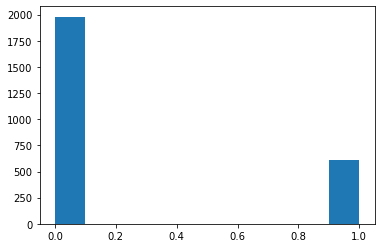

In [108]:
plt.hist(pred)

(array([1775.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         814.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

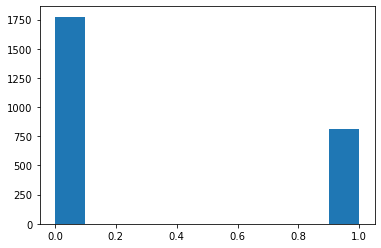

In [109]:
plt.hist(y_test)

In [110]:
np.sum(np.abs(y_test - pred))

423